In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
from sklearn.model_selection import train_test_split

import torch
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch import nn, optim

import matplotlib.pyplot as plt



In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
# building_id
#columns = X.columns
data_train = pd.read_csv('./dataset-0510/train.csv')
X_test = pd.read_csv('./dataset-0510/test.csv')

In [4]:
data = data_train.append(X_test, ignore_index=True, sort=False)
data = data.drop(['building_id'], axis=1)
print(data.isnull().values.any())

True


In [5]:
data.fillna(data.median(), inplace=True)
columns = data.columns
sale_price = data['total_price']
data.isnull().values.any()

False

In [6]:
scaler = MinMaxScaler()
data = pd.DataFrame(scaler.fit_transform(data), columns = columns)
data['total_price'] = sale_price
data.head()


/home/islab/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,parking_area,parking_price,...,XIV_500,XIV_index_500,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN,total_price
0,0.7,1.000000,0.220133,0.107143,0.75,0.2,0.300577,1.0,0.005952,0.042916,...,0.034503,1.0,0.045336,1.0,0.135021,0.0,0.181915,0.0,0.031126,6.476038e+05
1,0.7,0.222222,0.269487,0.142857,0.25,0.2,0.379486,1.0,0.005952,0.042916,...,0.016657,1.0,0.033208,1.0,0.868705,0.0,0.979105,0.0,0.036191,3.321452e+06
2,0.7,0.222222,0.461026,0.107143,0.25,0.2,0.288697,1.0,0.005952,0.042916,...,0.046401,1.0,0.061219,1.0,0.862568,0.0,0.979317,0.0,0.049197,9.570885e+06
3,0.7,1.000000,0.890325,0.821429,0.00,0.2,0.889899,0.0,0.005952,0.079516,...,0.011898,1.0,0.036096,1.0,0.139679,0.0,0.220238,0.0,0.090022,1.421501e+07
4,0.0,1.000000,0.996866,0.035714,1.00,0.2,0.330351,1.0,0.005952,0.042916,...,0.010708,1.0,0.013572,1.0,0.140720,0.0,0.225440,0.0,0.112169,7.627120e+05


In [7]:
scaler = MinMaxScaler()
data = pd.DataFrame(scaler.fit_transform(data), columns = columns)
data['total_price'] = sale_price
data.head()

,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,parking_area,parking_price,...,XIV_500,XIV_index_500,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN,total_price
0,0.7,1.000000,0.220133,0.107143,0.75,0.2,0.300577,1.0,0.005952,0.042916,...,0.034503,1.0,0.045336,1.0,0.135021,0.0,0.181915,0.0,0.031126,6.476038e+05
1,0.7,0.222222,0.269487,0.142857,0.25,0.2,0.379486,1.0,0.005952,0.042916,...,0.016657,1.0,0.033208,1.0,0.868705,0.0,0.979105,0.0,0.036191,3.321452e+06
2,0.7,0.222222,0.461026,0.107143,0.25,0.2,0.288697,1.0,0.005952,0.042916,...,0.046401,1.0,0.061219,1.0,0.862568,0.0,0.979317,0.0,0.049197,9.570885e+06
3,0.7,1.000000,0.890325,0.821429,0.00,0.2,0.889899,0.0,0.005952,0.079516,...,0.011898,1.0,0.036096,1.0,0.139679,0.0,0.220238,0.0,0.090022,1.421501e+07
4,0.0,1.000000,0.996866,0.035714,1.00,0.2,0.330351,1.0,0.005952,0.042916,...,0.010708,1.0,0.013572,1.0,0.140720,0.0,0.225440,0.0,0.112169,7.627120e+05


In [8]:
train = data.iloc[:60000]
test  = data.iloc[60000:]
test.drop('total_price', axis=1, inplace=True)

/home/islab/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3930: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [9]:
X_train, X_val, y_train, y_val = train_test_split(train.drop('total_price', axis=1), train['total_price'], test_size=0.3, random_state=42)

In [10]:
class Regressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(233, 144)
        self.fc2 = nn.Linear(144, 72)
        self.fc3 = nn.Linear(72, 18)
        self.fc4 = nn.Linear(18, 1)

        #self.dropout = nn.Dropout(p=0.1)

    def forward(self, x):

        #x = self.dropout(F.relu(self.fc1(x)))
        #x = self.dropout(F.relu(self.fc2(x)))
        #x = self.dropout(F.relu(self.fc3(x)))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        return x

In [11]:
train_batch = np.array_split(X_train, 50)
label_batch = np.array_split(y_train, 50)

In [12]:
for i in range(len(train_batch)):
    train_batch[i] = torch.from_numpy(train_batch[i].values).float().to(device)
for i in range(len(label_batch)):
    label_batch[i] = torch.from_numpy(label_batch[i].values).float().view(-1, 1).to(device)

X_val = torch.from_numpy(X_val.values).float().to(device)
y_val = torch.from_numpy(y_val.values).float().view(-1, 1).to(device)

In [13]:
model = Regressor().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr= 0.0003)

output = model(train_batch[0])
print(label_batch[0])
loss = criterion(output, label_batch[0])
#loss = criterion(output, label_batch[0])
print(output)

output = model(train_batch[1])
loss = criterion(output, label_batch[i])
#loss = criterion(output, label_batch[1])
print(loss)

tensor([[1.7965e+06],
        [1.7418e+07],
        [2.2343e+06],
        [1.3146e+06],
        [2.1060e+06],
        [7.7935e+06],
        [1.1815e+07],
        [9.4312e+07],
        [6.0526e+06],
        [1.4215e+07],
        [1.3954e+06],
        [2.5339e+06],
        [7.2457e+06],
        [1.9788e+07],
        [8.7190e+06],
        [8.6144e+06],
        [7.9962e+06],
        [4.3044e+06],
        [1.1817e+07],
        [6.0526e+06],
        [1.9443e+07],
        [3.2468e+06],
        [7.4930e+06],
        [1.9181e+06],
        [4.0604e+06],
        [6.5210e+06],
        [2.3375e+06],
        [2.3525e+06],
        [7.0012e+06],
        [3.6417e+06],
        [1.8085e+07],
        [1.7965e+06],
        [2.9901e+06],
        [7.2949e+06],
        [5.5972e+06],
        [3.9847e+07],
        [1.8760e+07],
        [7.0907e+07],
        [2.8469e+06],
        [2.7172e+07],
        [9.0353e+06],
        [1.3413e+06],
        [3.2242e+07],
        [1.8085e+07],
        [1.4401e+07],
        [2

In [14]:
model = Regressor().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr= 0.001)

epochs = 50000
train_losses, test_losses = [], []

for e in range(epochs):
    model.train()
    train_loss = 0
    for i in range(len(train_batch)):
        optimizer.zero_grad()
        output = model(train_batch[i])
        loss = torch.sqrt(criterion(torch.log(output), torch.log(label_batch[i])))
        #loss = criterion(output, label_batch[i])
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        
    else:
        test_loss = 0
        accuracy = 0
        
        with torch.no_grad():
            model.eval()
            predictions = model(X_val)
            test_loss += torch.sqrt(criterion(torch.log(predictions), torch.log(y_val)))
                
        train_losses.append(train_loss/len(train_batch))
        test_losses.append(test_loss)

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.4f}.. ".format(train_loss/len(train_batch)),
              "Test Loss: {:.4f}.. ".format(test_loss))
        if train_loss/len(train_batch) < 0.03:
            break

Epoch: 1/50000..  Training Loss: 14.4467..  Test Loss: 12.2781.. 
Epoch: 2/50000..  Training Loss: 11.2601..  Test Loss: 10.4151.. 
Epoch: 3/50000..  Training Loss: 9.8390..  Test Loss: 9.2990.. 
Epoch: 4/50000..  Training Loss: 8.9023..  Test Loss: 8.5168.. 
Epoch: 5/50000..  Training Loss: 8.2164..  Test Loss: 7.9125.. 
Epoch: 6/50000..  Training Loss: 7.6700..  Test Loss: 7.4200.. 
Epoch: 7/50000..  Training Loss: 7.2184..  Test Loss: 7.0065.. 
Epoch: 8/50000..  Training Loss: 6.8342..  Test Loss: 6.6499.. 
Epoch: 9/50000..  Training Loss: 6.4992..  Test Loss: 6.3354.. 
Epoch: 10/50000..  Training Loss: 6.2009..  Test Loss: 6.0526.. 
Epoch: 11/50000..  Training Loss: 5.9306..  Test Loss: 5.7944.. 
Epoch: 12/50000..  Training Loss: 5.6824..  Test Loss: 5.5562.. 
Epoch: 13/50000..  Training Loss: 5.4527..  Test Loss: 5.3352.. 
Epoch: 14/50000..  Training Loss: 5.2393..  Test Loss: 5.1293.. 
Epoch: 15/50000..  Training Loss: 5.0400..  Test Loss: 4.9362.. 
Epoch: 16/50000..  Training Lo

Epoch: 127/50000..  Training Loss: 1.0615..  Test Loss: 1.0655.. 
Epoch: 128/50000..  Training Loss: 1.0608..  Test Loss: 1.0648.. 
Epoch: 129/50000..  Training Loss: 1.0601..  Test Loss: 1.0641.. 
Epoch: 130/50000..  Training Loss: 1.0594..  Test Loss: 1.0633.. 
Epoch: 131/50000..  Training Loss: 1.0587..  Test Loss: 1.0626.. 
Epoch: 132/50000..  Training Loss: 1.0579..  Test Loss: 1.0618.. 
Epoch: 133/50000..  Training Loss: 1.0572..  Test Loss: 1.0610.. 
Epoch: 134/50000..  Training Loss: 1.0564..  Test Loss: 1.0602.. 
Epoch: 135/50000..  Training Loss: 1.0556..  Test Loss: 1.0594.. 
Epoch: 136/50000..  Training Loss: 1.0548..  Test Loss: 1.0586.. 
Epoch: 137/50000..  Training Loss: 1.0540..  Test Loss: 1.0577.. 
Epoch: 138/50000..  Training Loss: 1.0532..  Test Loss: 1.0569.. 
Epoch: 139/50000..  Training Loss: 1.0523..  Test Loss: 1.0560.. 
Epoch: 140/50000..  Training Loss: 1.0514..  Test Loss: 1.0551.. 
Epoch: 141/50000..  Training Loss: 1.0506..  Test Loss: 1.0542.. 
Epoch: 142

Epoch: 253/50000..  Training Loss: 0.7983..  Test Loss: 0.8010.. 
Epoch: 254/50000..  Training Loss: 0.7967..  Test Loss: 0.7995.. 
Epoch: 255/50000..  Training Loss: 0.7952..  Test Loss: 0.7981.. 
Epoch: 256/50000..  Training Loss: 0.7936..  Test Loss: 0.7968.. 
Epoch: 257/50000..  Training Loss: 0.7921..  Test Loss: nan.. 
Epoch: 258/50000..  Training Loss: 0.7907..  Test Loss: nan.. 
Epoch: 259/50000..  Training Loss: 0.7892..  Test Loss: nan.. 
Epoch: 260/50000..  Training Loss: 0.7878..  Test Loss: nan.. 
Epoch: 261/50000..  Training Loss: 0.7864..  Test Loss: nan.. 
Epoch: 262/50000..  Training Loss: 0.7850..  Test Loss: nan.. 
Epoch: 263/50000..  Training Loss: 0.7836..  Test Loss: nan.. 
Epoch: 264/50000..  Training Loss: 0.7823..  Test Loss: nan.. 
Epoch: 265/50000..  Training Loss: 0.7809..  Test Loss: nan.. 
Epoch: 266/50000..  Training Loss: 0.7796..  Test Loss: nan.. 
Epoch: 267/50000..  Training Loss: 0.7783..  Test Loss: nan.. 
Epoch: 268/50000..  Training Loss: 0.7770..

Epoch: 383/50000..  Training Loss: 0.6488..  Test Loss: nan.. 
Epoch: 384/50000..  Training Loss: 0.6477..  Test Loss: nan.. 
Epoch: 385/50000..  Training Loss: 0.6466..  Test Loss: nan.. 
Epoch: 386/50000..  Training Loss: 0.6455..  Test Loss: nan.. 
Epoch: 387/50000..  Training Loss: 0.6444..  Test Loss: nan.. 
Epoch: 388/50000..  Training Loss: 0.6433..  Test Loss: nan.. 
Epoch: 389/50000..  Training Loss: 0.6423..  Test Loss: nan.. 
Epoch: 390/50000..  Training Loss: 0.6412..  Test Loss: nan.. 
Epoch: 391/50000..  Training Loss: 0.6402..  Test Loss: nan.. 
Epoch: 392/50000..  Training Loss: 0.6391..  Test Loss: nan.. 
Epoch: 393/50000..  Training Loss: 0.6381..  Test Loss: nan.. 
Epoch: 394/50000..  Training Loss: 0.6371..  Test Loss: nan.. 
Epoch: 395/50000..  Training Loss: 0.6361..  Test Loss: nan.. 
Epoch: 396/50000..  Training Loss: 0.6351..  Test Loss: nan.. 
Epoch: 397/50000..  Training Loss: 0.6341..  Test Loss: nan.. 
Epoch: 398/50000..  Training Loss: 0.6332..  Test Loss:

Epoch: 509/50000..  Training Loss: 0.5567..  Test Loss: nan.. 
Epoch: 510/50000..  Training Loss: 0.5561..  Test Loss: nan.. 
Epoch: 511/50000..  Training Loss: 0.5555..  Test Loss: nan.. 
Epoch: 512/50000..  Training Loss: 0.5550..  Test Loss: nan.. 
Epoch: 513/50000..  Training Loss: 0.5544..  Test Loss: nan.. 
Epoch: 514/50000..  Training Loss: 0.5538..  Test Loss: nan.. 
Epoch: 515/50000..  Training Loss: 0.5533..  Test Loss: nan.. 
Epoch: 516/50000..  Training Loss: 0.5527..  Test Loss: nan.. 
Epoch: 517/50000..  Training Loss: 0.5522..  Test Loss: nan.. 
Epoch: 518/50000..  Training Loss: 0.5516..  Test Loss: nan.. 
Epoch: 519/50000..  Training Loss: 0.5511..  Test Loss: nan.. 
Epoch: 520/50000..  Training Loss: 0.5505..  Test Loss: nan.. 
Epoch: 521/50000..  Training Loss: 0.5500..  Test Loss: nan.. 
Epoch: 522/50000..  Training Loss: 0.5494..  Test Loss: nan.. 
Epoch: 523/50000..  Training Loss: 0.5489..  Test Loss: nan.. 
Epoch: 524/50000..  Training Loss: 0.5483..  Test Loss:

Epoch: 641/50000..  Training Loss: 0.4904..  Test Loss: nan.. 
Epoch: 642/50000..  Training Loss: 0.4900..  Test Loss: nan.. 
Epoch: 643/50000..  Training Loss: 0.4896..  Test Loss: nan.. 
Epoch: 644/50000..  Training Loss: 0.4891..  Test Loss: nan.. 
Epoch: 645/50000..  Training Loss: 0.4887..  Test Loss: nan.. 
Epoch: 646/50000..  Training Loss: 0.4883..  Test Loss: nan.. 
Epoch: 647/50000..  Training Loss: 0.4878..  Test Loss: nan.. 
Epoch: 648/50000..  Training Loss: 0.4874..  Test Loss: nan.. 
Epoch: 649/50000..  Training Loss: 0.4870..  Test Loss: nan.. 
Epoch: 650/50000..  Training Loss: 0.4866..  Test Loss: nan.. 
Epoch: 651/50000..  Training Loss: 0.4862..  Test Loss: nan.. 
Epoch: 652/50000..  Training Loss: 0.4857..  Test Loss: nan.. 
Epoch: 653/50000..  Training Loss: 0.4853..  Test Loss: nan.. 
Epoch: 654/50000..  Training Loss: 0.4849..  Test Loss: nan.. 
Epoch: 655/50000..  Training Loss: 0.4845..  Test Loss: nan.. 
Epoch: 656/50000..  Training Loss: 0.4840..  Test Loss:

Epoch: 773/50000..  Training Loss: 0.4403..  Test Loss: nan.. 
Epoch: 774/50000..  Training Loss: 0.4400..  Test Loss: nan.. 
Epoch: 775/50000..  Training Loss: 0.4397..  Test Loss: nan.. 
Epoch: 776/50000..  Training Loss: 0.4393..  Test Loss: nan.. 
Epoch: 777/50000..  Training Loss: 0.4390..  Test Loss: nan.. 
Epoch: 778/50000..  Training Loss: 0.4387..  Test Loss: nan.. 
Epoch: 779/50000..  Training Loss: 0.4384..  Test Loss: nan.. 
Epoch: 780/50000..  Training Loss: 0.4380..  Test Loss: nan.. 
Epoch: 781/50000..  Training Loss: 0.4377..  Test Loss: nan.. 
Epoch: 782/50000..  Training Loss: 0.4374..  Test Loss: nan.. 
Epoch: 783/50000..  Training Loss: 0.4371..  Test Loss: nan.. 
Epoch: 784/50000..  Training Loss: 0.4368..  Test Loss: nan.. 
Epoch: 785/50000..  Training Loss: 0.4365..  Test Loss: nan.. 
Epoch: 786/50000..  Training Loss: 0.4362..  Test Loss: nan.. 
Epoch: 787/50000..  Training Loss: 0.4358..  Test Loss: nan.. 
Epoch: 788/50000..  Training Loss: 0.4355..  Test Loss:

Epoch: 905/50000..  Training Loss: 0.4060..  Test Loss: nan.. 
Epoch: 906/50000..  Training Loss: 0.4057..  Test Loss: nan.. 
Epoch: 907/50000..  Training Loss: 0.4055..  Test Loss: nan.. 
Epoch: 908/50000..  Training Loss: 0.4053..  Test Loss: nan.. 
Epoch: 909/50000..  Training Loss: 0.4051..  Test Loss: nan.. 
Epoch: 910/50000..  Training Loss: 0.4049..  Test Loss: nan.. 
Epoch: 911/50000..  Training Loss: 0.4047..  Test Loss: nan.. 
Epoch: 912/50000..  Training Loss: 0.4045..  Test Loss: nan.. 
Epoch: 913/50000..  Training Loss: 0.4043..  Test Loss: nan.. 
Epoch: 914/50000..  Training Loss: 0.4041..  Test Loss: nan.. 
Epoch: 915/50000..  Training Loss: 0.4039..  Test Loss: nan.. 
Epoch: 916/50000..  Training Loss: 0.4037..  Test Loss: nan.. 
Epoch: 917/50000..  Training Loss: 0.4034..  Test Loss: nan.. 
Epoch: 918/50000..  Training Loss: 0.4033..  Test Loss: nan.. 
Epoch: 919/50000..  Training Loss: 0.4031..  Test Loss: nan.. 
Epoch: 920/50000..  Training Loss: 0.4029..  Test Loss:

Epoch: 1035/50000..  Training Loss: 0.3821..  Test Loss: nan.. 
Epoch: 1036/50000..  Training Loss: 0.3819..  Test Loss: nan.. 
Epoch: 1037/50000..  Training Loss: 0.3818..  Test Loss: nan.. 
Epoch: 1038/50000..  Training Loss: 0.3817..  Test Loss: nan.. 
Epoch: 1039/50000..  Training Loss: 0.3816..  Test Loss: nan.. 
Epoch: 1040/50000..  Training Loss: 0.3814..  Test Loss: nan.. 
Epoch: 1041/50000..  Training Loss: 0.3813..  Test Loss: nan.. 
Epoch: 1042/50000..  Training Loss: 0.3812..  Test Loss: nan.. 
Epoch: 1043/50000..  Training Loss: 0.3811..  Test Loss: nan.. 
Epoch: 1044/50000..  Training Loss: 0.3810..  Test Loss: nan.. 
Epoch: 1045/50000..  Training Loss: 0.3809..  Test Loss: nan.. 
Epoch: 1046/50000..  Training Loss: 0.3807..  Test Loss: nan.. 
Epoch: 1047/50000..  Training Loss: 0.3806..  Test Loss: nan.. 
Epoch: 1048/50000..  Training Loss: 0.3805..  Test Loss: nan.. 
Epoch: 1049/50000..  Training Loss: 0.3804..  Test Loss: nan.. 
Epoch: 1050/50000..  Training Loss: 0.38

Epoch: 1165/50000..  Training Loss: 0.3618..  Test Loss: nan.. 
Epoch: 1166/50000..  Training Loss: 0.3617..  Test Loss: nan.. 
Epoch: 1167/50000..  Training Loss: 0.3615..  Test Loss: nan.. 
Epoch: 1168/50000..  Training Loss: 0.3614..  Test Loss: nan.. 
Epoch: 1169/50000..  Training Loss: 0.3612..  Test Loss: nan.. 
Epoch: 1170/50000..  Training Loss: 0.3611..  Test Loss: nan.. 
Epoch: 1171/50000..  Training Loss: 0.3610..  Test Loss: nan.. 
Epoch: 1172/50000..  Training Loss: 0.3608..  Test Loss: nan.. 
Epoch: 1173/50000..  Training Loss: 0.3607..  Test Loss: nan.. 
Epoch: 1174/50000..  Training Loss: 0.3605..  Test Loss: nan.. 
Epoch: 1175/50000..  Training Loss: 0.3604..  Test Loss: nan.. 
Epoch: 1176/50000..  Training Loss: 0.3602..  Test Loss: nan.. 
Epoch: 1177/50000..  Training Loss: 0.3601..  Test Loss: nan.. 
Epoch: 1178/50000..  Training Loss: 0.3600..  Test Loss: nan.. 
Epoch: 1179/50000..  Training Loss: 0.3598..  Test Loss: nan.. 
Epoch: 1180/50000..  Training Loss: 0.35

Epoch: 1295/50000..  Training Loss: 0.3444..  Test Loss: nan.. 
Epoch: 1296/50000..  Training Loss: 0.3443..  Test Loss: nan.. 
Epoch: 1297/50000..  Training Loss: 0.3442..  Test Loss: nan.. 
Epoch: 1298/50000..  Training Loss: 0.3440..  Test Loss: nan.. 
Epoch: 1299/50000..  Training Loss: 0.3439..  Test Loss: nan.. 
Epoch: 1300/50000..  Training Loss: 0.3438..  Test Loss: nan.. 
Epoch: 1301/50000..  Training Loss: 0.3436..  Test Loss: nan.. 
Epoch: 1302/50000..  Training Loss: 0.3435..  Test Loss: nan.. 
Epoch: 1303/50000..  Training Loss: 0.3434..  Test Loss: nan.. 
Epoch: 1304/50000..  Training Loss: 0.3433..  Test Loss: nan.. 
Epoch: 1305/50000..  Training Loss: 0.3431..  Test Loss: nan.. 
Epoch: 1306/50000..  Training Loss: 0.3430..  Test Loss: nan.. 
Epoch: 1307/50000..  Training Loss: 0.3429..  Test Loss: nan.. 
Epoch: 1308/50000..  Training Loss: 0.3428..  Test Loss: nan.. 
Epoch: 1309/50000..  Training Loss: 0.3427..  Test Loss: nan.. 
Epoch: 1310/50000..  Training Loss: 0.34

Epoch: 1425/50000..  Training Loss: 0.3292..  Test Loss: nan.. 
Epoch: 1426/50000..  Training Loss: 0.3290..  Test Loss: nan.. 
Epoch: 1427/50000..  Training Loss: 0.3289..  Test Loss: nan.. 
Epoch: 1428/50000..  Training Loss: 0.3288..  Test Loss: nan.. 
Epoch: 1429/50000..  Training Loss: 0.3287..  Test Loss: nan.. 
Epoch: 1430/50000..  Training Loss: 0.3286..  Test Loss: nan.. 
Epoch: 1431/50000..  Training Loss: 0.3285..  Test Loss: nan.. 
Epoch: 1432/50000..  Training Loss: 0.3284..  Test Loss: nan.. 
Epoch: 1433/50000..  Training Loss: 0.3283..  Test Loss: nan.. 
Epoch: 1434/50000..  Training Loss: 0.3282..  Test Loss: nan.. 
Epoch: 1435/50000..  Training Loss: 0.3281..  Test Loss: nan.. 
Epoch: 1436/50000..  Training Loss: 0.3279..  Test Loss: nan.. 
Epoch: 1437/50000..  Training Loss: 0.3279..  Test Loss: nan.. 
Epoch: 1438/50000..  Training Loss: 0.3278..  Test Loss: nan.. 
Epoch: 1439/50000..  Training Loss: 0.3276..  Test Loss: nan.. 
Epoch: 1440/50000..  Training Loss: 0.32

Epoch: 1555/50000..  Training Loss: 0.3159..  Test Loss: nan.. 
Epoch: 1556/50000..  Training Loss: 0.3158..  Test Loss: nan.. 
Epoch: 1557/50000..  Training Loss: 0.3158..  Test Loss: nan.. 
Epoch: 1558/50000..  Training Loss: 0.3157..  Test Loss: nan.. 
Epoch: 1559/50000..  Training Loss: 0.3156..  Test Loss: nan.. 
Epoch: 1560/50000..  Training Loss: 0.3155..  Test Loss: nan.. 
Epoch: 1561/50000..  Training Loss: 0.3154..  Test Loss: nan.. 
Epoch: 1562/50000..  Training Loss: 0.3153..  Test Loss: nan.. 
Epoch: 1563/50000..  Training Loss: 0.3151..  Test Loss: nan.. 
Epoch: 1564/50000..  Training Loss: 0.3150..  Test Loss: nan.. 
Epoch: 1565/50000..  Training Loss: 0.3149..  Test Loss: nan.. 
Epoch: 1566/50000..  Training Loss: 0.3149..  Test Loss: nan.. 
Epoch: 1567/50000..  Training Loss: 0.3148..  Test Loss: nan.. 
Epoch: 1568/50000..  Training Loss: 0.3149..  Test Loss: nan.. 
Epoch: 1569/50000..  Training Loss: 0.3147..  Test Loss: nan.. 
Epoch: 1570/50000..  Training Loss: 0.31

Epoch: 1685/50000..  Training Loss: 0.3043..  Test Loss: nan.. 
Epoch: 1686/50000..  Training Loss: 0.3043..  Test Loss: nan.. 
Epoch: 1687/50000..  Training Loss: 0.3043..  Test Loss: nan.. 
Epoch: 1688/50000..  Training Loss: 0.3041..  Test Loss: nan.. 
Epoch: 1689/50000..  Training Loss: 0.3040..  Test Loss: nan.. 
Epoch: 1690/50000..  Training Loss: 0.3040..  Test Loss: nan.. 
Epoch: 1691/50000..  Training Loss: 0.3039..  Test Loss: nan.. 
Epoch: 1692/50000..  Training Loss: 0.3038..  Test Loss: nan.. 
Epoch: 1693/50000..  Training Loss: 0.3037..  Test Loss: nan.. 
Epoch: 1694/50000..  Training Loss: 0.3036..  Test Loss: nan.. 
Epoch: 1695/50000..  Training Loss: 0.3036..  Test Loss: nan.. 
Epoch: 1696/50000..  Training Loss: 0.3035..  Test Loss: nan.. 
Epoch: 1697/50000..  Training Loss: 0.3034..  Test Loss: nan.. 
Epoch: 1698/50000..  Training Loss: 0.3033..  Test Loss: nan.. 
Epoch: 1699/50000..  Training Loss: 0.3033..  Test Loss: nan.. 
Epoch: 1700/50000..  Training Loss: 0.30

Epoch: 1815/50000..  Training Loss: 0.2948..  Test Loss: nan.. 
Epoch: 1816/50000..  Training Loss: 0.2947..  Test Loss: nan.. 
Epoch: 1817/50000..  Training Loss: 0.2947..  Test Loss: nan.. 
Epoch: 1818/50000..  Training Loss: 0.2946..  Test Loss: nan.. 
Epoch: 1819/50000..  Training Loss: 0.2945..  Test Loss: nan.. 
Epoch: 1820/50000..  Training Loss: 0.2945..  Test Loss: nan.. 
Epoch: 1821/50000..  Training Loss: 0.2944..  Test Loss: nan.. 
Epoch: 1822/50000..  Training Loss: 0.2943..  Test Loss: nan.. 
Epoch: 1823/50000..  Training Loss: 0.2943..  Test Loss: nan.. 
Epoch: 1824/50000..  Training Loss: 0.2942..  Test Loss: nan.. 
Epoch: 1825/50000..  Training Loss: 0.2942..  Test Loss: nan.. 
Epoch: 1826/50000..  Training Loss: 0.2941..  Test Loss: nan.. 
Epoch: 1827/50000..  Training Loss: 0.2940..  Test Loss: nan.. 
Epoch: 1828/50000..  Training Loss: 0.2940..  Test Loss: nan.. 
Epoch: 1829/50000..  Training Loss: 0.2940..  Test Loss: nan.. 
Epoch: 1830/50000..  Training Loss: 0.29

Epoch: 1945/50000..  Training Loss: 0.2866..  Test Loss: nan.. 
Epoch: 1946/50000..  Training Loss: 0.2865..  Test Loss: nan.. 
Epoch: 1947/50000..  Training Loss: 0.2864..  Test Loss: nan.. 
Epoch: 1948/50000..  Training Loss: 0.2864..  Test Loss: nan.. 
Epoch: 1949/50000..  Training Loss: 0.2863..  Test Loss: nan.. 
Epoch: 1950/50000..  Training Loss: 0.2863..  Test Loss: nan.. 
Epoch: 1951/50000..  Training Loss: 0.2862..  Test Loss: nan.. 
Epoch: 1952/50000..  Training Loss: 0.2862..  Test Loss: nan.. 
Epoch: 1953/50000..  Training Loss: 0.2861..  Test Loss: nan.. 
Epoch: 1954/50000..  Training Loss: 0.2860..  Test Loss: nan.. 
Epoch: 1955/50000..  Training Loss: 0.2860..  Test Loss: nan.. 
Epoch: 1956/50000..  Training Loss: 0.2861..  Test Loss: nan.. 
Epoch: 1957/50000..  Training Loss: 0.2859..  Test Loss: nan.. 
Epoch: 1958/50000..  Training Loss: 0.2859..  Test Loss: nan.. 
Epoch: 1959/50000..  Training Loss: 0.2858..  Test Loss: nan.. 
Epoch: 1960/50000..  Training Loss: 0.28

Epoch: 2075/50000..  Training Loss: 0.2795..  Test Loss: nan.. 
Epoch: 2076/50000..  Training Loss: 0.2794..  Test Loss: nan.. 
Epoch: 2077/50000..  Training Loss: 0.2798..  Test Loss: nan.. 
Epoch: 2078/50000..  Training Loss: 0.2795..  Test Loss: nan.. 
Epoch: 2079/50000..  Training Loss: 0.2796..  Test Loss: nan.. 
Epoch: 2080/50000..  Training Loss: 0.2798..  Test Loss: nan.. 
Epoch: 2081/50000..  Training Loss: 0.2793..  Test Loss: nan.. 
Epoch: 2082/50000..  Training Loss: 0.2791..  Test Loss: nan.. 
Epoch: 2083/50000..  Training Loss: 0.2790..  Test Loss: nan.. 
Epoch: 2084/50000..  Training Loss: 0.2790..  Test Loss: nan.. 
Epoch: 2085/50000..  Training Loss: 0.2789..  Test Loss: nan.. 
Epoch: 2086/50000..  Training Loss: 0.2788..  Test Loss: nan.. 
Epoch: 2087/50000..  Training Loss: 0.2788..  Test Loss: nan.. 
Epoch: 2088/50000..  Training Loss: 0.2787..  Test Loss: nan.. 
Epoch: 2089/50000..  Training Loss: 0.2787..  Test Loss: nan.. 
Epoch: 2090/50000..  Training Loss: 0.27

Epoch: 2205/50000..  Training Loss: 0.2733..  Test Loss: nan.. 
Epoch: 2206/50000..  Training Loss: 0.2735..  Test Loss: nan.. 
Epoch: 2207/50000..  Training Loss: 0.2734..  Test Loss: nan.. 
Epoch: 2208/50000..  Training Loss: 0.2735..  Test Loss: nan.. 
Epoch: 2209/50000..  Training Loss: 0.2735..  Test Loss: nan.. 
Epoch: 2210/50000..  Training Loss: 0.2737..  Test Loss: nan.. 
Epoch: 2211/50000..  Training Loss: 0.2741..  Test Loss: nan.. 
Epoch: 2212/50000..  Training Loss: 0.2744..  Test Loss: nan.. 
Epoch: 2213/50000..  Training Loss: 0.2750..  Test Loss: nan.. 
Epoch: 2214/50000..  Training Loss: 0.2748..  Test Loss: nan.. 
Epoch: 2215/50000..  Training Loss: 0.2741..  Test Loss: nan.. 
Epoch: 2216/50000..  Training Loss: 0.2736..  Test Loss: nan.. 
Epoch: 2217/50000..  Training Loss: 0.2733..  Test Loss: nan.. 
Epoch: 2218/50000..  Training Loss: 0.2730..  Test Loss: nan.. 
Epoch: 2219/50000..  Training Loss: 0.2729..  Test Loss: nan.. 
Epoch: 2220/50000..  Training Loss: 0.27

Epoch: 2335/50000..  Training Loss: 0.2677..  Test Loss: nan.. 
Epoch: 2336/50000..  Training Loss: 0.2676..  Test Loss: nan.. 
Epoch: 2337/50000..  Training Loss: 0.2676..  Test Loss: nan.. 
Epoch: 2338/50000..  Training Loss: 0.2675..  Test Loss: nan.. 
Epoch: 2339/50000..  Training Loss: 0.2674..  Test Loss: nan.. 
Epoch: 2340/50000..  Training Loss: 0.2674..  Test Loss: nan.. 
Epoch: 2341/50000..  Training Loss: 0.2674..  Test Loss: nan.. 
Epoch: 2342/50000..  Training Loss: 0.2673..  Test Loss: nan.. 
Epoch: 2343/50000..  Training Loss: 0.2674..  Test Loss: nan.. 
Epoch: 2344/50000..  Training Loss: 0.2672..  Test Loss: nan.. 
Epoch: 2345/50000..  Training Loss: 0.2672..  Test Loss: nan.. 
Epoch: 2346/50000..  Training Loss: 0.2673..  Test Loss: nan.. 
Epoch: 2347/50000..  Training Loss: 0.2671..  Test Loss: nan.. 
Epoch: 2348/50000..  Training Loss: 0.2671..  Test Loss: nan.. 
Epoch: 2349/50000..  Training Loss: 0.2671..  Test Loss: nan.. 
Epoch: 2350/50000..  Training Loss: 0.26

Epoch: 2465/50000..  Training Loss: 0.2627..  Test Loss: nan.. 
Epoch: 2466/50000..  Training Loss: 0.2627..  Test Loss: nan.. 
Epoch: 2467/50000..  Training Loss: 0.2628..  Test Loss: nan.. 
Epoch: 2468/50000..  Training Loss: 0.2626..  Test Loss: nan.. 
Epoch: 2469/50000..  Training Loss: 0.2626..  Test Loss: nan.. 
Epoch: 2470/50000..  Training Loss: 0.2626..  Test Loss: nan.. 
Epoch: 2471/50000..  Training Loss: 0.2625..  Test Loss: nan.. 
Epoch: 2472/50000..  Training Loss: 0.2625..  Test Loss: nan.. 
Epoch: 2473/50000..  Training Loss: 0.2626..  Test Loss: nan.. 
Epoch: 2474/50000..  Training Loss: 0.2624..  Test Loss: nan.. 
Epoch: 2475/50000..  Training Loss: 0.2624..  Test Loss: nan.. 
Epoch: 2476/50000..  Training Loss: 0.2625..  Test Loss: nan.. 
Epoch: 2477/50000..  Training Loss: 0.2623..  Test Loss: nan.. 
Epoch: 2478/50000..  Training Loss: 0.2623..  Test Loss: nan.. 
Epoch: 2479/50000..  Training Loss: 0.2624..  Test Loss: nan.. 
Epoch: 2480/50000..  Training Loss: 0.26

Epoch: 2595/50000..  Training Loss: 0.2583..  Test Loss: nan.. 
Epoch: 2596/50000..  Training Loss: 0.2582..  Test Loss: nan.. 
Epoch: 2597/50000..  Training Loss: 0.2588..  Test Loss: nan.. 
Epoch: 2598/50000..  Training Loss: 0.2584..  Test Loss: nan.. 
Epoch: 2599/50000..  Training Loss: 0.2582..  Test Loss: nan.. 
Epoch: 2600/50000..  Training Loss: 0.2581..  Test Loss: nan.. 
Epoch: 2601/50000..  Training Loss: 0.2580..  Test Loss: nan.. 
Epoch: 2602/50000..  Training Loss: 0.2580..  Test Loss: nan.. 
Epoch: 2603/50000..  Training Loss: 0.2580..  Test Loss: nan.. 
Epoch: 2604/50000..  Training Loss: 0.2579..  Test Loss: nan.. 
Epoch: 2605/50000..  Training Loss: 0.2578..  Test Loss: nan.. 
Epoch: 2606/50000..  Training Loss: 0.2578..  Test Loss: nan.. 
Epoch: 2607/50000..  Training Loss: 0.2578..  Test Loss: nan.. 
Epoch: 2608/50000..  Training Loss: 0.2579..  Test Loss: nan.. 
Epoch: 2609/50000..  Training Loss: 0.2577..  Test Loss: nan.. 
Epoch: 2610/50000..  Training Loss: 0.25

Epoch: 2725/50000..  Training Loss: 0.2543..  Test Loss: nan.. 
Epoch: 2726/50000..  Training Loss: 0.2543..  Test Loss: nan.. 
Epoch: 2727/50000..  Training Loss: 0.2542..  Test Loss: nan.. 
Epoch: 2728/50000..  Training Loss: 0.2543..  Test Loss: nan.. 
Epoch: 2729/50000..  Training Loss: 0.2542..  Test Loss: nan.. 
Epoch: 2730/50000..  Training Loss: 0.2541..  Test Loss: nan.. 
Epoch: 2731/50000..  Training Loss: 0.2542..  Test Loss: nan.. 
Epoch: 2732/50000..  Training Loss: 0.2541..  Test Loss: nan.. 
Epoch: 2733/50000..  Training Loss: 0.2540..  Test Loss: nan.. 
Epoch: 2734/50000..  Training Loss: 0.2540..  Test Loss: nan.. 
Epoch: 2735/50000..  Training Loss: 0.2540..  Test Loss: nan.. 
Epoch: 2736/50000..  Training Loss: 0.2540..  Test Loss: nan.. 
Epoch: 2737/50000..  Training Loss: 0.2539..  Test Loss: nan.. 
Epoch: 2738/50000..  Training Loss: 0.2539..  Test Loss: nan.. 
Epoch: 2739/50000..  Training Loss: 0.2539..  Test Loss: nan.. 
Epoch: 2740/50000..  Training Loss: 0.25

Epoch: 2855/50000..  Training Loss: 0.2510..  Test Loss: nan.. 
Epoch: 2856/50000..  Training Loss: 0.2510..  Test Loss: nan.. 
Epoch: 2857/50000..  Training Loss: 0.2510..  Test Loss: nan.. 
Epoch: 2858/50000..  Training Loss: 0.2509..  Test Loss: nan.. 
Epoch: 2859/50000..  Training Loss: 0.2508..  Test Loss: nan.. 
Epoch: 2860/50000..  Training Loss: 0.2508..  Test Loss: nan.. 
Epoch: 2861/50000..  Training Loss: 0.2507..  Test Loss: nan.. 
Epoch: 2862/50000..  Training Loss: 0.2507..  Test Loss: nan.. 
Epoch: 2863/50000..  Training Loss: 0.2507..  Test Loss: nan.. 
Epoch: 2864/50000..  Training Loss: 0.2507..  Test Loss: nan.. 
Epoch: 2865/50000..  Training Loss: 0.2506..  Test Loss: nan.. 
Epoch: 2866/50000..  Training Loss: 0.2506..  Test Loss: nan.. 
Epoch: 2867/50000..  Training Loss: 0.2506..  Test Loss: nan.. 
Epoch: 2868/50000..  Training Loss: 0.2506..  Test Loss: nan.. 
Epoch: 2869/50000..  Training Loss: 0.2505..  Test Loss: nan.. 
Epoch: 2870/50000..  Training Loss: 0.25

Epoch: 2985/50000..  Training Loss: 0.2483..  Test Loss: nan.. 
Epoch: 2986/50000..  Training Loss: 0.2481..  Test Loss: nan.. 
Epoch: 2987/50000..  Training Loss: 0.2480..  Test Loss: nan.. 
Epoch: 2988/50000..  Training Loss: 0.2479..  Test Loss: nan.. 
Epoch: 2989/50000..  Training Loss: 0.2479..  Test Loss: nan.. 
Epoch: 2990/50000..  Training Loss: 0.2479..  Test Loss: nan.. 
Epoch: 2991/50000..  Training Loss: 0.2480..  Test Loss: nan.. 
Epoch: 2992/50000..  Training Loss: 0.2478..  Test Loss: nan.. 
Epoch: 2993/50000..  Training Loss: 0.2476..  Test Loss: nan.. 
Epoch: 2994/50000..  Training Loss: 0.2476..  Test Loss: nan.. 
Epoch: 2995/50000..  Training Loss: 0.2476..  Test Loss: nan.. 
Epoch: 2996/50000..  Training Loss: 0.2476..  Test Loss: nan.. 
Epoch: 2997/50000..  Training Loss: 0.2475..  Test Loss: nan.. 
Epoch: 2998/50000..  Training Loss: 0.2475..  Test Loss: nan.. 
Epoch: 2999/50000..  Training Loss: 0.2475..  Test Loss: nan.. 
Epoch: 3000/50000..  Training Loss: 0.24

Epoch: 3115/50000..  Training Loss: 0.2469..  Test Loss: nan.. 
Epoch: 3116/50000..  Training Loss: 0.2472..  Test Loss: nan.. 
Epoch: 3117/50000..  Training Loss: 0.2476..  Test Loss: nan.. 
Epoch: 3118/50000..  Training Loss: 0.2484..  Test Loss: nan.. 
Epoch: 3119/50000..  Training Loss: 0.2493..  Test Loss: nan.. 
Epoch: 3120/50000..  Training Loss: 0.2490..  Test Loss: nan.. 
Epoch: 3121/50000..  Training Loss: 0.2478..  Test Loss: nan.. 
Epoch: 3122/50000..  Training Loss: 0.2470..  Test Loss: nan.. 
Epoch: 3123/50000..  Training Loss: 0.2466..  Test Loss: nan.. 
Epoch: 3124/50000..  Training Loss: 0.2463..  Test Loss: nan.. 
Epoch: 3125/50000..  Training Loss: 0.2461..  Test Loss: nan.. 
Epoch: 3126/50000..  Training Loss: 0.2460..  Test Loss: nan.. 
Epoch: 3127/50000..  Training Loss: 0.2459..  Test Loss: nan.. 
Epoch: 3128/50000..  Training Loss: 0.2458..  Test Loss: nan.. 
Epoch: 3129/50000..  Training Loss: 0.2458..  Test Loss: nan.. 
Epoch: 3130/50000..  Training Loss: 0.24

Epoch: 3245/50000..  Training Loss: 0.2427..  Test Loss: nan.. 
Epoch: 3246/50000..  Training Loss: 0.2428..  Test Loss: nan.. 
Epoch: 3247/50000..  Training Loss: 0.2427..  Test Loss: nan.. 
Epoch: 3248/50000..  Training Loss: 0.2428..  Test Loss: nan.. 
Epoch: 3249/50000..  Training Loss: 0.2429..  Test Loss: nan.. 
Epoch: 3250/50000..  Training Loss: 0.2427..  Test Loss: nan.. 
Epoch: 3251/50000..  Training Loss: 0.2426..  Test Loss: nan.. 
Epoch: 3252/50000..  Training Loss: 0.2426..  Test Loss: nan.. 
Epoch: 3253/50000..  Training Loss: 0.2425..  Test Loss: nan.. 
Epoch: 3254/50000..  Training Loss: 0.2426..  Test Loss: nan.. 
Epoch: 3255/50000..  Training Loss: 0.2425..  Test Loss: nan.. 
Epoch: 3256/50000..  Training Loss: 0.2425..  Test Loss: nan.. 
Epoch: 3257/50000..  Training Loss: 0.2425..  Test Loss: nan.. 
Epoch: 3258/50000..  Training Loss: 0.2425..  Test Loss: nan.. 
Epoch: 3259/50000..  Training Loss: 0.2425..  Test Loss: nan.. 
Epoch: 3260/50000..  Training Loss: 0.24

Epoch: 3375/50000..  Training Loss: 0.2404..  Test Loss: nan.. 
Epoch: 3376/50000..  Training Loss: 0.2403..  Test Loss: nan.. 
Epoch: 3377/50000..  Training Loss: 0.2404..  Test Loss: nan.. 
Epoch: 3378/50000..  Training Loss: 0.2403..  Test Loss: nan.. 
Epoch: 3379/50000..  Training Loss: 0.2403..  Test Loss: nan.. 
Epoch: 3380/50000..  Training Loss: 0.2403..  Test Loss: nan.. 
Epoch: 3381/50000..  Training Loss: 0.2403..  Test Loss: nan.. 
Epoch: 3382/50000..  Training Loss: 0.2403..  Test Loss: nan.. 
Epoch: 3383/50000..  Training Loss: 0.2403..  Test Loss: nan.. 
Epoch: 3384/50000..  Training Loss: 0.2403..  Test Loss: nan.. 
Epoch: 3385/50000..  Training Loss: 0.2402..  Test Loss: nan.. 
Epoch: 3386/50000..  Training Loss: 0.2402..  Test Loss: nan.. 
Epoch: 3387/50000..  Training Loss: 0.2402..  Test Loss: nan.. 
Epoch: 3388/50000..  Training Loss: 0.2402..  Test Loss: nan.. 
Epoch: 3389/50000..  Training Loss: 0.2402..  Test Loss: nan.. 
Epoch: 3390/50000..  Training Loss: 0.24

Epoch: 3505/50000..  Training Loss: 0.2386..  Test Loss: nan.. 
Epoch: 3506/50000..  Training Loss: 0.2386..  Test Loss: nan.. 
Epoch: 3507/50000..  Training Loss: 0.2389..  Test Loss: nan.. 
Epoch: 3508/50000..  Training Loss: 0.2386..  Test Loss: nan.. 
Epoch: 3509/50000..  Training Loss: 0.2385..  Test Loss: nan.. 
Epoch: 3510/50000..  Training Loss: 0.2385..  Test Loss: nan.. 
Epoch: 3511/50000..  Training Loss: 0.2385..  Test Loss: nan.. 
Epoch: 3512/50000..  Training Loss: 0.2385..  Test Loss: nan.. 
Epoch: 3513/50000..  Training Loss: 0.2384..  Test Loss: nan.. 
Epoch: 3514/50000..  Training Loss: 0.2384..  Test Loss: nan.. 
Epoch: 3515/50000..  Training Loss: 0.2383..  Test Loss: nan.. 
Epoch: 3516/50000..  Training Loss: 0.2383..  Test Loss: nan.. 
Epoch: 3517/50000..  Training Loss: 0.2383..  Test Loss: nan.. 
Epoch: 3518/50000..  Training Loss: 0.2383..  Test Loss: nan.. 
Epoch: 3519/50000..  Training Loss: 0.2383..  Test Loss: nan.. 
Epoch: 3520/50000..  Training Loss: 0.23

Epoch: 3635/50000..  Training Loss: 0.2368..  Test Loss: nan.. 
Epoch: 3636/50000..  Training Loss: 0.2368..  Test Loss: nan.. 
Epoch: 3637/50000..  Training Loss: 0.2367..  Test Loss: nan.. 
Epoch: 3638/50000..  Training Loss: 0.2366..  Test Loss: nan.. 
Epoch: 3639/50000..  Training Loss: 0.2366..  Test Loss: nan.. 
Epoch: 3640/50000..  Training Loss: 0.2366..  Test Loss: nan.. 
Epoch: 3641/50000..  Training Loss: 0.2367..  Test Loss: nan.. 
Epoch: 3642/50000..  Training Loss: 0.2367..  Test Loss: nan.. 
Epoch: 3643/50000..  Training Loss: 0.2366..  Test Loss: nan.. 
Epoch: 3644/50000..  Training Loss: 0.2368..  Test Loss: nan.. 
Epoch: 3645/50000..  Training Loss: 0.2368..  Test Loss: nan.. 
Epoch: 3646/50000..  Training Loss: 0.2366..  Test Loss: nan.. 
Epoch: 3647/50000..  Training Loss: 0.2367..  Test Loss: nan.. 
Epoch: 3648/50000..  Training Loss: 0.2367..  Test Loss: nan.. 
Epoch: 3649/50000..  Training Loss: 0.2367..  Test Loss: nan.. 
Epoch: 3650/50000..  Training Loss: 0.23

Epoch: 3765/50000..  Training Loss: 0.2351..  Test Loss: nan.. 
Epoch: 3766/50000..  Training Loss: 0.2349..  Test Loss: nan.. 
Epoch: 3767/50000..  Training Loss: 0.2347..  Test Loss: nan.. 
Epoch: 3768/50000..  Training Loss: 0.2346..  Test Loss: nan.. 
Epoch: 3769/50000..  Training Loss: 0.2347..  Test Loss: nan.. 
Epoch: 3770/50000..  Training Loss: 0.2346..  Test Loss: nan.. 
Epoch: 3771/50000..  Training Loss: 0.2346..  Test Loss: nan.. 
Epoch: 3772/50000..  Training Loss: 0.2346..  Test Loss: nan.. 
Epoch: 3773/50000..  Training Loss: 0.2345..  Test Loss: nan.. 
Epoch: 3774/50000..  Training Loss: 0.2345..  Test Loss: nan.. 
Epoch: 3775/50000..  Training Loss: 0.2345..  Test Loss: nan.. 
Epoch: 3776/50000..  Training Loss: 0.2345..  Test Loss: nan.. 
Epoch: 3777/50000..  Training Loss: 0.2345..  Test Loss: nan.. 
Epoch: 3778/50000..  Training Loss: 0.2345..  Test Loss: nan.. 
Epoch: 3779/50000..  Training Loss: 0.2345..  Test Loss: nan.. 
Epoch: 3780/50000..  Training Loss: 0.23

Epoch: 3895/50000..  Training Loss: 0.2332..  Test Loss: nan.. 
Epoch: 3896/50000..  Training Loss: 0.2333..  Test Loss: nan.. 
Epoch: 3897/50000..  Training Loss: 0.2332..  Test Loss: nan.. 
Epoch: 3898/50000..  Training Loss: 0.2332..  Test Loss: nan.. 
Epoch: 3899/50000..  Training Loss: 0.2331..  Test Loss: nan.. 
Epoch: 3900/50000..  Training Loss: 0.2332..  Test Loss: nan.. 
Epoch: 3901/50000..  Training Loss: 0.2332..  Test Loss: nan.. 
Epoch: 3902/50000..  Training Loss: 0.2335..  Test Loss: nan.. 
Epoch: 3903/50000..  Training Loss: 0.2333..  Test Loss: nan.. 
Epoch: 3904/50000..  Training Loss: 0.2332..  Test Loss: nan.. 
Epoch: 3905/50000..  Training Loss: 0.2332..  Test Loss: nan.. 
Epoch: 3906/50000..  Training Loss: 0.2332..  Test Loss: nan.. 
Epoch: 3907/50000..  Training Loss: 0.2332..  Test Loss: nan.. 
Epoch: 3908/50000..  Training Loss: 0.2331..  Test Loss: nan.. 
Epoch: 3909/50000..  Training Loss: 0.2331..  Test Loss: nan.. 
Epoch: 3910/50000..  Training Loss: 0.23

Epoch: 4025/50000..  Training Loss: 0.2326..  Test Loss: nan.. 
Epoch: 4026/50000..  Training Loss: 0.2326..  Test Loss: nan.. 
Epoch: 4027/50000..  Training Loss: 0.2322..  Test Loss: nan.. 
Epoch: 4028/50000..  Training Loss: 0.2322..  Test Loss: nan.. 
Epoch: 4029/50000..  Training Loss: 0.2325..  Test Loss: nan.. 
Epoch: 4030/50000..  Training Loss: 0.2331..  Test Loss: nan.. 
Epoch: 4031/50000..  Training Loss: 0.2343..  Test Loss: nan.. 
Epoch: 4032/50000..  Training Loss: 0.2327..  Test Loss: nan.. 
Epoch: 4033/50000..  Training Loss: 0.2322..  Test Loss: nan.. 
Epoch: 4034/50000..  Training Loss: 0.2321..  Test Loss: nan.. 
Epoch: 4035/50000..  Training Loss: 0.2320..  Test Loss: nan.. 
Epoch: 4036/50000..  Training Loss: 0.2320..  Test Loss: nan.. 
Epoch: 4037/50000..  Training Loss: 0.2319..  Test Loss: nan.. 
Epoch: 4038/50000..  Training Loss: 0.2320..  Test Loss: nan.. 
Epoch: 4039/50000..  Training Loss: 0.2320..  Test Loss: nan.. 
Epoch: 4040/50000..  Training Loss: 0.23

Epoch: 4155/50000..  Training Loss: 0.2306..  Test Loss: nan.. 
Epoch: 4156/50000..  Training Loss: 0.2305..  Test Loss: nan.. 
Epoch: 4157/50000..  Training Loss: 0.2305..  Test Loss: nan.. 
Epoch: 4158/50000..  Training Loss: 0.2304..  Test Loss: nan.. 
Epoch: 4159/50000..  Training Loss: 0.2304..  Test Loss: nan.. 
Epoch: 4160/50000..  Training Loss: 0.2303..  Test Loss: nan.. 
Epoch: 4161/50000..  Training Loss: 0.2302..  Test Loss: nan.. 
Epoch: 4162/50000..  Training Loss: 0.2302..  Test Loss: nan.. 
Epoch: 4163/50000..  Training Loss: 0.2301..  Test Loss: nan.. 
Epoch: 4164/50000..  Training Loss: 0.2301..  Test Loss: nan.. 
Epoch: 4165/50000..  Training Loss: 0.2300..  Test Loss: nan.. 
Epoch: 4166/50000..  Training Loss: 0.2300..  Test Loss: nan.. 
Epoch: 4167/50000..  Training Loss: 0.2299..  Test Loss: nan.. 
Epoch: 4168/50000..  Training Loss: 0.2300..  Test Loss: nan.. 
Epoch: 4169/50000..  Training Loss: 0.2299..  Test Loss: nan.. 
Epoch: 4170/50000..  Training Loss: 0.22

Epoch: 4285/50000..  Training Loss: 0.2288..  Test Loss: nan.. 
Epoch: 4286/50000..  Training Loss: 0.2287..  Test Loss: nan.. 
Epoch: 4287/50000..  Training Loss: 0.2286..  Test Loss: nan.. 
Epoch: 4288/50000..  Training Loss: 0.2286..  Test Loss: nan.. 
Epoch: 4289/50000..  Training Loss: 0.2286..  Test Loss: nan.. 
Epoch: 4290/50000..  Training Loss: 0.2286..  Test Loss: nan.. 
Epoch: 4291/50000..  Training Loss: 0.2286..  Test Loss: nan.. 
Epoch: 4292/50000..  Training Loss: 0.2286..  Test Loss: nan.. 
Epoch: 4293/50000..  Training Loss: 0.2286..  Test Loss: nan.. 
Epoch: 4294/50000..  Training Loss: 0.2286..  Test Loss: nan.. 
Epoch: 4295/50000..  Training Loss: 0.2285..  Test Loss: nan.. 
Epoch: 4296/50000..  Training Loss: 0.2286..  Test Loss: nan.. 
Epoch: 4297/50000..  Training Loss: 0.2286..  Test Loss: nan.. 
Epoch: 4298/50000..  Training Loss: 0.2287..  Test Loss: nan.. 
Epoch: 4299/50000..  Training Loss: 0.2287..  Test Loss: nan.. 
Epoch: 4300/50000..  Training Loss: 0.22

Epoch: 4415/50000..  Training Loss: 0.2272..  Test Loss: nan.. 
Epoch: 4416/50000..  Training Loss: 0.2272..  Test Loss: nan.. 
Epoch: 4417/50000..  Training Loss: 0.2272..  Test Loss: nan.. 
Epoch: 4418/50000..  Training Loss: 0.2273..  Test Loss: nan.. 
Epoch: 4419/50000..  Training Loss: 0.2272..  Test Loss: nan.. 
Epoch: 4420/50000..  Training Loss: 0.2272..  Test Loss: nan.. 
Epoch: 4421/50000..  Training Loss: 0.2272..  Test Loss: nan.. 
Epoch: 4422/50000..  Training Loss: 0.2272..  Test Loss: nan.. 
Epoch: 4423/50000..  Training Loss: 0.2273..  Test Loss: nan.. 
Epoch: 4424/50000..  Training Loss: 0.2272..  Test Loss: nan.. 
Epoch: 4425/50000..  Training Loss: 0.2271..  Test Loss: nan.. 
Epoch: 4426/50000..  Training Loss: 0.2271..  Test Loss: nan.. 
Epoch: 4427/50000..  Training Loss: 0.2271..  Test Loss: nan.. 
Epoch: 4428/50000..  Training Loss: 0.2272..  Test Loss: nan.. 
Epoch: 4429/50000..  Training Loss: 0.2271..  Test Loss: nan.. 
Epoch: 4430/50000..  Training Loss: 0.22

Epoch: 4545/50000..  Training Loss: 0.2271..  Test Loss: nan.. 
Epoch: 4546/50000..  Training Loss: 0.2280..  Test Loss: nan.. 
Epoch: 4547/50000..  Training Loss: 0.2279..  Test Loss: nan.. 
Epoch: 4548/50000..  Training Loss: 0.2280..  Test Loss: nan.. 
Epoch: 4549/50000..  Training Loss: 0.2296..  Test Loss: nan.. 
Epoch: 4550/50000..  Training Loss: 0.2286..  Test Loss: nan.. 
Epoch: 4551/50000..  Training Loss: 0.2271..  Test Loss: nan.. 
Epoch: 4552/50000..  Training Loss: 0.2271..  Test Loss: nan.. 
Epoch: 4553/50000..  Training Loss: 0.2266..  Test Loss: nan.. 
Epoch: 4554/50000..  Training Loss: 0.2266..  Test Loss: nan.. 
Epoch: 4555/50000..  Training Loss: 0.2266..  Test Loss: nan.. 
Epoch: 4556/50000..  Training Loss: 0.2265..  Test Loss: nan.. 
Epoch: 4557/50000..  Training Loss: 0.2265..  Test Loss: nan.. 
Epoch: 4558/50000..  Training Loss: 0.2263..  Test Loss: nan.. 
Epoch: 4559/50000..  Training Loss: 0.2263..  Test Loss: nan.. 
Epoch: 4560/50000..  Training Loss: 0.22

Epoch: 4675/50000..  Training Loss: 0.2246..  Test Loss: nan.. 
Epoch: 4676/50000..  Training Loss: 0.2246..  Test Loss: nan.. 
Epoch: 4677/50000..  Training Loss: 0.2246..  Test Loss: nan.. 
Epoch: 4678/50000..  Training Loss: 0.2246..  Test Loss: nan.. 
Epoch: 4679/50000..  Training Loss: 0.2246..  Test Loss: nan.. 
Epoch: 4680/50000..  Training Loss: 0.2246..  Test Loss: nan.. 
Epoch: 4681/50000..  Training Loss: 0.2246..  Test Loss: nan.. 
Epoch: 4682/50000..  Training Loss: 0.2246..  Test Loss: nan.. 
Epoch: 4683/50000..  Training Loss: 0.2245..  Test Loss: nan.. 
Epoch: 4684/50000..  Training Loss: 0.2245..  Test Loss: nan.. 
Epoch: 4685/50000..  Training Loss: 0.2246..  Test Loss: nan.. 
Epoch: 4686/50000..  Training Loss: 0.2245..  Test Loss: nan.. 
Epoch: 4687/50000..  Training Loss: 0.2246..  Test Loss: nan.. 
Epoch: 4688/50000..  Training Loss: 0.2245..  Test Loss: nan.. 
Epoch: 4689/50000..  Training Loss: 0.2245..  Test Loss: nan.. 
Epoch: 4690/50000..  Training Loss: 0.22

Epoch: 4805/50000..  Training Loss: 0.2240..  Test Loss: nan.. 
Epoch: 4806/50000..  Training Loss: 0.2239..  Test Loss: nan.. 
Epoch: 4807/50000..  Training Loss: 0.2239..  Test Loss: nan.. 
Epoch: 4808/50000..  Training Loss: 0.2239..  Test Loss: nan.. 
Epoch: 4809/50000..  Training Loss: 0.2238..  Test Loss: nan.. 
Epoch: 4810/50000..  Training Loss: 0.2239..  Test Loss: nan.. 
Epoch: 4811/50000..  Training Loss: 0.2239..  Test Loss: nan.. 
Epoch: 4812/50000..  Training Loss: 0.2237..  Test Loss: nan.. 
Epoch: 4813/50000..  Training Loss: 0.2237..  Test Loss: nan.. 
Epoch: 4814/50000..  Training Loss: 0.2236..  Test Loss: nan.. 
Epoch: 4815/50000..  Training Loss: 0.2236..  Test Loss: nan.. 
Epoch: 4816/50000..  Training Loss: 0.2235..  Test Loss: nan.. 
Epoch: 4817/50000..  Training Loss: 0.2235..  Test Loss: nan.. 
Epoch: 4818/50000..  Training Loss: 0.2234..  Test Loss: nan.. 
Epoch: 4819/50000..  Training Loss: 0.2234..  Test Loss: nan.. 
Epoch: 4820/50000..  Training Loss: 0.22

Epoch: 4935/50000..  Training Loss: 0.2234..  Test Loss: nan.. 
Epoch: 4936/50000..  Training Loss: 0.2236..  Test Loss: nan.. 
Epoch: 4937/50000..  Training Loss: 0.2244..  Test Loss: nan.. 
Epoch: 4938/50000..  Training Loss: 0.2261..  Test Loss: nan.. 
Epoch: 4939/50000..  Training Loss: 0.2243..  Test Loss: nan.. 
Epoch: 4940/50000..  Training Loss: 0.2235..  Test Loss: nan.. 
Epoch: 4941/50000..  Training Loss: 0.2233..  Test Loss: nan.. 
Epoch: 4942/50000..  Training Loss: 0.2231..  Test Loss: nan.. 
Epoch: 4943/50000..  Training Loss: 0.2231..  Test Loss: nan.. 
Epoch: 4944/50000..  Training Loss: 0.2230..  Test Loss: nan.. 
Epoch: 4945/50000..  Training Loss: 0.2231..  Test Loss: nan.. 
Epoch: 4946/50000..  Training Loss: 0.2230..  Test Loss: nan.. 
Epoch: 4947/50000..  Training Loss: 0.2229..  Test Loss: nan.. 
Epoch: 4948/50000..  Training Loss: 0.2230..  Test Loss: nan.. 
Epoch: 4949/50000..  Training Loss: 0.2230..  Test Loss: nan.. 
Epoch: 4950/50000..  Training Loss: 0.22

Epoch: 5065/50000..  Training Loss: 0.2212..  Test Loss: nan.. 
Epoch: 5066/50000..  Training Loss: 0.2212..  Test Loss: nan.. 
Epoch: 5067/50000..  Training Loss: 0.2212..  Test Loss: nan.. 
Epoch: 5068/50000..  Training Loss: 0.2211..  Test Loss: nan.. 
Epoch: 5069/50000..  Training Loss: 0.2211..  Test Loss: nan.. 
Epoch: 5070/50000..  Training Loss: 0.2211..  Test Loss: nan.. 
Epoch: 5071/50000..  Training Loss: 0.2211..  Test Loss: nan.. 
Epoch: 5072/50000..  Training Loss: 0.2211..  Test Loss: nan.. 
Epoch: 5073/50000..  Training Loss: 0.2211..  Test Loss: nan.. 
Epoch: 5074/50000..  Training Loss: 0.2211..  Test Loss: nan.. 
Epoch: 5075/50000..  Training Loss: 0.2211..  Test Loss: nan.. 
Epoch: 5076/50000..  Training Loss: 0.2211..  Test Loss: nan.. 
Epoch: 5077/50000..  Training Loss: 0.2211..  Test Loss: nan.. 
Epoch: 5078/50000..  Training Loss: 0.2211..  Test Loss: nan.. 
Epoch: 5079/50000..  Training Loss: 0.2210..  Test Loss: nan.. 
Epoch: 5080/50000..  Training Loss: 0.22

Epoch: 5195/50000..  Training Loss: 0.2205..  Test Loss: nan.. 
Epoch: 5196/50000..  Training Loss: 0.2205..  Test Loss: nan.. 
Epoch: 5197/50000..  Training Loss: 0.2206..  Test Loss: nan.. 
Epoch: 5198/50000..  Training Loss: 0.2207..  Test Loss: nan.. 
Epoch: 5199/50000..  Training Loss: 0.2207..  Test Loss: nan.. 
Epoch: 5200/50000..  Training Loss: 0.2205..  Test Loss: nan.. 
Epoch: 5201/50000..  Training Loss: 0.2205..  Test Loss: nan.. 
Epoch: 5202/50000..  Training Loss: 0.2205..  Test Loss: nan.. 
Epoch: 5203/50000..  Training Loss: 0.2205..  Test Loss: nan.. 
Epoch: 5204/50000..  Training Loss: 0.2205..  Test Loss: nan.. 
Epoch: 5205/50000..  Training Loss: 0.2205..  Test Loss: nan.. 
Epoch: 5206/50000..  Training Loss: 0.2205..  Test Loss: nan.. 
Epoch: 5207/50000..  Training Loss: 0.2205..  Test Loss: nan.. 
Epoch: 5208/50000..  Training Loss: 0.2205..  Test Loss: nan.. 
Epoch: 5209/50000..  Training Loss: 0.2205..  Test Loss: nan.. 
Epoch: 5210/50000..  Training Loss: 0.22

Epoch: 5325/50000..  Training Loss: 0.2193..  Test Loss: nan.. 
Epoch: 5326/50000..  Training Loss: 0.2192..  Test Loss: nan.. 
Epoch: 5327/50000..  Training Loss: 0.2193..  Test Loss: nan.. 
Epoch: 5328/50000..  Training Loss: 0.2194..  Test Loss: nan.. 
Epoch: 5329/50000..  Training Loss: 0.2197..  Test Loss: nan.. 
Epoch: 5330/50000..  Training Loss: 0.2203..  Test Loss: nan.. 
Epoch: 5331/50000..  Training Loss: 0.2199..  Test Loss: nan.. 
Epoch: 5332/50000..  Training Loss: 0.2193..  Test Loss: nan.. 
Epoch: 5333/50000..  Training Loss: 0.2191..  Test Loss: nan.. 
Epoch: 5334/50000..  Training Loss: 0.2192..  Test Loss: nan.. 
Epoch: 5335/50000..  Training Loss: 0.2192..  Test Loss: nan.. 
Epoch: 5336/50000..  Training Loss: 0.2191..  Test Loss: nan.. 
Epoch: 5337/50000..  Training Loss: 0.2192..  Test Loss: nan.. 
Epoch: 5338/50000..  Training Loss: 0.2192..  Test Loss: nan.. 
Epoch: 5339/50000..  Training Loss: 0.2192..  Test Loss: nan.. 
Epoch: 5340/50000..  Training Loss: 0.21

Epoch: 5455/50000..  Training Loss: 0.2202..  Test Loss: nan.. 
Epoch: 5456/50000..  Training Loss: 0.2202..  Test Loss: nan.. 
Epoch: 5457/50000..  Training Loss: 0.2202..  Test Loss: nan.. 
Epoch: 5458/50000..  Training Loss: 0.2201..  Test Loss: nan.. 
Epoch: 5459/50000..  Training Loss: 0.2201..  Test Loss: nan.. 
Epoch: 5460/50000..  Training Loss: 0.2201..  Test Loss: nan.. 
Epoch: 5461/50000..  Training Loss: 0.2201..  Test Loss: nan.. 
Epoch: 5462/50000..  Training Loss: 0.2200..  Test Loss: nan.. 
Epoch: 5463/50000..  Training Loss: 0.2200..  Test Loss: nan.. 
Epoch: 5464/50000..  Training Loss: 0.2199..  Test Loss: nan.. 
Epoch: 5465/50000..  Training Loss: 0.2199..  Test Loss: nan.. 
Epoch: 5466/50000..  Training Loss: 0.2199..  Test Loss: nan.. 
Epoch: 5467/50000..  Training Loss: 0.2199..  Test Loss: nan.. 
Epoch: 5468/50000..  Training Loss: 0.2198..  Test Loss: nan.. 
Epoch: 5469/50000..  Training Loss: 0.2198..  Test Loss: nan.. 
Epoch: 5470/50000..  Training Loss: 0.21

Epoch: 5585/50000..  Training Loss: 0.2172..  Test Loss: nan.. 
Epoch: 5586/50000..  Training Loss: 0.2172..  Test Loss: nan.. 
Epoch: 5587/50000..  Training Loss: 0.2172..  Test Loss: nan.. 
Epoch: 5588/50000..  Training Loss: 0.2172..  Test Loss: nan.. 
Epoch: 5589/50000..  Training Loss: 0.2173..  Test Loss: nan.. 
Epoch: 5590/50000..  Training Loss: 0.2173..  Test Loss: nan.. 
Epoch: 5591/50000..  Training Loss: 0.2174..  Test Loss: nan.. 
Epoch: 5592/50000..  Training Loss: 0.2173..  Test Loss: nan.. 
Epoch: 5593/50000..  Training Loss: 0.2172..  Test Loss: nan.. 
Epoch: 5594/50000..  Training Loss: 0.2172..  Test Loss: nan.. 
Epoch: 5595/50000..  Training Loss: 0.2171..  Test Loss: nan.. 
Epoch: 5596/50000..  Training Loss: 0.2172..  Test Loss: nan.. 
Epoch: 5597/50000..  Training Loss: 0.2172..  Test Loss: nan.. 
Epoch: 5598/50000..  Training Loss: 0.2171..  Test Loss: nan.. 
Epoch: 5599/50000..  Training Loss: 0.2171..  Test Loss: nan.. 
Epoch: 5600/50000..  Training Loss: 0.21

Epoch: 5715/50000..  Training Loss: 0.2162..  Test Loss: nan.. 
Epoch: 5716/50000..  Training Loss: 0.2162..  Test Loss: nan.. 
Epoch: 5717/50000..  Training Loss: 0.2162..  Test Loss: nan.. 
Epoch: 5718/50000..  Training Loss: 0.2162..  Test Loss: nan.. 
Epoch: 5719/50000..  Training Loss: 0.2162..  Test Loss: nan.. 
Epoch: 5720/50000..  Training Loss: 0.2162..  Test Loss: nan.. 
Epoch: 5721/50000..  Training Loss: 0.2162..  Test Loss: nan.. 
Epoch: 5722/50000..  Training Loss: 0.2163..  Test Loss: nan.. 
Epoch: 5723/50000..  Training Loss: 0.2162..  Test Loss: nan.. 
Epoch: 5724/50000..  Training Loss: 0.2162..  Test Loss: nan.. 
Epoch: 5725/50000..  Training Loss: 0.2162..  Test Loss: nan.. 
Epoch: 5726/50000..  Training Loss: 0.2162..  Test Loss: nan.. 
Epoch: 5727/50000..  Training Loss: 0.2161..  Test Loss: nan.. 
Epoch: 5728/50000..  Training Loss: 0.2162..  Test Loss: nan.. 
Epoch: 5729/50000..  Training Loss: 0.2162..  Test Loss: nan.. 
Epoch: 5730/50000..  Training Loss: 0.21

Epoch: 5845/50000..  Training Loss: 0.2159..  Test Loss: nan.. 
Epoch: 5846/50000..  Training Loss: 0.2158..  Test Loss: nan.. 
Epoch: 5847/50000..  Training Loss: 0.2158..  Test Loss: nan.. 
Epoch: 5848/50000..  Training Loss: 0.2158..  Test Loss: nan.. 
Epoch: 5849/50000..  Training Loss: 0.2157..  Test Loss: nan.. 
Epoch: 5850/50000..  Training Loss: 0.2157..  Test Loss: nan.. 
Epoch: 5851/50000..  Training Loss: 0.2158..  Test Loss: nan.. 
Epoch: 5852/50000..  Training Loss: 0.2157..  Test Loss: nan.. 
Epoch: 5853/50000..  Training Loss: 0.2157..  Test Loss: nan.. 
Epoch: 5854/50000..  Training Loss: 0.2156..  Test Loss: nan.. 
Epoch: 5855/50000..  Training Loss: 0.2157..  Test Loss: nan.. 
Epoch: 5856/50000..  Training Loss: 0.2156..  Test Loss: nan.. 
Epoch: 5857/50000..  Training Loss: 0.2156..  Test Loss: nan.. 
Epoch: 5858/50000..  Training Loss: 0.2158..  Test Loss: nan.. 
Epoch: 5859/50000..  Training Loss: 0.2158..  Test Loss: nan.. 
Epoch: 5860/50000..  Training Loss: 0.21

Epoch: 5975/50000..  Training Loss: 0.2165..  Test Loss: nan.. 
Epoch: 5976/50000..  Training Loss: 0.2162..  Test Loss: nan.. 
Epoch: 5977/50000..  Training Loss: 0.2150..  Test Loss: nan.. 
Epoch: 5978/50000..  Training Loss: 0.2151..  Test Loss: nan.. 
Epoch: 5979/50000..  Training Loss: 0.2151..  Test Loss: nan.. 
Epoch: 5980/50000..  Training Loss: 0.2154..  Test Loss: nan.. 
Epoch: 5981/50000..  Training Loss: 0.2156..  Test Loss: nan.. 
Epoch: 5982/50000..  Training Loss: 0.2155..  Test Loss: nan.. 
Epoch: 5983/50000..  Training Loss: 0.2153..  Test Loss: nan.. 
Epoch: 5984/50000..  Training Loss: 0.2151..  Test Loss: nan.. 
Epoch: 5985/50000..  Training Loss: 0.2151..  Test Loss: nan.. 
Epoch: 5986/50000..  Training Loss: 0.2151..  Test Loss: nan.. 
Epoch: 5987/50000..  Training Loss: 0.2153..  Test Loss: nan.. 
Epoch: 5988/50000..  Training Loss: 0.2154..  Test Loss: nan.. 
Epoch: 5989/50000..  Training Loss: 0.2160..  Test Loss: nan.. 
Epoch: 5990/50000..  Training Loss: 0.21

Epoch: 6105/50000..  Training Loss: 0.2137..  Test Loss: nan.. 
Epoch: 6106/50000..  Training Loss: 0.2137..  Test Loss: nan.. 
Epoch: 6107/50000..  Training Loss: 0.2137..  Test Loss: nan.. 
Epoch: 6108/50000..  Training Loss: 0.2137..  Test Loss: nan.. 
Epoch: 6109/50000..  Training Loss: 0.2136..  Test Loss: nan.. 
Epoch: 6110/50000..  Training Loss: 0.2136..  Test Loss: nan.. 
Epoch: 6111/50000..  Training Loss: 0.2137..  Test Loss: nan.. 
Epoch: 6112/50000..  Training Loss: 0.2137..  Test Loss: nan.. 
Epoch: 6113/50000..  Training Loss: 0.2137..  Test Loss: nan.. 
Epoch: 6114/50000..  Training Loss: 0.2137..  Test Loss: nan.. 
Epoch: 6115/50000..  Training Loss: 0.2136..  Test Loss: nan.. 
Epoch: 6116/50000..  Training Loss: 0.2137..  Test Loss: nan.. 
Epoch: 6117/50000..  Training Loss: 0.2137..  Test Loss: nan.. 
Epoch: 6118/50000..  Training Loss: 0.2137..  Test Loss: nan.. 
Epoch: 6119/50000..  Training Loss: 0.2137..  Test Loss: nan.. 
Epoch: 6120/50000..  Training Loss: 0.21

Epoch: 6235/50000..  Training Loss: 0.2151..  Test Loss: nan.. 
Epoch: 6236/50000..  Training Loss: 0.2154..  Test Loss: nan.. 
Epoch: 6237/50000..  Training Loss: 0.2159..  Test Loss: nan.. 
Epoch: 6238/50000..  Training Loss: 0.2168..  Test Loss: nan.. 
Epoch: 6239/50000..  Training Loss: 0.2192..  Test Loss: nan.. 
Epoch: 6240/50000..  Training Loss: 0.2248..  Test Loss: nan.. 
Epoch: 6241/50000..  Training Loss: 0.2239..  Test Loss: nan.. 
Epoch: 6242/50000..  Training Loss: 0.2199..  Test Loss: nan.. 
Epoch: 6243/50000..  Training Loss: 0.2185..  Test Loss: nan.. 
Epoch: 6244/50000..  Training Loss: 0.2177..  Test Loss: nan.. 
Epoch: 6245/50000..  Training Loss: 0.2172..  Test Loss: nan.. 
Epoch: 6246/50000..  Training Loss: 0.2167..  Test Loss: nan.. 
Epoch: 6247/50000..  Training Loss: 0.2165..  Test Loss: nan.. 
Epoch: 6248/50000..  Training Loss: 0.2163..  Test Loss: nan.. 
Epoch: 6249/50000..  Training Loss: 0.2160..  Test Loss: nan.. 
Epoch: 6250/50000..  Training Loss: 0.21

Epoch: 6365/50000..  Training Loss: 0.2127..  Test Loss: nan.. 
Epoch: 6366/50000..  Training Loss: 0.2126..  Test Loss: nan.. 
Epoch: 6367/50000..  Training Loss: 0.2127..  Test Loss: nan.. 
Epoch: 6368/50000..  Training Loss: 0.2127..  Test Loss: nan.. 
Epoch: 6369/50000..  Training Loss: 0.2126..  Test Loss: nan.. 
Epoch: 6370/50000..  Training Loss: 0.2126..  Test Loss: nan.. 
Epoch: 6371/50000..  Training Loss: 0.2126..  Test Loss: nan.. 
Epoch: 6372/50000..  Training Loss: 0.2125..  Test Loss: nan.. 
Epoch: 6373/50000..  Training Loss: 0.2125..  Test Loss: nan.. 
Epoch: 6374/50000..  Training Loss: 0.2125..  Test Loss: nan.. 
Epoch: 6375/50000..  Training Loss: 0.2126..  Test Loss: nan.. 
Epoch: 6376/50000..  Training Loss: 0.2127..  Test Loss: nan.. 
Epoch: 6377/50000..  Training Loss: 0.2128..  Test Loss: nan.. 
Epoch: 6378/50000..  Training Loss: 0.2125..  Test Loss: nan.. 
Epoch: 6379/50000..  Training Loss: 0.2125..  Test Loss: nan.. 
Epoch: 6380/50000..  Training Loss: 0.21

Epoch: 6495/50000..  Training Loss: 0.2121..  Test Loss: nan.. 
Epoch: 6496/50000..  Training Loss: 0.2123..  Test Loss: nan.. 
Epoch: 6497/50000..  Training Loss: 0.2127..  Test Loss: nan.. 
Epoch: 6498/50000..  Training Loss: 0.2129..  Test Loss: nan.. 
Epoch: 6499/50000..  Training Loss: 0.2126..  Test Loss: nan.. 
Epoch: 6500/50000..  Training Loss: 0.2122..  Test Loss: nan.. 
Epoch: 6501/50000..  Training Loss: 0.2122..  Test Loss: nan.. 
Epoch: 6502/50000..  Training Loss: 0.2121..  Test Loss: nan.. 
Epoch: 6503/50000..  Training Loss: 0.2121..  Test Loss: nan.. 
Epoch: 6504/50000..  Training Loss: 0.2122..  Test Loss: nan.. 
Epoch: 6505/50000..  Training Loss: 0.2122..  Test Loss: nan.. 
Epoch: 6506/50000..  Training Loss: 0.2122..  Test Loss: nan.. 
Epoch: 6507/50000..  Training Loss: 0.2123..  Test Loss: nan.. 
Epoch: 6508/50000..  Training Loss: 0.2124..  Test Loss: nan.. 
Epoch: 6509/50000..  Training Loss: 0.2125..  Test Loss: nan.. 
Epoch: 6510/50000..  Training Loss: 0.21

Epoch: 6625/50000..  Training Loss: 0.2109..  Test Loss: nan.. 
Epoch: 6626/50000..  Training Loss: 0.2109..  Test Loss: nan.. 
Epoch: 6627/50000..  Training Loss: 0.2109..  Test Loss: nan.. 
Epoch: 6628/50000..  Training Loss: 0.2109..  Test Loss: nan.. 
Epoch: 6629/50000..  Training Loss: 0.2109..  Test Loss: nan.. 
Epoch: 6630/50000..  Training Loss: 0.2109..  Test Loss: nan.. 
Epoch: 6631/50000..  Training Loss: 0.2109..  Test Loss: nan.. 
Epoch: 6632/50000..  Training Loss: 0.2110..  Test Loss: nan.. 
Epoch: 6633/50000..  Training Loss: 0.2110..  Test Loss: nan.. 
Epoch: 6634/50000..  Training Loss: 0.2110..  Test Loss: nan.. 
Epoch: 6635/50000..  Training Loss: 0.2109..  Test Loss: nan.. 
Epoch: 6636/50000..  Training Loss: 0.2109..  Test Loss: nan.. 
Epoch: 6637/50000..  Training Loss: 0.2109..  Test Loss: nan.. 
Epoch: 6638/50000..  Training Loss: 0.2109..  Test Loss: nan.. 
Epoch: 6639/50000..  Training Loss: 0.2108..  Test Loss: nan.. 
Epoch: 6640/50000..  Training Loss: 0.21

Epoch: 6755/50000..  Training Loss: 0.2104..  Test Loss: nan.. 
Epoch: 6756/50000..  Training Loss: 0.2104..  Test Loss: nan.. 
Epoch: 6757/50000..  Training Loss: 0.2103..  Test Loss: nan.. 
Epoch: 6758/50000..  Training Loss: 0.2103..  Test Loss: nan.. 
Epoch: 6759/50000..  Training Loss: 0.2103..  Test Loss: nan.. 
Epoch: 6760/50000..  Training Loss: 0.2103..  Test Loss: nan.. 
Epoch: 6761/50000..  Training Loss: 0.2103..  Test Loss: nan.. 
Epoch: 6762/50000..  Training Loss: 0.2103..  Test Loss: nan.. 
Epoch: 6763/50000..  Training Loss: 0.2102..  Test Loss: nan.. 
Epoch: 6764/50000..  Training Loss: 0.2102..  Test Loss: nan.. 
Epoch: 6765/50000..  Training Loss: 0.2102..  Test Loss: nan.. 
Epoch: 6766/50000..  Training Loss: 0.2102..  Test Loss: nan.. 
Epoch: 6767/50000..  Training Loss: 0.2101..  Test Loss: nan.. 
Epoch: 6768/50000..  Training Loss: 0.2101..  Test Loss: nan.. 
Epoch: 6769/50000..  Training Loss: 0.2101..  Test Loss: nan.. 
Epoch: 6770/50000..  Training Loss: 0.21

Epoch: 6885/50000..  Training Loss: 0.2111..  Test Loss: nan.. 
Epoch: 6886/50000..  Training Loss: 0.2121..  Test Loss: nan.. 
Epoch: 6887/50000..  Training Loss: 0.2132..  Test Loss: nan.. 
Epoch: 6888/50000..  Training Loss: 0.2115..  Test Loss: nan.. 
Epoch: 6889/50000..  Training Loss: 0.2110..  Test Loss: nan.. 
Epoch: 6890/50000..  Training Loss: 0.2107..  Test Loss: nan.. 
Epoch: 6891/50000..  Training Loss: 0.2106..  Test Loss: nan.. 
Epoch: 6892/50000..  Training Loss: 0.2107..  Test Loss: nan.. 
Epoch: 6893/50000..  Training Loss: 0.2106..  Test Loss: nan.. 
Epoch: 6894/50000..  Training Loss: 0.2106..  Test Loss: nan.. 
Epoch: 6895/50000..  Training Loss: 0.2105..  Test Loss: nan.. 
Epoch: 6896/50000..  Training Loss: 0.2105..  Test Loss: nan.. 
Epoch: 6897/50000..  Training Loss: 0.2105..  Test Loss: nan.. 
Epoch: 6898/50000..  Training Loss: 0.2105..  Test Loss: nan.. 
Epoch: 6899/50000..  Training Loss: 0.2105..  Test Loss: nan.. 
Epoch: 6900/50000..  Training Loss: 0.21

Epoch: 7015/50000..  Training Loss: 0.2089..  Test Loss: nan.. 
Epoch: 7016/50000..  Training Loss: 0.2089..  Test Loss: nan.. 
Epoch: 7017/50000..  Training Loss: 0.2090..  Test Loss: nan.. 
Epoch: 7018/50000..  Training Loss: 0.2090..  Test Loss: nan.. 
Epoch: 7019/50000..  Training Loss: 0.2089..  Test Loss: nan.. 
Epoch: 7020/50000..  Training Loss: 0.2089..  Test Loss: nan.. 
Epoch: 7021/50000..  Training Loss: 0.2089..  Test Loss: nan.. 
Epoch: 7022/50000..  Training Loss: 0.2088..  Test Loss: nan.. 
Epoch: 7023/50000..  Training Loss: 0.2089..  Test Loss: nan.. 
Epoch: 7024/50000..  Training Loss: 0.2089..  Test Loss: nan.. 
Epoch: 7025/50000..  Training Loss: 0.2089..  Test Loss: nan.. 
Epoch: 7026/50000..  Training Loss: 0.2089..  Test Loss: nan.. 
Epoch: 7027/50000..  Training Loss: 0.2089..  Test Loss: nan.. 
Epoch: 7028/50000..  Training Loss: 0.2090..  Test Loss: nan.. 
Epoch: 7029/50000..  Training Loss: 0.2089..  Test Loss: nan.. 
Epoch: 7030/50000..  Training Loss: 0.20

Epoch: 7145/50000..  Training Loss: 0.2105..  Test Loss: nan.. 
Epoch: 7146/50000..  Training Loss: 0.2105..  Test Loss: nan.. 
Epoch: 7147/50000..  Training Loss: 0.2105..  Test Loss: nan.. 
Epoch: 7148/50000..  Training Loss: 0.2104..  Test Loss: nan.. 
Epoch: 7149/50000..  Training Loss: 0.2105..  Test Loss: nan.. 
Epoch: 7150/50000..  Training Loss: 0.2105..  Test Loss: nan.. 
Epoch: 7151/50000..  Training Loss: 0.2105..  Test Loss: nan.. 
Epoch: 7152/50000..  Training Loss: 0.2106..  Test Loss: nan.. 
Epoch: 7153/50000..  Training Loss: 0.2107..  Test Loss: nan.. 
Epoch: 7154/50000..  Training Loss: 0.2107..  Test Loss: nan.. 
Epoch: 7155/50000..  Training Loss: 0.2107..  Test Loss: nan.. 
Epoch: 7156/50000..  Training Loss: 0.2109..  Test Loss: nan.. 
Epoch: 7157/50000..  Training Loss: 0.2110..  Test Loss: nan.. 
Epoch: 7158/50000..  Training Loss: 0.2111..  Test Loss: nan.. 
Epoch: 7159/50000..  Training Loss: 0.2113..  Test Loss: nan.. 
Epoch: 7160/50000..  Training Loss: 0.21

Epoch: 7275/50000..  Training Loss: 0.2079..  Test Loss: nan.. 
Epoch: 7276/50000..  Training Loss: 0.2079..  Test Loss: nan.. 
Epoch: 7277/50000..  Training Loss: 0.2080..  Test Loss: nan.. 
Epoch: 7278/50000..  Training Loss: 0.2080..  Test Loss: nan.. 
Epoch: 7279/50000..  Training Loss: 0.2080..  Test Loss: nan.. 
Epoch: 7280/50000..  Training Loss: 0.2080..  Test Loss: nan.. 
Epoch: 7281/50000..  Training Loss: 0.2080..  Test Loss: nan.. 
Epoch: 7282/50000..  Training Loss: 0.2081..  Test Loss: nan.. 
Epoch: 7283/50000..  Training Loss: 0.2081..  Test Loss: nan.. 
Epoch: 7284/50000..  Training Loss: 0.2081..  Test Loss: nan.. 
Epoch: 7285/50000..  Training Loss: 0.2082..  Test Loss: nan.. 
Epoch: 7286/50000..  Training Loss: 0.2082..  Test Loss: nan.. 
Epoch: 7287/50000..  Training Loss: 0.2084..  Test Loss: nan.. 
Epoch: 7288/50000..  Training Loss: 0.2083..  Test Loss: nan.. 
Epoch: 7289/50000..  Training Loss: 0.2082..  Test Loss: nan.. 
Epoch: 7290/50000..  Training Loss: 0.20

Epoch: 7405/50000..  Training Loss: 0.2073..  Test Loss: nan.. 
Epoch: 7406/50000..  Training Loss: 0.2073..  Test Loss: nan.. 
Epoch: 7407/50000..  Training Loss: 0.2073..  Test Loss: nan.. 
Epoch: 7408/50000..  Training Loss: 0.2072..  Test Loss: nan.. 
Epoch: 7409/50000..  Training Loss: 0.2073..  Test Loss: nan.. 
Epoch: 7410/50000..  Training Loss: 0.2072..  Test Loss: nan.. 
Epoch: 7411/50000..  Training Loss: 0.2072..  Test Loss: nan.. 
Epoch: 7412/50000..  Training Loss: 0.2074..  Test Loss: nan.. 
Epoch: 7413/50000..  Training Loss: 0.2073..  Test Loss: nan.. 
Epoch: 7414/50000..  Training Loss: 0.2073..  Test Loss: nan.. 
Epoch: 7415/50000..  Training Loss: 0.2073..  Test Loss: nan.. 
Epoch: 7416/50000..  Training Loss: 0.2073..  Test Loss: nan.. 
Epoch: 7417/50000..  Training Loss: 0.2073..  Test Loss: nan.. 
Epoch: 7418/50000..  Training Loss: 0.2073..  Test Loss: nan.. 
Epoch: 7419/50000..  Training Loss: 0.2073..  Test Loss: nan.. 
Epoch: 7420/50000..  Training Loss: 0.20

Epoch: 7535/50000..  Training Loss: 0.2094..  Test Loss: nan.. 
Epoch: 7536/50000..  Training Loss: 0.2094..  Test Loss: nan.. 
Epoch: 7537/50000..  Training Loss: 0.2093..  Test Loss: nan.. 
Epoch: 7538/50000..  Training Loss: 0.2093..  Test Loss: nan.. 
Epoch: 7539/50000..  Training Loss: 0.2094..  Test Loss: nan.. 
Epoch: 7540/50000..  Training Loss: 0.2093..  Test Loss: nan.. 
Epoch: 7541/50000..  Training Loss: 0.2092..  Test Loss: nan.. 
Epoch: 7542/50000..  Training Loss: 0.2093..  Test Loss: nan.. 
Epoch: 7543/50000..  Training Loss: 0.2093..  Test Loss: nan.. 
Epoch: 7544/50000..  Training Loss: 0.2092..  Test Loss: nan.. 
Epoch: 7545/50000..  Training Loss: 0.2093..  Test Loss: nan.. 
Epoch: 7546/50000..  Training Loss: 0.2091..  Test Loss: nan.. 
Epoch: 7547/50000..  Training Loss: 0.2091..  Test Loss: nan.. 
Epoch: 7548/50000..  Training Loss: 0.2091..  Test Loss: nan.. 
Epoch: 7549/50000..  Training Loss: 0.2092..  Test Loss: nan.. 
Epoch: 7550/50000..  Training Loss: 0.20

Epoch: 7665/50000..  Training Loss: 0.2064..  Test Loss: nan.. 
Epoch: 7666/50000..  Training Loss: 0.2064..  Test Loss: nan.. 
Epoch: 7667/50000..  Training Loss: 0.2064..  Test Loss: nan.. 
Epoch: 7668/50000..  Training Loss: 0.2064..  Test Loss: nan.. 
Epoch: 7669/50000..  Training Loss: 0.2064..  Test Loss: nan.. 
Epoch: 7670/50000..  Training Loss: 0.2064..  Test Loss: nan.. 
Epoch: 7671/50000..  Training Loss: 0.2064..  Test Loss: nan.. 
Epoch: 7672/50000..  Training Loss: 0.2064..  Test Loss: nan.. 
Epoch: 7673/50000..  Training Loss: 0.2064..  Test Loss: nan.. 
Epoch: 7674/50000..  Training Loss: 0.2064..  Test Loss: nan.. 
Epoch: 7675/50000..  Training Loss: 0.2064..  Test Loss: nan.. 
Epoch: 7676/50000..  Training Loss: 0.2064..  Test Loss: nan.. 
Epoch: 7677/50000..  Training Loss: 0.2064..  Test Loss: nan.. 
Epoch: 7678/50000..  Training Loss: 0.2064..  Test Loss: nan.. 
Epoch: 7679/50000..  Training Loss: 0.2064..  Test Loss: nan.. 
Epoch: 7680/50000..  Training Loss: 0.20

Epoch: 7795/50000..  Training Loss: 0.2068..  Test Loss: nan.. 
Epoch: 7796/50000..  Training Loss: 0.2068..  Test Loss: nan.. 
Epoch: 7797/50000..  Training Loss: 0.2068..  Test Loss: nan.. 
Epoch: 7798/50000..  Training Loss: 0.2067..  Test Loss: nan.. 
Epoch: 7799/50000..  Training Loss: 0.2067..  Test Loss: nan.. 
Epoch: 7800/50000..  Training Loss: 0.2067..  Test Loss: nan.. 
Epoch: 7801/50000..  Training Loss: 0.2066..  Test Loss: nan.. 
Epoch: 7802/50000..  Training Loss: 0.2067..  Test Loss: nan.. 
Epoch: 7803/50000..  Training Loss: 0.2066..  Test Loss: nan.. 
Epoch: 7804/50000..  Training Loss: 0.2067..  Test Loss: nan.. 
Epoch: 7805/50000..  Training Loss: 0.2066..  Test Loss: nan.. 
Epoch: 7806/50000..  Training Loss: 0.2066..  Test Loss: nan.. 
Epoch: 7807/50000..  Training Loss: 0.2066..  Test Loss: nan.. 
Epoch: 7808/50000..  Training Loss: 0.2066..  Test Loss: nan.. 
Epoch: 7809/50000..  Training Loss: 0.2066..  Test Loss: nan.. 
Epoch: 7810/50000..  Training Loss: 0.20

Epoch: 7925/50000..  Training Loss: 0.2084..  Test Loss: nan.. 
Epoch: 7926/50000..  Training Loss: 0.2090..  Test Loss: nan.. 
Epoch: 7927/50000..  Training Loss: 0.2074..  Test Loss: nan.. 
Epoch: 7928/50000..  Training Loss: 0.2068..  Test Loss: nan.. 
Epoch: 7929/50000..  Training Loss: 0.2066..  Test Loss: nan.. 
Epoch: 7930/50000..  Training Loss: 0.2065..  Test Loss: nan.. 
Epoch: 7931/50000..  Training Loss: 0.2065..  Test Loss: nan.. 
Epoch: 7932/50000..  Training Loss: 0.2064..  Test Loss: nan.. 
Epoch: 7933/50000..  Training Loss: 0.2063..  Test Loss: nan.. 
Epoch: 7934/50000..  Training Loss: 0.2063..  Test Loss: nan.. 
Epoch: 7935/50000..  Training Loss: 0.2063..  Test Loss: nan.. 
Epoch: 7936/50000..  Training Loss: 0.2063..  Test Loss: nan.. 
Epoch: 7937/50000..  Training Loss: 0.2062..  Test Loss: nan.. 
Epoch: 7938/50000..  Training Loss: 0.2061..  Test Loss: nan.. 
Epoch: 7939/50000..  Training Loss: 0.2062..  Test Loss: nan.. 
Epoch: 7940/50000..  Training Loss: 0.20

Epoch: 8055/50000..  Training Loss: 0.2061..  Test Loss: nan.. 
Epoch: 8056/50000..  Training Loss: 0.2061..  Test Loss: nan.. 
Epoch: 8057/50000..  Training Loss: 0.2060..  Test Loss: nan.. 
Epoch: 8058/50000..  Training Loss: 0.2059..  Test Loss: nan.. 
Epoch: 8059/50000..  Training Loss: 0.2059..  Test Loss: nan.. 
Epoch: 8060/50000..  Training Loss: 0.2059..  Test Loss: nan.. 
Epoch: 8061/50000..  Training Loss: 0.2058..  Test Loss: nan.. 
Epoch: 8062/50000..  Training Loss: 0.2058..  Test Loss: nan.. 
Epoch: 8063/50000..  Training Loss: 0.2057..  Test Loss: nan.. 
Epoch: 8064/50000..  Training Loss: 0.2058..  Test Loss: nan.. 
Epoch: 8065/50000..  Training Loss: 0.2057..  Test Loss: nan.. 
Epoch: 8066/50000..  Training Loss: 0.2057..  Test Loss: nan.. 
Epoch: 8067/50000..  Training Loss: 0.2056..  Test Loss: nan.. 
Epoch: 8068/50000..  Training Loss: 0.2056..  Test Loss: nan.. 
Epoch: 8069/50000..  Training Loss: 0.2056..  Test Loss: nan.. 
Epoch: 8070/50000..  Training Loss: 0.20

Epoch: 8185/50000..  Training Loss: 0.2054..  Test Loss: nan.. 
Epoch: 8186/50000..  Training Loss: 0.2054..  Test Loss: nan.. 
Epoch: 8187/50000..  Training Loss: 0.2057..  Test Loss: nan.. 
Epoch: 8188/50000..  Training Loss: 0.2061..  Test Loss: nan.. 
Epoch: 8189/50000..  Training Loss: 0.2070..  Test Loss: nan.. 
Epoch: 8190/50000..  Training Loss: 0.2080..  Test Loss: nan.. 
Epoch: 8191/50000..  Training Loss: 0.2068..  Test Loss: nan.. 
Epoch: 8192/50000..  Training Loss: 0.2060..  Test Loss: nan.. 
Epoch: 8193/50000..  Training Loss: 0.2057..  Test Loss: nan.. 
Epoch: 8194/50000..  Training Loss: 0.2057..  Test Loss: nan.. 
Epoch: 8195/50000..  Training Loss: 0.2056..  Test Loss: nan.. 
Epoch: 8196/50000..  Training Loss: 0.2056..  Test Loss: nan.. 
Epoch: 8197/50000..  Training Loss: 0.2055..  Test Loss: nan.. 
Epoch: 8198/50000..  Training Loss: 0.2054..  Test Loss: nan.. 
Epoch: 8199/50000..  Training Loss: 0.2053..  Test Loss: nan.. 
Epoch: 8200/50000..  Training Loss: 0.20

Epoch: 8315/50000..  Training Loss: 0.2056..  Test Loss: nan.. 
Epoch: 8316/50000..  Training Loss: 0.2065..  Test Loss: nan.. 
Epoch: 8317/50000..  Training Loss: 0.2060..  Test Loss: nan.. 
Epoch: 8318/50000..  Training Loss: 0.2050..  Test Loss: nan.. 
Epoch: 8319/50000..  Training Loss: 0.2049..  Test Loss: nan.. 
Epoch: 8320/50000..  Training Loss: 0.2049..  Test Loss: nan.. 
Epoch: 8321/50000..  Training Loss: 0.2050..  Test Loss: nan.. 
Epoch: 8322/50000..  Training Loss: 0.2051..  Test Loss: nan.. 
Epoch: 8323/50000..  Training Loss: 0.2055..  Test Loss: nan.. 
Epoch: 8324/50000..  Training Loss: 0.2062..  Test Loss: nan.. 
Epoch: 8325/50000..  Training Loss: 0.2075..  Test Loss: nan.. 
Epoch: 8326/50000..  Training Loss: 0.2068..  Test Loss: nan.. 
Epoch: 8327/50000..  Training Loss: 0.2058..  Test Loss: nan.. 
Epoch: 8328/50000..  Training Loss: 0.2055..  Test Loss: nan.. 
Epoch: 8329/50000..  Training Loss: 0.2054..  Test Loss: nan.. 
Epoch: 8330/50000..  Training Loss: 0.20

Epoch: 8445/50000..  Training Loss: 0.2059..  Test Loss: nan.. 
Epoch: 8446/50000..  Training Loss: 0.2058..  Test Loss: nan.. 
Epoch: 8447/50000..  Training Loss: 0.2057..  Test Loss: nan.. 
Epoch: 8448/50000..  Training Loss: 0.2057..  Test Loss: nan.. 
Epoch: 8449/50000..  Training Loss: 0.2056..  Test Loss: nan.. 
Epoch: 8450/50000..  Training Loss: 0.2056..  Test Loss: nan.. 
Epoch: 8451/50000..  Training Loss: 0.2055..  Test Loss: nan.. 
Epoch: 8452/50000..  Training Loss: 0.2055..  Test Loss: nan.. 
Epoch: 8453/50000..  Training Loss: 0.2053..  Test Loss: nan.. 
Epoch: 8454/50000..  Training Loss: 0.2053..  Test Loss: nan.. 
Epoch: 8455/50000..  Training Loss: 0.2053..  Test Loss: nan.. 
Epoch: 8456/50000..  Training Loss: 0.2052..  Test Loss: nan.. 
Epoch: 8457/50000..  Training Loss: 0.2052..  Test Loss: nan.. 
Epoch: 8458/50000..  Training Loss: 0.2051..  Test Loss: nan.. 
Epoch: 8459/50000..  Training Loss: 0.2050..  Test Loss: nan.. 
Epoch: 8460/50000..  Training Loss: 0.20

Epoch: 8575/50000..  Training Loss: 0.2035..  Test Loss: nan.. 
Epoch: 8576/50000..  Training Loss: 0.2035..  Test Loss: nan.. 
Epoch: 8577/50000..  Training Loss: 0.2036..  Test Loss: nan.. 
Epoch: 8578/50000..  Training Loss: 0.2036..  Test Loss: nan.. 
Epoch: 8579/50000..  Training Loss: 0.2037..  Test Loss: nan.. 
Epoch: 8580/50000..  Training Loss: 0.2038..  Test Loss: nan.. 
Epoch: 8581/50000..  Training Loss: 0.2037..  Test Loss: nan.. 
Epoch: 8582/50000..  Training Loss: 0.2037..  Test Loss: nan.. 
Epoch: 8583/50000..  Training Loss: 0.2039..  Test Loss: nan.. 
Epoch: 8584/50000..  Training Loss: 0.2041..  Test Loss: nan.. 
Epoch: 8585/50000..  Training Loss: 0.2043..  Test Loss: nan.. 
Epoch: 8586/50000..  Training Loss: 0.2044..  Test Loss: nan.. 
Epoch: 8587/50000..  Training Loss: 0.2043..  Test Loss: nan.. 
Epoch: 8588/50000..  Training Loss: 0.2047..  Test Loss: nan.. 
Epoch: 8589/50000..  Training Loss: 0.2054..  Test Loss: nan.. 
Epoch: 8590/50000..  Training Loss: 0.20

Epoch: 8705/50000..  Training Loss: 0.2032..  Test Loss: nan.. 
Epoch: 8706/50000..  Training Loss: 0.2030..  Test Loss: nan.. 
Epoch: 8707/50000..  Training Loss: 0.2030..  Test Loss: nan.. 
Epoch: 8708/50000..  Training Loss: 0.2028..  Test Loss: nan.. 
Epoch: 8709/50000..  Training Loss: 0.2029..  Test Loss: nan.. 
Epoch: 8710/50000..  Training Loss: 0.2029..  Test Loss: nan.. 
Epoch: 8711/50000..  Training Loss: 0.2028..  Test Loss: nan.. 
Epoch: 8712/50000..  Training Loss: 0.2029..  Test Loss: nan.. 
Epoch: 8713/50000..  Training Loss: 0.2029..  Test Loss: nan.. 
Epoch: 8714/50000..  Training Loss: 0.2029..  Test Loss: nan.. 
Epoch: 8715/50000..  Training Loss: 0.2028..  Test Loss: nan.. 
Epoch: 8716/50000..  Training Loss: 0.2028..  Test Loss: nan.. 
Epoch: 8717/50000..  Training Loss: 0.2028..  Test Loss: nan.. 
Epoch: 8718/50000..  Training Loss: 0.2028..  Test Loss: nan.. 
Epoch: 8719/50000..  Training Loss: 0.2028..  Test Loss: nan.. 
Epoch: 8720/50000..  Training Loss: 0.20

Epoch: 8835/50000..  Training Loss: 0.2024..  Test Loss: nan.. 
Epoch: 8836/50000..  Training Loss: 0.2024..  Test Loss: nan.. 
Epoch: 8837/50000..  Training Loss: 0.2024..  Test Loss: nan.. 
Epoch: 8838/50000..  Training Loss: 0.2024..  Test Loss: nan.. 
Epoch: 8839/50000..  Training Loss: 0.2024..  Test Loss: nan.. 
Epoch: 8840/50000..  Training Loss: 0.2023..  Test Loss: nan.. 
Epoch: 8841/50000..  Training Loss: 0.2023..  Test Loss: nan.. 
Epoch: 8842/50000..  Training Loss: 0.2024..  Test Loss: nan.. 
Epoch: 8843/50000..  Training Loss: 0.2024..  Test Loss: nan.. 
Epoch: 8844/50000..  Training Loss: 0.2023..  Test Loss: nan.. 
Epoch: 8845/50000..  Training Loss: 0.2023..  Test Loss: nan.. 
Epoch: 8846/50000..  Training Loss: 0.2023..  Test Loss: nan.. 
Epoch: 8847/50000..  Training Loss: 0.2023..  Test Loss: nan.. 
Epoch: 8848/50000..  Training Loss: 0.2023..  Test Loss: nan.. 
Epoch: 8849/50000..  Training Loss: 0.2023..  Test Loss: nan.. 
Epoch: 8850/50000..  Training Loss: 0.20

Epoch: 8965/50000..  Training Loss: 0.2048..  Test Loss: nan.. 
Epoch: 8966/50000..  Training Loss: 0.2047..  Test Loss: nan.. 
Epoch: 8967/50000..  Training Loss: 0.2049..  Test Loss: nan.. 
Epoch: 8968/50000..  Training Loss: 0.2048..  Test Loss: nan.. 
Epoch: 8969/50000..  Training Loss: 0.2049..  Test Loss: nan.. 
Epoch: 8970/50000..  Training Loss: 0.2047..  Test Loss: nan.. 
Epoch: 8971/50000..  Training Loss: 0.2048..  Test Loss: nan.. 
Epoch: 8972/50000..  Training Loss: 0.2048..  Test Loss: nan.. 
Epoch: 8973/50000..  Training Loss: 0.2048..  Test Loss: nan.. 
Epoch: 8974/50000..  Training Loss: 0.2047..  Test Loss: nan.. 
Epoch: 8975/50000..  Training Loss: 0.2047..  Test Loss: nan.. 
Epoch: 8976/50000..  Training Loss: 0.2046..  Test Loss: nan.. 
Epoch: 8977/50000..  Training Loss: 0.2046..  Test Loss: nan.. 
Epoch: 8978/50000..  Training Loss: 0.2046..  Test Loss: nan.. 
Epoch: 8979/50000..  Training Loss: 0.2046..  Test Loss: nan.. 
Epoch: 8980/50000..  Training Loss: 0.20

Epoch: 9095/50000..  Training Loss: 0.2016..  Test Loss: nan.. 
Epoch: 9096/50000..  Training Loss: 0.2016..  Test Loss: nan.. 
Epoch: 9097/50000..  Training Loss: 0.2015..  Test Loss: nan.. 
Epoch: 9098/50000..  Training Loss: 0.2016..  Test Loss: nan.. 
Epoch: 9099/50000..  Training Loss: 0.2015..  Test Loss: nan.. 
Epoch: 9100/50000..  Training Loss: 0.2015..  Test Loss: nan.. 
Epoch: 9101/50000..  Training Loss: 0.2015..  Test Loss: nan.. 
Epoch: 9102/50000..  Training Loss: 0.2016..  Test Loss: nan.. 
Epoch: 9103/50000..  Training Loss: 0.2016..  Test Loss: nan.. 
Epoch: 9104/50000..  Training Loss: 0.2016..  Test Loss: nan.. 
Epoch: 9105/50000..  Training Loss: 0.2016..  Test Loss: nan.. 
Epoch: 9106/50000..  Training Loss: 0.2016..  Test Loss: nan.. 
Epoch: 9107/50000..  Training Loss: 0.2017..  Test Loss: nan.. 
Epoch: 9108/50000..  Training Loss: 0.2017..  Test Loss: nan.. 
Epoch: 9109/50000..  Training Loss: 0.2017..  Test Loss: nan.. 
Epoch: 9110/50000..  Training Loss: 0.20

Epoch: 9225/50000..  Training Loss: 0.2022..  Test Loss: nan.. 
Epoch: 9226/50000..  Training Loss: 0.2027..  Test Loss: nan.. 
Epoch: 9227/50000..  Training Loss: 0.2032..  Test Loss: nan.. 
Epoch: 9228/50000..  Training Loss: 0.2058..  Test Loss: nan.. 
Epoch: 9229/50000..  Training Loss: 0.2039..  Test Loss: nan.. 
Epoch: 9230/50000..  Training Loss: 0.2033..  Test Loss: nan.. 
Epoch: 9231/50000..  Training Loss: 0.2042..  Test Loss: nan.. 
Epoch: 9232/50000..  Training Loss: 0.2054..  Test Loss: nan.. 
Epoch: 9233/50000..  Training Loss: 0.2034..  Test Loss: nan.. 
Epoch: 9234/50000..  Training Loss: 0.2028..  Test Loss: nan.. 
Epoch: 9235/50000..  Training Loss: 0.2027..  Test Loss: nan.. 
Epoch: 9236/50000..  Training Loss: 0.2026..  Test Loss: nan.. 
Epoch: 9237/50000..  Training Loss: 0.2024..  Test Loss: nan.. 
Epoch: 9238/50000..  Training Loss: 0.2024..  Test Loss: nan.. 
Epoch: 9239/50000..  Training Loss: 0.2024..  Test Loss: nan.. 
Epoch: 9240/50000..  Training Loss: 0.20

Epoch: 9355/50000..  Training Loss: 0.2008..  Test Loss: nan.. 
Epoch: 9356/50000..  Training Loss: 0.2008..  Test Loss: nan.. 
Epoch: 9357/50000..  Training Loss: 0.2008..  Test Loss: nan.. 
Epoch: 9358/50000..  Training Loss: 0.2008..  Test Loss: nan.. 
Epoch: 9359/50000..  Training Loss: 0.2007..  Test Loss: nan.. 
Epoch: 9360/50000..  Training Loss: 0.2008..  Test Loss: nan.. 
Epoch: 9361/50000..  Training Loss: 0.2007..  Test Loss: nan.. 
Epoch: 9362/50000..  Training Loss: 0.2008..  Test Loss: nan.. 
Epoch: 9363/50000..  Training Loss: 0.2008..  Test Loss: nan.. 
Epoch: 9364/50000..  Training Loss: 0.2008..  Test Loss: nan.. 
Epoch: 9365/50000..  Training Loss: 0.2007..  Test Loss: nan.. 
Epoch: 9366/50000..  Training Loss: 0.2007..  Test Loss: nan.. 
Epoch: 9367/50000..  Training Loss: 0.2007..  Test Loss: nan.. 
Epoch: 9368/50000..  Training Loss: 0.2006..  Test Loss: nan.. 
Epoch: 9369/50000..  Training Loss: 0.2007..  Test Loss: nan.. 
Epoch: 9370/50000..  Training Loss: 0.20

Epoch: 9485/50000..  Training Loss: 0.2043..  Test Loss: nan.. 
Epoch: 9486/50000..  Training Loss: 0.2052..  Test Loss: nan.. 
Epoch: 9487/50000..  Training Loss: 0.2070..  Test Loss: nan.. 
Epoch: 9488/50000..  Training Loss: 0.2105..  Test Loss: nan.. 
Epoch: 9489/50000..  Training Loss: 0.2103..  Test Loss: nan.. 
Epoch: 9490/50000..  Training Loss: 0.2071..  Test Loss: nan.. 
Epoch: 9491/50000..  Training Loss: 0.2060..  Test Loss: nan.. 
Epoch: 9492/50000..  Training Loss: 0.2053..  Test Loss: nan.. 
Epoch: 9493/50000..  Training Loss: 0.2047..  Test Loss: nan.. 
Epoch: 9494/50000..  Training Loss: 0.2043..  Test Loss: nan.. 
Epoch: 9495/50000..  Training Loss: 0.2038..  Test Loss: nan.. 
Epoch: 9496/50000..  Training Loss: 0.2038..  Test Loss: nan.. 
Epoch: 9497/50000..  Training Loss: 0.2035..  Test Loss: nan.. 
Epoch: 9498/50000..  Training Loss: 0.2035..  Test Loss: nan.. 
Epoch: 9499/50000..  Training Loss: 0.2033..  Test Loss: nan.. 
Epoch: 9500/50000..  Training Loss: 0.20

Epoch: 9615/50000..  Training Loss: 0.2002..  Test Loss: nan.. 
Epoch: 9616/50000..  Training Loss: 0.2001..  Test Loss: nan.. 
Epoch: 9617/50000..  Training Loss: 0.2002..  Test Loss: nan.. 
Epoch: 9618/50000..  Training Loss: 0.2001..  Test Loss: nan.. 
Epoch: 9619/50000..  Training Loss: 0.2001..  Test Loss: nan.. 
Epoch: 9620/50000..  Training Loss: 0.2000..  Test Loss: nan.. 
Epoch: 9621/50000..  Training Loss: 0.2001..  Test Loss: nan.. 
Epoch: 9622/50000..  Training Loss: 0.2001..  Test Loss: nan.. 
Epoch: 9623/50000..  Training Loss: 0.2000..  Test Loss: nan.. 
Epoch: 9624/50000..  Training Loss: 0.2001..  Test Loss: nan.. 
Epoch: 9625/50000..  Training Loss: 0.2001..  Test Loss: nan.. 
Epoch: 9626/50000..  Training Loss: 0.2001..  Test Loss: nan.. 
Epoch: 9627/50000..  Training Loss: 0.2002..  Test Loss: nan.. 
Epoch: 9628/50000..  Training Loss: 0.2001..  Test Loss: nan.. 
Epoch: 9629/50000..  Training Loss: 0.2001..  Test Loss: nan.. 
Epoch: 9630/50000..  Training Loss: 0.20

Epoch: 9745/50000..  Training Loss: 0.1997..  Test Loss: nan.. 
Epoch: 9746/50000..  Training Loss: 0.1997..  Test Loss: nan.. 
Epoch: 9747/50000..  Training Loss: 0.1996..  Test Loss: nan.. 
Epoch: 9748/50000..  Training Loss: 0.1996..  Test Loss: nan.. 
Epoch: 9749/50000..  Training Loss: 0.1996..  Test Loss: nan.. 
Epoch: 9750/50000..  Training Loss: 0.1995..  Test Loss: nan.. 
Epoch: 9751/50000..  Training Loss: 0.1995..  Test Loss: nan.. 
Epoch: 9752/50000..  Training Loss: 0.1995..  Test Loss: nan.. 
Epoch: 9753/50000..  Training Loss: 0.1996..  Test Loss: nan.. 
Epoch: 9754/50000..  Training Loss: 0.1996..  Test Loss: nan.. 
Epoch: 9755/50000..  Training Loss: 0.1997..  Test Loss: nan.. 
Epoch: 9756/50000..  Training Loss: 0.1996..  Test Loss: nan.. 
Epoch: 9757/50000..  Training Loss: 0.1998..  Test Loss: nan.. 
Epoch: 9758/50000..  Training Loss: 0.1999..  Test Loss: nan.. 
Epoch: 9759/50000..  Training Loss: 0.2000..  Test Loss: nan.. 
Epoch: 9760/50000..  Training Loss: 0.19

Epoch: 9875/50000..  Training Loss: 0.2002..  Test Loss: nan.. 
Epoch: 9876/50000..  Training Loss: 0.2002..  Test Loss: nan.. 
Epoch: 9877/50000..  Training Loss: 0.2002..  Test Loss: nan.. 
Epoch: 9878/50000..  Training Loss: 0.2001..  Test Loss: nan.. 
Epoch: 9879/50000..  Training Loss: 0.2000..  Test Loss: nan.. 
Epoch: 9880/50000..  Training Loss: 0.2000..  Test Loss: nan.. 
Epoch: 9881/50000..  Training Loss: 0.1999..  Test Loss: nan.. 
Epoch: 9882/50000..  Training Loss: 0.1999..  Test Loss: nan.. 
Epoch: 9883/50000..  Training Loss: 0.1998..  Test Loss: nan.. 
Epoch: 9884/50000..  Training Loss: 0.1998..  Test Loss: nan.. 
Epoch: 9885/50000..  Training Loss: 0.1998..  Test Loss: nan.. 
Epoch: 9886/50000..  Training Loss: 0.1998..  Test Loss: nan.. 
Epoch: 9887/50000..  Training Loss: 0.1997..  Test Loss: nan.. 
Epoch: 9888/50000..  Training Loss: 0.1997..  Test Loss: nan.. 
Epoch: 9889/50000..  Training Loss: 0.1996..  Test Loss: nan.. 
Epoch: 9890/50000..  Training Loss: 0.19

Epoch: 10003/50000..  Training Loss: 0.1989..  Test Loss: nan.. 
Epoch: 10004/50000..  Training Loss: 0.1989..  Test Loss: nan.. 
Epoch: 10005/50000..  Training Loss: 0.1988..  Test Loss: nan.. 
Epoch: 10006/50000..  Training Loss: 0.1988..  Test Loss: nan.. 
Epoch: 10007/50000..  Training Loss: 0.1988..  Test Loss: nan.. 
Epoch: 10008/50000..  Training Loss: 0.1988..  Test Loss: nan.. 
Epoch: 10009/50000..  Training Loss: 0.1988..  Test Loss: nan.. 
Epoch: 10010/50000..  Training Loss: 0.1987..  Test Loss: nan.. 
Epoch: 10011/50000..  Training Loss: 0.1987..  Test Loss: nan.. 
Epoch: 10012/50000..  Training Loss: 0.1987..  Test Loss: nan.. 
Epoch: 10013/50000..  Training Loss: 0.1987..  Test Loss: nan.. 
Epoch: 10014/50000..  Training Loss: 0.1987..  Test Loss: nan.. 
Epoch: 10015/50000..  Training Loss: 0.1987..  Test Loss: nan.. 
Epoch: 10016/50000..  Training Loss: 0.1987..  Test Loss: nan.. 
Epoch: 10017/50000..  Training Loss: 0.1987..  Test Loss: nan.. 
Epoch: 10018/50000..  Tra

Epoch: 10131/50000..  Training Loss: 0.2017..  Test Loss: nan.. 
Epoch: 10132/50000..  Training Loss: 0.2020..  Test Loss: nan.. 
Epoch: 10133/50000..  Training Loss: 0.2027..  Test Loss: nan.. 
Epoch: 10134/50000..  Training Loss: 0.2047..  Test Loss: nan.. 
Epoch: 10135/50000..  Training Loss: 0.2082..  Test Loss: nan.. 
Epoch: 10136/50000..  Training Loss: 0.2093..  Test Loss: nan.. 
Epoch: 10137/50000..  Training Loss: 0.2058..  Test Loss: nan.. 
Epoch: 10138/50000..  Training Loss: 0.2045..  Test Loss: nan.. 
Epoch: 10139/50000..  Training Loss: 0.2036..  Test Loss: nan.. 
Epoch: 10140/50000..  Training Loss: 0.2031..  Test Loss: nan.. 
Epoch: 10141/50000..  Training Loss: 0.2025..  Test Loss: nan.. 
Epoch: 10142/50000..  Training Loss: 0.2024..  Test Loss: nan.. 
Epoch: 10143/50000..  Training Loss: 0.2020..  Test Loss: nan.. 
Epoch: 10144/50000..  Training Loss: 0.2019..  Test Loss: nan.. 
Epoch: 10145/50000..  Training Loss: 0.2017..  Test Loss: nan.. 
Epoch: 10146/50000..  Tra

Epoch: 10259/50000..  Training Loss: 0.1983..  Test Loss: nan.. 
Epoch: 10260/50000..  Training Loss: 0.1983..  Test Loss: nan.. 
Epoch: 10261/50000..  Training Loss: 0.1982..  Test Loss: nan.. 
Epoch: 10262/50000..  Training Loss: 0.1982..  Test Loss: nan.. 
Epoch: 10263/50000..  Training Loss: 0.1981..  Test Loss: nan.. 
Epoch: 10264/50000..  Training Loss: 0.1981..  Test Loss: nan.. 
Epoch: 10265/50000..  Training Loss: 0.1982..  Test Loss: nan.. 
Epoch: 10266/50000..  Training Loss: 0.1981..  Test Loss: nan.. 
Epoch: 10267/50000..  Training Loss: 0.1981..  Test Loss: nan.. 
Epoch: 10268/50000..  Training Loss: 0.1981..  Test Loss: nan.. 
Epoch: 10269/50000..  Training Loss: 0.1981..  Test Loss: nan.. 
Epoch: 10270/50000..  Training Loss: 0.1981..  Test Loss: nan.. 
Epoch: 10271/50000..  Training Loss: 0.1980..  Test Loss: nan.. 
Epoch: 10272/50000..  Training Loss: 0.1980..  Test Loss: nan.. 
Epoch: 10273/50000..  Training Loss: 0.1981..  Test Loss: nan.. 
Epoch: 10274/50000..  Tra

Epoch: 10387/50000..  Training Loss: 0.1977..  Test Loss: nan.. 
Epoch: 10388/50000..  Training Loss: 0.1978..  Test Loss: nan.. 
Epoch: 10389/50000..  Training Loss: 0.1977..  Test Loss: nan.. 
Epoch: 10390/50000..  Training Loss: 0.1979..  Test Loss: nan.. 
Epoch: 10391/50000..  Training Loss: 0.1979..  Test Loss: nan.. 
Epoch: 10392/50000..  Training Loss: 0.1979..  Test Loss: nan.. 
Epoch: 10393/50000..  Training Loss: 0.1979..  Test Loss: nan.. 
Epoch: 10394/50000..  Training Loss: 0.1981..  Test Loss: nan.. 
Epoch: 10395/50000..  Training Loss: 0.1982..  Test Loss: nan.. 
Epoch: 10396/50000..  Training Loss: 0.1980..  Test Loss: nan.. 
Epoch: 10397/50000..  Training Loss: 0.1978..  Test Loss: nan.. 
Epoch: 10398/50000..  Training Loss: 0.1978..  Test Loss: nan.. 
Epoch: 10399/50000..  Training Loss: 0.1979..  Test Loss: nan.. 
Epoch: 10400/50000..  Training Loss: 0.1979..  Test Loss: nan.. 
Epoch: 10401/50000..  Training Loss: 0.1979..  Test Loss: nan.. 
Epoch: 10402/50000..  Tra

Epoch: 10515/50000..  Training Loss: 0.1973..  Test Loss: nan.. 
Epoch: 10516/50000..  Training Loss: 0.1973..  Test Loss: nan.. 
Epoch: 10517/50000..  Training Loss: 0.1974..  Test Loss: nan.. 
Epoch: 10518/50000..  Training Loss: 0.1973..  Test Loss: nan.. 
Epoch: 10519/50000..  Training Loss: 0.1973..  Test Loss: nan.. 
Epoch: 10520/50000..  Training Loss: 0.1973..  Test Loss: nan.. 
Epoch: 10521/50000..  Training Loss: 0.1973..  Test Loss: nan.. 
Epoch: 10522/50000..  Training Loss: 0.1973..  Test Loss: nan.. 
Epoch: 10523/50000..  Training Loss: 0.1974..  Test Loss: nan.. 
Epoch: 10524/50000..  Training Loss: 0.1974..  Test Loss: nan.. 
Epoch: 10525/50000..  Training Loss: 0.1973..  Test Loss: nan.. 
Epoch: 10526/50000..  Training Loss: 0.1974..  Test Loss: nan.. 
Epoch: 10527/50000..  Training Loss: 0.1974..  Test Loss: nan.. 
Epoch: 10528/50000..  Training Loss: 0.1973..  Test Loss: nan.. 
Epoch: 10529/50000..  Training Loss: 0.1974..  Test Loss: nan.. 
Epoch: 10530/50000..  Tra

Epoch: 10643/50000..  Training Loss: 0.1996..  Test Loss: nan.. 
Epoch: 10644/50000..  Training Loss: 0.1997..  Test Loss: nan.. 
Epoch: 10645/50000..  Training Loss: 0.1997..  Test Loss: nan.. 
Epoch: 10646/50000..  Training Loss: 0.1998..  Test Loss: nan.. 
Epoch: 10647/50000..  Training Loss: 0.1999..  Test Loss: nan.. 
Epoch: 10648/50000..  Training Loss: 0.2001..  Test Loss: nan.. 
Epoch: 10649/50000..  Training Loss: 0.2002..  Test Loss: nan.. 
Epoch: 10650/50000..  Training Loss: 0.2004..  Test Loss: nan.. 
Epoch: 10651/50000..  Training Loss: 0.2008..  Test Loss: nan.. 
Epoch: 10652/50000..  Training Loss: 0.2010..  Test Loss: nan.. 
Epoch: 10653/50000..  Training Loss: 0.2013..  Test Loss: nan.. 
Epoch: 10654/50000..  Training Loss: 0.2015..  Test Loss: nan.. 
Epoch: 10655/50000..  Training Loss: 0.2016..  Test Loss: nan.. 
Epoch: 10656/50000..  Training Loss: 0.2013..  Test Loss: nan.. 
Epoch: 10657/50000..  Training Loss: 0.2011..  Test Loss: nan.. 
Epoch: 10658/50000..  Tra

Epoch: 10771/50000..  Training Loss: 0.1967..  Test Loss: nan.. 
Epoch: 10772/50000..  Training Loss: 0.1967..  Test Loss: nan.. 
Epoch: 10773/50000..  Training Loss: 0.1967..  Test Loss: nan.. 
Epoch: 10774/50000..  Training Loss: 0.1967..  Test Loss: nan.. 
Epoch: 10775/50000..  Training Loss: 0.1967..  Test Loss: nan.. 
Epoch: 10776/50000..  Training Loss: 0.1967..  Test Loss: nan.. 
Epoch: 10777/50000..  Training Loss: 0.1968..  Test Loss: nan.. 
Epoch: 10778/50000..  Training Loss: 0.1967..  Test Loss: nan.. 
Epoch: 10779/50000..  Training Loss: 0.1967..  Test Loss: nan.. 
Epoch: 10780/50000..  Training Loss: 0.1967..  Test Loss: nan.. 
Epoch: 10781/50000..  Training Loss: 0.1968..  Test Loss: nan.. 
Epoch: 10782/50000..  Training Loss: 0.1967..  Test Loss: nan.. 
Epoch: 10783/50000..  Training Loss: 0.1967..  Test Loss: nan.. 
Epoch: 10784/50000..  Training Loss: 0.1968..  Test Loss: nan.. 
Epoch: 10785/50000..  Training Loss: 0.1968..  Test Loss: nan.. 
Epoch: 10786/50000..  Tra

Epoch: 10899/50000..  Training Loss: 0.1968..  Test Loss: nan.. 
Epoch: 10900/50000..  Training Loss: 0.1968..  Test Loss: nan.. 
Epoch: 10901/50000..  Training Loss: 0.1967..  Test Loss: nan.. 
Epoch: 10902/50000..  Training Loss: 0.1967..  Test Loss: nan.. 
Epoch: 10903/50000..  Training Loss: 0.1967..  Test Loss: nan.. 
Epoch: 10904/50000..  Training Loss: 0.1966..  Test Loss: nan.. 
Epoch: 10905/50000..  Training Loss: 0.1966..  Test Loss: nan.. 
Epoch: 10906/50000..  Training Loss: 0.1966..  Test Loss: nan.. 
Epoch: 10907/50000..  Training Loss: 0.1966..  Test Loss: nan.. 
Epoch: 10908/50000..  Training Loss: 0.1965..  Test Loss: nan.. 
Epoch: 10909/50000..  Training Loss: 0.1966..  Test Loss: nan.. 
Epoch: 10910/50000..  Training Loss: 0.1965..  Test Loss: nan.. 
Epoch: 10911/50000..  Training Loss: 0.1965..  Test Loss: nan.. 
Epoch: 10912/50000..  Training Loss: 0.1964..  Test Loss: nan.. 
Epoch: 10913/50000..  Training Loss: 0.1965..  Test Loss: nan.. 
Epoch: 10914/50000..  Tra

Epoch: 11027/50000..  Training Loss: 0.1961..  Test Loss: nan.. 
Epoch: 11028/50000..  Training Loss: 0.1961..  Test Loss: nan.. 
Epoch: 11029/50000..  Training Loss: 0.1962..  Test Loss: nan.. 
Epoch: 11030/50000..  Training Loss: 0.1961..  Test Loss: nan.. 
Epoch: 11031/50000..  Training Loss: 0.1961..  Test Loss: nan.. 
Epoch: 11032/50000..  Training Loss: 0.1961..  Test Loss: nan.. 
Epoch: 11033/50000..  Training Loss: 0.1963..  Test Loss: nan.. 
Epoch: 11034/50000..  Training Loss: 0.1962..  Test Loss: nan.. 
Epoch: 11035/50000..  Training Loss: 0.1963..  Test Loss: nan.. 
Epoch: 11036/50000..  Training Loss: 0.1964..  Test Loss: nan.. 
Epoch: 11037/50000..  Training Loss: 0.1963..  Test Loss: nan.. 
Epoch: 11038/50000..  Training Loss: 0.1962..  Test Loss: nan.. 
Epoch: 11039/50000..  Training Loss: 0.1961..  Test Loss: nan.. 
Epoch: 11040/50000..  Training Loss: 0.1961..  Test Loss: nan.. 
Epoch: 11041/50000..  Training Loss: 0.1962..  Test Loss: nan.. 
Epoch: 11042/50000..  Tra

Epoch: 11155/50000..  Training Loss: 0.1980..  Test Loss: nan.. 
Epoch: 11156/50000..  Training Loss: 0.1979..  Test Loss: nan.. 
Epoch: 11157/50000..  Training Loss: 0.1980..  Test Loss: nan.. 
Epoch: 11158/50000..  Training Loss: 0.1983..  Test Loss: nan.. 
Epoch: 11159/50000..  Training Loss: 0.1984..  Test Loss: nan.. 
Epoch: 11160/50000..  Training Loss: 0.1988..  Test Loss: nan.. 
Epoch: 11161/50000..  Training Loss: 0.1992..  Test Loss: nan.. 
Epoch: 11162/50000..  Training Loss: 0.1993..  Test Loss: nan.. 
Epoch: 11163/50000..  Training Loss: 0.1992..  Test Loss: nan.. 
Epoch: 11164/50000..  Training Loss: 0.1994..  Test Loss: nan.. 
Epoch: 11165/50000..  Training Loss: 0.1997..  Test Loss: nan.. 
Epoch: 11166/50000..  Training Loss: 0.2006..  Test Loss: nan.. 
Epoch: 11167/50000..  Training Loss: 0.2027..  Test Loss: nan.. 
Epoch: 11168/50000..  Training Loss: 0.2069..  Test Loss: nan.. 
Epoch: 11169/50000..  Training Loss: 0.2071..  Test Loss: nan.. 
Epoch: 11170/50000..  Tra

Epoch: 11283/50000..  Training Loss: 0.1956..  Test Loss: nan.. 
Epoch: 11284/50000..  Training Loss: 0.1956..  Test Loss: nan.. 
Epoch: 11285/50000..  Training Loss: 0.1955..  Test Loss: nan.. 
Epoch: 11286/50000..  Training Loss: 0.1955..  Test Loss: nan.. 
Epoch: 11287/50000..  Training Loss: 0.1955..  Test Loss: nan.. 
Epoch: 11288/50000..  Training Loss: 0.1955..  Test Loss: nan.. 
Epoch: 11289/50000..  Training Loss: 0.1955..  Test Loss: nan.. 
Epoch: 11290/50000..  Training Loss: 0.1955..  Test Loss: nan.. 
Epoch: 11291/50000..  Training Loss: 0.1954..  Test Loss: nan.. 
Epoch: 11292/50000..  Training Loss: 0.1954..  Test Loss: nan.. 
Epoch: 11293/50000..  Training Loss: 0.1954..  Test Loss: nan.. 
Epoch: 11294/50000..  Training Loss: 0.1955..  Test Loss: nan.. 
Epoch: 11295/50000..  Training Loss: 0.1954..  Test Loss: nan.. 
Epoch: 11296/50000..  Training Loss: 0.1955..  Test Loss: nan.. 
Epoch: 11297/50000..  Training Loss: 0.1954..  Test Loss: nan.. 
Epoch: 11298/50000..  Tra

Epoch: 11411/50000..  Training Loss: 0.1959..  Test Loss: nan.. 
Epoch: 11412/50000..  Training Loss: 0.1959..  Test Loss: nan.. 
Epoch: 11413/50000..  Training Loss: 0.1958..  Test Loss: nan.. 
Epoch: 11414/50000..  Training Loss: 0.1957..  Test Loss: nan.. 
Epoch: 11415/50000..  Training Loss: 0.1957..  Test Loss: nan.. 
Epoch: 11416/50000..  Training Loss: 0.1957..  Test Loss: nan.. 
Epoch: 11417/50000..  Training Loss: 0.1957..  Test Loss: nan.. 
Epoch: 11418/50000..  Training Loss: 0.1956..  Test Loss: nan.. 
Epoch: 11419/50000..  Training Loss: 0.1956..  Test Loss: nan.. 
Epoch: 11420/50000..  Training Loss: 0.1955..  Test Loss: nan.. 
Epoch: 11421/50000..  Training Loss: 0.1955..  Test Loss: nan.. 
Epoch: 11422/50000..  Training Loss: 0.1955..  Test Loss: nan.. 
Epoch: 11423/50000..  Training Loss: 0.1955..  Test Loss: nan.. 
Epoch: 11424/50000..  Training Loss: 0.1954..  Test Loss: nan.. 
Epoch: 11425/50000..  Training Loss: 0.1954..  Test Loss: nan.. 
Epoch: 11426/50000..  Tra

Epoch: 11539/50000..  Training Loss: 0.1950..  Test Loss: nan.. 
Epoch: 11540/50000..  Training Loss: 0.1950..  Test Loss: nan.. 
Epoch: 11541/50000..  Training Loss: 0.1949..  Test Loss: nan.. 
Epoch: 11542/50000..  Training Loss: 0.1948..  Test Loss: nan.. 
Epoch: 11543/50000..  Training Loss: 0.1949..  Test Loss: nan.. 
Epoch: 11544/50000..  Training Loss: 0.1949..  Test Loss: nan.. 
Epoch: 11545/50000..  Training Loss: 0.1950..  Test Loss: nan.. 
Epoch: 11546/50000..  Training Loss: 0.1950..  Test Loss: nan.. 
Epoch: 11547/50000..  Training Loss: 0.1951..  Test Loss: nan.. 
Epoch: 11548/50000..  Training Loss: 0.1954..  Test Loss: nan.. 
Epoch: 11549/50000..  Training Loss: 0.1953..  Test Loss: nan.. 
Epoch: 11550/50000..  Training Loss: 0.1951..  Test Loss: nan.. 
Epoch: 11551/50000..  Training Loss: 0.1949..  Test Loss: nan.. 
Epoch: 11552/50000..  Training Loss: 0.1949..  Test Loss: nan.. 
Epoch: 11553/50000..  Training Loss: 0.1949..  Test Loss: nan.. 
Epoch: 11554/50000..  Tra

Epoch: 11667/50000..  Training Loss: 0.1950..  Test Loss: nan.. 
Epoch: 11668/50000..  Training Loss: 0.1950..  Test Loss: nan.. 
Epoch: 11669/50000..  Training Loss: 0.1949..  Test Loss: nan.. 
Epoch: 11670/50000..  Training Loss: 0.1948..  Test Loss: nan.. 
Epoch: 11671/50000..  Training Loss: 0.1949..  Test Loss: nan.. 
Epoch: 11672/50000..  Training Loss: 0.1949..  Test Loss: nan.. 
Epoch: 11673/50000..  Training Loss: 0.1948..  Test Loss: nan.. 
Epoch: 11674/50000..  Training Loss: 0.1948..  Test Loss: nan.. 
Epoch: 11675/50000..  Training Loss: 0.1948..  Test Loss: nan.. 
Epoch: 11676/50000..  Training Loss: 0.1948..  Test Loss: nan.. 
Epoch: 11677/50000..  Training Loss: 0.1948..  Test Loss: nan.. 
Epoch: 11678/50000..  Training Loss: 0.1948..  Test Loss: nan.. 
Epoch: 11679/50000..  Training Loss: 0.1948..  Test Loss: nan.. 
Epoch: 11680/50000..  Training Loss: 0.1948..  Test Loss: nan.. 
Epoch: 11681/50000..  Training Loss: 0.1949..  Test Loss: nan.. 
Epoch: 11682/50000..  Tra

Epoch: 11795/50000..  Training Loss: 0.1947..  Test Loss: nan.. 
Epoch: 11796/50000..  Training Loss: 0.1947..  Test Loss: nan.. 
Epoch: 11797/50000..  Training Loss: 0.1945..  Test Loss: nan.. 
Epoch: 11798/50000..  Training Loss: 0.1944..  Test Loss: nan.. 
Epoch: 11799/50000..  Training Loss: 0.1943..  Test Loss: nan.. 
Epoch: 11800/50000..  Training Loss: 0.1944..  Test Loss: nan.. 
Epoch: 11801/50000..  Training Loss: 0.1944..  Test Loss: nan.. 
Epoch: 11802/50000..  Training Loss: 0.1944..  Test Loss: nan.. 
Epoch: 11803/50000..  Training Loss: 0.1944..  Test Loss: nan.. 
Epoch: 11804/50000..  Training Loss: 0.1944..  Test Loss: nan.. 
Epoch: 11805/50000..  Training Loss: 0.1944..  Test Loss: nan.. 
Epoch: 11806/50000..  Training Loss: 0.1944..  Test Loss: nan.. 
Epoch: 11807/50000..  Training Loss: 0.1943..  Test Loss: nan.. 
Epoch: 11808/50000..  Training Loss: 0.1943..  Test Loss: nan.. 
Epoch: 11809/50000..  Training Loss: 0.1944..  Test Loss: nan.. 
Epoch: 11810/50000..  Tra

Epoch: 11923/50000..  Training Loss: 0.1945..  Test Loss: nan.. 
Epoch: 11924/50000..  Training Loss: 0.1945..  Test Loss: nan.. 
Epoch: 11925/50000..  Training Loss: 0.1945..  Test Loss: nan.. 
Epoch: 11926/50000..  Training Loss: 0.1946..  Test Loss: nan.. 
Epoch: 11927/50000..  Training Loss: 0.1945..  Test Loss: nan.. 
Epoch: 11928/50000..  Training Loss: 0.1946..  Test Loss: nan.. 
Epoch: 11929/50000..  Training Loss: 0.1946..  Test Loss: nan.. 
Epoch: 11930/50000..  Training Loss: 0.1947..  Test Loss: nan.. 
Epoch: 11931/50000..  Training Loss: 0.1946..  Test Loss: nan.. 
Epoch: 11932/50000..  Training Loss: 0.1946..  Test Loss: nan.. 
Epoch: 11933/50000..  Training Loss: 0.1947..  Test Loss: nan.. 
Epoch: 11934/50000..  Training Loss: 0.1947..  Test Loss: nan.. 
Epoch: 11935/50000..  Training Loss: 0.1947..  Test Loss: nan.. 
Epoch: 11936/50000..  Training Loss: 0.1948..  Test Loss: nan.. 
Epoch: 11937/50000..  Training Loss: 0.1949..  Test Loss: nan.. 
Epoch: 11938/50000..  Tra

Epoch: 12051/50000..  Training Loss: 0.1938..  Test Loss: nan.. 
Epoch: 12052/50000..  Training Loss: 0.1938..  Test Loss: nan.. 
Epoch: 12053/50000..  Training Loss: 0.1939..  Test Loss: nan.. 
Epoch: 12054/50000..  Training Loss: 0.1940..  Test Loss: nan.. 
Epoch: 12055/50000..  Training Loss: 0.1939..  Test Loss: nan.. 
Epoch: 12056/50000..  Training Loss: 0.1939..  Test Loss: nan.. 
Epoch: 12057/50000..  Training Loss: 0.1939..  Test Loss: nan.. 
Epoch: 12058/50000..  Training Loss: 0.1937..  Test Loss: nan.. 
Epoch: 12059/50000..  Training Loss: 0.1937..  Test Loss: nan.. 
Epoch: 12060/50000..  Training Loss: 0.1937..  Test Loss: nan.. 
Epoch: 12061/50000..  Training Loss: 0.1938..  Test Loss: nan.. 
Epoch: 12062/50000..  Training Loss: 0.1937..  Test Loss: nan.. 
Epoch: 12063/50000..  Training Loss: 0.1938..  Test Loss: nan.. 
Epoch: 12064/50000..  Training Loss: 0.1938..  Test Loss: nan.. 
Epoch: 12065/50000..  Training Loss: 0.1939..  Test Loss: nan.. 
Epoch: 12066/50000..  Tra

Epoch: 12179/50000..  Training Loss: 0.1936..  Test Loss: nan.. 
Epoch: 12180/50000..  Training Loss: 0.1935..  Test Loss: nan.. 
Epoch: 12181/50000..  Training Loss: 0.1935..  Test Loss: nan.. 
Epoch: 12182/50000..  Training Loss: 0.1936..  Test Loss: nan.. 
Epoch: 12183/50000..  Training Loss: 0.1936..  Test Loss: nan.. 
Epoch: 12184/50000..  Training Loss: 0.1935..  Test Loss: nan.. 
Epoch: 12185/50000..  Training Loss: 0.1935..  Test Loss: nan.. 
Epoch: 12186/50000..  Training Loss: 0.1936..  Test Loss: nan.. 
Epoch: 12187/50000..  Training Loss: 0.1936..  Test Loss: nan.. 
Epoch: 12188/50000..  Training Loss: 0.1937..  Test Loss: nan.. 
Epoch: 12189/50000..  Training Loss: 0.1938..  Test Loss: nan.. 
Epoch: 12190/50000..  Training Loss: 0.1940..  Test Loss: nan.. 
Epoch: 12191/50000..  Training Loss: 0.1945..  Test Loss: nan.. 
Epoch: 12192/50000..  Training Loss: 0.1940..  Test Loss: nan.. 
Epoch: 12193/50000..  Training Loss: 0.1936..  Test Loss: nan.. 
Epoch: 12194/50000..  Tra

Epoch: 12307/50000..  Training Loss: 0.1936..  Test Loss: nan.. 
Epoch: 12308/50000..  Training Loss: 0.1937..  Test Loss: nan.. 
Epoch: 12309/50000..  Training Loss: 0.1937..  Test Loss: nan.. 
Epoch: 12310/50000..  Training Loss: 0.1936..  Test Loss: nan.. 
Epoch: 12311/50000..  Training Loss: 0.1936..  Test Loss: nan.. 
Epoch: 12312/50000..  Training Loss: 0.1936..  Test Loss: nan.. 
Epoch: 12313/50000..  Training Loss: 0.1937..  Test Loss: nan.. 
Epoch: 12314/50000..  Training Loss: 0.1937..  Test Loss: nan.. 
Epoch: 12315/50000..  Training Loss: 0.1937..  Test Loss: nan.. 
Epoch: 12316/50000..  Training Loss: 0.1937..  Test Loss: nan.. 
Epoch: 12317/50000..  Training Loss: 0.1937..  Test Loss: nan.. 
Epoch: 12318/50000..  Training Loss: 0.1937..  Test Loss: nan.. 
Epoch: 12319/50000..  Training Loss: 0.1937..  Test Loss: nan.. 
Epoch: 12320/50000..  Training Loss: 0.1937..  Test Loss: nan.. 
Epoch: 12321/50000..  Training Loss: 0.1937..  Test Loss: nan.. 
Epoch: 12322/50000..  Tra

Epoch: 12435/50000..  Training Loss: 0.1952..  Test Loss: nan.. 
Epoch: 12436/50000..  Training Loss: 0.1952..  Test Loss: nan.. 
Epoch: 12437/50000..  Training Loss: 0.1952..  Test Loss: nan.. 
Epoch: 12438/50000..  Training Loss: 0.1950..  Test Loss: nan.. 
Epoch: 12439/50000..  Training Loss: 0.1949..  Test Loss: nan.. 
Epoch: 12440/50000..  Training Loss: 0.1949..  Test Loss: nan.. 
Epoch: 12441/50000..  Training Loss: 0.1948..  Test Loss: nan.. 
Epoch: 12442/50000..  Training Loss: 0.1946..  Test Loss: nan.. 
Epoch: 12443/50000..  Training Loss: 0.1946..  Test Loss: nan.. 
Epoch: 12444/50000..  Training Loss: 0.1946..  Test Loss: nan.. 
Epoch: 12445/50000..  Training Loss: 0.1945..  Test Loss: nan.. 
Epoch: 12446/50000..  Training Loss: 0.1944..  Test Loss: nan.. 
Epoch: 12447/50000..  Training Loss: 0.1943..  Test Loss: nan.. 
Epoch: 12448/50000..  Training Loss: 0.1942..  Test Loss: nan.. 
Epoch: 12449/50000..  Training Loss: 0.1941..  Test Loss: nan.. 
Epoch: 12450/50000..  Tra

Epoch: 12563/50000..  Training Loss: 0.1929..  Test Loss: nan.. 
Epoch: 12564/50000..  Training Loss: 0.1928..  Test Loss: nan.. 
Epoch: 12565/50000..  Training Loss: 0.1928..  Test Loss: nan.. 
Epoch: 12566/50000..  Training Loss: 0.1928..  Test Loss: nan.. 
Epoch: 12567/50000..  Training Loss: 0.1928..  Test Loss: nan.. 
Epoch: 12568/50000..  Training Loss: 0.1928..  Test Loss: nan.. 
Epoch: 12569/50000..  Training Loss: 0.1929..  Test Loss: nan.. 
Epoch: 12570/50000..  Training Loss: 0.1929..  Test Loss: nan.. 
Epoch: 12571/50000..  Training Loss: 0.1930..  Test Loss: nan.. 
Epoch: 12572/50000..  Training Loss: 0.1929..  Test Loss: nan.. 
Epoch: 12573/50000..  Training Loss: 0.1929..  Test Loss: nan.. 
Epoch: 12574/50000..  Training Loss: 0.1928..  Test Loss: nan.. 
Epoch: 12575/50000..  Training Loss: 0.1927..  Test Loss: nan.. 
Epoch: 12576/50000..  Training Loss: 0.1928..  Test Loss: nan.. 
Epoch: 12577/50000..  Training Loss: 0.1928..  Test Loss: nan.. 
Epoch: 12578/50000..  Tra

Epoch: 12691/50000..  Training Loss: 0.1928..  Test Loss: nan.. 
Epoch: 12692/50000..  Training Loss: 0.1928..  Test Loss: nan.. 
Epoch: 12693/50000..  Training Loss: 0.1929..  Test Loss: nan.. 
Epoch: 12694/50000..  Training Loss: 0.1929..  Test Loss: nan.. 
Epoch: 12695/50000..  Training Loss: 0.1928..  Test Loss: nan.. 
Epoch: 12696/50000..  Training Loss: 0.1927..  Test Loss: nan.. 
Epoch: 12697/50000..  Training Loss: 0.1927..  Test Loss: nan.. 
Epoch: 12698/50000..  Training Loss: 0.1927..  Test Loss: nan.. 
Epoch: 12699/50000..  Training Loss: 0.1927..  Test Loss: nan.. 
Epoch: 12700/50000..  Training Loss: 0.1928..  Test Loss: nan.. 
Epoch: 12701/50000..  Training Loss: 0.1927..  Test Loss: nan.. 
Epoch: 12702/50000..  Training Loss: 0.1928..  Test Loss: nan.. 
Epoch: 12703/50000..  Training Loss: 0.1927..  Test Loss: nan.. 
Epoch: 12704/50000..  Training Loss: 0.1927..  Test Loss: nan.. 
Epoch: 12705/50000..  Training Loss: 0.1927..  Test Loss: nan.. 
Epoch: 12706/50000..  Tra

Epoch: 12819/50000..  Training Loss: 0.1933..  Test Loss: nan.. 
Epoch: 12820/50000..  Training Loss: 0.1932..  Test Loss: nan.. 
Epoch: 12821/50000..  Training Loss: 0.1933..  Test Loss: nan.. 
Epoch: 12822/50000..  Training Loss: 0.1932..  Test Loss: nan.. 
Epoch: 12823/50000..  Training Loss: 0.1932..  Test Loss: nan.. 
Epoch: 12824/50000..  Training Loss: 0.1931..  Test Loss: nan.. 
Epoch: 12825/50000..  Training Loss: 0.1932..  Test Loss: nan.. 
Epoch: 12826/50000..  Training Loss: 0.1932..  Test Loss: nan.. 
Epoch: 12827/50000..  Training Loss: 0.1932..  Test Loss: nan.. 
Epoch: 12828/50000..  Training Loss: 0.1931..  Test Loss: nan.. 
Epoch: 12829/50000..  Training Loss: 0.1930..  Test Loss: nan.. 
Epoch: 12830/50000..  Training Loss: 0.1930..  Test Loss: nan.. 
Epoch: 12831/50000..  Training Loss: 0.1930..  Test Loss: nan.. 
Epoch: 12832/50000..  Training Loss: 0.1929..  Test Loss: nan.. 
Epoch: 12833/50000..  Training Loss: 0.1929..  Test Loss: nan.. 
Epoch: 12834/50000..  Tra

Epoch: 12947/50000..  Training Loss: 0.1936..  Test Loss: nan.. 
Epoch: 12948/50000..  Training Loss: 0.1935..  Test Loss: nan.. 
Epoch: 12949/50000..  Training Loss: 0.1934..  Test Loss: nan.. 
Epoch: 12950/50000..  Training Loss: 0.1933..  Test Loss: nan.. 
Epoch: 12951/50000..  Training Loss: 0.1933..  Test Loss: nan.. 
Epoch: 12952/50000..  Training Loss: 0.1933..  Test Loss: nan.. 
Epoch: 12953/50000..  Training Loss: 0.1933..  Test Loss: nan.. 
Epoch: 12954/50000..  Training Loss: 0.1932..  Test Loss: nan.. 
Epoch: 12955/50000..  Training Loss: 0.1932..  Test Loss: nan.. 
Epoch: 12956/50000..  Training Loss: 0.1932..  Test Loss: nan.. 
Epoch: 12957/50000..  Training Loss: 0.1931..  Test Loss: nan.. 
Epoch: 12958/50000..  Training Loss: 0.1931..  Test Loss: nan.. 
Epoch: 12959/50000..  Training Loss: 0.1930..  Test Loss: nan.. 
Epoch: 12960/50000..  Training Loss: 0.1931..  Test Loss: nan.. 
Epoch: 12961/50000..  Training Loss: 0.1931..  Test Loss: nan.. 
Epoch: 12962/50000..  Tra

Epoch: 13075/50000..  Training Loss: 0.1933..  Test Loss: nan.. 
Epoch: 13076/50000..  Training Loss: 0.1942..  Test Loss: nan.. 
Epoch: 13077/50000..  Training Loss: 0.1940..  Test Loss: nan.. 
Epoch: 13078/50000..  Training Loss: 0.1941..  Test Loss: nan.. 
Epoch: 13079/50000..  Training Loss: 0.1950..  Test Loss: nan.. 
Epoch: 13080/50000..  Training Loss: 0.1948..  Test Loss: nan.. 
Epoch: 13081/50000..  Training Loss: 0.1936..  Test Loss: nan.. 
Epoch: 13082/50000..  Training Loss: 0.1937..  Test Loss: nan.. 
Epoch: 13083/50000..  Training Loss: 0.1943..  Test Loss: nan.. 
Epoch: 13084/50000..  Training Loss: 0.1957..  Test Loss: nan.. 
Epoch: 13085/50000..  Training Loss: 0.1958..  Test Loss: nan.. 
Epoch: 13086/50000..  Training Loss: 0.1942..  Test Loss: nan.. 
Epoch: 13087/50000..  Training Loss: 0.1935..  Test Loss: nan.. 
Epoch: 13088/50000..  Training Loss: 0.1934..  Test Loss: nan.. 
Epoch: 13089/50000..  Training Loss: 0.1933..  Test Loss: nan.. 
Epoch: 13090/50000..  Tra

Epoch: 13203/50000..  Training Loss: 0.1920..  Test Loss: nan.. 
Epoch: 13204/50000..  Training Loss: 0.1920..  Test Loss: nan.. 
Epoch: 13205/50000..  Training Loss: 0.1925..  Test Loss: nan.. 
Epoch: 13206/50000..  Training Loss: 0.1930..  Test Loss: nan.. 
Epoch: 13207/50000..  Training Loss: 0.1925..  Test Loss: nan.. 
Epoch: 13208/50000..  Training Loss: 0.1918..  Test Loss: nan.. 
Epoch: 13209/50000..  Training Loss: 0.1918..  Test Loss: nan.. 
Epoch: 13210/50000..  Training Loss: 0.1917..  Test Loss: nan.. 
Epoch: 13211/50000..  Training Loss: 0.1918..  Test Loss: nan.. 
Epoch: 13212/50000..  Training Loss: 0.1918..  Test Loss: nan.. 
Epoch: 13213/50000..  Training Loss: 0.1918..  Test Loss: nan.. 
Epoch: 13214/50000..  Training Loss: 0.1918..  Test Loss: nan.. 
Epoch: 13215/50000..  Training Loss: 0.1918..  Test Loss: nan.. 
Epoch: 13216/50000..  Training Loss: 0.1919..  Test Loss: nan.. 
Epoch: 13217/50000..  Training Loss: 0.1918..  Test Loss: nan.. 
Epoch: 13218/50000..  Tra

Epoch: 13331/50000..  Training Loss: 0.1916..  Test Loss: nan.. 
Epoch: 13332/50000..  Training Loss: 0.1917..  Test Loss: nan.. 
Epoch: 13333/50000..  Training Loss: 0.1914..  Test Loss: nan.. 
Epoch: 13334/50000..  Training Loss: 0.1915..  Test Loss: nan.. 
Epoch: 13335/50000..  Training Loss: 0.1914..  Test Loss: nan.. 
Epoch: 13336/50000..  Training Loss: 0.1915..  Test Loss: nan.. 
Epoch: 13337/50000..  Training Loss: 0.1915..  Test Loss: nan.. 
Epoch: 13338/50000..  Training Loss: 0.1917..  Test Loss: nan.. 
Epoch: 13339/50000..  Training Loss: 0.1916..  Test Loss: nan.. 
Epoch: 13340/50000..  Training Loss: 0.1917..  Test Loss: nan.. 
Epoch: 13341/50000..  Training Loss: 0.1917..  Test Loss: nan.. 
Epoch: 13342/50000..  Training Loss: 0.1918..  Test Loss: nan.. 
Epoch: 13343/50000..  Training Loss: 0.1921..  Test Loss: nan.. 
Epoch: 13344/50000..  Training Loss: 0.1928..  Test Loss: nan.. 
Epoch: 13345/50000..  Training Loss: 0.1926..  Test Loss: nan.. 
Epoch: 13346/50000..  Tra

Epoch: 13459/50000..  Training Loss: 0.1912..  Test Loss: nan.. 
Epoch: 13460/50000..  Training Loss: 0.1912..  Test Loss: nan.. 
Epoch: 13461/50000..  Training Loss: 0.1912..  Test Loss: nan.. 
Epoch: 13462/50000..  Training Loss: 0.1912..  Test Loss: nan.. 
Epoch: 13463/50000..  Training Loss: 0.1912..  Test Loss: nan.. 
Epoch: 13464/50000..  Training Loss: 0.1912..  Test Loss: nan.. 
Epoch: 13465/50000..  Training Loss: 0.1912..  Test Loss: nan.. 
Epoch: 13466/50000..  Training Loss: 0.1912..  Test Loss: nan.. 
Epoch: 13467/50000..  Training Loss: 0.1913..  Test Loss: nan.. 
Epoch: 13468/50000..  Training Loss: 0.1913..  Test Loss: nan.. 
Epoch: 13469/50000..  Training Loss: 0.1912..  Test Loss: nan.. 
Epoch: 13470/50000..  Training Loss: 0.1913..  Test Loss: nan.. 
Epoch: 13471/50000..  Training Loss: 0.1912..  Test Loss: nan.. 
Epoch: 13472/50000..  Training Loss: 0.1912..  Test Loss: nan.. 
Epoch: 13473/50000..  Training Loss: 0.1913..  Test Loss: nan.. 
Epoch: 13474/50000..  Tra

Epoch: 13587/50000..  Training Loss: 0.1952..  Test Loss: nan.. 
Epoch: 13588/50000..  Training Loss: 0.1952..  Test Loss: nan.. 
Epoch: 13589/50000..  Training Loss: 0.1951..  Test Loss: nan.. 
Epoch: 13590/50000..  Training Loss: 0.1950..  Test Loss: nan.. 
Epoch: 13591/50000..  Training Loss: 0.1951..  Test Loss: nan.. 
Epoch: 13592/50000..  Training Loss: 0.1950..  Test Loss: nan.. 
Epoch: 13593/50000..  Training Loss: 0.1951..  Test Loss: nan.. 
Epoch: 13594/50000..  Training Loss: 0.1950..  Test Loss: nan.. 
Epoch: 13595/50000..  Training Loss: 0.1950..  Test Loss: nan.. 
Epoch: 13596/50000..  Training Loss: 0.1949..  Test Loss: nan.. 
Epoch: 13597/50000..  Training Loss: 0.1950..  Test Loss: nan.. 
Epoch: 13598/50000..  Training Loss: 0.1949..  Test Loss: nan.. 
Epoch: 13599/50000..  Training Loss: 0.1950..  Test Loss: nan.. 
Epoch: 13600/50000..  Training Loss: 0.1949..  Test Loss: nan.. 
Epoch: 13601/50000..  Training Loss: 0.1949..  Test Loss: nan.. 
Epoch: 13602/50000..  Tra

Epoch: 13715/50000..  Training Loss: 0.1910..  Test Loss: nan.. 
Epoch: 13716/50000..  Training Loss: 0.1910..  Test Loss: nan.. 
Epoch: 13717/50000..  Training Loss: 0.1909..  Test Loss: nan.. 
Epoch: 13718/50000..  Training Loss: 0.1910..  Test Loss: nan.. 
Epoch: 13719/50000..  Training Loss: 0.1909..  Test Loss: nan.. 
Epoch: 13720/50000..  Training Loss: 0.1909..  Test Loss: nan.. 
Epoch: 13721/50000..  Training Loss: 0.1910..  Test Loss: nan.. 
Epoch: 13722/50000..  Training Loss: 0.1909..  Test Loss: nan.. 
Epoch: 13723/50000..  Training Loss: 0.1909..  Test Loss: nan.. 
Epoch: 13724/50000..  Training Loss: 0.1909..  Test Loss: nan.. 
Epoch: 13725/50000..  Training Loss: 0.1908..  Test Loss: nan.. 
Epoch: 13726/50000..  Training Loss: 0.1909..  Test Loss: nan.. 
Epoch: 13727/50000..  Training Loss: 0.1908..  Test Loss: nan.. 
Epoch: 13728/50000..  Training Loss: 0.1908..  Test Loss: nan.. 
Epoch: 13729/50000..  Training Loss: 0.1908..  Test Loss: nan.. 
Epoch: 13730/50000..  Tra

Epoch: 13843/50000..  Training Loss: 0.1916..  Test Loss: nan.. 
Epoch: 13844/50000..  Training Loss: 0.1916..  Test Loss: nan.. 
Epoch: 13845/50000..  Training Loss: 0.1915..  Test Loss: nan.. 
Epoch: 13846/50000..  Training Loss: 0.1915..  Test Loss: nan.. 
Epoch: 13847/50000..  Training Loss: 0.1915..  Test Loss: nan.. 
Epoch: 13848/50000..  Training Loss: 0.1914..  Test Loss: nan.. 
Epoch: 13849/50000..  Training Loss: 0.1914..  Test Loss: nan.. 
Epoch: 13850/50000..  Training Loss: 0.1914..  Test Loss: nan.. 
Epoch: 13851/50000..  Training Loss: 0.1914..  Test Loss: nan.. 
Epoch: 13852/50000..  Training Loss: 0.1914..  Test Loss: nan.. 
Epoch: 13853/50000..  Training Loss: 0.1914..  Test Loss: nan.. 
Epoch: 13854/50000..  Training Loss: 0.1914..  Test Loss: nan.. 
Epoch: 13855/50000..  Training Loss: 0.1914..  Test Loss: nan.. 
Epoch: 13856/50000..  Training Loss: 0.1912..  Test Loss: nan.. 
Epoch: 13857/50000..  Training Loss: 0.1912..  Test Loss: nan.. 
Epoch: 13858/50000..  Tra

Epoch: 13971/50000..  Training Loss: 0.1914..  Test Loss: nan.. 
Epoch: 13972/50000..  Training Loss: 0.1914..  Test Loss: nan.. 
Epoch: 13973/50000..  Training Loss: 0.1914..  Test Loss: nan.. 
Epoch: 13974/50000..  Training Loss: 0.1913..  Test Loss: nan.. 
Epoch: 13975/50000..  Training Loss: 0.1914..  Test Loss: nan.. 
Epoch: 13976/50000..  Training Loss: 0.1913..  Test Loss: nan.. 
Epoch: 13977/50000..  Training Loss: 0.1912..  Test Loss: nan.. 
Epoch: 13978/50000..  Training Loss: 0.1912..  Test Loss: nan.. 
Epoch: 13979/50000..  Training Loss: 0.1912..  Test Loss: nan.. 
Epoch: 13980/50000..  Training Loss: 0.1913..  Test Loss: nan.. 
Epoch: 13981/50000..  Training Loss: 0.1912..  Test Loss: nan.. 
Epoch: 13982/50000..  Training Loss: 0.1912..  Test Loss: nan.. 
Epoch: 13983/50000..  Training Loss: 0.1912..  Test Loss: nan.. 
Epoch: 13984/50000..  Training Loss: 0.1912..  Test Loss: nan.. 
Epoch: 13985/50000..  Training Loss: 0.1911..  Test Loss: nan.. 
Epoch: 13986/50000..  Tra

Epoch: 14099/50000..  Training Loss: 0.1918..  Test Loss: nan.. 
Epoch: 14100/50000..  Training Loss: 0.1928..  Test Loss: nan.. 
Epoch: 14101/50000..  Training Loss: 0.1947..  Test Loss: nan.. 
Epoch: 14102/50000..  Training Loss: 0.1935..  Test Loss: nan.. 
Epoch: 14103/50000..  Training Loss: 0.1923..  Test Loss: nan.. 
Epoch: 14104/50000..  Training Loss: 0.1919..  Test Loss: nan.. 
Epoch: 14105/50000..  Training Loss: 0.1917..  Test Loss: nan.. 
Epoch: 14106/50000..  Training Loss: 0.1916..  Test Loss: nan.. 
Epoch: 14107/50000..  Training Loss: 0.1917..  Test Loss: nan.. 
Epoch: 14108/50000..  Training Loss: 0.1917..  Test Loss: nan.. 
Epoch: 14109/50000..  Training Loss: 0.1916..  Test Loss: nan.. 
Epoch: 14110/50000..  Training Loss: 0.1915..  Test Loss: nan.. 
Epoch: 14111/50000..  Training Loss: 0.1916..  Test Loss: nan.. 
Epoch: 14112/50000..  Training Loss: 0.1916..  Test Loss: nan.. 
Epoch: 14113/50000..  Training Loss: 0.1915..  Test Loss: nan.. 
Epoch: 14114/50000..  Tra

Epoch: 14227/50000..  Training Loss: 0.1933..  Test Loss: nan.. 
Epoch: 14228/50000..  Training Loss: 0.1933..  Test Loss: nan.. 
Epoch: 14229/50000..  Training Loss: 0.1933..  Test Loss: nan.. 
Epoch: 14230/50000..  Training Loss: 0.1934..  Test Loss: nan.. 
Epoch: 14231/50000..  Training Loss: 0.1934..  Test Loss: nan.. 
Epoch: 14232/50000..  Training Loss: 0.1934..  Test Loss: nan.. 
Epoch: 14233/50000..  Training Loss: 0.1934..  Test Loss: nan.. 
Epoch: 14234/50000..  Training Loss: 0.1934..  Test Loss: nan.. 
Epoch: 14235/50000..  Training Loss: 0.1935..  Test Loss: nan.. 
Epoch: 14236/50000..  Training Loss: 0.1934..  Test Loss: nan.. 
Epoch: 14237/50000..  Training Loss: 0.1935..  Test Loss: nan.. 
Epoch: 14238/50000..  Training Loss: 0.1934..  Test Loss: nan.. 
Epoch: 14239/50000..  Training Loss: 0.1934..  Test Loss: nan.. 
Epoch: 14240/50000..  Training Loss: 0.1934..  Test Loss: nan.. 
Epoch: 14241/50000..  Training Loss: 0.1934..  Test Loss: nan.. 
Epoch: 14242/50000..  Tra

Epoch: 14355/50000..  Training Loss: 0.1899..  Test Loss: nan.. 
Epoch: 14356/50000..  Training Loss: 0.1899..  Test Loss: nan.. 
Epoch: 14357/50000..  Training Loss: 0.1899..  Test Loss: nan.. 
Epoch: 14358/50000..  Training Loss: 0.1899..  Test Loss: nan.. 
Epoch: 14359/50000..  Training Loss: 0.1899..  Test Loss: nan.. 
Epoch: 14360/50000..  Training Loss: 0.1898..  Test Loss: nan.. 
Epoch: 14361/50000..  Training Loss: 0.1898..  Test Loss: nan.. 
Epoch: 14362/50000..  Training Loss: 0.1898..  Test Loss: nan.. 
Epoch: 14363/50000..  Training Loss: 0.1897..  Test Loss: nan.. 
Epoch: 14364/50000..  Training Loss: 0.1897..  Test Loss: nan.. 
Epoch: 14365/50000..  Training Loss: 0.1897..  Test Loss: nan.. 
Epoch: 14366/50000..  Training Loss: 0.1897..  Test Loss: nan.. 
Epoch: 14367/50000..  Training Loss: 0.1898..  Test Loss: nan.. 
Epoch: 14368/50000..  Training Loss: 0.1897..  Test Loss: nan.. 
Epoch: 14369/50000..  Training Loss: 0.1897..  Test Loss: nan.. 
Epoch: 14370/50000..  Tra

Epoch: 14483/50000..  Training Loss: 0.1895..  Test Loss: nan.. 
Epoch: 14484/50000..  Training Loss: 0.1895..  Test Loss: nan.. 
Epoch: 14485/50000..  Training Loss: 0.1895..  Test Loss: nan.. 
Epoch: 14486/50000..  Training Loss: 0.1895..  Test Loss: nan.. 
Epoch: 14487/50000..  Training Loss: 0.1895..  Test Loss: nan.. 
Epoch: 14488/50000..  Training Loss: 0.1894..  Test Loss: nan.. 
Epoch: 14489/50000..  Training Loss: 0.1895..  Test Loss: nan.. 
Epoch: 14490/50000..  Training Loss: 0.1894..  Test Loss: nan.. 
Epoch: 14491/50000..  Training Loss: 0.1894..  Test Loss: nan.. 
Epoch: 14492/50000..  Training Loss: 0.1894..  Test Loss: nan.. 
Epoch: 14493/50000..  Training Loss: 0.1894..  Test Loss: nan.. 
Epoch: 14494/50000..  Training Loss: 0.1893..  Test Loss: nan.. 
Epoch: 14495/50000..  Training Loss: 0.1893..  Test Loss: nan.. 
Epoch: 14496/50000..  Training Loss: 0.1892..  Test Loss: nan.. 
Epoch: 14497/50000..  Training Loss: 0.1893..  Test Loss: nan.. 
Epoch: 14498/50000..  Tra

Epoch: 14611/50000..  Training Loss: 0.1892..  Test Loss: nan.. 
Epoch: 14612/50000..  Training Loss: 0.1891..  Test Loss: nan.. 
Epoch: 14613/50000..  Training Loss: 0.1891..  Test Loss: nan.. 
Epoch: 14614/50000..  Training Loss: 0.1891..  Test Loss: nan.. 
Epoch: 14615/50000..  Training Loss: 0.1891..  Test Loss: nan.. 
Epoch: 14616/50000..  Training Loss: 0.1891..  Test Loss: nan.. 
Epoch: 14617/50000..  Training Loss: 0.1890..  Test Loss: nan.. 
Epoch: 14618/50000..  Training Loss: 0.1891..  Test Loss: nan.. 
Epoch: 14619/50000..  Training Loss: 0.1891..  Test Loss: nan.. 
Epoch: 14620/50000..  Training Loss: 0.1891..  Test Loss: nan.. 
Epoch: 14621/50000..  Training Loss: 0.1890..  Test Loss: nan.. 
Epoch: 14622/50000..  Training Loss: 0.1890..  Test Loss: nan.. 
Epoch: 14623/50000..  Training Loss: 0.1890..  Test Loss: nan.. 
Epoch: 14624/50000..  Training Loss: 0.1889..  Test Loss: nan.. 
Epoch: 14625/50000..  Training Loss: 0.1890..  Test Loss: nan.. 
Epoch: 14626/50000..  Tra

Epoch: 14739/50000..  Training Loss: 0.1890..  Test Loss: nan.. 
Epoch: 14740/50000..  Training Loss: 0.1889..  Test Loss: nan.. 
Epoch: 14741/50000..  Training Loss: 0.1889..  Test Loss: nan.. 
Epoch: 14742/50000..  Training Loss: 0.1889..  Test Loss: nan.. 
Epoch: 14743/50000..  Training Loss: 0.1889..  Test Loss: nan.. 
Epoch: 14744/50000..  Training Loss: 0.1889..  Test Loss: nan.. 
Epoch: 14745/50000..  Training Loss: 0.1889..  Test Loss: nan.. 
Epoch: 14746/50000..  Training Loss: 0.1890..  Test Loss: nan.. 
Epoch: 14747/50000..  Training Loss: 0.1891..  Test Loss: nan.. 
Epoch: 14748/50000..  Training Loss: 0.1890..  Test Loss: nan.. 
Epoch: 14749/50000..  Training Loss: 0.1892..  Test Loss: nan.. 
Epoch: 14750/50000..  Training Loss: 0.1889..  Test Loss: nan.. 
Epoch: 14751/50000..  Training Loss: 0.1888..  Test Loss: nan.. 
Epoch: 14752/50000..  Training Loss: 0.1888..  Test Loss: nan.. 
Epoch: 14753/50000..  Training Loss: 0.1888..  Test Loss: nan.. 
Epoch: 14754/50000..  Tra

Epoch: 14867/50000..  Training Loss: 0.1887..  Test Loss: nan.. 
Epoch: 14868/50000..  Training Loss: 0.1890..  Test Loss: nan.. 
Epoch: 14869/50000..  Training Loss: 0.1892..  Test Loss: nan.. 
Epoch: 14870/50000..  Training Loss: 0.1892..  Test Loss: nan.. 
Epoch: 14871/50000..  Training Loss: 0.1888..  Test Loss: nan.. 
Epoch: 14872/50000..  Training Loss: 0.1886..  Test Loss: nan.. 
Epoch: 14873/50000..  Training Loss: 0.1886..  Test Loss: nan.. 
Epoch: 14874/50000..  Training Loss: 0.1886..  Test Loss: nan.. 
Epoch: 14875/50000..  Training Loss: 0.1885..  Test Loss: nan.. 
Epoch: 14876/50000..  Training Loss: 0.1886..  Test Loss: nan.. 
Epoch: 14877/50000..  Training Loss: 0.1887..  Test Loss: nan.. 
Epoch: 14878/50000..  Training Loss: 0.1888..  Test Loss: nan.. 
Epoch: 14879/50000..  Training Loss: 0.1888..  Test Loss: nan.. 
Epoch: 14880/50000..  Training Loss: 0.1889..  Test Loss: nan.. 
Epoch: 14881/50000..  Training Loss: 0.1889..  Test Loss: nan.. 
Epoch: 14882/50000..  Tra

Epoch: 14995/50000..  Training Loss: 0.1885..  Test Loss: nan.. 
Epoch: 14996/50000..  Training Loss: 0.1884..  Test Loss: nan.. 
Epoch: 14997/50000..  Training Loss: 0.1884..  Test Loss: nan.. 
Epoch: 14998/50000..  Training Loss: 0.1884..  Test Loss: nan.. 
Epoch: 14999/50000..  Training Loss: 0.1885..  Test Loss: nan.. 
Epoch: 15000/50000..  Training Loss: 0.1885..  Test Loss: nan.. 
Epoch: 15001/50000..  Training Loss: 0.1886..  Test Loss: nan.. 
Epoch: 15002/50000..  Training Loss: 0.1885..  Test Loss: nan.. 
Epoch: 15003/50000..  Training Loss: 0.1885..  Test Loss: nan.. 
Epoch: 15004/50000..  Training Loss: 0.1885..  Test Loss: nan.. 
Epoch: 15005/50000..  Training Loss: 0.1885..  Test Loss: nan.. 
Epoch: 15006/50000..  Training Loss: 0.1885..  Test Loss: nan.. 
Epoch: 15007/50000..  Training Loss: 0.1886..  Test Loss: nan.. 
Epoch: 15008/50000..  Training Loss: 0.1885..  Test Loss: nan.. 
Epoch: 15009/50000..  Training Loss: 0.1886..  Test Loss: nan.. 
Epoch: 15010/50000..  Tra

Epoch: 15123/50000..  Training Loss: 0.1988..  Test Loss: nan.. 
Epoch: 15124/50000..  Training Loss: 0.1973..  Test Loss: nan.. 
Epoch: 15125/50000..  Training Loss: 0.1966..  Test Loss: nan.. 
Epoch: 15126/50000..  Training Loss: 0.1958..  Test Loss: nan.. 
Epoch: 15127/50000..  Training Loss: 0.1953..  Test Loss: nan.. 
Epoch: 15128/50000..  Training Loss: 0.1949..  Test Loss: nan.. 
Epoch: 15129/50000..  Training Loss: 0.1945..  Test Loss: nan.. 
Epoch: 15130/50000..  Training Loss: 0.1943..  Test Loss: nan.. 
Epoch: 15131/50000..  Training Loss: 0.1940..  Test Loss: nan.. 
Epoch: 15132/50000..  Training Loss: 0.1939..  Test Loss: nan.. 
Epoch: 15133/50000..  Training Loss: 0.1937..  Test Loss: nan.. 
Epoch: 15134/50000..  Training Loss: 0.1935..  Test Loss: nan.. 
Epoch: 15135/50000..  Training Loss: 0.1934..  Test Loss: nan.. 
Epoch: 15136/50000..  Training Loss: 0.1933..  Test Loss: nan.. 
Epoch: 15137/50000..  Training Loss: 0.1932..  Test Loss: nan.. 
Epoch: 15138/50000..  Tra

Epoch: 15251/50000..  Training Loss: 0.1903..  Test Loss: nan.. 
Epoch: 15252/50000..  Training Loss: 0.1903..  Test Loss: nan.. 
Epoch: 15253/50000..  Training Loss: 0.1902..  Test Loss: nan.. 
Epoch: 15254/50000..  Training Loss: 0.1902..  Test Loss: nan.. 
Epoch: 15255/50000..  Training Loss: 0.1901..  Test Loss: nan.. 
Epoch: 15256/50000..  Training Loss: 0.1901..  Test Loss: nan.. 
Epoch: 15257/50000..  Training Loss: 0.1900..  Test Loss: nan.. 
Epoch: 15258/50000..  Training Loss: 0.1900..  Test Loss: nan.. 
Epoch: 15259/50000..  Training Loss: 0.1899..  Test Loss: nan.. 
Epoch: 15260/50000..  Training Loss: 0.1898..  Test Loss: nan.. 
Epoch: 15261/50000..  Training Loss: 0.1898..  Test Loss: nan.. 
Epoch: 15262/50000..  Training Loss: 0.1897..  Test Loss: nan.. 
Epoch: 15263/50000..  Training Loss: 0.1897..  Test Loss: nan.. 
Epoch: 15264/50000..  Training Loss: 0.1896..  Test Loss: nan.. 
Epoch: 15265/50000..  Training Loss: 0.1895..  Test Loss: nan.. 
Epoch: 15266/50000..  Tra

Epoch: 15379/50000..  Training Loss: 0.1879..  Test Loss: nan.. 
Epoch: 15380/50000..  Training Loss: 0.1879..  Test Loss: nan.. 
Epoch: 15381/50000..  Training Loss: 0.1879..  Test Loss: nan.. 
Epoch: 15382/50000..  Training Loss: 0.1879..  Test Loss: nan.. 
Epoch: 15383/50000..  Training Loss: 0.1879..  Test Loss: nan.. 
Epoch: 15384/50000..  Training Loss: 0.1879..  Test Loss: nan.. 
Epoch: 15385/50000..  Training Loss: 0.1879..  Test Loss: nan.. 
Epoch: 15386/50000..  Training Loss: 0.1878..  Test Loss: nan.. 
Epoch: 15387/50000..  Training Loss: 0.1879..  Test Loss: nan.. 
Epoch: 15388/50000..  Training Loss: 0.1879..  Test Loss: nan.. 
Epoch: 15389/50000..  Training Loss: 0.1879..  Test Loss: nan.. 
Epoch: 15390/50000..  Training Loss: 0.1879..  Test Loss: nan.. 
Epoch: 15391/50000..  Training Loss: 0.1880..  Test Loss: nan.. 
Epoch: 15392/50000..  Training Loss: 0.1878..  Test Loss: nan.. 
Epoch: 15393/50000..  Training Loss: 0.1879..  Test Loss: nan.. 
Epoch: 15394/50000..  Tra

Epoch: 15507/50000..  Training Loss: 0.1881..  Test Loss: nan.. 
Epoch: 15508/50000..  Training Loss: 0.1883..  Test Loss: nan.. 
Epoch: 15509/50000..  Training Loss: 0.1887..  Test Loss: nan.. 
Epoch: 15510/50000..  Training Loss: 0.1896..  Test Loss: nan.. 
Epoch: 15511/50000..  Training Loss: 0.1898..  Test Loss: nan.. 
Epoch: 15512/50000..  Training Loss: 0.1887..  Test Loss: nan.. 
Epoch: 15513/50000..  Training Loss: 0.1888..  Test Loss: nan.. 
Epoch: 15514/50000..  Training Loss: 0.1893..  Test Loss: nan.. 
Epoch: 15515/50000..  Training Loss: 0.1895..  Test Loss: nan.. 
Epoch: 15516/50000..  Training Loss: 0.1900..  Test Loss: nan.. 
Epoch: 15517/50000..  Training Loss: 0.1901..  Test Loss: nan.. 
Epoch: 15518/50000..  Training Loss: 0.1891..  Test Loss: nan.. 
Epoch: 15519/50000..  Training Loss: 0.1889..  Test Loss: nan.. 
Epoch: 15520/50000..  Training Loss: 0.1889..  Test Loss: nan.. 
Epoch: 15521/50000..  Training Loss: 0.1891..  Test Loss: nan.. 
Epoch: 15522/50000..  Tra

Epoch: 15635/50000..  Training Loss: 0.1878..  Test Loss: nan.. 
Epoch: 15636/50000..  Training Loss: 0.1878..  Test Loss: nan.. 
Epoch: 15637/50000..  Training Loss: 0.1879..  Test Loss: nan.. 
Epoch: 15638/50000..  Training Loss: 0.1878..  Test Loss: nan.. 
Epoch: 15639/50000..  Training Loss: 0.1878..  Test Loss: nan.. 
Epoch: 15640/50000..  Training Loss: 0.1878..  Test Loss: nan.. 
Epoch: 15641/50000..  Training Loss: 0.1878..  Test Loss: nan.. 
Epoch: 15642/50000..  Training Loss: 0.1878..  Test Loss: nan.. 
Epoch: 15643/50000..  Training Loss: 0.1878..  Test Loss: nan.. 
Epoch: 15644/50000..  Training Loss: 0.1879..  Test Loss: nan.. 
Epoch: 15645/50000..  Training Loss: 0.1881..  Test Loss: nan.. 
Epoch: 15646/50000..  Training Loss: 0.1883..  Test Loss: nan.. 
Epoch: 15647/50000..  Training Loss: 0.1890..  Test Loss: nan.. 
Epoch: 15648/50000..  Training Loss: 0.1899..  Test Loss: nan.. 
Epoch: 15649/50000..  Training Loss: 0.1890..  Test Loss: nan.. 
Epoch: 15650/50000..  Tra

Epoch: 15763/50000..  Training Loss: 0.1875..  Test Loss: nan.. 
Epoch: 15764/50000..  Training Loss: 0.1876..  Test Loss: nan.. 
Epoch: 15765/50000..  Training Loss: 0.1876..  Test Loss: nan.. 
Epoch: 15766/50000..  Training Loss: 0.1877..  Test Loss: nan.. 
Epoch: 15767/50000..  Training Loss: 0.1878..  Test Loss: nan.. 
Epoch: 15768/50000..  Training Loss: 0.1880..  Test Loss: nan.. 
Epoch: 15769/50000..  Training Loss: 0.1886..  Test Loss: nan.. 
Epoch: 15770/50000..  Training Loss: 0.1890..  Test Loss: nan.. 
Epoch: 15771/50000..  Training Loss: 0.1884..  Test Loss: nan.. 
Epoch: 15772/50000..  Training Loss: 0.1878..  Test Loss: nan.. 
Epoch: 15773/50000..  Training Loss: 0.1878..  Test Loss: nan.. 
Epoch: 15774/50000..  Training Loss: 0.1880..  Test Loss: nan.. 
Epoch: 15775/50000..  Training Loss: 0.1880..  Test Loss: nan.. 
Epoch: 15776/50000..  Training Loss: 0.1884..  Test Loss: nan.. 
Epoch: 15777/50000..  Training Loss: 0.1888..  Test Loss: nan.. 
Epoch: 15778/50000..  Tra

Epoch: 15891/50000..  Training Loss: 0.1873..  Test Loss: nan.. 
Epoch: 15892/50000..  Training Loss: 0.1872..  Test Loss: nan.. 
Epoch: 15893/50000..  Training Loss: 0.1872..  Test Loss: nan.. 
Epoch: 15894/50000..  Training Loss: 0.1873..  Test Loss: nan.. 
Epoch: 15895/50000..  Training Loss: 0.1873..  Test Loss: nan.. 
Epoch: 15896/50000..  Training Loss: 0.1873..  Test Loss: nan.. 
Epoch: 15897/50000..  Training Loss: 0.1873..  Test Loss: nan.. 
Epoch: 15898/50000..  Training Loss: 0.1874..  Test Loss: nan.. 
Epoch: 15899/50000..  Training Loss: 0.1873..  Test Loss: nan.. 
Epoch: 15900/50000..  Training Loss: 0.1874..  Test Loss: nan.. 
Epoch: 15901/50000..  Training Loss: 0.1876..  Test Loss: nan.. 
Epoch: 15902/50000..  Training Loss: 0.1874..  Test Loss: nan.. 
Epoch: 15903/50000..  Training Loss: 0.1876..  Test Loss: nan.. 
Epoch: 15904/50000..  Training Loss: 0.1874..  Test Loss: nan.. 
Epoch: 15905/50000..  Training Loss: 0.1874..  Test Loss: nan.. 
Epoch: 15906/50000..  Tra

Epoch: 16019/50000..  Training Loss: 0.1916..  Test Loss: nan.. 
Epoch: 16020/50000..  Training Loss: 0.1914..  Test Loss: nan.. 
Epoch: 16021/50000..  Training Loss: 0.1914..  Test Loss: nan.. 
Epoch: 16022/50000..  Training Loss: 0.1914..  Test Loss: nan.. 
Epoch: 16023/50000..  Training Loss: 0.1914..  Test Loss: nan.. 
Epoch: 16024/50000..  Training Loss: 0.1913..  Test Loss: nan.. 
Epoch: 16025/50000..  Training Loss: 0.1913..  Test Loss: nan.. 
Epoch: 16026/50000..  Training Loss: 0.1913..  Test Loss: nan.. 
Epoch: 16027/50000..  Training Loss: 0.1913..  Test Loss: nan.. 
Epoch: 16028/50000..  Training Loss: 0.1913..  Test Loss: nan.. 
Epoch: 16029/50000..  Training Loss: 0.1913..  Test Loss: nan.. 
Epoch: 16030/50000..  Training Loss: 0.1912..  Test Loss: nan.. 
Epoch: 16031/50000..  Training Loss: 0.1913..  Test Loss: nan.. 
Epoch: 16032/50000..  Training Loss: 0.1912..  Test Loss: nan.. 
Epoch: 16033/50000..  Training Loss: 0.1912..  Test Loss: nan.. 
Epoch: 16034/50000..  Tra

Epoch: 16147/50000..  Training Loss: 0.1881..  Test Loss: nan.. 
Epoch: 16148/50000..  Training Loss: 0.1881..  Test Loss: nan.. 
Epoch: 16149/50000..  Training Loss: 0.1880..  Test Loss: nan.. 
Epoch: 16150/50000..  Training Loss: 0.1879..  Test Loss: nan.. 
Epoch: 16151/50000..  Training Loss: 0.1879..  Test Loss: nan.. 
Epoch: 16152/50000..  Training Loss: 0.1878..  Test Loss: nan.. 
Epoch: 16153/50000..  Training Loss: 0.1878..  Test Loss: nan.. 
Epoch: 16154/50000..  Training Loss: 0.1877..  Test Loss: nan.. 
Epoch: 16155/50000..  Training Loss: 0.1876..  Test Loss: nan.. 
Epoch: 16156/50000..  Training Loss: 0.1876..  Test Loss: nan.. 
Epoch: 16157/50000..  Training Loss: 0.1875..  Test Loss: nan.. 
Epoch: 16158/50000..  Training Loss: 0.1875..  Test Loss: nan.. 
Epoch: 16159/50000..  Training Loss: 0.1874..  Test Loss: nan.. 
Epoch: 16160/50000..  Training Loss: 0.1874..  Test Loss: nan.. 
Epoch: 16161/50000..  Training Loss: 0.1874..  Test Loss: nan.. 
Epoch: 16162/50000..  Tra

Epoch: 16275/50000..  Training Loss: 0.1868..  Test Loss: nan.. 
Epoch: 16276/50000..  Training Loss: 0.1868..  Test Loss: nan.. 
Epoch: 16277/50000..  Training Loss: 0.1868..  Test Loss: nan.. 
Epoch: 16278/50000..  Training Loss: 0.1868..  Test Loss: nan.. 
Epoch: 16279/50000..  Training Loss: 0.1867..  Test Loss: nan.. 
Epoch: 16280/50000..  Training Loss: 0.1867..  Test Loss: nan.. 
Epoch: 16281/50000..  Training Loss: 0.1867..  Test Loss: nan.. 
Epoch: 16282/50000..  Training Loss: 0.1867..  Test Loss: nan.. 
Epoch: 16283/50000..  Training Loss: 0.1867..  Test Loss: nan.. 
Epoch: 16284/50000..  Training Loss: 0.1868..  Test Loss: nan.. 
Epoch: 16285/50000..  Training Loss: 0.1867..  Test Loss: nan.. 
Epoch: 16286/50000..  Training Loss: 0.1867..  Test Loss: nan.. 
Epoch: 16287/50000..  Training Loss: 0.1867..  Test Loss: nan.. 
Epoch: 16288/50000..  Training Loss: 0.1867..  Test Loss: nan.. 
Epoch: 16289/50000..  Training Loss: 0.1867..  Test Loss: nan.. 
Epoch: 16290/50000..  Tra

Epoch: 16403/50000..  Training Loss: 0.1882..  Test Loss: nan.. 
Epoch: 16404/50000..  Training Loss: 0.1873..  Test Loss: nan.. 
Epoch: 16405/50000..  Training Loss: 0.1872..  Test Loss: nan.. 
Epoch: 16406/50000..  Training Loss: 0.1873..  Test Loss: nan.. 
Epoch: 16407/50000..  Training Loss: 0.1875..  Test Loss: nan.. 
Epoch: 16408/50000..  Training Loss: 0.1876..  Test Loss: nan.. 
Epoch: 16409/50000..  Training Loss: 0.1873..  Test Loss: nan.. 
Epoch: 16410/50000..  Training Loss: 0.1871..  Test Loss: nan.. 
Epoch: 16411/50000..  Training Loss: 0.1870..  Test Loss: nan.. 
Epoch: 16412/50000..  Training Loss: 0.1869..  Test Loss: nan.. 
Epoch: 16413/50000..  Training Loss: 0.1868..  Test Loss: nan.. 
Epoch: 16414/50000..  Training Loss: 0.1868..  Test Loss: nan.. 
Epoch: 16415/50000..  Training Loss: 0.1868..  Test Loss: nan.. 
Epoch: 16416/50000..  Training Loss: 0.1868..  Test Loss: nan.. 
Epoch: 16417/50000..  Training Loss: 0.1868..  Test Loss: nan.. 
Epoch: 16418/50000..  Tra

Epoch: 16531/50000..  Training Loss: 0.1867..  Test Loss: nan.. 
Epoch: 16532/50000..  Training Loss: 0.1867..  Test Loss: nan.. 
Epoch: 16533/50000..  Training Loss: 0.1867..  Test Loss: nan.. 
Epoch: 16534/50000..  Training Loss: 0.1867..  Test Loss: nan.. 
Epoch: 16535/50000..  Training Loss: 0.1866..  Test Loss: nan.. 
Epoch: 16536/50000..  Training Loss: 0.1867..  Test Loss: nan.. 
Epoch: 16537/50000..  Training Loss: 0.1866..  Test Loss: nan.. 
Epoch: 16538/50000..  Training Loss: 0.1866..  Test Loss: nan.. 
Epoch: 16539/50000..  Training Loss: 0.1866..  Test Loss: nan.. 
Epoch: 16540/50000..  Training Loss: 0.1866..  Test Loss: nan.. 
Epoch: 16541/50000..  Training Loss: 0.1866..  Test Loss: nan.. 
Epoch: 16542/50000..  Training Loss: 0.1865..  Test Loss: nan.. 
Epoch: 16543/50000..  Training Loss: 0.1866..  Test Loss: nan.. 
Epoch: 16544/50000..  Training Loss: 0.1865..  Test Loss: nan.. 
Epoch: 16545/50000..  Training Loss: 0.1865..  Test Loss: nan.. 
Epoch: 16546/50000..  Tra

Epoch: 16659/50000..  Training Loss: 0.1879..  Test Loss: nan.. 
Epoch: 16660/50000..  Training Loss: 0.1890..  Test Loss: nan.. 
Epoch: 16661/50000..  Training Loss: 0.1890..  Test Loss: nan.. 
Epoch: 16662/50000..  Training Loss: 0.1890..  Test Loss: nan.. 
Epoch: 16663/50000..  Training Loss: 0.1895..  Test Loss: nan.. 
Epoch: 16664/50000..  Training Loss: 0.1887..  Test Loss: nan.. 
Epoch: 16665/50000..  Training Loss: 0.1877..  Test Loss: nan.. 
Epoch: 16666/50000..  Training Loss: 0.1875..  Test Loss: nan.. 
Epoch: 16667/50000..  Training Loss: 0.1876..  Test Loss: nan.. 
Epoch: 16668/50000..  Training Loss: 0.1878..  Test Loss: nan.. 
Epoch: 16669/50000..  Training Loss: 0.1881..  Test Loss: nan.. 
Epoch: 16670/50000..  Training Loss: 0.1888..  Test Loss: nan.. 
Epoch: 16671/50000..  Training Loss: 0.1904..  Test Loss: nan.. 
Epoch: 16672/50000..  Training Loss: 0.1899..  Test Loss: nan.. 
Epoch: 16673/50000..  Training Loss: 0.1886..  Test Loss: nan.. 
Epoch: 16674/50000..  Tra

Epoch: 16787/50000..  Training Loss: 0.1867..  Test Loss: nan.. 
Epoch: 16788/50000..  Training Loss: 0.1868..  Test Loss: nan.. 
Epoch: 16789/50000..  Training Loss: 0.1866..  Test Loss: nan.. 
Epoch: 16790/50000..  Training Loss: 0.1864..  Test Loss: nan.. 
Epoch: 16791/50000..  Training Loss: 0.1862..  Test Loss: nan.. 
Epoch: 16792/50000..  Training Loss: 0.1861..  Test Loss: nan.. 
Epoch: 16793/50000..  Training Loss: 0.1860..  Test Loss: nan.. 
Epoch: 16794/50000..  Training Loss: 0.1861..  Test Loss: nan.. 
Epoch: 16795/50000..  Training Loss: 0.1860..  Test Loss: nan.. 
Epoch: 16796/50000..  Training Loss: 0.1860..  Test Loss: nan.. 
Epoch: 16797/50000..  Training Loss: 0.1860..  Test Loss: nan.. 
Epoch: 16798/50000..  Training Loss: 0.1860..  Test Loss: nan.. 
Epoch: 16799/50000..  Training Loss: 0.1860..  Test Loss: nan.. 
Epoch: 16800/50000..  Training Loss: 0.1860..  Test Loss: nan.. 
Epoch: 16801/50000..  Training Loss: 0.1860..  Test Loss: nan.. 
Epoch: 16802/50000..  Tra

Epoch: 16915/50000..  Training Loss: 0.2048..  Test Loss: nan.. 
Epoch: 16916/50000..  Training Loss: 0.1992..  Test Loss: nan.. 
Epoch: 16917/50000..  Training Loss: 0.1970..  Test Loss: nan.. 
Epoch: 16918/50000..  Training Loss: 0.1956..  Test Loss: nan.. 
Epoch: 16919/50000..  Training Loss: 0.1945..  Test Loss: nan.. 
Epoch: 16920/50000..  Training Loss: 0.1936..  Test Loss: nan.. 
Epoch: 16921/50000..  Training Loss: 0.1931..  Test Loss: nan.. 
Epoch: 16922/50000..  Training Loss: 0.1927..  Test Loss: nan.. 
Epoch: 16923/50000..  Training Loss: 0.1922..  Test Loss: nan.. 
Epoch: 16924/50000..  Training Loss: 0.1920..  Test Loss: nan.. 
Epoch: 16925/50000..  Training Loss: 0.1917..  Test Loss: nan.. 
Epoch: 16926/50000..  Training Loss: 0.1915..  Test Loss: nan.. 
Epoch: 16927/50000..  Training Loss: 0.1913..  Test Loss: nan.. 
Epoch: 16928/50000..  Training Loss: 0.1911..  Test Loss: nan.. 
Epoch: 16929/50000..  Training Loss: 0.1910..  Test Loss: nan.. 
Epoch: 16930/50000..  Tra

Epoch: 17043/50000..  Training Loss: 0.1909..  Test Loss: nan.. 
Epoch: 17044/50000..  Training Loss: 0.1906..  Test Loss: nan.. 
Epoch: 17045/50000..  Training Loss: 0.1903..  Test Loss: nan.. 
Epoch: 17046/50000..  Training Loss: 0.1900..  Test Loss: nan.. 
Epoch: 17047/50000..  Training Loss: 0.1897..  Test Loss: nan.. 
Epoch: 17048/50000..  Training Loss: 0.1895..  Test Loss: nan.. 
Epoch: 17049/50000..  Training Loss: 0.1892..  Test Loss: nan.. 
Epoch: 17050/50000..  Training Loss: 0.1890..  Test Loss: nan.. 
Epoch: 17051/50000..  Training Loss: 0.1888..  Test Loss: nan.. 
Epoch: 17052/50000..  Training Loss: 0.1888..  Test Loss: nan.. 
Epoch: 17053/50000..  Training Loss: 0.1887..  Test Loss: nan.. 
Epoch: 17054/50000..  Training Loss: 0.1885..  Test Loss: nan.. 
Epoch: 17055/50000..  Training Loss: 0.1884..  Test Loss: nan.. 
Epoch: 17056/50000..  Training Loss: 0.1883..  Test Loss: nan.. 
Epoch: 17057/50000..  Training Loss: 0.1881..  Test Loss: nan.. 
Epoch: 17058/50000..  Tra

Epoch: 17171/50000..  Training Loss: 0.1854..  Test Loss: nan.. 
Epoch: 17172/50000..  Training Loss: 0.1854..  Test Loss: nan.. 
Epoch: 17173/50000..  Training Loss: 0.1854..  Test Loss: nan.. 
Epoch: 17174/50000..  Training Loss: 0.1855..  Test Loss: nan.. 
Epoch: 17175/50000..  Training Loss: 0.1854..  Test Loss: nan.. 
Epoch: 17176/50000..  Training Loss: 0.1854..  Test Loss: nan.. 
Epoch: 17177/50000..  Training Loss: 0.1855..  Test Loss: nan.. 
Epoch: 17178/50000..  Training Loss: 0.1854..  Test Loss: nan.. 
Epoch: 17179/50000..  Training Loss: 0.1854..  Test Loss: nan.. 
Epoch: 17180/50000..  Training Loss: 0.1854..  Test Loss: nan.. 
Epoch: 17181/50000..  Training Loss: 0.1854..  Test Loss: nan.. 
Epoch: 17182/50000..  Training Loss: 0.1855..  Test Loss: nan.. 
Epoch: 17183/50000..  Training Loss: 0.1855..  Test Loss: nan.. 
Epoch: 17184/50000..  Training Loss: 0.1854..  Test Loss: nan.. 
Epoch: 17185/50000..  Training Loss: 0.1854..  Test Loss: nan.. 
Epoch: 17186/50000..  Tra

Epoch: 17299/50000..  Training Loss: 0.1852..  Test Loss: nan.. 
Epoch: 17300/50000..  Training Loss: 0.1851..  Test Loss: nan.. 
Epoch: 17301/50000..  Training Loss: 0.1851..  Test Loss: nan.. 
Epoch: 17302/50000..  Training Loss: 0.1851..  Test Loss: nan.. 
Epoch: 17303/50000..  Training Loss: 0.1851..  Test Loss: nan.. 
Epoch: 17304/50000..  Training Loss: 0.1852..  Test Loss: nan.. 
Epoch: 17305/50000..  Training Loss: 0.1852..  Test Loss: nan.. 
Epoch: 17306/50000..  Training Loss: 0.1851..  Test Loss: nan.. 
Epoch: 17307/50000..  Training Loss: 0.1851..  Test Loss: nan.. 
Epoch: 17308/50000..  Training Loss: 0.1852..  Test Loss: nan.. 
Epoch: 17309/50000..  Training Loss: 0.1852..  Test Loss: nan.. 
Epoch: 17310/50000..  Training Loss: 0.1852..  Test Loss: nan.. 
Epoch: 17311/50000..  Training Loss: 0.1851..  Test Loss: nan.. 
Epoch: 17312/50000..  Training Loss: 0.1852..  Test Loss: nan.. 
Epoch: 17313/50000..  Training Loss: 0.1852..  Test Loss: nan.. 
Epoch: 17314/50000..  Tra

Epoch: 17427/50000..  Training Loss: 0.1875..  Test Loss: nan.. 
Epoch: 17428/50000..  Training Loss: 0.1892..  Test Loss: nan.. 
Epoch: 17429/50000..  Training Loss: 0.1895..  Test Loss: nan.. 
Epoch: 17430/50000..  Training Loss: 0.1878..  Test Loss: nan.. 
Epoch: 17431/50000..  Training Loss: 0.1869..  Test Loss: nan.. 
Epoch: 17432/50000..  Training Loss: 0.1867..  Test Loss: nan.. 
Epoch: 17433/50000..  Training Loss: 0.1866..  Test Loss: nan.. 
Epoch: 17434/50000..  Training Loss: 0.1865..  Test Loss: nan.. 
Epoch: 17435/50000..  Training Loss: 0.1864..  Test Loss: nan.. 
Epoch: 17436/50000..  Training Loss: 0.1864..  Test Loss: nan.. 
Epoch: 17437/50000..  Training Loss: 0.1864..  Test Loss: nan.. 
Epoch: 17438/50000..  Training Loss: 0.1863..  Test Loss: nan.. 
Epoch: 17439/50000..  Training Loss: 0.1862..  Test Loss: nan.. 
Epoch: 17440/50000..  Training Loss: 0.1862..  Test Loss: nan.. 
Epoch: 17441/50000..  Training Loss: 0.1861..  Test Loss: nan.. 
Epoch: 17442/50000..  Tra

Epoch: 17555/50000..  Training Loss: 0.1864..  Test Loss: nan.. 
Epoch: 17556/50000..  Training Loss: 0.1876..  Test Loss: nan.. 
Epoch: 17557/50000..  Training Loss: 0.1873..  Test Loss: nan.. 
Epoch: 17558/50000..  Training Loss: 0.1873..  Test Loss: nan.. 
Epoch: 17559/50000..  Training Loss: 0.1878..  Test Loss: nan.. 
Epoch: 17560/50000..  Training Loss: 0.1874..  Test Loss: nan.. 
Epoch: 17561/50000..  Training Loss: 0.1864..  Test Loss: nan.. 
Epoch: 17562/50000..  Training Loss: 0.1860..  Test Loss: nan.. 
Epoch: 17563/50000..  Training Loss: 0.1859..  Test Loss: nan.. 
Epoch: 17564/50000..  Training Loss: 0.1859..  Test Loss: nan.. 
Epoch: 17565/50000..  Training Loss: 0.1860..  Test Loss: nan.. 
Epoch: 17566/50000..  Training Loss: 0.1860..  Test Loss: nan.. 
Epoch: 17567/50000..  Training Loss: 0.1862..  Test Loss: nan.. 
Epoch: 17568/50000..  Training Loss: 0.1864..  Test Loss: nan.. 
Epoch: 17569/50000..  Training Loss: 0.1870..  Test Loss: nan.. 
Epoch: 17570/50000..  Tra

Epoch: 17683/50000..  Training Loss: 0.1856..  Test Loss: nan.. 
Epoch: 17684/50000..  Training Loss: 0.1861..  Test Loss: nan.. 
Epoch: 17685/50000..  Training Loss: 0.1859..  Test Loss: nan.. 
Epoch: 17686/50000..  Training Loss: 0.1852..  Test Loss: nan.. 
Epoch: 17687/50000..  Training Loss: 0.1849..  Test Loss: nan.. 
Epoch: 17688/50000..  Training Loss: 0.1849..  Test Loss: nan.. 
Epoch: 17689/50000..  Training Loss: 0.1848..  Test Loss: nan.. 
Epoch: 17690/50000..  Training Loss: 0.1848..  Test Loss: nan.. 
Epoch: 17691/50000..  Training Loss: 0.1848..  Test Loss: nan.. 
Epoch: 17692/50000..  Training Loss: 0.1848..  Test Loss: nan.. 
Epoch: 17693/50000..  Training Loss: 0.1848..  Test Loss: nan.. 
Epoch: 17694/50000..  Training Loss: 0.1848..  Test Loss: nan.. 
Epoch: 17695/50000..  Training Loss: 0.1848..  Test Loss: nan.. 
Epoch: 17696/50000..  Training Loss: 0.1848..  Test Loss: nan.. 
Epoch: 17697/50000..  Training Loss: 0.1848..  Test Loss: nan.. 
Epoch: 17698/50000..  Tra

Epoch: 17811/50000..  Training Loss: 0.1924..  Test Loss: nan.. 
Epoch: 17812/50000..  Training Loss: 0.1918..  Test Loss: nan.. 
Epoch: 17813/50000..  Training Loss: 0.1913..  Test Loss: nan.. 
Epoch: 17814/50000..  Training Loss: 0.1910..  Test Loss: nan.. 
Epoch: 17815/50000..  Training Loss: 0.1907..  Test Loss: nan.. 
Epoch: 17816/50000..  Training Loss: 0.1905..  Test Loss: nan.. 
Epoch: 17817/50000..  Training Loss: 0.1903..  Test Loss: nan.. 
Epoch: 17818/50000..  Training Loss: 0.1901..  Test Loss: nan.. 
Epoch: 17819/50000..  Training Loss: 0.1899..  Test Loss: nan.. 
Epoch: 17820/50000..  Training Loss: 0.1897..  Test Loss: nan.. 
Epoch: 17821/50000..  Training Loss: 0.1896..  Test Loss: nan.. 
Epoch: 17822/50000..  Training Loss: 0.1894..  Test Loss: nan.. 
Epoch: 17823/50000..  Training Loss: 0.1895..  Test Loss: nan.. 
Epoch: 17824/50000..  Training Loss: 0.1893..  Test Loss: nan.. 
Epoch: 17825/50000..  Training Loss: 0.1892..  Test Loss: nan.. 
Epoch: 17826/50000..  Tra

Epoch: 17939/50000..  Training Loss: 0.1858..  Test Loss: nan.. 
Epoch: 17940/50000..  Training Loss: 0.1857..  Test Loss: nan.. 
Epoch: 17941/50000..  Training Loss: 0.1856..  Test Loss: nan.. 
Epoch: 17942/50000..  Training Loss: 0.1855..  Test Loss: nan.. 
Epoch: 17943/50000..  Training Loss: 0.1854..  Test Loss: nan.. 
Epoch: 17944/50000..  Training Loss: 0.1853..  Test Loss: nan.. 
Epoch: 17945/50000..  Training Loss: 0.1852..  Test Loss: nan.. 
Epoch: 17946/50000..  Training Loss: 0.1852..  Test Loss: nan.. 
Epoch: 17947/50000..  Training Loss: 0.1851..  Test Loss: nan.. 
Epoch: 17948/50000..  Training Loss: 0.1851..  Test Loss: nan.. 
Epoch: 17949/50000..  Training Loss: 0.1850..  Test Loss: nan.. 
Epoch: 17950/50000..  Training Loss: 0.1849..  Test Loss: nan.. 
Epoch: 17951/50000..  Training Loss: 0.1849..  Test Loss: nan.. 
Epoch: 17952/50000..  Training Loss: 0.1848..  Test Loss: nan.. 
Epoch: 17953/50000..  Training Loss: 0.1848..  Test Loss: nan.. 
Epoch: 17954/50000..  Tra

Epoch: 18067/50000..  Training Loss: 0.1841..  Test Loss: nan.. 
Epoch: 18068/50000..  Training Loss: 0.1841..  Test Loss: nan.. 
Epoch: 18069/50000..  Training Loss: 0.1841..  Test Loss: nan.. 
Epoch: 18070/50000..  Training Loss: 0.1842..  Test Loss: nan.. 
Epoch: 18071/50000..  Training Loss: 0.1841..  Test Loss: nan.. 
Epoch: 18072/50000..  Training Loss: 0.1841..  Test Loss: nan.. 
Epoch: 18073/50000..  Training Loss: 0.1841..  Test Loss: nan.. 
Epoch: 18074/50000..  Training Loss: 0.1841..  Test Loss: nan.. 
Epoch: 18075/50000..  Training Loss: 0.1841..  Test Loss: nan.. 
Epoch: 18076/50000..  Training Loss: 0.1842..  Test Loss: nan.. 
Epoch: 18077/50000..  Training Loss: 0.1842..  Test Loss: nan.. 
Epoch: 18078/50000..  Training Loss: 0.1842..  Test Loss: nan.. 
Epoch: 18079/50000..  Training Loss: 0.1842..  Test Loss: nan.. 
Epoch: 18080/50000..  Training Loss: 0.1843..  Test Loss: nan.. 
Epoch: 18081/50000..  Training Loss: 0.1843..  Test Loss: nan.. 
Epoch: 18082/50000..  Tra

Epoch: 18195/50000..  Training Loss: 0.1844..  Test Loss: nan.. 
Epoch: 18196/50000..  Training Loss: 0.1844..  Test Loss: nan.. 
Epoch: 18197/50000..  Training Loss: 0.1844..  Test Loss: nan.. 
Epoch: 18198/50000..  Training Loss: 0.1843..  Test Loss: nan.. 
Epoch: 18199/50000..  Training Loss: 0.1843..  Test Loss: nan.. 
Epoch: 18200/50000..  Training Loss: 0.1843..  Test Loss: nan.. 
Epoch: 18201/50000..  Training Loss: 0.1843..  Test Loss: nan.. 
Epoch: 18202/50000..  Training Loss: 0.1843..  Test Loss: nan.. 
Epoch: 18203/50000..  Training Loss: 0.1843..  Test Loss: nan.. 
Epoch: 18204/50000..  Training Loss: 0.1844..  Test Loss: nan.. 
Epoch: 18205/50000..  Training Loss: 0.1843..  Test Loss: nan.. 
Epoch: 18206/50000..  Training Loss: 0.1843..  Test Loss: nan.. 
Epoch: 18207/50000..  Training Loss: 0.1844..  Test Loss: nan.. 
Epoch: 18208/50000..  Training Loss: 0.1844..  Test Loss: nan.. 
Epoch: 18209/50000..  Training Loss: 0.1844..  Test Loss: nan.. 
Epoch: 18210/50000..  Tra

Epoch: 18323/50000..  Training Loss: 0.1838..  Test Loss: nan.. 
Epoch: 18324/50000..  Training Loss: 0.1838..  Test Loss: nan.. 
Epoch: 18325/50000..  Training Loss: 0.1837..  Test Loss: nan.. 
Epoch: 18326/50000..  Training Loss: 0.1837..  Test Loss: nan.. 
Epoch: 18327/50000..  Training Loss: 0.1838..  Test Loss: nan.. 
Epoch: 18328/50000..  Training Loss: 0.1838..  Test Loss: nan.. 
Epoch: 18329/50000..  Training Loss: 0.1839..  Test Loss: nan.. 
Epoch: 18330/50000..  Training Loss: 0.1838..  Test Loss: nan.. 
Epoch: 18331/50000..  Training Loss: 0.1838..  Test Loss: nan.. 
Epoch: 18332/50000..  Training Loss: 0.1838..  Test Loss: nan.. 
Epoch: 18333/50000..  Training Loss: 0.1841..  Test Loss: nan.. 
Epoch: 18334/50000..  Training Loss: 0.1841..  Test Loss: nan.. 
Epoch: 18335/50000..  Training Loss: 0.1845..  Test Loss: nan.. 
Epoch: 18336/50000..  Training Loss: 0.1846..  Test Loss: nan.. 
Epoch: 18337/50000..  Training Loss: 0.1840..  Test Loss: nan.. 
Epoch: 18338/50000..  Tra

Epoch: 18451/50000..  Training Loss: 0.1835..  Test Loss: nan.. 
Epoch: 18452/50000..  Training Loss: 0.1835..  Test Loss: nan.. 
Epoch: 18453/50000..  Training Loss: 0.1835..  Test Loss: nan.. 
Epoch: 18454/50000..  Training Loss: 0.1835..  Test Loss: nan.. 
Epoch: 18455/50000..  Training Loss: 0.1836..  Test Loss: nan.. 
Epoch: 18456/50000..  Training Loss: 0.1837..  Test Loss: nan.. 
Epoch: 18457/50000..  Training Loss: 0.1836..  Test Loss: nan.. 
Epoch: 18458/50000..  Training Loss: 0.1835..  Test Loss: nan.. 
Epoch: 18459/50000..  Training Loss: 0.1836..  Test Loss: nan.. 
Epoch: 18460/50000..  Training Loss: 0.1838..  Test Loss: nan.. 
Epoch: 18461/50000..  Training Loss: 0.1837..  Test Loss: nan.. 
Epoch: 18462/50000..  Training Loss: 0.1836..  Test Loss: nan.. 
Epoch: 18463/50000..  Training Loss: 0.1835..  Test Loss: nan.. 
Epoch: 18464/50000..  Training Loss: 0.1836..  Test Loss: nan.. 
Epoch: 18465/50000..  Training Loss: 0.1835..  Test Loss: nan.. 
Epoch: 18466/50000..  Tra

Epoch: 18579/50000..  Training Loss: 0.1852..  Test Loss: nan.. 
Epoch: 18580/50000..  Training Loss: 0.1854..  Test Loss: nan.. 
Epoch: 18581/50000..  Training Loss: 0.1861..  Test Loss: nan.. 
Epoch: 18582/50000..  Training Loss: 0.1873..  Test Loss: nan.. 
Epoch: 18583/50000..  Training Loss: 0.1872..  Test Loss: nan.. 
Epoch: 18584/50000..  Training Loss: 0.1862..  Test Loss: nan.. 
Epoch: 18585/50000..  Training Loss: 0.1856..  Test Loss: nan.. 
Epoch: 18586/50000..  Training Loss: 0.1851..  Test Loss: nan.. 
Epoch: 18587/50000..  Training Loss: 0.1850..  Test Loss: nan.. 
Epoch: 18588/50000..  Training Loss: 0.1849..  Test Loss: nan.. 
Epoch: 18589/50000..  Training Loss: 0.1849..  Test Loss: nan.. 
Epoch: 18590/50000..  Training Loss: 0.1848..  Test Loss: nan.. 
Epoch: 18591/50000..  Training Loss: 0.1849..  Test Loss: nan.. 
Epoch: 18592/50000..  Training Loss: 0.1847..  Test Loss: nan.. 
Epoch: 18593/50000..  Training Loss: 0.1848..  Test Loss: nan.. 
Epoch: 18594/50000..  Tra

Epoch: 18707/50000..  Training Loss: 0.1839..  Test Loss: nan.. 
Epoch: 18708/50000..  Training Loss: 0.1841..  Test Loss: nan.. 
Epoch: 18709/50000..  Training Loss: 0.1844..  Test Loss: nan.. 
Epoch: 18710/50000..  Training Loss: 0.1843..  Test Loss: nan.. 
Epoch: 18711/50000..  Training Loss: 0.1836..  Test Loss: nan.. 
Epoch: 18712/50000..  Training Loss: 0.1834..  Test Loss: nan.. 
Epoch: 18713/50000..  Training Loss: 0.1833..  Test Loss: nan.. 
Epoch: 18714/50000..  Training Loss: 0.1833..  Test Loss: nan.. 
Epoch: 18715/50000..  Training Loss: 0.1833..  Test Loss: nan.. 
Epoch: 18716/50000..  Training Loss: 0.1833..  Test Loss: nan.. 
Epoch: 18717/50000..  Training Loss: 0.1832..  Test Loss: nan.. 
Epoch: 18718/50000..  Training Loss: 0.1832..  Test Loss: nan.. 
Epoch: 18719/50000..  Training Loss: 0.1833..  Test Loss: nan.. 
Epoch: 18720/50000..  Training Loss: 0.1832..  Test Loss: nan.. 
Epoch: 18721/50000..  Training Loss: 0.1832..  Test Loss: nan.. 
Epoch: 18722/50000..  Tra

Epoch: 18835/50000..  Training Loss: 0.1836..  Test Loss: nan.. 
Epoch: 18836/50000..  Training Loss: 0.1836..  Test Loss: nan.. 
Epoch: 18837/50000..  Training Loss: 0.1835..  Test Loss: nan.. 
Epoch: 18838/50000..  Training Loss: 0.1836..  Test Loss: nan.. 
Epoch: 18839/50000..  Training Loss: 0.1835..  Test Loss: nan.. 
Epoch: 18840/50000..  Training Loss: 0.1835..  Test Loss: nan.. 
Epoch: 18841/50000..  Training Loss: 0.1834..  Test Loss: nan.. 
Epoch: 18842/50000..  Training Loss: 0.1834..  Test Loss: nan.. 
Epoch: 18843/50000..  Training Loss: 0.1835..  Test Loss: nan.. 
Epoch: 18844/50000..  Training Loss: 0.1835..  Test Loss: nan.. 
Epoch: 18845/50000..  Training Loss: 0.1835..  Test Loss: nan.. 
Epoch: 18846/50000..  Training Loss: 0.1835..  Test Loss: nan.. 
Epoch: 18847/50000..  Training Loss: 0.1833..  Test Loss: nan.. 
Epoch: 18848/50000..  Training Loss: 0.1834..  Test Loss: nan.. 
Epoch: 18849/50000..  Training Loss: 0.1834..  Test Loss: nan.. 
Epoch: 18850/50000..  Tra

Epoch: 18963/50000..  Training Loss: 0.1828..  Test Loss: nan.. 
Epoch: 18964/50000..  Training Loss: 0.1829..  Test Loss: nan.. 
Epoch: 18965/50000..  Training Loss: 0.1830..  Test Loss: nan.. 
Epoch: 18966/50000..  Training Loss: 0.1829..  Test Loss: nan.. 
Epoch: 18967/50000..  Training Loss: 0.1830..  Test Loss: nan.. 
Epoch: 18968/50000..  Training Loss: 0.1828..  Test Loss: nan.. 
Epoch: 18969/50000..  Training Loss: 0.1830..  Test Loss: nan.. 
Epoch: 18970/50000..  Training Loss: 0.1830..  Test Loss: nan.. 
Epoch: 18971/50000..  Training Loss: 0.1829..  Test Loss: nan.. 
Epoch: 18972/50000..  Training Loss: 0.1830..  Test Loss: nan.. 
Epoch: 18973/50000..  Training Loss: 0.1830..  Test Loss: nan.. 
Epoch: 18974/50000..  Training Loss: 0.1830..  Test Loss: nan.. 
Epoch: 18975/50000..  Training Loss: 0.1829..  Test Loss: nan.. 
Epoch: 18976/50000..  Training Loss: 0.1831..  Test Loss: nan.. 
Epoch: 18977/50000..  Training Loss: 0.1831..  Test Loss: nan.. 
Epoch: 18978/50000..  Tra

Epoch: 19091/50000..  Training Loss: 0.1831..  Test Loss: nan.. 
Epoch: 19092/50000..  Training Loss: 0.1830..  Test Loss: nan.. 
Epoch: 19093/50000..  Training Loss: 0.1830..  Test Loss: nan.. 
Epoch: 19094/50000..  Training Loss: 0.1829..  Test Loss: nan.. 
Epoch: 19095/50000..  Training Loss: 0.1830..  Test Loss: nan.. 
Epoch: 19096/50000..  Training Loss: 0.1830..  Test Loss: nan.. 
Epoch: 19097/50000..  Training Loss: 0.1829..  Test Loss: nan.. 
Epoch: 19098/50000..  Training Loss: 0.1829..  Test Loss: nan.. 
Epoch: 19099/50000..  Training Loss: 0.1828..  Test Loss: nan.. 
Epoch: 19100/50000..  Training Loss: 0.1828..  Test Loss: nan.. 
Epoch: 19101/50000..  Training Loss: 0.1828..  Test Loss: nan.. 
Epoch: 19102/50000..  Training Loss: 0.1828..  Test Loss: nan.. 
Epoch: 19103/50000..  Training Loss: 0.1828..  Test Loss: nan.. 
Epoch: 19104/50000..  Training Loss: 0.1828..  Test Loss: nan.. 
Epoch: 19105/50000..  Training Loss: 0.1827..  Test Loss: nan.. 
Epoch: 19106/50000..  Tra

Epoch: 19219/50000..  Training Loss: 0.1826..  Test Loss: nan.. 
Epoch: 19220/50000..  Training Loss: 0.1826..  Test Loss: nan.. 
Epoch: 19221/50000..  Training Loss: 0.1827..  Test Loss: nan.. 
Epoch: 19222/50000..  Training Loss: 0.1826..  Test Loss: nan.. 
Epoch: 19223/50000..  Training Loss: 0.1826..  Test Loss: nan.. 
Epoch: 19224/50000..  Training Loss: 0.1825..  Test Loss: nan.. 
Epoch: 19225/50000..  Training Loss: 0.1825..  Test Loss: nan.. 
Epoch: 19226/50000..  Training Loss: 0.1825..  Test Loss: nan.. 
Epoch: 19227/50000..  Training Loss: 0.1826..  Test Loss: nan.. 
Epoch: 19228/50000..  Training Loss: 0.1826..  Test Loss: nan.. 
Epoch: 19229/50000..  Training Loss: 0.1825..  Test Loss: nan.. 
Epoch: 19230/50000..  Training Loss: 0.1825..  Test Loss: nan.. 
Epoch: 19231/50000..  Training Loss: 0.1825..  Test Loss: nan.. 
Epoch: 19232/50000..  Training Loss: 0.1825..  Test Loss: nan.. 
Epoch: 19233/50000..  Training Loss: 0.1824..  Test Loss: nan.. 
Epoch: 19234/50000..  Tra

Epoch: 19347/50000..  Training Loss: 0.1842..  Test Loss: nan.. 
Epoch: 19348/50000..  Training Loss: 0.1844..  Test Loss: nan.. 
Epoch: 19349/50000..  Training Loss: 0.1849..  Test Loss: nan.. 
Epoch: 19350/50000..  Training Loss: 0.1856..  Test Loss: nan.. 
Epoch: 19351/50000..  Training Loss: 0.1859..  Test Loss: nan.. 
Epoch: 19352/50000..  Training Loss: 0.1853..  Test Loss: nan.. 
Epoch: 19353/50000..  Training Loss: 0.1847..  Test Loss: nan.. 
Epoch: 19354/50000..  Training Loss: 0.1843..  Test Loss: nan.. 
Epoch: 19355/50000..  Training Loss: 0.1840..  Test Loss: nan.. 
Epoch: 19356/50000..  Training Loss: 0.1839..  Test Loss: nan.. 
Epoch: 19357/50000..  Training Loss: 0.1839..  Test Loss: nan.. 
Epoch: 19358/50000..  Training Loss: 0.1837..  Test Loss: nan.. 
Epoch: 19359/50000..  Training Loss: 0.1837..  Test Loss: nan.. 
Epoch: 19360/50000..  Training Loss: 0.1837..  Test Loss: nan.. 
Epoch: 19361/50000..  Training Loss: 0.1837..  Test Loss: nan.. 
Epoch: 19362/50000..  Tra

Epoch: 19475/50000..  Training Loss: 0.1822..  Test Loss: nan.. 
Epoch: 19476/50000..  Training Loss: 0.1822..  Test Loss: nan.. 
Epoch: 19477/50000..  Training Loss: 0.1823..  Test Loss: nan.. 
Epoch: 19478/50000..  Training Loss: 0.1823..  Test Loss: nan.. 
Epoch: 19479/50000..  Training Loss: 0.1823..  Test Loss: nan.. 
Epoch: 19480/50000..  Training Loss: 0.1823..  Test Loss: nan.. 
Epoch: 19481/50000..  Training Loss: 0.1823..  Test Loss: nan.. 
Epoch: 19482/50000..  Training Loss: 0.1823..  Test Loss: nan.. 
Epoch: 19483/50000..  Training Loss: 0.1823..  Test Loss: nan.. 
Epoch: 19484/50000..  Training Loss: 0.1823..  Test Loss: nan.. 
Epoch: 19485/50000..  Training Loss: 0.1827..  Test Loss: nan.. 
Epoch: 19486/50000..  Training Loss: 0.1827..  Test Loss: nan.. 
Epoch: 19487/50000..  Training Loss: 0.1827..  Test Loss: nan.. 
Epoch: 19488/50000..  Training Loss: 0.1833..  Test Loss: nan.. 
Epoch: 19489/50000..  Training Loss: 0.1843..  Test Loss: nan.. 
Epoch: 19490/50000..  Tra

Epoch: 19603/50000..  Training Loss: 0.1820..  Test Loss: nan.. 
Epoch: 19604/50000..  Training Loss: 0.1821..  Test Loss: nan.. 
Epoch: 19605/50000..  Training Loss: 0.1820..  Test Loss: nan.. 
Epoch: 19606/50000..  Training Loss: 0.1821..  Test Loss: nan.. 
Epoch: 19607/50000..  Training Loss: 0.1821..  Test Loss: nan.. 
Epoch: 19608/50000..  Training Loss: 0.1820..  Test Loss: nan.. 
Epoch: 19609/50000..  Training Loss: 0.1821..  Test Loss: nan.. 
Epoch: 19610/50000..  Training Loss: 0.1823..  Test Loss: nan.. 
Epoch: 19611/50000..  Training Loss: 0.1826..  Test Loss: nan.. 
Epoch: 19612/50000..  Training Loss: 0.1829..  Test Loss: nan.. 
Epoch: 19613/50000..  Training Loss: 0.1826..  Test Loss: nan.. 
Epoch: 19614/50000..  Training Loss: 0.1829..  Test Loss: nan.. 
Epoch: 19615/50000..  Training Loss: 0.1833..  Test Loss: nan.. 
Epoch: 19616/50000..  Training Loss: 0.1838..  Test Loss: nan.. 
Epoch: 19617/50000..  Training Loss: 0.1831..  Test Loss: nan.. 
Epoch: 19618/50000..  Tra

Epoch: 19731/50000..  Training Loss: 0.1838..  Test Loss: nan.. 
Epoch: 19732/50000..  Training Loss: 0.1852..  Test Loss: nan.. 
Epoch: 19733/50000..  Training Loss: 0.1864..  Test Loss: nan.. 
Epoch: 19734/50000..  Training Loss: 0.1843..  Test Loss: nan.. 
Epoch: 19735/50000..  Training Loss: 0.1839..  Test Loss: nan.. 
Epoch: 19736/50000..  Training Loss: 0.1842..  Test Loss: nan.. 
Epoch: 19737/50000..  Training Loss: 0.1850..  Test Loss: nan.. 
Epoch: 19738/50000..  Training Loss: 0.1854..  Test Loss: nan.. 
Epoch: 19739/50000..  Training Loss: 0.1852..  Test Loss: nan.. 
Epoch: 19740/50000..  Training Loss: 0.1848..  Test Loss: nan.. 
Epoch: 19741/50000..  Training Loss: 0.1841..  Test Loss: nan.. 
Epoch: 19742/50000..  Training Loss: 0.1839..  Test Loss: nan.. 
Epoch: 19743/50000..  Training Loss: 0.1839..  Test Loss: nan.. 
Epoch: 19744/50000..  Training Loss: 0.1839..  Test Loss: nan.. 
Epoch: 19745/50000..  Training Loss: 0.1840..  Test Loss: nan.. 
Epoch: 19746/50000..  Tra

Epoch: 19859/50000..  Training Loss: 0.1849..  Test Loss: nan.. 
Epoch: 19860/50000..  Training Loss: 0.1849..  Test Loss: nan.. 
Epoch: 19861/50000..  Training Loss: 0.1850..  Test Loss: nan.. 
Epoch: 19862/50000..  Training Loss: 0.1850..  Test Loss: nan.. 
Epoch: 19863/50000..  Training Loss: 0.1849..  Test Loss: nan.. 
Epoch: 19864/50000..  Training Loss: 0.1850..  Test Loss: nan.. 
Epoch: 19865/50000..  Training Loss: 0.1850..  Test Loss: nan.. 
Epoch: 19866/50000..  Training Loss: 0.1851..  Test Loss: nan.. 
Epoch: 19867/50000..  Training Loss: 0.1851..  Test Loss: nan.. 
Epoch: 19868/50000..  Training Loss: 0.1852..  Test Loss: nan.. 
Epoch: 19869/50000..  Training Loss: 0.1853..  Test Loss: nan.. 
Epoch: 19870/50000..  Training Loss: 0.1857..  Test Loss: nan.. 
Epoch: 19871/50000..  Training Loss: 0.1860..  Test Loss: nan.. 
Epoch: 19872/50000..  Training Loss: 0.1864..  Test Loss: nan.. 
Epoch: 19873/50000..  Training Loss: 0.1867..  Test Loss: nan.. 
Epoch: 19874/50000..  Tra

Epoch: 19987/50000..  Training Loss: 0.1828..  Test Loss: nan.. 
Epoch: 19988/50000..  Training Loss: 0.1825..  Test Loss: nan.. 
Epoch: 19989/50000..  Training Loss: 0.1822..  Test Loss: nan.. 
Epoch: 19990/50000..  Training Loss: 0.1823..  Test Loss: nan.. 
Epoch: 19991/50000..  Training Loss: 0.1822..  Test Loss: nan.. 
Epoch: 19992/50000..  Training Loss: 0.1819..  Test Loss: nan.. 
Epoch: 19993/50000..  Training Loss: 0.1817..  Test Loss: nan.. 
Epoch: 19994/50000..  Training Loss: 0.1816..  Test Loss: nan.. 
Epoch: 19995/50000..  Training Loss: 0.1816..  Test Loss: nan.. 
Epoch: 19996/50000..  Training Loss: 0.1815..  Test Loss: nan.. 
Epoch: 19997/50000..  Training Loss: 0.1816..  Test Loss: nan.. 
Epoch: 19998/50000..  Training Loss: 0.1816..  Test Loss: nan.. 
Epoch: 19999/50000..  Training Loss: 0.1818..  Test Loss: nan.. 
Epoch: 20000/50000..  Training Loss: 0.1816..  Test Loss: nan.. 
Epoch: 20001/50000..  Training Loss: 0.1816..  Test Loss: nan.. 
Epoch: 20002/50000..  Tra

Epoch: 20115/50000..  Training Loss: 0.1812..  Test Loss: nan.. 
Epoch: 20116/50000..  Training Loss: 0.1812..  Test Loss: nan.. 
Epoch: 20117/50000..  Training Loss: 0.1811..  Test Loss: nan.. 
Epoch: 20118/50000..  Training Loss: 0.1812..  Test Loss: nan.. 
Epoch: 20119/50000..  Training Loss: 0.1812..  Test Loss: nan.. 
Epoch: 20120/50000..  Training Loss: 0.1811..  Test Loss: nan.. 
Epoch: 20121/50000..  Training Loss: 0.1812..  Test Loss: nan.. 
Epoch: 20122/50000..  Training Loss: 0.1812..  Test Loss: nan.. 
Epoch: 20123/50000..  Training Loss: 0.1813..  Test Loss: nan.. 
Epoch: 20124/50000..  Training Loss: 0.1812..  Test Loss: nan.. 
Epoch: 20125/50000..  Training Loss: 0.1812..  Test Loss: nan.. 
Epoch: 20126/50000..  Training Loss: 0.1812..  Test Loss: nan.. 
Epoch: 20127/50000..  Training Loss: 0.1812..  Test Loss: nan.. 
Epoch: 20128/50000..  Training Loss: 0.1812..  Test Loss: nan.. 
Epoch: 20129/50000..  Training Loss: 0.1812..  Test Loss: nan.. 
Epoch: 20130/50000..  Tra

Epoch: 20243/50000..  Training Loss: 0.1810..  Test Loss: nan.. 
Epoch: 20244/50000..  Training Loss: 0.1810..  Test Loss: nan.. 
Epoch: 20245/50000..  Training Loss: 0.1810..  Test Loss: nan.. 
Epoch: 20246/50000..  Training Loss: 0.1809..  Test Loss: nan.. 
Epoch: 20247/50000..  Training Loss: 0.1810..  Test Loss: nan.. 
Epoch: 20248/50000..  Training Loss: 0.1809..  Test Loss: nan.. 
Epoch: 20249/50000..  Training Loss: 0.1810..  Test Loss: nan.. 
Epoch: 20250/50000..  Training Loss: 0.1810..  Test Loss: nan.. 
Epoch: 20251/50000..  Training Loss: 0.1810..  Test Loss: nan.. 
Epoch: 20252/50000..  Training Loss: 0.1810..  Test Loss: nan.. 
Epoch: 20253/50000..  Training Loss: 0.1810..  Test Loss: nan.. 
Epoch: 20254/50000..  Training Loss: 0.1810..  Test Loss: nan.. 
Epoch: 20255/50000..  Training Loss: 0.1810..  Test Loss: nan.. 
Epoch: 20256/50000..  Training Loss: 0.1810..  Test Loss: nan.. 
Epoch: 20257/50000..  Training Loss: 0.1811..  Test Loss: nan.. 
Epoch: 20258/50000..  Tra

Epoch: 20371/50000..  Training Loss: 0.1807..  Test Loss: nan.. 
Epoch: 20372/50000..  Training Loss: 0.1811..  Test Loss: nan.. 
Epoch: 20373/50000..  Training Loss: 0.1808..  Test Loss: nan.. 
Epoch: 20374/50000..  Training Loss: 0.1809..  Test Loss: nan.. 
Epoch: 20375/50000..  Training Loss: 0.1808..  Test Loss: nan.. 
Epoch: 20376/50000..  Training Loss: 0.1807..  Test Loss: nan.. 
Epoch: 20377/50000..  Training Loss: 0.1809..  Test Loss: nan.. 
Epoch: 20378/50000..  Training Loss: 0.1811..  Test Loss: nan.. 
Epoch: 20379/50000..  Training Loss: 0.1810..  Test Loss: nan.. 
Epoch: 20380/50000..  Training Loss: 0.1818..  Test Loss: nan.. 
Epoch: 20381/50000..  Training Loss: 0.1831..  Test Loss: nan.. 
Epoch: 20382/50000..  Training Loss: 0.1810..  Test Loss: nan.. 
Epoch: 20383/50000..  Training Loss: 0.1807..  Test Loss: nan.. 
Epoch: 20384/50000..  Training Loss: 0.1807..  Test Loss: nan.. 
Epoch: 20385/50000..  Training Loss: 0.1807..  Test Loss: nan.. 
Epoch: 20386/50000..  Tra

Epoch: 20499/50000..  Training Loss: 0.1803..  Test Loss: nan.. 
Epoch: 20500/50000..  Training Loss: 0.1803..  Test Loss: nan.. 
Epoch: 20501/50000..  Training Loss: 0.1803..  Test Loss: nan.. 
Epoch: 20502/50000..  Training Loss: 0.1803..  Test Loss: nan.. 
Epoch: 20503/50000..  Training Loss: 0.1803..  Test Loss: nan.. 
Epoch: 20504/50000..  Training Loss: 0.1803..  Test Loss: nan.. 
Epoch: 20505/50000..  Training Loss: 0.1804..  Test Loss: nan.. 
Epoch: 20506/50000..  Training Loss: 0.1805..  Test Loss: nan.. 
Epoch: 20507/50000..  Training Loss: 0.1803..  Test Loss: nan.. 
Epoch: 20508/50000..  Training Loss: 0.1802..  Test Loss: nan.. 
Epoch: 20509/50000..  Training Loss: 0.1802..  Test Loss: nan.. 
Epoch: 20510/50000..  Training Loss: 0.1803..  Test Loss: nan.. 
Epoch: 20511/50000..  Training Loss: 0.1803..  Test Loss: nan.. 
Epoch: 20512/50000..  Training Loss: 0.1803..  Test Loss: nan.. 
Epoch: 20513/50000..  Training Loss: 0.1805..  Test Loss: nan.. 
Epoch: 20514/50000..  Tra

Epoch: 20627/50000..  Training Loss: 0.1799..  Test Loss: nan.. 
Epoch: 20628/50000..  Training Loss: 0.1799..  Test Loss: nan.. 
Epoch: 20629/50000..  Training Loss: 0.1799..  Test Loss: nan.. 
Epoch: 20630/50000..  Training Loss: 0.1799..  Test Loss: nan.. 
Epoch: 20631/50000..  Training Loss: 0.1798..  Test Loss: nan.. 
Epoch: 20632/50000..  Training Loss: 0.1799..  Test Loss: nan.. 
Epoch: 20633/50000..  Training Loss: 0.1799..  Test Loss: nan.. 
Epoch: 20634/50000..  Training Loss: 0.1799..  Test Loss: nan.. 
Epoch: 20635/50000..  Training Loss: 0.1799..  Test Loss: nan.. 
Epoch: 20636/50000..  Training Loss: 0.1799..  Test Loss: nan.. 
Epoch: 20637/50000..  Training Loss: 0.1799..  Test Loss: nan.. 
Epoch: 20638/50000..  Training Loss: 0.1798..  Test Loss: nan.. 
Epoch: 20639/50000..  Training Loss: 0.1799..  Test Loss: nan.. 
Epoch: 20640/50000..  Training Loss: 0.1800..  Test Loss: nan.. 
Epoch: 20641/50000..  Training Loss: 0.1799..  Test Loss: nan.. 
Epoch: 20642/50000..  Tra

Epoch: 20755/50000..  Training Loss: 0.1795..  Test Loss: nan.. 
Epoch: 20756/50000..  Training Loss: 0.1796..  Test Loss: nan.. 
Epoch: 20757/50000..  Training Loss: 0.1795..  Test Loss: nan.. 
Epoch: 20758/50000..  Training Loss: 0.1795..  Test Loss: nan.. 
Epoch: 20759/50000..  Training Loss: 0.1795..  Test Loss: nan.. 
Epoch: 20760/50000..  Training Loss: 0.1795..  Test Loss: nan.. 
Epoch: 20761/50000..  Training Loss: 0.1796..  Test Loss: nan.. 
Epoch: 20762/50000..  Training Loss: 0.1796..  Test Loss: nan.. 
Epoch: 20763/50000..  Training Loss: 0.1797..  Test Loss: nan.. 
Epoch: 20764/50000..  Training Loss: 0.1797..  Test Loss: nan.. 
Epoch: 20765/50000..  Training Loss: 0.1796..  Test Loss: nan.. 
Epoch: 20766/50000..  Training Loss: 0.1797..  Test Loss: nan.. 
Epoch: 20767/50000..  Training Loss: 0.1795..  Test Loss: nan.. 
Epoch: 20768/50000..  Training Loss: 0.1798..  Test Loss: nan.. 
Epoch: 20769/50000..  Training Loss: 0.1797..  Test Loss: nan.. 
Epoch: 20770/50000..  Tra

Epoch: 20883/50000..  Training Loss: 0.1799..  Test Loss: nan.. 
Epoch: 20884/50000..  Training Loss: 0.1799..  Test Loss: nan.. 
Epoch: 20885/50000..  Training Loss: 0.1799..  Test Loss: nan.. 
Epoch: 20886/50000..  Training Loss: 0.1799..  Test Loss: nan.. 
Epoch: 20887/50000..  Training Loss: 0.1799..  Test Loss: nan.. 
Epoch: 20888/50000..  Training Loss: 0.1799..  Test Loss: nan.. 
Epoch: 20889/50000..  Training Loss: 0.1798..  Test Loss: nan.. 
Epoch: 20890/50000..  Training Loss: 0.1798..  Test Loss: nan.. 
Epoch: 20891/50000..  Training Loss: 0.1798..  Test Loss: nan.. 
Epoch: 20892/50000..  Training Loss: 0.1799..  Test Loss: nan.. 
Epoch: 20893/50000..  Training Loss: 0.1798..  Test Loss: nan.. 
Epoch: 20894/50000..  Training Loss: 0.1799..  Test Loss: nan.. 
Epoch: 20895/50000..  Training Loss: 0.1798..  Test Loss: nan.. 
Epoch: 20896/50000..  Training Loss: 0.1799..  Test Loss: nan.. 
Epoch: 20897/50000..  Training Loss: 0.1799..  Test Loss: nan.. 
Epoch: 20898/50000..  Tra

Epoch: 21011/50000..  Training Loss: 0.1832..  Test Loss: nan.. 
Epoch: 21012/50000..  Training Loss: 0.1832..  Test Loss: nan.. 
Epoch: 21013/50000..  Training Loss: 0.1831..  Test Loss: nan.. 
Epoch: 21014/50000..  Training Loss: 0.1830..  Test Loss: nan.. 
Epoch: 21015/50000..  Training Loss: 0.1830..  Test Loss: nan.. 
Epoch: 21016/50000..  Training Loss: 0.1829..  Test Loss: nan.. 
Epoch: 21017/50000..  Training Loss: 0.1829..  Test Loss: nan.. 
Epoch: 21018/50000..  Training Loss: 0.1828..  Test Loss: nan.. 
Epoch: 21019/50000..  Training Loss: 0.1829..  Test Loss: nan.. 
Epoch: 21020/50000..  Training Loss: 0.1827..  Test Loss: nan.. 
Epoch: 21021/50000..  Training Loss: 0.1830..  Test Loss: nan.. 
Epoch: 21022/50000..  Training Loss: 0.1828..  Test Loss: nan.. 
Epoch: 21023/50000..  Training Loss: 0.1829..  Test Loss: nan.. 
Epoch: 21024/50000..  Training Loss: 0.1829..  Test Loss: nan.. 
Epoch: 21025/50000..  Training Loss: 0.1830..  Test Loss: nan.. 
Epoch: 21026/50000..  Tra

Epoch: 21139/50000..  Training Loss: 0.1788..  Test Loss: nan.. 
Epoch: 21140/50000..  Training Loss: 0.1787..  Test Loss: nan.. 
Epoch: 21141/50000..  Training Loss: 0.1787..  Test Loss: nan.. 
Epoch: 21142/50000..  Training Loss: 0.1787..  Test Loss: nan.. 
Epoch: 21143/50000..  Training Loss: 0.1787..  Test Loss: nan.. 
Epoch: 21144/50000..  Training Loss: 0.1787..  Test Loss: nan.. 
Epoch: 21145/50000..  Training Loss: 0.1787..  Test Loss: nan.. 
Epoch: 21146/50000..  Training Loss: 0.1788..  Test Loss: nan.. 
Epoch: 21147/50000..  Training Loss: 0.1787..  Test Loss: nan.. 
Epoch: 21148/50000..  Training Loss: 0.1788..  Test Loss: nan.. 
Epoch: 21149/50000..  Training Loss: 0.1788..  Test Loss: nan.. 
Epoch: 21150/50000..  Training Loss: 0.1788..  Test Loss: nan.. 
Epoch: 21151/50000..  Training Loss: 0.1787..  Test Loss: nan.. 
Epoch: 21152/50000..  Training Loss: 0.1789..  Test Loss: nan.. 
Epoch: 21153/50000..  Training Loss: 0.1794..  Test Loss: nan.. 
Epoch: 21154/50000..  Tra

Epoch: 21267/50000..  Training Loss: 0.1787..  Test Loss: nan.. 
Epoch: 21268/50000..  Training Loss: 0.1787..  Test Loss: nan.. 
Epoch: 21269/50000..  Training Loss: 0.1786..  Test Loss: nan.. 
Epoch: 21270/50000..  Training Loss: 0.1786..  Test Loss: nan.. 
Epoch: 21271/50000..  Training Loss: 0.1786..  Test Loss: nan.. 
Epoch: 21272/50000..  Training Loss: 0.1786..  Test Loss: nan.. 
Epoch: 21273/50000..  Training Loss: 0.1786..  Test Loss: nan.. 
Epoch: 21274/50000..  Training Loss: 0.1786..  Test Loss: nan.. 
Epoch: 21275/50000..  Training Loss: 0.1786..  Test Loss: nan.. 
Epoch: 21276/50000..  Training Loss: 0.1785..  Test Loss: nan.. 
Epoch: 21277/50000..  Training Loss: 0.1785..  Test Loss: nan.. 
Epoch: 21278/50000..  Training Loss: 0.1785..  Test Loss: nan.. 
Epoch: 21279/50000..  Training Loss: 0.1785..  Test Loss: nan.. 
Epoch: 21280/50000..  Training Loss: 0.1785..  Test Loss: nan.. 
Epoch: 21281/50000..  Training Loss: 0.1785..  Test Loss: nan.. 
Epoch: 21282/50000..  Tra

Epoch: 21395/50000..  Training Loss: 0.1789..  Test Loss: nan.. 
Epoch: 21396/50000..  Training Loss: 0.1788..  Test Loss: nan.. 
Epoch: 21397/50000..  Training Loss: 0.1788..  Test Loss: nan.. 
Epoch: 21398/50000..  Training Loss: 0.1788..  Test Loss: nan.. 
Epoch: 21399/50000..  Training Loss: 0.1786..  Test Loss: nan.. 
Epoch: 21400/50000..  Training Loss: 0.1786..  Test Loss: nan.. 
Epoch: 21401/50000..  Training Loss: 0.1786..  Test Loss: nan.. 
Epoch: 21402/50000..  Training Loss: 0.1786..  Test Loss: nan.. 
Epoch: 21403/50000..  Training Loss: 0.1786..  Test Loss: nan.. 
Epoch: 21404/50000..  Training Loss: 0.1786..  Test Loss: nan.. 
Epoch: 21405/50000..  Training Loss: 0.1786..  Test Loss: nan.. 
Epoch: 21406/50000..  Training Loss: 0.1786..  Test Loss: nan.. 
Epoch: 21407/50000..  Training Loss: 0.1786..  Test Loss: nan.. 
Epoch: 21408/50000..  Training Loss: 0.1785..  Test Loss: nan.. 
Epoch: 21409/50000..  Training Loss: 0.1785..  Test Loss: nan.. 
Epoch: 21410/50000..  Tra

Epoch: 21523/50000..  Training Loss: 0.1778..  Test Loss: nan.. 
Epoch: 21524/50000..  Training Loss: 0.1778..  Test Loss: nan.. 
Epoch: 21525/50000..  Training Loss: 0.1779..  Test Loss: nan.. 
Epoch: 21526/50000..  Training Loss: 0.1779..  Test Loss: nan.. 
Epoch: 21527/50000..  Training Loss: 0.1787..  Test Loss: nan.. 
Epoch: 21528/50000..  Training Loss: 0.1795..  Test Loss: nan.. 
Epoch: 21529/50000..  Training Loss: 0.1780..  Test Loss: nan.. 
Epoch: 21530/50000..  Training Loss: 0.1777..  Test Loss: nan.. 
Epoch: 21531/50000..  Training Loss: 0.1776..  Test Loss: nan.. 
Epoch: 21532/50000..  Training Loss: 0.1776..  Test Loss: nan.. 
Epoch: 21533/50000..  Training Loss: 0.1776..  Test Loss: nan.. 
Epoch: 21534/50000..  Training Loss: 0.1776..  Test Loss: nan.. 
Epoch: 21535/50000..  Training Loss: 0.1776..  Test Loss: nan.. 
Epoch: 21536/50000..  Training Loss: 0.1776..  Test Loss: nan.. 
Epoch: 21537/50000..  Training Loss: 0.1775..  Test Loss: nan.. 
Epoch: 21538/50000..  Tra

Epoch: 21651/50000..  Training Loss: 0.1782..  Test Loss: nan.. 
Epoch: 21652/50000..  Training Loss: 0.1782..  Test Loss: nan.. 
Epoch: 21653/50000..  Training Loss: 0.1783..  Test Loss: nan.. 
Epoch: 21654/50000..  Training Loss: 0.1782..  Test Loss: nan.. 
Epoch: 21655/50000..  Training Loss: 0.1781..  Test Loss: nan.. 
Epoch: 21656/50000..  Training Loss: 0.1781..  Test Loss: nan.. 
Epoch: 21657/50000..  Training Loss: 0.1780..  Test Loss: nan.. 
Epoch: 21658/50000..  Training Loss: 0.1781..  Test Loss: nan.. 
Epoch: 21659/50000..  Training Loss: 0.1781..  Test Loss: nan.. 
Epoch: 21660/50000..  Training Loss: 0.1780..  Test Loss: nan.. 
Epoch: 21661/50000..  Training Loss: 0.1780..  Test Loss: nan.. 
Epoch: 21662/50000..  Training Loss: 0.1779..  Test Loss: nan.. 
Epoch: 21663/50000..  Training Loss: 0.1779..  Test Loss: nan.. 
Epoch: 21664/50000..  Training Loss: 0.1779..  Test Loss: nan.. 
Epoch: 21665/50000..  Training Loss: 0.1779..  Test Loss: nan.. 
Epoch: 21666/50000..  Tra

Epoch: 21779/50000..  Training Loss: 0.1773..  Test Loss: nan.. 
Epoch: 21780/50000..  Training Loss: 0.1771..  Test Loss: nan.. 
Epoch: 21781/50000..  Training Loss: 0.1770..  Test Loss: nan.. 
Epoch: 21782/50000..  Training Loss: 0.1770..  Test Loss: nan.. 
Epoch: 21783/50000..  Training Loss: 0.1770..  Test Loss: nan.. 
Epoch: 21784/50000..  Training Loss: 0.1769..  Test Loss: nan.. 
Epoch: 21785/50000..  Training Loss: 0.1771..  Test Loss: nan.. 
Epoch: 21786/50000..  Training Loss: 0.1772..  Test Loss: nan.. 
Epoch: 21787/50000..  Training Loss: 0.1771..  Test Loss: nan.. 
Epoch: 21788/50000..  Training Loss: 0.1771..  Test Loss: nan.. 
Epoch: 21789/50000..  Training Loss: 0.1771..  Test Loss: nan.. 
Epoch: 21790/50000..  Training Loss: 0.1772..  Test Loss: nan.. 
Epoch: 21791/50000..  Training Loss: 0.1774..  Test Loss: nan.. 
Epoch: 21792/50000..  Training Loss: 0.1784..  Test Loss: nan.. 
Epoch: 21793/50000..  Training Loss: 0.1799..  Test Loss: nan.. 
Epoch: 21794/50000..  Tra

Epoch: 21907/50000..  Training Loss: 0.1782..  Test Loss: nan.. 
Epoch: 21908/50000..  Training Loss: 0.1773..  Test Loss: nan.. 
Epoch: 21909/50000..  Training Loss: 0.1778..  Test Loss: nan.. 
Epoch: 21910/50000..  Training Loss: 0.1770..  Test Loss: nan.. 
Epoch: 21911/50000..  Training Loss: 0.1770..  Test Loss: nan.. 
Epoch: 21912/50000..  Training Loss: 0.1767..  Test Loss: nan.. 
Epoch: 21913/50000..  Training Loss: 0.1766..  Test Loss: nan.. 
Epoch: 21914/50000..  Training Loss: 0.1766..  Test Loss: nan.. 
Epoch: 21915/50000..  Training Loss: 0.1767..  Test Loss: nan.. 
Epoch: 21916/50000..  Training Loss: 0.1767..  Test Loss: nan.. 
Epoch: 21917/50000..  Training Loss: 0.1766..  Test Loss: nan.. 
Epoch: 21918/50000..  Training Loss: 0.1766..  Test Loss: nan.. 
Epoch: 21919/50000..  Training Loss: 0.1765..  Test Loss: nan.. 
Epoch: 21920/50000..  Training Loss: 0.1765..  Test Loss: nan.. 
Epoch: 21921/50000..  Training Loss: 0.1765..  Test Loss: nan.. 
Epoch: 21922/50000..  Tra

Epoch: 22035/50000..  Training Loss: 0.1773..  Test Loss: nan.. 
Epoch: 22036/50000..  Training Loss: 0.1773..  Test Loss: nan.. 
Epoch: 22037/50000..  Training Loss: 0.1773..  Test Loss: nan.. 
Epoch: 22038/50000..  Training Loss: 0.1774..  Test Loss: nan.. 
Epoch: 22039/50000..  Training Loss: 0.1774..  Test Loss: nan.. 
Epoch: 22040/50000..  Training Loss: 0.1773..  Test Loss: nan.. 
Epoch: 22041/50000..  Training Loss: 0.1773..  Test Loss: nan.. 
Epoch: 22042/50000..  Training Loss: 0.1774..  Test Loss: nan.. 
Epoch: 22043/50000..  Training Loss: 0.1773..  Test Loss: nan.. 
Epoch: 22044/50000..  Training Loss: 0.1773..  Test Loss: nan.. 
Epoch: 22045/50000..  Training Loss: 0.1773..  Test Loss: nan.. 
Epoch: 22046/50000..  Training Loss: 0.1772..  Test Loss: nan.. 
Epoch: 22047/50000..  Training Loss: 0.1772..  Test Loss: nan.. 
Epoch: 22048/50000..  Training Loss: 0.1770..  Test Loss: nan.. 
Epoch: 22049/50000..  Training Loss: 0.1769..  Test Loss: nan.. 
Epoch: 22050/50000..  Tra

Epoch: 22163/50000..  Training Loss: 0.1762..  Test Loss: nan.. 
Epoch: 22164/50000..  Training Loss: 0.1762..  Test Loss: nan.. 
Epoch: 22165/50000..  Training Loss: 0.1762..  Test Loss: nan.. 
Epoch: 22166/50000..  Training Loss: 0.1762..  Test Loss: nan.. 
Epoch: 22167/50000..  Training Loss: 0.1763..  Test Loss: nan.. 
Epoch: 22168/50000..  Training Loss: 0.1762..  Test Loss: nan.. 
Epoch: 22169/50000..  Training Loss: 0.1763..  Test Loss: nan.. 
Epoch: 22170/50000..  Training Loss: 0.1762..  Test Loss: nan.. 
Epoch: 22171/50000..  Training Loss: 0.1762..  Test Loss: nan.. 
Epoch: 22172/50000..  Training Loss: 0.1762..  Test Loss: nan.. 
Epoch: 22173/50000..  Training Loss: 0.1762..  Test Loss: nan.. 
Epoch: 22174/50000..  Training Loss: 0.1762..  Test Loss: nan.. 
Epoch: 22175/50000..  Training Loss: 0.1762..  Test Loss: nan.. 
Epoch: 22176/50000..  Training Loss: 0.1762..  Test Loss: nan.. 
Epoch: 22177/50000..  Training Loss: 0.1763..  Test Loss: nan.. 
Epoch: 22178/50000..  Tra

Epoch: 22291/50000..  Training Loss: 0.1759..  Test Loss: nan.. 
Epoch: 22292/50000..  Training Loss: 0.1758..  Test Loss: nan.. 
Epoch: 22293/50000..  Training Loss: 0.1758..  Test Loss: nan.. 
Epoch: 22294/50000..  Training Loss: 0.1758..  Test Loss: nan.. 
Epoch: 22295/50000..  Training Loss: 0.1758..  Test Loss: nan.. 
Epoch: 22296/50000..  Training Loss: 0.1758..  Test Loss: nan.. 
Epoch: 22297/50000..  Training Loss: 0.1758..  Test Loss: nan.. 
Epoch: 22298/50000..  Training Loss: 0.1758..  Test Loss: nan.. 
Epoch: 22299/50000..  Training Loss: 0.1758..  Test Loss: nan.. 
Epoch: 22300/50000..  Training Loss: 0.1757..  Test Loss: nan.. 
Epoch: 22301/50000..  Training Loss: 0.1758..  Test Loss: nan.. 
Epoch: 22302/50000..  Training Loss: 0.1757..  Test Loss: nan.. 
Epoch: 22303/50000..  Training Loss: 0.1758..  Test Loss: nan.. 
Epoch: 22304/50000..  Training Loss: 0.1757..  Test Loss: nan.. 
Epoch: 22305/50000..  Training Loss: 0.1758..  Test Loss: nan.. 
Epoch: 22306/50000..  Tra

Epoch: 22419/50000..  Training Loss: 0.1755..  Test Loss: nan.. 
Epoch: 22420/50000..  Training Loss: 0.1755..  Test Loss: nan.. 
Epoch: 22421/50000..  Training Loss: 0.1755..  Test Loss: nan.. 
Epoch: 22422/50000..  Training Loss: 0.1755..  Test Loss: nan.. 
Epoch: 22423/50000..  Training Loss: 0.1755..  Test Loss: nan.. 
Epoch: 22424/50000..  Training Loss: 0.1755..  Test Loss: nan.. 
Epoch: 22425/50000..  Training Loss: 0.1755..  Test Loss: nan.. 
Epoch: 22426/50000..  Training Loss: 0.1754..  Test Loss: nan.. 
Epoch: 22427/50000..  Training Loss: 0.1754..  Test Loss: nan.. 
Epoch: 22428/50000..  Training Loss: 0.1754..  Test Loss: nan.. 
Epoch: 22429/50000..  Training Loss: 0.1754..  Test Loss: nan.. 
Epoch: 22430/50000..  Training Loss: 0.1755..  Test Loss: nan.. 
Epoch: 22431/50000..  Training Loss: 0.1755..  Test Loss: nan.. 
Epoch: 22432/50000..  Training Loss: 0.1754..  Test Loss: nan.. 
Epoch: 22433/50000..  Training Loss: 0.1754..  Test Loss: nan.. 
Epoch: 22434/50000..  Tra

Epoch: 22547/50000..  Training Loss: 0.1799..  Test Loss: nan.. 
Epoch: 22548/50000..  Training Loss: 0.1798..  Test Loss: nan.. 
Epoch: 22549/50000..  Training Loss: 0.1799..  Test Loss: nan.. 
Epoch: 22550/50000..  Training Loss: 0.1799..  Test Loss: nan.. 
Epoch: 22551/50000..  Training Loss: 0.1797..  Test Loss: nan.. 
Epoch: 22552/50000..  Training Loss: 0.1797..  Test Loss: nan.. 
Epoch: 22553/50000..  Training Loss: 0.1797..  Test Loss: nan.. 
Epoch: 22554/50000..  Training Loss: 0.1797..  Test Loss: nan.. 
Epoch: 22555/50000..  Training Loss: 0.1797..  Test Loss: nan.. 
Epoch: 22556/50000..  Training Loss: 0.1798..  Test Loss: nan.. 
Epoch: 22557/50000..  Training Loss: 0.1796..  Test Loss: nan.. 
Epoch: 22558/50000..  Training Loss: 0.1796..  Test Loss: nan.. 
Epoch: 22559/50000..  Training Loss: 0.1796..  Test Loss: nan.. 
Epoch: 22560/50000..  Training Loss: 0.1797..  Test Loss: nan.. 
Epoch: 22561/50000..  Training Loss: 0.1795..  Test Loss: nan.. 
Epoch: 22562/50000..  Tra

Epoch: 22675/50000..  Training Loss: 0.1752..  Test Loss: nan.. 
Epoch: 22676/50000..  Training Loss: 0.1751..  Test Loss: nan.. 
Epoch: 22677/50000..  Training Loss: 0.1751..  Test Loss: nan.. 
Epoch: 22678/50000..  Training Loss: 0.1751..  Test Loss: nan.. 
Epoch: 22679/50000..  Training Loss: 0.1751..  Test Loss: nan.. 
Epoch: 22680/50000..  Training Loss: 0.1750..  Test Loss: nan.. 
Epoch: 22681/50000..  Training Loss: 0.1750..  Test Loss: nan.. 
Epoch: 22682/50000..  Training Loss: 0.1750..  Test Loss: nan.. 
Epoch: 22683/50000..  Training Loss: 0.1750..  Test Loss: nan.. 
Epoch: 22684/50000..  Training Loss: 0.1750..  Test Loss: nan.. 
Epoch: 22685/50000..  Training Loss: 0.1750..  Test Loss: nan.. 
Epoch: 22686/50000..  Training Loss: 0.1750..  Test Loss: nan.. 
Epoch: 22687/50000..  Training Loss: 0.1750..  Test Loss: nan.. 
Epoch: 22688/50000..  Training Loss: 0.1750..  Test Loss: nan.. 
Epoch: 22689/50000..  Training Loss: 0.1750..  Test Loss: nan.. 
Epoch: 22690/50000..  Tra

Epoch: 22803/50000..  Training Loss: 0.1748..  Test Loss: nan.. 
Epoch: 22804/50000..  Training Loss: 0.1747..  Test Loss: nan.. 
Epoch: 22805/50000..  Training Loss: 0.1747..  Test Loss: nan.. 
Epoch: 22806/50000..  Training Loss: 0.1747..  Test Loss: nan.. 
Epoch: 22807/50000..  Training Loss: 0.1749..  Test Loss: nan.. 
Epoch: 22808/50000..  Training Loss: 0.1749..  Test Loss: nan.. 
Epoch: 22809/50000..  Training Loss: 0.1749..  Test Loss: nan.. 
Epoch: 22810/50000..  Training Loss: 0.1750..  Test Loss: nan.. 
Epoch: 22811/50000..  Training Loss: 0.1755..  Test Loss: nan.. 
Epoch: 22812/50000..  Training Loss: 0.1765..  Test Loss: nan.. 
Epoch: 22813/50000..  Training Loss: 0.1766..  Test Loss: nan.. 
Epoch: 22814/50000..  Training Loss: 0.1754..  Test Loss: nan.. 
Epoch: 22815/50000..  Training Loss: 0.1753..  Test Loss: nan.. 
Epoch: 22816/50000..  Training Loss: 0.1755..  Test Loss: nan.. 
Epoch: 22817/50000..  Training Loss: 0.1757..  Test Loss: nan.. 
Epoch: 22818/50000..  Tra

Epoch: 22931/50000..  Training Loss: 0.1746..  Test Loss: nan.. 
Epoch: 22932/50000..  Training Loss: 0.1746..  Test Loss: nan.. 
Epoch: 22933/50000..  Training Loss: 0.1746..  Test Loss: nan.. 
Epoch: 22934/50000..  Training Loss: 0.1745..  Test Loss: nan.. 
Epoch: 22935/50000..  Training Loss: 0.1745..  Test Loss: nan.. 
Epoch: 22936/50000..  Training Loss: 0.1745..  Test Loss: nan.. 
Epoch: 22937/50000..  Training Loss: 0.1745..  Test Loss: nan.. 
Epoch: 22938/50000..  Training Loss: 0.1745..  Test Loss: nan.. 
Epoch: 22939/50000..  Training Loss: 0.1744..  Test Loss: nan.. 
Epoch: 22940/50000..  Training Loss: 0.1744..  Test Loss: nan.. 
Epoch: 22941/50000..  Training Loss: 0.1744..  Test Loss: nan.. 
Epoch: 22942/50000..  Training Loss: 0.1744..  Test Loss: nan.. 
Epoch: 22943/50000..  Training Loss: 0.1744..  Test Loss: nan.. 
Epoch: 22944/50000..  Training Loss: 0.1744..  Test Loss: nan.. 
Epoch: 22945/50000..  Training Loss: 0.1744..  Test Loss: nan.. 
Epoch: 22946/50000..  Tra

Epoch: 23059/50000..  Training Loss: 0.1741..  Test Loss: nan.. 
Epoch: 23060/50000..  Training Loss: 0.1741..  Test Loss: nan.. 
Epoch: 23061/50000..  Training Loss: 0.1740..  Test Loss: nan.. 
Epoch: 23062/50000..  Training Loss: 0.1741..  Test Loss: nan.. 
Epoch: 23063/50000..  Training Loss: 0.1741..  Test Loss: nan.. 
Epoch: 23064/50000..  Training Loss: 0.1744..  Test Loss: nan.. 
Epoch: 23065/50000..  Training Loss: 0.1742..  Test Loss: nan.. 
Epoch: 23066/50000..  Training Loss: 0.1741..  Test Loss: nan.. 
Epoch: 23067/50000..  Training Loss: 0.1742..  Test Loss: nan.. 
Epoch: 23068/50000..  Training Loss: 0.1741..  Test Loss: nan.. 
Epoch: 23069/50000..  Training Loss: 0.1741..  Test Loss: nan.. 
Epoch: 23070/50000..  Training Loss: 0.1742..  Test Loss: nan.. 
Epoch: 23071/50000..  Training Loss: 0.1741..  Test Loss: nan.. 
Epoch: 23072/50000..  Training Loss: 0.1744..  Test Loss: nan.. 
Epoch: 23073/50000..  Training Loss: 0.1744..  Test Loss: nan.. 
Epoch: 23074/50000..  Tra

Epoch: 23187/50000..  Training Loss: 0.1746..  Test Loss: nan.. 
Epoch: 23188/50000..  Training Loss: 0.1746..  Test Loss: nan.. 
Epoch: 23189/50000..  Training Loss: 0.1747..  Test Loss: nan.. 
Epoch: 23190/50000..  Training Loss: 0.1747..  Test Loss: nan.. 
Epoch: 23191/50000..  Training Loss: 0.1747..  Test Loss: nan.. 
Epoch: 23192/50000..  Training Loss: 0.1746..  Test Loss: nan.. 
Epoch: 23193/50000..  Training Loss: 0.1746..  Test Loss: nan.. 
Epoch: 23194/50000..  Training Loss: 0.1747..  Test Loss: nan.. 
Epoch: 23195/50000..  Training Loss: 0.1747..  Test Loss: nan.. 
Epoch: 23196/50000..  Training Loss: 0.1748..  Test Loss: nan.. 
Epoch: 23197/50000..  Training Loss: 0.1749..  Test Loss: nan.. 
Epoch: 23198/50000..  Training Loss: 0.1751..  Test Loss: nan.. 
Epoch: 23199/50000..  Training Loss: 0.1752..  Test Loss: nan.. 
Epoch: 23200/50000..  Training Loss: 0.1757..  Test Loss: nan.. 
Epoch: 23201/50000..  Training Loss: 0.1770..  Test Loss: nan.. 
Epoch: 23202/50000..  Tra

Epoch: 23315/50000..  Training Loss: 0.1773..  Test Loss: nan.. 
Epoch: 23316/50000..  Training Loss: 0.1774..  Test Loss: nan.. 
Epoch: 23317/50000..  Training Loss: 0.1773..  Test Loss: nan.. 
Epoch: 23318/50000..  Training Loss: 0.1774..  Test Loss: nan.. 
Epoch: 23319/50000..  Training Loss: 0.1774..  Test Loss: nan.. 
Epoch: 23320/50000..  Training Loss: 0.1775..  Test Loss: nan.. 
Epoch: 23321/50000..  Training Loss: 0.1776..  Test Loss: nan.. 
Epoch: 23322/50000..  Training Loss: 0.1779..  Test Loss: nan.. 
Epoch: 23323/50000..  Training Loss: 0.1781..  Test Loss: nan.. 
Epoch: 23324/50000..  Training Loss: 0.1785..  Test Loss: nan.. 
Epoch: 23325/50000..  Training Loss: 0.1791..  Test Loss: nan.. 
Epoch: 23326/50000..  Training Loss: 0.1797..  Test Loss: nan.. 
Epoch: 23327/50000..  Training Loss: 0.1805..  Test Loss: nan.. 
Epoch: 23328/50000..  Training Loss: 0.1807..  Test Loss: nan.. 
Epoch: 23329/50000..  Training Loss: 0.1803..  Test Loss: nan.. 
Epoch: 23330/50000..  Tra

Epoch: 23443/50000..  Training Loss: 0.1735..  Test Loss: nan.. 
Epoch: 23444/50000..  Training Loss: 0.1734..  Test Loss: nan.. 
Epoch: 23445/50000..  Training Loss: 0.1734..  Test Loss: nan.. 
Epoch: 23446/50000..  Training Loss: 0.1734..  Test Loss: nan.. 
Epoch: 23447/50000..  Training Loss: 0.1734..  Test Loss: nan.. 
Epoch: 23448/50000..  Training Loss: 0.1735..  Test Loss: nan.. 
Epoch: 23449/50000..  Training Loss: 0.1736..  Test Loss: nan.. 
Epoch: 23450/50000..  Training Loss: 0.1734..  Test Loss: nan.. 
Epoch: 23451/50000..  Training Loss: 0.1734..  Test Loss: nan.. 
Epoch: 23452/50000..  Training Loss: 0.1733..  Test Loss: nan.. 
Epoch: 23453/50000..  Training Loss: 0.1734..  Test Loss: nan.. 
Epoch: 23454/50000..  Training Loss: 0.1734..  Test Loss: nan.. 
Epoch: 23455/50000..  Training Loss: 0.1735..  Test Loss: nan.. 
Epoch: 23456/50000..  Training Loss: 0.1736..  Test Loss: nan.. 
Epoch: 23457/50000..  Training Loss: 0.1742..  Test Loss: nan.. 
Epoch: 23458/50000..  Tra

Epoch: 23571/50000..  Training Loss: 0.1731..  Test Loss: nan.. 
Epoch: 23572/50000..  Training Loss: 0.1731..  Test Loss: nan.. 
Epoch: 23573/50000..  Training Loss: 0.1731..  Test Loss: nan.. 
Epoch: 23574/50000..  Training Loss: 0.1731..  Test Loss: nan.. 
Epoch: 23575/50000..  Training Loss: 0.1731..  Test Loss: nan.. 
Epoch: 23576/50000..  Training Loss: 0.1730..  Test Loss: nan.. 
Epoch: 23577/50000..  Training Loss: 0.1730..  Test Loss: nan.. 
Epoch: 23578/50000..  Training Loss: 0.1731..  Test Loss: nan.. 
Epoch: 23579/50000..  Training Loss: 0.1731..  Test Loss: nan.. 
Epoch: 23580/50000..  Training Loss: 0.1731..  Test Loss: nan.. 
Epoch: 23581/50000..  Training Loss: 0.1731..  Test Loss: nan.. 
Epoch: 23582/50000..  Training Loss: 0.1730..  Test Loss: nan.. 
Epoch: 23583/50000..  Training Loss: 0.1730..  Test Loss: nan.. 
Epoch: 23584/50000..  Training Loss: 0.1730..  Test Loss: nan.. 
Epoch: 23585/50000..  Training Loss: 0.1732..  Test Loss: nan.. 
Epoch: 23586/50000..  Tra

Epoch: 23699/50000..  Training Loss: 0.1738..  Test Loss: nan.. 
Epoch: 23700/50000..  Training Loss: 0.1738..  Test Loss: nan.. 
Epoch: 23701/50000..  Training Loss: 0.1738..  Test Loss: nan.. 
Epoch: 23702/50000..  Training Loss: 0.1737..  Test Loss: nan.. 
Epoch: 23703/50000..  Training Loss: 0.1737..  Test Loss: nan.. 
Epoch: 23704/50000..  Training Loss: 0.1737..  Test Loss: nan.. 
Epoch: 23705/50000..  Training Loss: 0.1737..  Test Loss: nan.. 
Epoch: 23706/50000..  Training Loss: 0.1739..  Test Loss: nan.. 
Epoch: 23707/50000..  Training Loss: 0.1739..  Test Loss: nan.. 
Epoch: 23708/50000..  Training Loss: 0.1737..  Test Loss: nan.. 
Epoch: 23709/50000..  Training Loss: 0.1737..  Test Loss: nan.. 
Epoch: 23710/50000..  Training Loss: 0.1737..  Test Loss: nan.. 
Epoch: 23711/50000..  Training Loss: 0.1737..  Test Loss: nan.. 
Epoch: 23712/50000..  Training Loss: 0.1737..  Test Loss: nan.. 
Epoch: 23713/50000..  Training Loss: 0.1738..  Test Loss: nan.. 
Epoch: 23714/50000..  Tra

Epoch: 23827/50000..  Training Loss: 0.1768..  Test Loss: nan.. 
Epoch: 23828/50000..  Training Loss: 0.1767..  Test Loss: nan.. 
Epoch: 23829/50000..  Training Loss: 0.1766..  Test Loss: nan.. 
Epoch: 23830/50000..  Training Loss: 0.1766..  Test Loss: nan.. 
Epoch: 23831/50000..  Training Loss: 0.1765..  Test Loss: nan.. 
Epoch: 23832/50000..  Training Loss: 0.1765..  Test Loss: nan.. 
Epoch: 23833/50000..  Training Loss: 0.1765..  Test Loss: nan.. 
Epoch: 23834/50000..  Training Loss: 0.1765..  Test Loss: nan.. 
Epoch: 23835/50000..  Training Loss: 0.1765..  Test Loss: nan.. 
Epoch: 23836/50000..  Training Loss: 0.1765..  Test Loss: nan.. 
Epoch: 23837/50000..  Training Loss: 0.1765..  Test Loss: nan.. 
Epoch: 23838/50000..  Training Loss: 0.1765..  Test Loss: nan.. 
Epoch: 23839/50000..  Training Loss: 0.1766..  Test Loss: nan.. 
Epoch: 23840/50000..  Training Loss: 0.1767..  Test Loss: nan.. 
Epoch: 23841/50000..  Training Loss: 0.1766..  Test Loss: nan.. 
Epoch: 23842/50000..  Tra

Epoch: 23955/50000..  Training Loss: 0.1723..  Test Loss: nan.. 
Epoch: 23956/50000..  Training Loss: 0.1724..  Test Loss: nan.. 
Epoch: 23957/50000..  Training Loss: 0.1723..  Test Loss: nan.. 
Epoch: 23958/50000..  Training Loss: 0.1723..  Test Loss: nan.. 
Epoch: 23959/50000..  Training Loss: 0.1724..  Test Loss: nan.. 
Epoch: 23960/50000..  Training Loss: 0.1724..  Test Loss: nan.. 
Epoch: 23961/50000..  Training Loss: 0.1723..  Test Loss: nan.. 
Epoch: 23962/50000..  Training Loss: 0.1725..  Test Loss: nan.. 
Epoch: 23963/50000..  Training Loss: 0.1725..  Test Loss: nan.. 
Epoch: 23964/50000..  Training Loss: 0.1725..  Test Loss: nan.. 
Epoch: 23965/50000..  Training Loss: 0.1725..  Test Loss: nan.. 
Epoch: 23966/50000..  Training Loss: 0.1725..  Test Loss: nan.. 
Epoch: 23967/50000..  Training Loss: 0.1726..  Test Loss: nan.. 
Epoch: 23968/50000..  Training Loss: 0.1726..  Test Loss: nan.. 
Epoch: 23969/50000..  Training Loss: 0.1726..  Test Loss: nan.. 
Epoch: 23970/50000..  Tra

Epoch: 24083/50000..  Training Loss: 0.1723..  Test Loss: nan.. 
Epoch: 24084/50000..  Training Loss: 0.1723..  Test Loss: nan.. 
Epoch: 24085/50000..  Training Loss: 0.1722..  Test Loss: nan.. 
Epoch: 24086/50000..  Training Loss: 0.1721..  Test Loss: nan.. 
Epoch: 24087/50000..  Training Loss: 0.1724..  Test Loss: nan.. 
Epoch: 24088/50000..  Training Loss: 0.1723..  Test Loss: nan.. 
Epoch: 24089/50000..  Training Loss: 0.1723..  Test Loss: nan.. 
Epoch: 24090/50000..  Training Loss: 0.1724..  Test Loss: nan.. 
Epoch: 24091/50000..  Training Loss: 0.1723..  Test Loss: nan.. 
Epoch: 24092/50000..  Training Loss: 0.1725..  Test Loss: nan.. 
Epoch: 24093/50000..  Training Loss: 0.1725..  Test Loss: nan.. 
Epoch: 24094/50000..  Training Loss: 0.1726..  Test Loss: nan.. 
Epoch: 24095/50000..  Training Loss: 0.1739..  Test Loss: nan.. 
Epoch: 24096/50000..  Training Loss: 0.1751..  Test Loss: nan.. 
Epoch: 24097/50000..  Training Loss: 0.1726..  Test Loss: nan.. 
Epoch: 24098/50000..  Tra

Epoch: 24211/50000..  Training Loss: 0.1718..  Test Loss: nan.. 
Epoch: 24212/50000..  Training Loss: 0.1718..  Test Loss: nan.. 
Epoch: 24213/50000..  Training Loss: 0.1718..  Test Loss: nan.. 
Epoch: 24214/50000..  Training Loss: 0.1719..  Test Loss: nan.. 
Epoch: 24215/50000..  Training Loss: 0.1719..  Test Loss: nan.. 
Epoch: 24216/50000..  Training Loss: 0.1719..  Test Loss: nan.. 
Epoch: 24217/50000..  Training Loss: 0.1718..  Test Loss: nan.. 
Epoch: 24218/50000..  Training Loss: 0.1719..  Test Loss: nan.. 
Epoch: 24219/50000..  Training Loss: 0.1719..  Test Loss: nan.. 
Epoch: 24220/50000..  Training Loss: 0.1719..  Test Loss: nan.. 
Epoch: 24221/50000..  Training Loss: 0.1719..  Test Loss: nan.. 
Epoch: 24222/50000..  Training Loss: 0.1720..  Test Loss: nan.. 
Epoch: 24223/50000..  Training Loss: 0.1720..  Test Loss: nan.. 
Epoch: 24224/50000..  Training Loss: 0.1718..  Test Loss: nan.. 
Epoch: 24225/50000..  Training Loss: 0.1719..  Test Loss: nan.. 
Epoch: 24226/50000..  Tra

Epoch: 24339/50000..  Training Loss: 0.1726..  Test Loss: nan.. 
Epoch: 24340/50000..  Training Loss: 0.1727..  Test Loss: nan.. 
Epoch: 24341/50000..  Training Loss: 0.1731..  Test Loss: nan.. 
Epoch: 24342/50000..  Training Loss: 0.1738..  Test Loss: nan.. 
Epoch: 24343/50000..  Training Loss: 0.1785..  Test Loss: nan.. 
Epoch: 24344/50000..  Training Loss: 0.1782..  Test Loss: nan.. 
Epoch: 24345/50000..  Training Loss: 0.1743..  Test Loss: nan.. 
Epoch: 24346/50000..  Training Loss: 0.1740..  Test Loss: nan.. 
Epoch: 24347/50000..  Training Loss: 0.1741..  Test Loss: nan.. 
Epoch: 24348/50000..  Training Loss: 0.1741..  Test Loss: nan.. 
Epoch: 24349/50000..  Training Loss: 0.1745..  Test Loss: nan.. 
Epoch: 24350/50000..  Training Loss: 0.1746..  Test Loss: nan.. 
Epoch: 24351/50000..  Training Loss: 0.1746..  Test Loss: nan.. 
Epoch: 24352/50000..  Training Loss: 0.1747..  Test Loss: nan.. 
Epoch: 24353/50000..  Training Loss: 0.1746..  Test Loss: nan.. 
Epoch: 24354/50000..  Tra

Epoch: 24467/50000..  Training Loss: 0.1730..  Test Loss: nan.. 
Epoch: 24468/50000..  Training Loss: 0.1732..  Test Loss: nan.. 
Epoch: 24469/50000..  Training Loss: 0.1734..  Test Loss: nan.. 
Epoch: 24470/50000..  Training Loss: 0.1717..  Test Loss: nan.. 
Epoch: 24471/50000..  Training Loss: 0.1715..  Test Loss: nan.. 
Epoch: 24472/50000..  Training Loss: 0.1716..  Test Loss: nan.. 
Epoch: 24473/50000..  Training Loss: 0.1714..  Test Loss: nan.. 
Epoch: 24474/50000..  Training Loss: 0.1714..  Test Loss: nan.. 
Epoch: 24475/50000..  Training Loss: 0.1714..  Test Loss: nan.. 
Epoch: 24476/50000..  Training Loss: 0.1714..  Test Loss: nan.. 
Epoch: 24477/50000..  Training Loss: 0.1714..  Test Loss: nan.. 
Epoch: 24478/50000..  Training Loss: 0.1715..  Test Loss: nan.. 
Epoch: 24479/50000..  Training Loss: 0.1713..  Test Loss: nan.. 
Epoch: 24480/50000..  Training Loss: 0.1713..  Test Loss: nan.. 
Epoch: 24481/50000..  Training Loss: 0.1713..  Test Loss: nan.. 
Epoch: 24482/50000..  Tra

Epoch: 24595/50000..  Training Loss: 0.1739..  Test Loss: nan.. 
Epoch: 24596/50000..  Training Loss: 0.1741..  Test Loss: nan.. 
Epoch: 24597/50000..  Training Loss: 0.1748..  Test Loss: nan.. 
Epoch: 24598/50000..  Training Loss: 0.1758..  Test Loss: nan.. 
Epoch: 24599/50000..  Training Loss: 0.1780..  Test Loss: nan.. 
Epoch: 24600/50000..  Training Loss: 0.1797..  Test Loss: nan.. 
Epoch: 24601/50000..  Training Loss: 0.1788..  Test Loss: nan.. 
Epoch: 24602/50000..  Training Loss: 0.1785..  Test Loss: nan.. 
Epoch: 24603/50000..  Training Loss: 0.1811..  Test Loss: nan.. 
Epoch: 24604/50000..  Training Loss: 0.1875..  Test Loss: nan.. 
Epoch: 24605/50000..  Training Loss: 0.1865..  Test Loss: nan.. 
Epoch: 24606/50000..  Training Loss: 0.1828..  Test Loss: nan.. 
Epoch: 24607/50000..  Training Loss: 0.1814..  Test Loss: nan.. 
Epoch: 24608/50000..  Training Loss: 0.1802..  Test Loss: nan.. 
Epoch: 24609/50000..  Training Loss: 0.1796..  Test Loss: nan.. 
Epoch: 24610/50000..  Tra

Epoch: 24723/50000..  Training Loss: 0.1715..  Test Loss: nan.. 
Epoch: 24724/50000..  Training Loss: 0.1715..  Test Loss: nan.. 
Epoch: 24725/50000..  Training Loss: 0.1716..  Test Loss: nan.. 
Epoch: 24726/50000..  Training Loss: 0.1717..  Test Loss: nan.. 
Epoch: 24727/50000..  Training Loss: 0.1716..  Test Loss: nan.. 
Epoch: 24728/50000..  Training Loss: 0.1715..  Test Loss: nan.. 
Epoch: 24729/50000..  Training Loss: 0.1716..  Test Loss: nan.. 
Epoch: 24730/50000..  Training Loss: 0.1716..  Test Loss: nan.. 
Epoch: 24731/50000..  Training Loss: 0.1716..  Test Loss: nan.. 
Epoch: 24732/50000..  Training Loss: 0.1716..  Test Loss: nan.. 
Epoch: 24733/50000..  Training Loss: 0.1717..  Test Loss: nan.. 
Epoch: 24734/50000..  Training Loss: 0.1717..  Test Loss: nan.. 
Epoch: 24735/50000..  Training Loss: 0.1718..  Test Loss: nan.. 
Epoch: 24736/50000..  Training Loss: 0.1717..  Test Loss: nan.. 
Epoch: 24737/50000..  Training Loss: 0.1719..  Test Loss: nan.. 
Epoch: 24738/50000..  Tra

Epoch: 24851/50000..  Training Loss: 0.1715..  Test Loss: nan.. 
Epoch: 24852/50000..  Training Loss: 0.1713..  Test Loss: nan.. 
Epoch: 24853/50000..  Training Loss: 0.1714..  Test Loss: nan.. 
Epoch: 24854/50000..  Training Loss: 0.1713..  Test Loss: nan.. 
Epoch: 24855/50000..  Training Loss: 0.1713..  Test Loss: nan.. 
Epoch: 24856/50000..  Training Loss: 0.1710..  Test Loss: nan.. 
Epoch: 24857/50000..  Training Loss: 0.1709..  Test Loss: nan.. 
Epoch: 24858/50000..  Training Loss: 0.1708..  Test Loss: nan.. 
Epoch: 24859/50000..  Training Loss: 0.1708..  Test Loss: nan.. 
Epoch: 24860/50000..  Training Loss: 0.1707..  Test Loss: nan.. 
Epoch: 24861/50000..  Training Loss: 0.1708..  Test Loss: nan.. 
Epoch: 24862/50000..  Training Loss: 0.1707..  Test Loss: nan.. 
Epoch: 24863/50000..  Training Loss: 0.1707..  Test Loss: nan.. 
Epoch: 24864/50000..  Training Loss: 0.1708..  Test Loss: nan.. 
Epoch: 24865/50000..  Training Loss: 0.1707..  Test Loss: nan.. 
Epoch: 24866/50000..  Tra

Epoch: 24979/50000..  Training Loss: 0.1718..  Test Loss: nan.. 
Epoch: 24980/50000..  Training Loss: 0.1717..  Test Loss: nan.. 
Epoch: 24981/50000..  Training Loss: 0.1716..  Test Loss: nan.. 
Epoch: 24982/50000..  Training Loss: 0.1717..  Test Loss: nan.. 
Epoch: 24983/50000..  Training Loss: 0.1717..  Test Loss: nan.. 
Epoch: 24984/50000..  Training Loss: 0.1717..  Test Loss: nan.. 
Epoch: 24985/50000..  Training Loss: 0.1716..  Test Loss: nan.. 
Epoch: 24986/50000..  Training Loss: 0.1716..  Test Loss: nan.. 
Epoch: 24987/50000..  Training Loss: 0.1715..  Test Loss: nan.. 
Epoch: 24988/50000..  Training Loss: 0.1714..  Test Loss: nan.. 
Epoch: 24989/50000..  Training Loss: 0.1715..  Test Loss: nan.. 
Epoch: 24990/50000..  Training Loss: 0.1714..  Test Loss: nan.. 
Epoch: 24991/50000..  Training Loss: 0.1713..  Test Loss: nan.. 
Epoch: 24992/50000..  Training Loss: 0.1715..  Test Loss: nan.. 
Epoch: 24993/50000..  Training Loss: 0.1714..  Test Loss: nan.. 
Epoch: 24994/50000..  Tra

Epoch: 25107/50000..  Training Loss: 0.1703..  Test Loss: nan.. 
Epoch: 25108/50000..  Training Loss: 0.1704..  Test Loss: nan.. 
Epoch: 25109/50000..  Training Loss: 0.1703..  Test Loss: nan.. 
Epoch: 25110/50000..  Training Loss: 0.1703..  Test Loss: nan.. 
Epoch: 25111/50000..  Training Loss: 0.1703..  Test Loss: nan.. 
Epoch: 25112/50000..  Training Loss: 0.1703..  Test Loss: nan.. 
Epoch: 25113/50000..  Training Loss: 0.1704..  Test Loss: nan.. 
Epoch: 25114/50000..  Training Loss: 0.1708..  Test Loss: nan.. 
Epoch: 25115/50000..  Training Loss: 0.1710..  Test Loss: nan.. 
Epoch: 25116/50000..  Training Loss: 0.1707..  Test Loss: nan.. 
Epoch: 25117/50000..  Training Loss: 0.1707..  Test Loss: nan.. 
Epoch: 25118/50000..  Training Loss: 0.1705..  Test Loss: nan.. 
Epoch: 25119/50000..  Training Loss: 0.1705..  Test Loss: nan.. 
Epoch: 25120/50000..  Training Loss: 0.1710..  Test Loss: nan.. 
Epoch: 25121/50000..  Training Loss: 0.1708..  Test Loss: nan.. 
Epoch: 25122/50000..  Tra

Epoch: 25235/50000..  Training Loss: 0.1742..  Test Loss: nan.. 
Epoch: 25236/50000..  Training Loss: 0.1742..  Test Loss: nan.. 
Epoch: 25237/50000..  Training Loss: 0.1741..  Test Loss: nan.. 
Epoch: 25238/50000..  Training Loss: 0.1741..  Test Loss: nan.. 
Epoch: 25239/50000..  Training Loss: 0.1742..  Test Loss: nan.. 
Epoch: 25240/50000..  Training Loss: 0.1743..  Test Loss: nan.. 
Epoch: 25241/50000..  Training Loss: 0.1742..  Test Loss: nan.. 
Epoch: 25242/50000..  Training Loss: 0.1742..  Test Loss: nan.. 
Epoch: 25243/50000..  Training Loss: 0.1744..  Test Loss: nan.. 
Epoch: 25244/50000..  Training Loss: 0.1745..  Test Loss: nan.. 
Epoch: 25245/50000..  Training Loss: 0.1746..  Test Loss: nan.. 
Epoch: 25246/50000..  Training Loss: 0.1747..  Test Loss: nan.. 
Epoch: 25247/50000..  Training Loss: 0.1748..  Test Loss: nan.. 
Epoch: 25248/50000..  Training Loss: 0.1751..  Test Loss: nan.. 
Epoch: 25249/50000..  Training Loss: 0.1754..  Test Loss: nan.. 
Epoch: 25250/50000..  Tra

Epoch: 25363/50000..  Training Loss: 0.1701..  Test Loss: nan.. 
Epoch: 25364/50000..  Training Loss: 0.1701..  Test Loss: nan.. 
Epoch: 25365/50000..  Training Loss: 0.1701..  Test Loss: nan.. 
Epoch: 25366/50000..  Training Loss: 0.1701..  Test Loss: nan.. 
Epoch: 25367/50000..  Training Loss: 0.1701..  Test Loss: nan.. 
Epoch: 25368/50000..  Training Loss: 0.1702..  Test Loss: nan.. 
Epoch: 25369/50000..  Training Loss: 0.1701..  Test Loss: nan.. 
Epoch: 25370/50000..  Training Loss: 0.1701..  Test Loss: nan.. 
Epoch: 25371/50000..  Training Loss: 0.1703..  Test Loss: nan.. 
Epoch: 25372/50000..  Training Loss: 0.1703..  Test Loss: nan.. 
Epoch: 25373/50000..  Training Loss: 0.1701..  Test Loss: nan.. 
Epoch: 25374/50000..  Training Loss: 0.1701..  Test Loss: nan.. 
Epoch: 25375/50000..  Training Loss: 0.1701..  Test Loss: nan.. 
Epoch: 25376/50000..  Training Loss: 0.1701..  Test Loss: nan.. 
Epoch: 25377/50000..  Training Loss: 0.1702..  Test Loss: nan.. 
Epoch: 25378/50000..  Tra

Epoch: 25491/50000..  Training Loss: 0.1699..  Test Loss: nan.. 
Epoch: 25492/50000..  Training Loss: 0.1699..  Test Loss: nan.. 
Epoch: 25493/50000..  Training Loss: 0.1698..  Test Loss: nan.. 
Epoch: 25494/50000..  Training Loss: 0.1698..  Test Loss: nan.. 
Epoch: 25495/50000..  Training Loss: 0.1698..  Test Loss: nan.. 
Epoch: 25496/50000..  Training Loss: 0.1698..  Test Loss: nan.. 
Epoch: 25497/50000..  Training Loss: 0.1700..  Test Loss: nan.. 
Epoch: 25498/50000..  Training Loss: 0.1705..  Test Loss: nan.. 
Epoch: 25499/50000..  Training Loss: 0.1706..  Test Loss: nan.. 
Epoch: 25500/50000..  Training Loss: 0.1701..  Test Loss: nan.. 
Epoch: 25501/50000..  Training Loss: 0.1697..  Test Loss: nan.. 
Epoch: 25502/50000..  Training Loss: 0.1699..  Test Loss: nan.. 
Epoch: 25503/50000..  Training Loss: 0.1699..  Test Loss: nan.. 
Epoch: 25504/50000..  Training Loss: 0.1699..  Test Loss: nan.. 
Epoch: 25505/50000..  Training Loss: 0.1698..  Test Loss: nan.. 
Epoch: 25506/50000..  Tra

Epoch: 25619/50000..  Training Loss: 0.1706..  Test Loss: nan.. 
Epoch: 25620/50000..  Training Loss: 0.1706..  Test Loss: nan.. 
Epoch: 25621/50000..  Training Loss: 0.1706..  Test Loss: nan.. 
Epoch: 25622/50000..  Training Loss: 0.1706..  Test Loss: nan.. 
Epoch: 25623/50000..  Training Loss: 0.1706..  Test Loss: nan.. 
Epoch: 25624/50000..  Training Loss: 0.1706..  Test Loss: nan.. 
Epoch: 25625/50000..  Training Loss: 0.1704..  Test Loss: nan.. 
Epoch: 25626/50000..  Training Loss: 0.1704..  Test Loss: nan.. 
Epoch: 25627/50000..  Training Loss: 0.1703..  Test Loss: nan.. 
Epoch: 25628/50000..  Training Loss: 0.1704..  Test Loss: nan.. 
Epoch: 25629/50000..  Training Loss: 0.1704..  Test Loss: nan.. 
Epoch: 25630/50000..  Training Loss: 0.1706..  Test Loss: nan.. 
Epoch: 25631/50000..  Training Loss: 0.1705..  Test Loss: nan.. 
Epoch: 25632/50000..  Training Loss: 0.1706..  Test Loss: nan.. 
Epoch: 25633/50000..  Training Loss: 0.1705..  Test Loss: nan.. 
Epoch: 25634/50000..  Tra

Epoch: 25747/50000..  Training Loss: 0.1710..  Test Loss: nan.. 
Epoch: 25748/50000..  Training Loss: 0.1710..  Test Loss: nan.. 
Epoch: 25749/50000..  Training Loss: 0.1711..  Test Loss: nan.. 
Epoch: 25750/50000..  Training Loss: 0.1709..  Test Loss: nan.. 
Epoch: 25751/50000..  Training Loss: 0.1711..  Test Loss: nan.. 
Epoch: 25752/50000..  Training Loss: 0.1710..  Test Loss: nan.. 
Epoch: 25753/50000..  Training Loss: 0.1713..  Test Loss: nan.. 
Epoch: 25754/50000..  Training Loss: 0.1713..  Test Loss: nan.. 
Epoch: 25755/50000..  Training Loss: 0.1717..  Test Loss: nan.. 
Epoch: 25756/50000..  Training Loss: 0.1719..  Test Loss: nan.. 
Epoch: 25757/50000..  Training Loss: 0.1724..  Test Loss: nan.. 
Epoch: 25758/50000..  Training Loss: 0.1728..  Test Loss: nan.. 
Epoch: 25759/50000..  Training Loss: 0.1727..  Test Loss: nan.. 
Epoch: 25760/50000..  Training Loss: 0.1721..  Test Loss: nan.. 
Epoch: 25761/50000..  Training Loss: 0.1715..  Test Loss: nan.. 
Epoch: 25762/50000..  Tra

Epoch: 25875/50000..  Training Loss: 0.1700..  Test Loss: nan.. 
Epoch: 25876/50000..  Training Loss: 0.1701..  Test Loss: nan.. 
Epoch: 25877/50000..  Training Loss: 0.1699..  Test Loss: nan.. 
Epoch: 25878/50000..  Training Loss: 0.1699..  Test Loss: nan.. 
Epoch: 25879/50000..  Training Loss: 0.1699..  Test Loss: nan.. 
Epoch: 25880/50000..  Training Loss: 0.1698..  Test Loss: nan.. 
Epoch: 25881/50000..  Training Loss: 0.1698..  Test Loss: nan.. 
Epoch: 25882/50000..  Training Loss: 0.1699..  Test Loss: nan.. 
Epoch: 25883/50000..  Training Loss: 0.1697..  Test Loss: nan.. 
Epoch: 25884/50000..  Training Loss: 0.1698..  Test Loss: nan.. 
Epoch: 25885/50000..  Training Loss: 0.1698..  Test Loss: nan.. 
Epoch: 25886/50000..  Training Loss: 0.1698..  Test Loss: nan.. 
Epoch: 25887/50000..  Training Loss: 0.1698..  Test Loss: nan.. 
Epoch: 25888/50000..  Training Loss: 0.1698..  Test Loss: nan.. 
Epoch: 25889/50000..  Training Loss: 0.1697..  Test Loss: nan.. 
Epoch: 25890/50000..  Tra

Epoch: 26003/50000..  Training Loss: 0.1693..  Test Loss: nan.. 
Epoch: 26004/50000..  Training Loss: 0.1695..  Test Loss: nan.. 
Epoch: 26005/50000..  Training Loss: 0.1695..  Test Loss: nan.. 
Epoch: 26006/50000..  Training Loss: 0.1697..  Test Loss: nan.. 
Epoch: 26007/50000..  Training Loss: 0.1701..  Test Loss: nan.. 
Epoch: 26008/50000..  Training Loss: 0.1713..  Test Loss: nan.. 
Epoch: 26009/50000..  Training Loss: 0.1717..  Test Loss: nan.. 
Epoch: 26010/50000..  Training Loss: 0.1710..  Test Loss: nan.. 
Epoch: 26011/50000..  Training Loss: 0.1713..  Test Loss: nan.. 
Epoch: 26012/50000..  Training Loss: 0.1747..  Test Loss: nan.. 
Epoch: 26013/50000..  Training Loss: 0.1752..  Test Loss: nan.. 
Epoch: 26014/50000..  Training Loss: 0.1730..  Test Loss: nan.. 
Epoch: 26015/50000..  Training Loss: 0.1707..  Test Loss: nan.. 
Epoch: 26016/50000..  Training Loss: 0.1708..  Test Loss: nan.. 
Epoch: 26017/50000..  Training Loss: 0.1704..  Test Loss: nan.. 
Epoch: 26018/50000..  Tra

Epoch: 26131/50000..  Training Loss: 0.1698..  Test Loss: nan.. 
Epoch: 26132/50000..  Training Loss: 0.1703..  Test Loss: nan.. 
Epoch: 26133/50000..  Training Loss: 0.1699..  Test Loss: nan.. 
Epoch: 26134/50000..  Training Loss: 0.1693..  Test Loss: nan.. 
Epoch: 26135/50000..  Training Loss: 0.1688..  Test Loss: nan.. 
Epoch: 26136/50000..  Training Loss: 0.1688..  Test Loss: nan.. 
Epoch: 26137/50000..  Training Loss: 0.1689..  Test Loss: nan.. 
Epoch: 26138/50000..  Training Loss: 0.1688..  Test Loss: nan.. 
Epoch: 26139/50000..  Training Loss: 0.1687..  Test Loss: nan.. 
Epoch: 26140/50000..  Training Loss: 0.1687..  Test Loss: nan.. 
Epoch: 26141/50000..  Training Loss: 0.1687..  Test Loss: nan.. 
Epoch: 26142/50000..  Training Loss: 0.1687..  Test Loss: nan.. 
Epoch: 26143/50000..  Training Loss: 0.1688..  Test Loss: nan.. 
Epoch: 26144/50000..  Training Loss: 0.1690..  Test Loss: nan.. 
Epoch: 26145/50000..  Training Loss: 0.1687..  Test Loss: nan.. 
Epoch: 26146/50000..  Tra

Epoch: 26259/50000..  Training Loss: 0.1698..  Test Loss: nan.. 
Epoch: 26260/50000..  Training Loss: 0.1697..  Test Loss: nan.. 
Epoch: 26261/50000..  Training Loss: 0.1697..  Test Loss: nan.. 
Epoch: 26262/50000..  Training Loss: 0.1698..  Test Loss: nan.. 
Epoch: 26263/50000..  Training Loss: 0.1697..  Test Loss: nan.. 
Epoch: 26264/50000..  Training Loss: 0.1696..  Test Loss: nan.. 
Epoch: 26265/50000..  Training Loss: 0.1696..  Test Loss: nan.. 
Epoch: 26266/50000..  Training Loss: 0.1696..  Test Loss: nan.. 
Epoch: 26267/50000..  Training Loss: 0.1698..  Test Loss: nan.. 
Epoch: 26268/50000..  Training Loss: 0.1697..  Test Loss: nan.. 
Epoch: 26269/50000..  Training Loss: 0.1697..  Test Loss: nan.. 
Epoch: 26270/50000..  Training Loss: 0.1698..  Test Loss: nan.. 
Epoch: 26271/50000..  Training Loss: 0.1697..  Test Loss: nan.. 
Epoch: 26272/50000..  Training Loss: 0.1698..  Test Loss: nan.. 
Epoch: 26273/50000..  Training Loss: 0.1697..  Test Loss: nan.. 
Epoch: 26274/50000..  Tra

Epoch: 26387/50000..  Training Loss: 0.1686..  Test Loss: nan.. 
Epoch: 26388/50000..  Training Loss: 0.1686..  Test Loss: nan.. 
Epoch: 26389/50000..  Training Loss: 0.1685..  Test Loss: nan.. 
Epoch: 26390/50000..  Training Loss: 0.1685..  Test Loss: nan.. 
Epoch: 26391/50000..  Training Loss: 0.1685..  Test Loss: nan.. 
Epoch: 26392/50000..  Training Loss: 0.1686..  Test Loss: nan.. 
Epoch: 26393/50000..  Training Loss: 0.1685..  Test Loss: nan.. 
Epoch: 26394/50000..  Training Loss: 0.1685..  Test Loss: nan.. 
Epoch: 26395/50000..  Training Loss: 0.1685..  Test Loss: nan.. 
Epoch: 26396/50000..  Training Loss: 0.1684..  Test Loss: nan.. 
Epoch: 26397/50000..  Training Loss: 0.1685..  Test Loss: nan.. 
Epoch: 26398/50000..  Training Loss: 0.1685..  Test Loss: nan.. 
Epoch: 26399/50000..  Training Loss: 0.1684..  Test Loss: nan.. 
Epoch: 26400/50000..  Training Loss: 0.1684..  Test Loss: nan.. 
Epoch: 26401/50000..  Training Loss: 0.1683..  Test Loss: nan.. 
Epoch: 26402/50000..  Tra

Epoch: 26515/50000..  Training Loss: 0.1696..  Test Loss: nan.. 
Epoch: 26516/50000..  Training Loss: 0.1696..  Test Loss: nan.. 
Epoch: 26517/50000..  Training Loss: 0.1695..  Test Loss: nan.. 
Epoch: 26518/50000..  Training Loss: 0.1695..  Test Loss: nan.. 
Epoch: 26519/50000..  Training Loss: 0.1694..  Test Loss: nan.. 
Epoch: 26520/50000..  Training Loss: 0.1695..  Test Loss: nan.. 
Epoch: 26521/50000..  Training Loss: 0.1693..  Test Loss: nan.. 
Epoch: 26522/50000..  Training Loss: 0.1695..  Test Loss: nan.. 
Epoch: 26523/50000..  Training Loss: 0.1693..  Test Loss: nan.. 
Epoch: 26524/50000..  Training Loss: 0.1692..  Test Loss: nan.. 
Epoch: 26525/50000..  Training Loss: 0.1693..  Test Loss: nan.. 
Epoch: 26526/50000..  Training Loss: 0.1692..  Test Loss: nan.. 
Epoch: 26527/50000..  Training Loss: 0.1693..  Test Loss: nan.. 
Epoch: 26528/50000..  Training Loss: 0.1694..  Test Loss: nan.. 
Epoch: 26529/50000..  Training Loss: 0.1692..  Test Loss: nan.. 
Epoch: 26530/50000..  Tra

Epoch: 26643/50000..  Training Loss: 0.1682..  Test Loss: nan.. 
Epoch: 26644/50000..  Training Loss: 0.1681..  Test Loss: nan.. 
Epoch: 26645/50000..  Training Loss: 0.1681..  Test Loss: nan.. 
Epoch: 26646/50000..  Training Loss: 0.1682..  Test Loss: nan.. 
Epoch: 26647/50000..  Training Loss: 0.1682..  Test Loss: nan.. 
Epoch: 26648/50000..  Training Loss: 0.1681..  Test Loss: nan.. 
Epoch: 26649/50000..  Training Loss: 0.1681..  Test Loss: nan.. 
Epoch: 26650/50000..  Training Loss: 0.1681..  Test Loss: nan.. 
Epoch: 26651/50000..  Training Loss: 0.1681..  Test Loss: nan.. 
Epoch: 26652/50000..  Training Loss: 0.1682..  Test Loss: nan.. 
Epoch: 26653/50000..  Training Loss: 0.1681..  Test Loss: nan.. 
Epoch: 26654/50000..  Training Loss: 0.1681..  Test Loss: nan.. 
Epoch: 26655/50000..  Training Loss: 0.1681..  Test Loss: nan.. 
Epoch: 26656/50000..  Training Loss: 0.1681..  Test Loss: nan.. 
Epoch: 26657/50000..  Training Loss: 0.1682..  Test Loss: nan.. 
Epoch: 26658/50000..  Tra

Epoch: 26771/50000..  Training Loss: 0.1681..  Test Loss: nan.. 
Epoch: 26772/50000..  Training Loss: 0.1681..  Test Loss: nan.. 
Epoch: 26773/50000..  Training Loss: 0.1681..  Test Loss: nan.. 
Epoch: 26774/50000..  Training Loss: 0.1681..  Test Loss: nan.. 
Epoch: 26775/50000..  Training Loss: 0.1681..  Test Loss: nan.. 
Epoch: 26776/50000..  Training Loss: 0.1683..  Test Loss: nan.. 
Epoch: 26777/50000..  Training Loss: 0.1683..  Test Loss: nan.. 
Epoch: 26778/50000..  Training Loss: 0.1681..  Test Loss: nan.. 
Epoch: 26779/50000..  Training Loss: 0.1682..  Test Loss: nan.. 
Epoch: 26780/50000..  Training Loss: 0.1681..  Test Loss: nan.. 
Epoch: 26781/50000..  Training Loss: 0.1682..  Test Loss: nan.. 
Epoch: 26782/50000..  Training Loss: 0.1680..  Test Loss: nan.. 
Epoch: 26783/50000..  Training Loss: 0.1681..  Test Loss: nan.. 
Epoch: 26784/50000..  Training Loss: 0.1679..  Test Loss: nan.. 
Epoch: 26785/50000..  Training Loss: 0.1680..  Test Loss: nan.. 
Epoch: 26786/50000..  Tra

Epoch: 26899/50000..  Training Loss: 0.1689..  Test Loss: nan.. 
Epoch: 26900/50000..  Training Loss: 0.1690..  Test Loss: nan.. 
Epoch: 26901/50000..  Training Loss: 0.1689..  Test Loss: nan.. 
Epoch: 26902/50000..  Training Loss: 0.1688..  Test Loss: nan.. 
Epoch: 26903/50000..  Training Loss: 0.1689..  Test Loss: nan.. 
Epoch: 26904/50000..  Training Loss: 0.1689..  Test Loss: nan.. 
Epoch: 26905/50000..  Training Loss: 0.1688..  Test Loss: nan.. 
Epoch: 26906/50000..  Training Loss: 0.1688..  Test Loss: nan.. 
Epoch: 26907/50000..  Training Loss: 0.1689..  Test Loss: nan.. 
Epoch: 26908/50000..  Training Loss: 0.1689..  Test Loss: nan.. 
Epoch: 26909/50000..  Training Loss: 0.1688..  Test Loss: nan.. 
Epoch: 26910/50000..  Training Loss: 0.1688..  Test Loss: nan.. 
Epoch: 26911/50000..  Training Loss: 0.1687..  Test Loss: nan.. 
Epoch: 26912/50000..  Training Loss: 0.1689..  Test Loss: nan.. 
Epoch: 26913/50000..  Training Loss: 0.1689..  Test Loss: nan.. 
Epoch: 26914/50000..  Tra

Epoch: 27027/50000..  Training Loss: 0.1677..  Test Loss: nan.. 
Epoch: 27028/50000..  Training Loss: 0.1677..  Test Loss: nan.. 
Epoch: 27029/50000..  Training Loss: 0.1677..  Test Loss: nan.. 
Epoch: 27030/50000..  Training Loss: 0.1676..  Test Loss: nan.. 
Epoch: 27031/50000..  Training Loss: 0.1678..  Test Loss: nan.. 
Epoch: 27032/50000..  Training Loss: 0.1677..  Test Loss: nan.. 
Epoch: 27033/50000..  Training Loss: 0.1678..  Test Loss: nan.. 
Epoch: 27034/50000..  Training Loss: 0.1679..  Test Loss: nan.. 
Epoch: 27035/50000..  Training Loss: 0.1684..  Test Loss: nan.. 
Epoch: 27036/50000..  Training Loss: 0.1681..  Test Loss: nan.. 
Epoch: 27037/50000..  Training Loss: 0.1679..  Test Loss: nan.. 
Epoch: 27038/50000..  Training Loss: 0.1679..  Test Loss: nan.. 
Epoch: 27039/50000..  Training Loss: 0.1686..  Test Loss: nan.. 
Epoch: 27040/50000..  Training Loss: 0.1703..  Test Loss: nan.. 
Epoch: 27041/50000..  Training Loss: 0.1689..  Test Loss: nan.. 
Epoch: 27042/50000..  Tra

Epoch: 27155/50000..  Training Loss: 0.1686..  Test Loss: nan.. 
Epoch: 27156/50000..  Training Loss: 0.1684..  Test Loss: nan.. 
Epoch: 27157/50000..  Training Loss: 0.1685..  Test Loss: nan.. 
Epoch: 27158/50000..  Training Loss: 0.1686..  Test Loss: nan.. 
Epoch: 27159/50000..  Training Loss: 0.1686..  Test Loss: nan.. 
Epoch: 27160/50000..  Training Loss: 0.1684..  Test Loss: nan.. 
Epoch: 27161/50000..  Training Loss: 0.1685..  Test Loss: nan.. 
Epoch: 27162/50000..  Training Loss: 0.1686..  Test Loss: nan.. 
Epoch: 27163/50000..  Training Loss: 0.1686..  Test Loss: nan.. 
Epoch: 27164/50000..  Training Loss: 0.1686..  Test Loss: nan.. 
Epoch: 27165/50000..  Training Loss: 0.1684..  Test Loss: nan.. 
Epoch: 27166/50000..  Training Loss: 0.1685..  Test Loss: nan.. 
Epoch: 27167/50000..  Training Loss: 0.1684..  Test Loss: nan.. 
Epoch: 27168/50000..  Training Loss: 0.1686..  Test Loss: nan.. 
Epoch: 27169/50000..  Training Loss: 0.1684..  Test Loss: nan.. 
Epoch: 27170/50000..  Tra

Epoch: 27283/50000..  Training Loss: 0.1688..  Test Loss: nan.. 
Epoch: 27284/50000..  Training Loss: 0.1692..  Test Loss: nan.. 
Epoch: 27285/50000..  Training Loss: 0.1684..  Test Loss: nan.. 
Epoch: 27286/50000..  Training Loss: 0.1678..  Test Loss: nan.. 
Epoch: 27287/50000..  Training Loss: 0.1677..  Test Loss: nan.. 
Epoch: 27288/50000..  Training Loss: 0.1678..  Test Loss: nan.. 
Epoch: 27289/50000..  Training Loss: 0.1680..  Test Loss: nan.. 
Epoch: 27290/50000..  Training Loss: 0.1679..  Test Loss: nan.. 
Epoch: 27291/50000..  Training Loss: 0.1680..  Test Loss: nan.. 
Epoch: 27292/50000..  Training Loss: 0.1687..  Test Loss: nan.. 
Epoch: 27293/50000..  Training Loss: 0.1701..  Test Loss: nan.. 
Epoch: 27294/50000..  Training Loss: 0.1745..  Test Loss: nan.. 
Epoch: 27295/50000..  Training Loss: 0.1732..  Test Loss: nan.. 
Epoch: 27296/50000..  Training Loss: 0.1703..  Test Loss: nan.. 
Epoch: 27297/50000..  Training Loss: 0.1691..  Test Loss: nan.. 
Epoch: 27298/50000..  Tra

Epoch: 27411/50000..  Training Loss: 0.1678..  Test Loss: nan.. 
Epoch: 27412/50000..  Training Loss: 0.1675..  Test Loss: nan.. 
Epoch: 27413/50000..  Training Loss: 0.1673..  Test Loss: nan.. 
Epoch: 27414/50000..  Training Loss: 0.1672..  Test Loss: nan.. 
Epoch: 27415/50000..  Training Loss: 0.1672..  Test Loss: nan.. 
Epoch: 27416/50000..  Training Loss: 0.1672..  Test Loss: nan.. 
Epoch: 27417/50000..  Training Loss: 0.1672..  Test Loss: nan.. 
Epoch: 27418/50000..  Training Loss: 0.1672..  Test Loss: nan.. 
Epoch: 27419/50000..  Training Loss: 0.1672..  Test Loss: nan.. 
Epoch: 27420/50000..  Training Loss: 0.1672..  Test Loss: nan.. 
Epoch: 27421/50000..  Training Loss: 0.1672..  Test Loss: nan.. 
Epoch: 27422/50000..  Training Loss: 0.1671..  Test Loss: nan.. 
Epoch: 27423/50000..  Training Loss: 0.1671..  Test Loss: nan.. 
Epoch: 27424/50000..  Training Loss: 0.1671..  Test Loss: nan.. 
Epoch: 27425/50000..  Training Loss: 0.1671..  Test Loss: nan.. 
Epoch: 27426/50000..  Tra

Epoch: 27539/50000..  Training Loss: 0.1681..  Test Loss: nan.. 
Epoch: 27540/50000..  Training Loss: 0.1681..  Test Loss: nan.. 
Epoch: 27541/50000..  Training Loss: 0.1682..  Test Loss: nan.. 
Epoch: 27542/50000..  Training Loss: 0.1683..  Test Loss: nan.. 
Epoch: 27543/50000..  Training Loss: 0.1684..  Test Loss: nan.. 
Epoch: 27544/50000..  Training Loss: 0.1685..  Test Loss: nan.. 
Epoch: 27545/50000..  Training Loss: 0.1688..  Test Loss: nan.. 
Epoch: 27546/50000..  Training Loss: 0.1694..  Test Loss: nan.. 
Epoch: 27547/50000..  Training Loss: 0.1696..  Test Loss: nan.. 
Epoch: 27548/50000..  Training Loss: 0.1683..  Test Loss: nan.. 
Epoch: 27549/50000..  Training Loss: 0.1679..  Test Loss: nan.. 
Epoch: 27550/50000..  Training Loss: 0.1677..  Test Loss: nan.. 
Epoch: 27551/50000..  Training Loss: 0.1677..  Test Loss: nan.. 
Epoch: 27552/50000..  Training Loss: 0.1676..  Test Loss: nan.. 
Epoch: 27553/50000..  Training Loss: 0.1676..  Test Loss: nan.. 
Epoch: 27554/50000..  Tra

Epoch: 27667/50000..  Training Loss: 0.1668..  Test Loss: nan.. 
Epoch: 27668/50000..  Training Loss: 0.1670..  Test Loss: nan.. 
Epoch: 27669/50000..  Training Loss: 0.1669..  Test Loss: nan.. 
Epoch: 27670/50000..  Training Loss: 0.1668..  Test Loss: nan.. 
Epoch: 27671/50000..  Training Loss: 0.1667..  Test Loss: nan.. 
Epoch: 27672/50000..  Training Loss: 0.1667..  Test Loss: nan.. 
Epoch: 27673/50000..  Training Loss: 0.1668..  Test Loss: nan.. 
Epoch: 27674/50000..  Training Loss: 0.1669..  Test Loss: nan.. 
Epoch: 27675/50000..  Training Loss: 0.1672..  Test Loss: nan.. 
Epoch: 27676/50000..  Training Loss: 0.1670..  Test Loss: nan.. 
Epoch: 27677/50000..  Training Loss: 0.1673..  Test Loss: nan.. 
Epoch: 27678/50000..  Training Loss: 0.1672..  Test Loss: nan.. 
Epoch: 27679/50000..  Training Loss: 0.1674..  Test Loss: nan.. 
Epoch: 27680/50000..  Training Loss: 0.1672..  Test Loss: nan.. 
Epoch: 27681/50000..  Training Loss: 0.1670..  Test Loss: nan.. 
Epoch: 27682/50000..  Tra

Epoch: 27795/50000..  Training Loss: 0.1672..  Test Loss: nan.. 
Epoch: 27796/50000..  Training Loss: 0.1670..  Test Loss: nan.. 
Epoch: 27797/50000..  Training Loss: 0.1671..  Test Loss: nan.. 
Epoch: 27798/50000..  Training Loss: 0.1671..  Test Loss: nan.. 
Epoch: 27799/50000..  Training Loss: 0.1671..  Test Loss: nan.. 
Epoch: 27800/50000..  Training Loss: 0.1670..  Test Loss: nan.. 
Epoch: 27801/50000..  Training Loss: 0.1670..  Test Loss: nan.. 
Epoch: 27802/50000..  Training Loss: 0.1670..  Test Loss: nan.. 
Epoch: 27803/50000..  Training Loss: 0.1669..  Test Loss: nan.. 
Epoch: 27804/50000..  Training Loss: 0.1668..  Test Loss: nan.. 
Epoch: 27805/50000..  Training Loss: 0.1669..  Test Loss: nan.. 
Epoch: 27806/50000..  Training Loss: 0.1668..  Test Loss: nan.. 
Epoch: 27807/50000..  Training Loss: 0.1668..  Test Loss: nan.. 
Epoch: 27808/50000..  Training Loss: 0.1668..  Test Loss: nan.. 
Epoch: 27809/50000..  Training Loss: 0.1668..  Test Loss: nan.. 
Epoch: 27810/50000..  Tra

Epoch: 27923/50000..  Training Loss: 0.1669..  Test Loss: nan.. 
Epoch: 27924/50000..  Training Loss: 0.1670..  Test Loss: nan.. 
Epoch: 27925/50000..  Training Loss: 0.1670..  Test Loss: nan.. 
Epoch: 27926/50000..  Training Loss: 0.1671..  Test Loss: nan.. 
Epoch: 27927/50000..  Training Loss: 0.1675..  Test Loss: nan.. 
Epoch: 27928/50000..  Training Loss: 0.1681..  Test Loss: nan.. 
Epoch: 27929/50000..  Training Loss: 0.1689..  Test Loss: nan.. 
Epoch: 27930/50000..  Training Loss: 0.1677..  Test Loss: nan.. 
Epoch: 27931/50000..  Training Loss: 0.1690..  Test Loss: nan.. 
Epoch: 27932/50000..  Training Loss: 0.1749..  Test Loss: nan.. 
Epoch: 27933/50000..  Training Loss: 0.1732..  Test Loss: nan.. 
Epoch: 27934/50000..  Training Loss: 0.1691..  Test Loss: nan.. 
Epoch: 27935/50000..  Training Loss: 0.1686..  Test Loss: nan.. 
Epoch: 27936/50000..  Training Loss: 0.1683..  Test Loss: nan.. 
Epoch: 27937/50000..  Training Loss: 0.1682..  Test Loss: nan.. 
Epoch: 27938/50000..  Tra

Epoch: 28051/50000..  Training Loss: 0.1664..  Test Loss: nan.. 
Epoch: 28052/50000..  Training Loss: 0.1665..  Test Loss: nan.. 
Epoch: 28053/50000..  Training Loss: 0.1664..  Test Loss: nan.. 
Epoch: 28054/50000..  Training Loss: 0.1665..  Test Loss: nan.. 
Epoch: 28055/50000..  Training Loss: 0.1663..  Test Loss: nan.. 
Epoch: 28056/50000..  Training Loss: 0.1665..  Test Loss: nan.. 
Epoch: 28057/50000..  Training Loss: 0.1663..  Test Loss: nan.. 
Epoch: 28058/50000..  Training Loss: 0.1663..  Test Loss: nan.. 
Epoch: 28059/50000..  Training Loss: 0.1664..  Test Loss: nan.. 
Epoch: 28060/50000..  Training Loss: 0.1666..  Test Loss: nan.. 
Epoch: 28061/50000..  Training Loss: 0.1665..  Test Loss: nan.. 
Epoch: 28062/50000..  Training Loss: 0.1667..  Test Loss: nan.. 
Epoch: 28063/50000..  Training Loss: 0.1667..  Test Loss: nan.. 
Epoch: 28064/50000..  Training Loss: 0.1666..  Test Loss: nan.. 
Epoch: 28065/50000..  Training Loss: 0.1665..  Test Loss: nan.. 
Epoch: 28066/50000..  Tra

Epoch: 28179/50000..  Training Loss: 0.1683..  Test Loss: nan.. 
Epoch: 28180/50000..  Training Loss: 0.1681..  Test Loss: nan.. 
Epoch: 28181/50000..  Training Loss: 0.1680..  Test Loss: nan.. 
Epoch: 28182/50000..  Training Loss: 0.1678..  Test Loss: nan.. 
Epoch: 28183/50000..  Training Loss: 0.1676..  Test Loss: nan.. 
Epoch: 28184/50000..  Training Loss: 0.1677..  Test Loss: nan.. 
Epoch: 28185/50000..  Training Loss: 0.1677..  Test Loss: nan.. 
Epoch: 28186/50000..  Training Loss: 0.1675..  Test Loss: nan.. 
Epoch: 28187/50000..  Training Loss: 0.1676..  Test Loss: nan.. 
Epoch: 28188/50000..  Training Loss: 0.1675..  Test Loss: nan.. 
Epoch: 28189/50000..  Training Loss: 0.1675..  Test Loss: nan.. 
Epoch: 28190/50000..  Training Loss: 0.1674..  Test Loss: nan.. 
Epoch: 28191/50000..  Training Loss: 0.1673..  Test Loss: nan.. 
Epoch: 28192/50000..  Training Loss: 0.1674..  Test Loss: nan.. 
Epoch: 28193/50000..  Training Loss: 0.1673..  Test Loss: nan.. 
Epoch: 28194/50000..  Tra

Epoch: 28307/50000..  Training Loss: 0.1663..  Test Loss: nan.. 
Epoch: 28308/50000..  Training Loss: 0.1663..  Test Loss: nan.. 
Epoch: 28309/50000..  Training Loss: 0.1664..  Test Loss: nan.. 
Epoch: 28310/50000..  Training Loss: 0.1663..  Test Loss: nan.. 
Epoch: 28311/50000..  Training Loss: 0.1664..  Test Loss: nan.. 
Epoch: 28312/50000..  Training Loss: 0.1664..  Test Loss: nan.. 
Epoch: 28313/50000..  Training Loss: 0.1663..  Test Loss: nan.. 
Epoch: 28314/50000..  Training Loss: 0.1664..  Test Loss: nan.. 
Epoch: 28315/50000..  Training Loss: 0.1664..  Test Loss: nan.. 
Epoch: 28316/50000..  Training Loss: 0.1663..  Test Loss: nan.. 
Epoch: 28317/50000..  Training Loss: 0.1662..  Test Loss: nan.. 
Epoch: 28318/50000..  Training Loss: 0.1662..  Test Loss: nan.. 
Epoch: 28319/50000..  Training Loss: 0.1662..  Test Loss: nan.. 
Epoch: 28320/50000..  Training Loss: 0.1661..  Test Loss: nan.. 
Epoch: 28321/50000..  Training Loss: 0.1662..  Test Loss: nan.. 
Epoch: 28322/50000..  Tra

Epoch: 28435/50000..  Training Loss: 0.1662..  Test Loss: nan.. 
Epoch: 28436/50000..  Training Loss: 0.1662..  Test Loss: nan.. 
Epoch: 28437/50000..  Training Loss: 0.1662..  Test Loss: nan.. 
Epoch: 28438/50000..  Training Loss: 0.1662..  Test Loss: nan.. 
Epoch: 28439/50000..  Training Loss: 0.1661..  Test Loss: nan.. 
Epoch: 28440/50000..  Training Loss: 0.1661..  Test Loss: nan.. 
Epoch: 28441/50000..  Training Loss: 0.1661..  Test Loss: nan.. 
Epoch: 28442/50000..  Training Loss: 0.1661..  Test Loss: nan.. 
Epoch: 28443/50000..  Training Loss: 0.1661..  Test Loss: nan.. 
Epoch: 28444/50000..  Training Loss: 0.1659..  Test Loss: nan.. 
Epoch: 28445/50000..  Training Loss: 0.1661..  Test Loss: nan.. 
Epoch: 28446/50000..  Training Loss: 0.1659..  Test Loss: nan.. 
Epoch: 28447/50000..  Training Loss: 0.1660..  Test Loss: nan.. 
Epoch: 28448/50000..  Training Loss: 0.1659..  Test Loss: nan.. 
Epoch: 28449/50000..  Training Loss: 0.1660..  Test Loss: nan.. 
Epoch: 28450/50000..  Tra

Epoch: 28563/50000..  Training Loss: 0.1718..  Test Loss: nan.. 
Epoch: 28564/50000..  Training Loss: 0.1690..  Test Loss: nan.. 
Epoch: 28565/50000..  Training Loss: 0.1678..  Test Loss: nan.. 
Epoch: 28566/50000..  Training Loss: 0.1676..  Test Loss: nan.. 
Epoch: 28567/50000..  Training Loss: 0.1673..  Test Loss: nan.. 
Epoch: 28568/50000..  Training Loss: 0.1672..  Test Loss: nan.. 
Epoch: 28569/50000..  Training Loss: 0.1670..  Test Loss: nan.. 
Epoch: 28570/50000..  Training Loss: 0.1672..  Test Loss: nan.. 
Epoch: 28571/50000..  Training Loss: 0.1671..  Test Loss: nan.. 
Epoch: 28572/50000..  Training Loss: 0.1670..  Test Loss: nan.. 
Epoch: 28573/50000..  Training Loss: 0.1670..  Test Loss: nan.. 
Epoch: 28574/50000..  Training Loss: 0.1671..  Test Loss: nan.. 
Epoch: 28575/50000..  Training Loss: 0.1669..  Test Loss: nan.. 
Epoch: 28576/50000..  Training Loss: 0.1669..  Test Loss: nan.. 
Epoch: 28577/50000..  Training Loss: 0.1669..  Test Loss: nan.. 
Epoch: 28578/50000..  Tra

Epoch: 28691/50000..  Training Loss: 0.1656..  Test Loss: nan.. 
Epoch: 28692/50000..  Training Loss: 0.1657..  Test Loss: nan.. 
Epoch: 28693/50000..  Training Loss: 0.1656..  Test Loss: nan.. 
Epoch: 28694/50000..  Training Loss: 0.1657..  Test Loss: nan.. 
Epoch: 28695/50000..  Training Loss: 0.1657..  Test Loss: nan.. 
Epoch: 28696/50000..  Training Loss: 0.1657..  Test Loss: nan.. 
Epoch: 28697/50000..  Training Loss: 0.1656..  Test Loss: nan.. 
Epoch: 28698/50000..  Training Loss: 0.1658..  Test Loss: nan.. 
Epoch: 28699/50000..  Training Loss: 0.1658..  Test Loss: nan.. 
Epoch: 28700/50000..  Training Loss: 0.1658..  Test Loss: nan.. 
Epoch: 28701/50000..  Training Loss: 0.1658..  Test Loss: nan.. 
Epoch: 28702/50000..  Training Loss: 0.1658..  Test Loss: nan.. 
Epoch: 28703/50000..  Training Loss: 0.1659..  Test Loss: nan.. 
Epoch: 28704/50000..  Training Loss: 0.1662..  Test Loss: nan.. 
Epoch: 28705/50000..  Training Loss: 0.1687..  Test Loss: nan.. 
Epoch: 28706/50000..  Tra

Epoch: 28819/50000..  Training Loss: 0.1657..  Test Loss: nan.. 
Epoch: 28820/50000..  Training Loss: 0.1658..  Test Loss: nan.. 
Epoch: 28821/50000..  Training Loss: 0.1657..  Test Loss: nan.. 
Epoch: 28822/50000..  Training Loss: 0.1656..  Test Loss: nan.. 
Epoch: 28823/50000..  Training Loss: 0.1656..  Test Loss: nan.. 
Epoch: 28824/50000..  Training Loss: 0.1657..  Test Loss: nan.. 
Epoch: 28825/50000..  Training Loss: 0.1657..  Test Loss: nan.. 
Epoch: 28826/50000..  Training Loss: 0.1656..  Test Loss: nan.. 
Epoch: 28827/50000..  Training Loss: 0.1656..  Test Loss: nan.. 
Epoch: 28828/50000..  Training Loss: 0.1656..  Test Loss: nan.. 
Epoch: 28829/50000..  Training Loss: 0.1656..  Test Loss: nan.. 
Epoch: 28830/50000..  Training Loss: 0.1656..  Test Loss: nan.. 
Epoch: 28831/50000..  Training Loss: 0.1656..  Test Loss: nan.. 
Epoch: 28832/50000..  Training Loss: 0.1657..  Test Loss: nan.. 
Epoch: 28833/50000..  Training Loss: 0.1657..  Test Loss: nan.. 
Epoch: 28834/50000..  Tra

Epoch: 28947/50000..  Training Loss: 0.1669..  Test Loss: nan.. 
Epoch: 28948/50000..  Training Loss: 0.1668..  Test Loss: nan.. 
Epoch: 28949/50000..  Training Loss: 0.1666..  Test Loss: nan.. 
Epoch: 28950/50000..  Training Loss: 0.1667..  Test Loss: nan.. 
Epoch: 28951/50000..  Training Loss: 0.1666..  Test Loss: nan.. 
Epoch: 28952/50000..  Training Loss: 0.1664..  Test Loss: nan.. 
Epoch: 28953/50000..  Training Loss: 0.1664..  Test Loss: nan.. 
Epoch: 28954/50000..  Training Loss: 0.1664..  Test Loss: nan.. 
Epoch: 28955/50000..  Training Loss: 0.1664..  Test Loss: nan.. 
Epoch: 28956/50000..  Training Loss: 0.1663..  Test Loss: nan.. 
Epoch: 28957/50000..  Training Loss: 0.1665..  Test Loss: nan.. 
Epoch: 28958/50000..  Training Loss: 0.1664..  Test Loss: nan.. 
Epoch: 28959/50000..  Training Loss: 0.1664..  Test Loss: nan.. 
Epoch: 28960/50000..  Training Loss: 0.1664..  Test Loss: nan.. 
Epoch: 28961/50000..  Training Loss: 0.1663..  Test Loss: nan.. 
Epoch: 28962/50000..  Tra

Epoch: 29075/50000..  Training Loss: 0.1666..  Test Loss: nan.. 
Epoch: 29076/50000..  Training Loss: 0.1664..  Test Loss: nan.. 
Epoch: 29077/50000..  Training Loss: 0.1664..  Test Loss: nan.. 
Epoch: 29078/50000..  Training Loss: 0.1665..  Test Loss: nan.. 
Epoch: 29079/50000..  Training Loss: 0.1665..  Test Loss: nan.. 
Epoch: 29080/50000..  Training Loss: 0.1665..  Test Loss: nan.. 
Epoch: 29081/50000..  Training Loss: 0.1663..  Test Loss: nan.. 
Epoch: 29082/50000..  Training Loss: 0.1664..  Test Loss: nan.. 
Epoch: 29083/50000..  Training Loss: 0.1662..  Test Loss: nan.. 
Epoch: 29084/50000..  Training Loss: 0.1662..  Test Loss: nan.. 
Epoch: 29085/50000..  Training Loss: 0.1663..  Test Loss: nan.. 
Epoch: 29086/50000..  Training Loss: 0.1664..  Test Loss: nan.. 
Epoch: 29087/50000..  Training Loss: 0.1662..  Test Loss: nan.. 
Epoch: 29088/50000..  Training Loss: 0.1662..  Test Loss: nan.. 
Epoch: 29089/50000..  Training Loss: 0.1661..  Test Loss: nan.. 
Epoch: 29090/50000..  Tra

Epoch: 29203/50000..  Training Loss: 0.1650..  Test Loss: nan.. 
Epoch: 29204/50000..  Training Loss: 0.1650..  Test Loss: nan.. 
Epoch: 29205/50000..  Training Loss: 0.1650..  Test Loss: nan.. 
Epoch: 29206/50000..  Training Loss: 0.1651..  Test Loss: nan.. 
Epoch: 29207/50000..  Training Loss: 0.1650..  Test Loss: nan.. 
Epoch: 29208/50000..  Training Loss: 0.1651..  Test Loss: nan.. 
Epoch: 29209/50000..  Training Loss: 0.1652..  Test Loss: nan.. 
Epoch: 29210/50000..  Training Loss: 0.1651..  Test Loss: nan.. 
Epoch: 29211/50000..  Training Loss: 0.1650..  Test Loss: nan.. 
Epoch: 29212/50000..  Training Loss: 0.1649..  Test Loss: nan.. 
Epoch: 29213/50000..  Training Loss: 0.1652..  Test Loss: nan.. 
Epoch: 29214/50000..  Training Loss: 0.1650..  Test Loss: nan.. 
Epoch: 29215/50000..  Training Loss: 0.1653..  Test Loss: nan.. 
Epoch: 29216/50000..  Training Loss: 0.1651..  Test Loss: nan.. 
Epoch: 29217/50000..  Training Loss: 0.1650..  Test Loss: nan.. 
Epoch: 29218/50000..  Tra

Epoch: 29331/50000..  Training Loss: 0.1648..  Test Loss: nan.. 
Epoch: 29332/50000..  Training Loss: 0.1648..  Test Loss: nan.. 
Epoch: 29333/50000..  Training Loss: 0.1649..  Test Loss: nan.. 
Epoch: 29334/50000..  Training Loss: 0.1648..  Test Loss: nan.. 
Epoch: 29335/50000..  Training Loss: 0.1649..  Test Loss: nan.. 
Epoch: 29336/50000..  Training Loss: 0.1647..  Test Loss: nan.. 
Epoch: 29337/50000..  Training Loss: 0.1648..  Test Loss: nan.. 
Epoch: 29338/50000..  Training Loss: 0.1648..  Test Loss: nan.. 
Epoch: 29339/50000..  Training Loss: 0.1649..  Test Loss: nan.. 
Epoch: 29340/50000..  Training Loss: 0.1648..  Test Loss: nan.. 
Epoch: 29341/50000..  Training Loss: 0.1649..  Test Loss: nan.. 
Epoch: 29342/50000..  Training Loss: 0.1649..  Test Loss: nan.. 
Epoch: 29343/50000..  Training Loss: 0.1649..  Test Loss: nan.. 
Epoch: 29344/50000..  Training Loss: 0.1649..  Test Loss: nan.. 
Epoch: 29345/50000..  Training Loss: 0.1648..  Test Loss: nan.. 
Epoch: 29346/50000..  Tra

Epoch: 29459/50000..  Training Loss: 0.1673..  Test Loss: nan.. 
Epoch: 29460/50000..  Training Loss: 0.1661..  Test Loss: nan.. 
Epoch: 29461/50000..  Training Loss: 0.1656..  Test Loss: nan.. 
Epoch: 29462/50000..  Training Loss: 0.1660..  Test Loss: nan.. 
Epoch: 29463/50000..  Training Loss: 0.1658..  Test Loss: nan.. 
Epoch: 29464/50000..  Training Loss: 0.1658..  Test Loss: nan.. 
Epoch: 29465/50000..  Training Loss: 0.1658..  Test Loss: nan.. 
Epoch: 29466/50000..  Training Loss: 0.1660..  Test Loss: nan.. 
Epoch: 29467/50000..  Training Loss: 0.1679..  Test Loss: nan.. 
Epoch: 29468/50000..  Training Loss: 0.1731..  Test Loss: nan.. 
Epoch: 29469/50000..  Training Loss: 0.1709..  Test Loss: nan.. 
Epoch: 29470/50000..  Training Loss: 0.1672..  Test Loss: nan.. 
Epoch: 29471/50000..  Training Loss: 0.1665..  Test Loss: nan.. 
Epoch: 29472/50000..  Training Loss: 0.1665..  Test Loss: nan.. 
Epoch: 29473/50000..  Training Loss: 0.1662..  Test Loss: nan.. 
Epoch: 29474/50000..  Tra

Epoch: 29587/50000..  Training Loss: 0.1648..  Test Loss: nan.. 
Epoch: 29588/50000..  Training Loss: 0.1649..  Test Loss: nan.. 
Epoch: 29589/50000..  Training Loss: 0.1650..  Test Loss: nan.. 
Epoch: 29590/50000..  Training Loss: 0.1647..  Test Loss: nan.. 
Epoch: 29591/50000..  Training Loss: 0.1646..  Test Loss: nan.. 
Epoch: 29592/50000..  Training Loss: 0.1646..  Test Loss: nan.. 
Epoch: 29593/50000..  Training Loss: 0.1646..  Test Loss: nan.. 
Epoch: 29594/50000..  Training Loss: 0.1645..  Test Loss: nan.. 
Epoch: 29595/50000..  Training Loss: 0.1645..  Test Loss: nan.. 
Epoch: 29596/50000..  Training Loss: 0.1645..  Test Loss: nan.. 
Epoch: 29597/50000..  Training Loss: 0.1646..  Test Loss: nan.. 
Epoch: 29598/50000..  Training Loss: 0.1646..  Test Loss: nan.. 
Epoch: 29599/50000..  Training Loss: 0.1645..  Test Loss: nan.. 
Epoch: 29600/50000..  Training Loss: 0.1646..  Test Loss: nan.. 
Epoch: 29601/50000..  Training Loss: 0.1646..  Test Loss: nan.. 
Epoch: 29602/50000..  Tra

Epoch: 29715/50000..  Training Loss: 0.1650..  Test Loss: nan.. 
Epoch: 29716/50000..  Training Loss: 0.1650..  Test Loss: nan.. 
Epoch: 29717/50000..  Training Loss: 0.1660..  Test Loss: nan.. 
Epoch: 29718/50000..  Training Loss: 0.1650..  Test Loss: nan.. 
Epoch: 29719/50000..  Training Loss: 0.1651..  Test Loss: nan.. 
Epoch: 29720/50000..  Training Loss: 0.1659..  Test Loss: nan.. 
Epoch: 29721/50000..  Training Loss: 0.1653..  Test Loss: nan.. 
Epoch: 29722/50000..  Training Loss: 0.1648..  Test Loss: nan.. 
Epoch: 29723/50000..  Training Loss: 0.1644..  Test Loss: nan.. 
Epoch: 29724/50000..  Training Loss: 0.1644..  Test Loss: nan.. 
Epoch: 29725/50000..  Training Loss: 0.1644..  Test Loss: nan.. 
Epoch: 29726/50000..  Training Loss: 0.1644..  Test Loss: nan.. 
Epoch: 29727/50000..  Training Loss: 0.1644..  Test Loss: nan.. 
Epoch: 29728/50000..  Training Loss: 0.1644..  Test Loss: nan.. 
Epoch: 29729/50000..  Training Loss: 0.1645..  Test Loss: nan.. 
Epoch: 29730/50000..  Tra

Epoch: 29843/50000..  Training Loss: 0.1653..  Test Loss: nan.. 
Epoch: 29844/50000..  Training Loss: 0.1652..  Test Loss: nan.. 
Epoch: 29845/50000..  Training Loss: 0.1652..  Test Loss: nan.. 
Epoch: 29846/50000..  Training Loss: 0.1652..  Test Loss: nan.. 
Epoch: 29847/50000..  Training Loss: 0.1650..  Test Loss: nan.. 
Epoch: 29848/50000..  Training Loss: 0.1651..  Test Loss: nan.. 
Epoch: 29849/50000..  Training Loss: 0.1650..  Test Loss: nan.. 
Epoch: 29850/50000..  Training Loss: 0.1650..  Test Loss: nan.. 
Epoch: 29851/50000..  Training Loss: 0.1650..  Test Loss: nan.. 
Epoch: 29852/50000..  Training Loss: 0.1650..  Test Loss: nan.. 
Epoch: 29853/50000..  Training Loss: 0.1650..  Test Loss: nan.. 
Epoch: 29854/50000..  Training Loss: 0.1649..  Test Loss: nan.. 
Epoch: 29855/50000..  Training Loss: 0.1649..  Test Loss: nan.. 
Epoch: 29856/50000..  Training Loss: 0.1649..  Test Loss: nan.. 
Epoch: 29857/50000..  Training Loss: 0.1650..  Test Loss: nan.. 
Epoch: 29858/50000..  Tra

Epoch: 29971/50000..  Training Loss: 0.1648..  Test Loss: nan.. 
Epoch: 29972/50000..  Training Loss: 0.1645..  Test Loss: nan.. 
Epoch: 29973/50000..  Training Loss: 0.1645..  Test Loss: nan.. 
Epoch: 29974/50000..  Training Loss: 0.1645..  Test Loss: nan.. 
Epoch: 29975/50000..  Training Loss: 0.1646..  Test Loss: nan.. 
Epoch: 29976/50000..  Training Loss: 0.1645..  Test Loss: nan.. 
Epoch: 29977/50000..  Training Loss: 0.1646..  Test Loss: nan.. 
Epoch: 29978/50000..  Training Loss: 0.1645..  Test Loss: nan.. 
Epoch: 29979/50000..  Training Loss: 0.1646..  Test Loss: nan.. 
Epoch: 29980/50000..  Training Loss: 0.1645..  Test Loss: nan.. 
Epoch: 29981/50000..  Training Loss: 0.1647..  Test Loss: nan.. 
Epoch: 29982/50000..  Training Loss: 0.1647..  Test Loss: nan.. 
Epoch: 29983/50000..  Training Loss: 0.1646..  Test Loss: nan.. 
Epoch: 29984/50000..  Training Loss: 0.1648..  Test Loss: nan.. 
Epoch: 29985/50000..  Training Loss: 0.1648..  Test Loss: nan.. 
Epoch: 29986/50000..  Tra

Epoch: 30099/50000..  Training Loss: 0.1645..  Test Loss: nan.. 
Epoch: 30100/50000..  Training Loss: 0.1642..  Test Loss: nan.. 
Epoch: 30101/50000..  Training Loss: 0.1643..  Test Loss: nan.. 
Epoch: 30102/50000..  Training Loss: 0.1642..  Test Loss: nan.. 
Epoch: 30103/50000..  Training Loss: 0.1643..  Test Loss: nan.. 
Epoch: 30104/50000..  Training Loss: 0.1643..  Test Loss: nan.. 
Epoch: 30105/50000..  Training Loss: 0.1642..  Test Loss: nan.. 
Epoch: 30106/50000..  Training Loss: 0.1641..  Test Loss: nan.. 
Epoch: 30107/50000..  Training Loss: 0.1642..  Test Loss: nan.. 
Epoch: 30108/50000..  Training Loss: 0.1641..  Test Loss: nan.. 
Epoch: 30109/50000..  Training Loss: 0.1641..  Test Loss: nan.. 
Epoch: 30110/50000..  Training Loss: 0.1641..  Test Loss: nan.. 
Epoch: 30111/50000..  Training Loss: 0.1640..  Test Loss: nan.. 
Epoch: 30112/50000..  Training Loss: 0.1640..  Test Loss: nan.. 
Epoch: 30113/50000..  Training Loss: 0.1639..  Test Loss: nan.. 
Epoch: 30114/50000..  Tra

Epoch: 30227/50000..  Training Loss: 0.1642..  Test Loss: nan.. 
Epoch: 30228/50000..  Training Loss: 0.1641..  Test Loss: nan.. 
Epoch: 30229/50000..  Training Loss: 0.1642..  Test Loss: nan.. 
Epoch: 30230/50000..  Training Loss: 0.1641..  Test Loss: nan.. 
Epoch: 30231/50000..  Training Loss: 0.1641..  Test Loss: nan.. 
Epoch: 30232/50000..  Training Loss: 0.1640..  Test Loss: nan.. 
Epoch: 30233/50000..  Training Loss: 0.1640..  Test Loss: nan.. 
Epoch: 30234/50000..  Training Loss: 0.1639..  Test Loss: nan.. 
Epoch: 30235/50000..  Training Loss: 0.1640..  Test Loss: nan.. 
Epoch: 30236/50000..  Training Loss: 0.1640..  Test Loss: nan.. 
Epoch: 30237/50000..  Training Loss: 0.1639..  Test Loss: nan.. 
Epoch: 30238/50000..  Training Loss: 0.1638..  Test Loss: nan.. 
Epoch: 30239/50000..  Training Loss: 0.1638..  Test Loss: nan.. 
Epoch: 30240/50000..  Training Loss: 0.1638..  Test Loss: nan.. 
Epoch: 30241/50000..  Training Loss: 0.1637..  Test Loss: nan.. 
Epoch: 30242/50000..  Tra

Epoch: 30355/50000..  Training Loss: 0.1638..  Test Loss: nan.. 
Epoch: 30356/50000..  Training Loss: 0.1638..  Test Loss: nan.. 
Epoch: 30357/50000..  Training Loss: 0.1638..  Test Loss: nan.. 
Epoch: 30358/50000..  Training Loss: 0.1638..  Test Loss: nan.. 
Epoch: 30359/50000..  Training Loss: 0.1638..  Test Loss: nan.. 
Epoch: 30360/50000..  Training Loss: 0.1639..  Test Loss: nan.. 
Epoch: 30361/50000..  Training Loss: 0.1638..  Test Loss: nan.. 
Epoch: 30362/50000..  Training Loss: 0.1638..  Test Loss: nan.. 
Epoch: 30363/50000..  Training Loss: 0.1637..  Test Loss: nan.. 
Epoch: 30364/50000..  Training Loss: 0.1638..  Test Loss: nan.. 
Epoch: 30365/50000..  Training Loss: 0.1638..  Test Loss: nan.. 
Epoch: 30366/50000..  Training Loss: 0.1638..  Test Loss: nan.. 
Epoch: 30367/50000..  Training Loss: 0.1638..  Test Loss: nan.. 
Epoch: 30368/50000..  Training Loss: 0.1639..  Test Loss: nan.. 
Epoch: 30369/50000..  Training Loss: 0.1640..  Test Loss: nan.. 
Epoch: 30370/50000..  Tra

Epoch: 30483/50000..  Training Loss: 0.1649..  Test Loss: nan.. 
Epoch: 30484/50000..  Training Loss: 0.1648..  Test Loss: nan.. 
Epoch: 30485/50000..  Training Loss: 0.1648..  Test Loss: nan.. 
Epoch: 30486/50000..  Training Loss: 0.1646..  Test Loss: nan.. 
Epoch: 30487/50000..  Training Loss: 0.1645..  Test Loss: nan.. 
Epoch: 30488/50000..  Training Loss: 0.1644..  Test Loss: nan.. 
Epoch: 30489/50000..  Training Loss: 0.1644..  Test Loss: nan.. 
Epoch: 30490/50000..  Training Loss: 0.1642..  Test Loss: nan.. 
Epoch: 30491/50000..  Training Loss: 0.1641..  Test Loss: nan.. 
Epoch: 30492/50000..  Training Loss: 0.1641..  Test Loss: nan.. 
Epoch: 30493/50000..  Training Loss: 0.1641..  Test Loss: nan.. 
Epoch: 30494/50000..  Training Loss: 0.1641..  Test Loss: nan.. 
Epoch: 30495/50000..  Training Loss: 0.1642..  Test Loss: nan.. 
Epoch: 30496/50000..  Training Loss: 0.1641..  Test Loss: nan.. 
Epoch: 30497/50000..  Training Loss: 0.1641..  Test Loss: nan.. 
Epoch: 30498/50000..  Tra

Epoch: 30611/50000..  Training Loss: 0.1647..  Test Loss: nan.. 
Epoch: 30612/50000..  Training Loss: 0.1647..  Test Loss: nan.. 
Epoch: 30613/50000..  Training Loss: 0.1647..  Test Loss: nan.. 
Epoch: 30614/50000..  Training Loss: 0.1645..  Test Loss: nan.. 
Epoch: 30615/50000..  Training Loss: 0.1645..  Test Loss: nan.. 
Epoch: 30616/50000..  Training Loss: 0.1647..  Test Loss: nan.. 
Epoch: 30617/50000..  Training Loss: 0.1645..  Test Loss: nan.. 
Epoch: 30618/50000..  Training Loss: 0.1644..  Test Loss: nan.. 
Epoch: 30619/50000..  Training Loss: 0.1644..  Test Loss: nan.. 
Epoch: 30620/50000..  Training Loss: 0.1644..  Test Loss: nan.. 
Epoch: 30621/50000..  Training Loss: 0.1646..  Test Loss: nan.. 
Epoch: 30622/50000..  Training Loss: 0.1645..  Test Loss: nan.. 
Epoch: 30623/50000..  Training Loss: 0.1645..  Test Loss: nan.. 
Epoch: 30624/50000..  Training Loss: 0.1645..  Test Loss: nan.. 
Epoch: 30625/50000..  Training Loss: 0.1645..  Test Loss: nan.. 
Epoch: 30626/50000..  Tra

Epoch: 30739/50000..  Training Loss: 0.1646..  Test Loss: nan.. 
Epoch: 30740/50000..  Training Loss: 0.1646..  Test Loss: nan.. 
Epoch: 30741/50000..  Training Loss: 0.1646..  Test Loss: nan.. 
Epoch: 30742/50000..  Training Loss: 0.1645..  Test Loss: nan.. 
Epoch: 30743/50000..  Training Loss: 0.1644..  Test Loss: nan.. 
Epoch: 30744/50000..  Training Loss: 0.1643..  Test Loss: nan.. 
Epoch: 30745/50000..  Training Loss: 0.1644..  Test Loss: nan.. 
Epoch: 30746/50000..  Training Loss: 0.1643..  Test Loss: nan.. 
Epoch: 30747/50000..  Training Loss: 0.1642..  Test Loss: nan.. 
Epoch: 30748/50000..  Training Loss: 0.1641..  Test Loss: nan.. 
Epoch: 30749/50000..  Training Loss: 0.1641..  Test Loss: nan.. 
Epoch: 30750/50000..  Training Loss: 0.1641..  Test Loss: nan.. 
Epoch: 30751/50000..  Training Loss: 0.1641..  Test Loss: nan.. 
Epoch: 30752/50000..  Training Loss: 0.1642..  Test Loss: nan.. 
Epoch: 30753/50000..  Training Loss: 0.1640..  Test Loss: nan.. 
Epoch: 30754/50000..  Tra

Epoch: 30867/50000..  Training Loss: 0.1641..  Test Loss: nan.. 
Epoch: 30868/50000..  Training Loss: 0.1639..  Test Loss: nan.. 
Epoch: 30869/50000..  Training Loss: 0.1639..  Test Loss: nan.. 
Epoch: 30870/50000..  Training Loss: 0.1638..  Test Loss: nan.. 
Epoch: 30871/50000..  Training Loss: 0.1639..  Test Loss: nan.. 
Epoch: 30872/50000..  Training Loss: 0.1640..  Test Loss: nan.. 
Epoch: 30873/50000..  Training Loss: 0.1638..  Test Loss: nan.. 
Epoch: 30874/50000..  Training Loss: 0.1638..  Test Loss: nan.. 
Epoch: 30875/50000..  Training Loss: 0.1638..  Test Loss: nan.. 
Epoch: 30876/50000..  Training Loss: 0.1638..  Test Loss: nan.. 
Epoch: 30877/50000..  Training Loss: 0.1638..  Test Loss: nan.. 
Epoch: 30878/50000..  Training Loss: 0.1637..  Test Loss: nan.. 
Epoch: 30879/50000..  Training Loss: 0.1637..  Test Loss: nan.. 
Epoch: 30880/50000..  Training Loss: 0.1636..  Test Loss: nan.. 
Epoch: 30881/50000..  Training Loss: 0.1636..  Test Loss: nan.. 
Epoch: 30882/50000..  Tra

Epoch: 30995/50000..  Training Loss: 0.1635..  Test Loss: nan.. 
Epoch: 30996/50000..  Training Loss: 0.1634..  Test Loss: nan.. 
Epoch: 30997/50000..  Training Loss: 0.1633..  Test Loss: nan.. 
Epoch: 30998/50000..  Training Loss: 0.1633..  Test Loss: nan.. 
Epoch: 30999/50000..  Training Loss: 0.1633..  Test Loss: nan.. 
Epoch: 31000/50000..  Training Loss: 0.1633..  Test Loss: nan.. 
Epoch: 31001/50000..  Training Loss: 0.1631..  Test Loss: nan.. 
Epoch: 31002/50000..  Training Loss: 0.1633..  Test Loss: nan.. 
Epoch: 31003/50000..  Training Loss: 0.1632..  Test Loss: nan.. 
Epoch: 31004/50000..  Training Loss: 0.1632..  Test Loss: nan.. 
Epoch: 31005/50000..  Training Loss: 0.1632..  Test Loss: nan.. 
Epoch: 31006/50000..  Training Loss: 0.1632..  Test Loss: nan.. 
Epoch: 31007/50000..  Training Loss: 0.1631..  Test Loss: nan.. 
Epoch: 31008/50000..  Training Loss: 0.1631..  Test Loss: nan.. 
Epoch: 31009/50000..  Training Loss: 0.1631..  Test Loss: nan.. 
Epoch: 31010/50000..  Tra

Epoch: 31123/50000..  Training Loss: 0.1631..  Test Loss: nan.. 
Epoch: 31124/50000..  Training Loss: 0.1631..  Test Loss: nan.. 
Epoch: 31125/50000..  Training Loss: 0.1631..  Test Loss: nan.. 
Epoch: 31126/50000..  Training Loss: 0.1632..  Test Loss: nan.. 
Epoch: 31127/50000..  Training Loss: 0.1635..  Test Loss: nan.. 
Epoch: 31128/50000..  Training Loss: 0.1643..  Test Loss: nan.. 
Epoch: 31129/50000..  Training Loss: 0.1643..  Test Loss: nan.. 
Epoch: 31130/50000..  Training Loss: 0.1648..  Test Loss: nan.. 
Epoch: 31131/50000..  Training Loss: 0.1649..  Test Loss: nan.. 
Epoch: 31132/50000..  Training Loss: 0.1657..  Test Loss: nan.. 
Epoch: 31133/50000..  Training Loss: 0.1652..  Test Loss: nan.. 
Epoch: 31134/50000..  Training Loss: 0.1657..  Test Loss: nan.. 
Epoch: 31135/50000..  Training Loss: 0.1694..  Test Loss: nan.. 
Epoch: 31136/50000..  Training Loss: 0.1674..  Test Loss: nan.. 
Epoch: 31137/50000..  Training Loss: 0.1679..  Test Loss: nan.. 
Epoch: 31138/50000..  Tra

Epoch: 31251/50000..  Training Loss: 0.1647..  Test Loss: nan.. 
Epoch: 31252/50000..  Training Loss: 0.1644..  Test Loss: nan.. 
Epoch: 31253/50000..  Training Loss: 0.1644..  Test Loss: nan.. 
Epoch: 31254/50000..  Training Loss: 0.1642..  Test Loss: nan.. 
Epoch: 31255/50000..  Training Loss: 0.1642..  Test Loss: nan.. 
Epoch: 31256/50000..  Training Loss: 0.1642..  Test Loss: nan.. 
Epoch: 31257/50000..  Training Loss: 0.1641..  Test Loss: nan.. 
Epoch: 31258/50000..  Training Loss: 0.1642..  Test Loss: nan.. 
Epoch: 31259/50000..  Training Loss: 0.1641..  Test Loss: nan.. 
Epoch: 31260/50000..  Training Loss: 0.1640..  Test Loss: nan.. 
Epoch: 31261/50000..  Training Loss: 0.1640..  Test Loss: nan.. 
Epoch: 31262/50000..  Training Loss: 0.1639..  Test Loss: nan.. 
Epoch: 31263/50000..  Training Loss: 0.1639..  Test Loss: nan.. 
Epoch: 31264/50000..  Training Loss: 0.1638..  Test Loss: nan.. 
Epoch: 31265/50000..  Training Loss: 0.1639..  Test Loss: nan.. 
Epoch: 31266/50000..  Tra

Epoch: 31379/50000..  Training Loss: 0.1628..  Test Loss: nan.. 
Epoch: 31380/50000..  Training Loss: 0.1629..  Test Loss: nan.. 
Epoch: 31381/50000..  Training Loss: 0.1628..  Test Loss: nan.. 
Epoch: 31382/50000..  Training Loss: 0.1629..  Test Loss: nan.. 
Epoch: 31383/50000..  Training Loss: 0.1627..  Test Loss: nan.. 
Epoch: 31384/50000..  Training Loss: 0.1628..  Test Loss: nan.. 
Epoch: 31385/50000..  Training Loss: 0.1629..  Test Loss: nan.. 
Epoch: 31386/50000..  Training Loss: 0.1630..  Test Loss: nan.. 
Epoch: 31387/50000..  Training Loss: 0.1630..  Test Loss: nan.. 
Epoch: 31388/50000..  Training Loss: 0.1631..  Test Loss: nan.. 
Epoch: 31389/50000..  Training Loss: 0.1633..  Test Loss: nan.. 
Epoch: 31390/50000..  Training Loss: 0.1630..  Test Loss: nan.. 
Epoch: 31391/50000..  Training Loss: 0.1630..  Test Loss: nan.. 
Epoch: 31392/50000..  Training Loss: 0.1631..  Test Loss: nan.. 
Epoch: 31393/50000..  Training Loss: 0.1637..  Test Loss: nan.. 
Epoch: 31394/50000..  Tra

Epoch: 31507/50000..  Training Loss: 0.1630..  Test Loss: nan.. 
Epoch: 31508/50000..  Training Loss: 0.1631..  Test Loss: nan.. 
Epoch: 31509/50000..  Training Loss: 0.1636..  Test Loss: nan.. 
Epoch: 31510/50000..  Training Loss: 0.1645..  Test Loss: nan.. 
Epoch: 31511/50000..  Training Loss: 0.1639..  Test Loss: nan.. 
Epoch: 31512/50000..  Training Loss: 0.1638..  Test Loss: nan.. 
Epoch: 31513/50000..  Training Loss: 0.1634..  Test Loss: nan.. 
Epoch: 31514/50000..  Training Loss: 0.1633..  Test Loss: nan.. 
Epoch: 31515/50000..  Training Loss: 0.1635..  Test Loss: nan.. 
Epoch: 31516/50000..  Training Loss: 0.1638..  Test Loss: nan.. 
Epoch: 31517/50000..  Training Loss: 0.1649..  Test Loss: nan.. 
Epoch: 31518/50000..  Training Loss: 0.1661..  Test Loss: nan.. 
Epoch: 31519/50000..  Training Loss: 0.1646..  Test Loss: nan.. 
Epoch: 31520/50000..  Training Loss: 0.1649..  Test Loss: nan.. 
Epoch: 31521/50000..  Training Loss: 0.1661..  Test Loss: nan.. 
Epoch: 31522/50000..  Tra

Epoch: 31635/50000..  Training Loss: 0.1626..  Test Loss: nan.. 
Epoch: 31636/50000..  Training Loss: 0.1626..  Test Loss: nan.. 
Epoch: 31637/50000..  Training Loss: 0.1625..  Test Loss: nan.. 
Epoch: 31638/50000..  Training Loss: 0.1625..  Test Loss: nan.. 
Epoch: 31639/50000..  Training Loss: 0.1627..  Test Loss: nan.. 
Epoch: 31640/50000..  Training Loss: 0.1625..  Test Loss: nan.. 
Epoch: 31641/50000..  Training Loss: 0.1627..  Test Loss: nan.. 
Epoch: 31642/50000..  Training Loss: 0.1627..  Test Loss: nan.. 
Epoch: 31643/50000..  Training Loss: 0.1627..  Test Loss: nan.. 
Epoch: 31644/50000..  Training Loss: 0.1626..  Test Loss: nan.. 
Epoch: 31645/50000..  Training Loss: 0.1627..  Test Loss: nan.. 
Epoch: 31646/50000..  Training Loss: 0.1625..  Test Loss: nan.. 
Epoch: 31647/50000..  Training Loss: 0.1627..  Test Loss: nan.. 
Epoch: 31648/50000..  Training Loss: 0.1631..  Test Loss: nan.. 
Epoch: 31649/50000..  Training Loss: 0.1628..  Test Loss: nan.. 
Epoch: 31650/50000..  Tra

Epoch: 31763/50000..  Training Loss: 0.1624..  Test Loss: nan.. 
Epoch: 31764/50000..  Training Loss: 0.1625..  Test Loss: nan.. 
Epoch: 31765/50000..  Training Loss: 0.1626..  Test Loss: nan.. 
Epoch: 31766/50000..  Training Loss: 0.1626..  Test Loss: nan.. 
Epoch: 31767/50000..  Training Loss: 0.1632..  Test Loss: nan.. 
Epoch: 31768/50000..  Training Loss: 0.1635..  Test Loss: nan.. 
Epoch: 31769/50000..  Training Loss: 0.1632..  Test Loss: nan.. 
Epoch: 31770/50000..  Training Loss: 0.1634..  Test Loss: nan.. 
Epoch: 31771/50000..  Training Loss: 0.1632..  Test Loss: nan.. 
Epoch: 31772/50000..  Training Loss: 0.1649..  Test Loss: nan.. 
Epoch: 31773/50000..  Training Loss: 0.1635..  Test Loss: nan.. 
Epoch: 31774/50000..  Training Loss: 0.1628..  Test Loss: nan.. 
Epoch: 31775/50000..  Training Loss: 0.1628..  Test Loss: nan.. 
Epoch: 31776/50000..  Training Loss: 0.1628..  Test Loss: nan.. 
Epoch: 31777/50000..  Training Loss: 0.1629..  Test Loss: nan.. 
Epoch: 31778/50000..  Tra

Epoch: 31891/50000..  Training Loss: 0.1623..  Test Loss: nan.. 
Epoch: 31892/50000..  Training Loss: 0.1624..  Test Loss: nan.. 
Epoch: 31893/50000..  Training Loss: 0.1624..  Test Loss: nan.. 
Epoch: 31894/50000..  Training Loss: 0.1623..  Test Loss: nan.. 
Epoch: 31895/50000..  Training Loss: 0.1623..  Test Loss: nan.. 
Epoch: 31896/50000..  Training Loss: 0.1622..  Test Loss: nan.. 
Epoch: 31897/50000..  Training Loss: 0.1622..  Test Loss: nan.. 
Epoch: 31898/50000..  Training Loss: 0.1621..  Test Loss: nan.. 
Epoch: 31899/50000..  Training Loss: 0.1622..  Test Loss: nan.. 
Epoch: 31900/50000..  Training Loss: 0.1622..  Test Loss: nan.. 
Epoch: 31901/50000..  Training Loss: 0.1623..  Test Loss: nan.. 
Epoch: 31902/50000..  Training Loss: 0.1621..  Test Loss: nan.. 
Epoch: 31903/50000..  Training Loss: 0.1622..  Test Loss: nan.. 
Epoch: 31904/50000..  Training Loss: 0.1622..  Test Loss: nan.. 
Epoch: 31905/50000..  Training Loss: 0.1621..  Test Loss: nan.. 
Epoch: 31906/50000..  Tra

Epoch: 32019/50000..  Training Loss: 0.1624..  Test Loss: nan.. 
Epoch: 32020/50000..  Training Loss: 0.1626..  Test Loss: nan.. 
Epoch: 32021/50000..  Training Loss: 0.1630..  Test Loss: nan.. 
Epoch: 32022/50000..  Training Loss: 0.1643..  Test Loss: nan.. 
Epoch: 32023/50000..  Training Loss: 0.1644..  Test Loss: nan.. 
Epoch: 32024/50000..  Training Loss: 0.1629..  Test Loss: nan.. 
Epoch: 32025/50000..  Training Loss: 0.1631..  Test Loss: nan.. 
Epoch: 32026/50000..  Training Loss: 0.1635..  Test Loss: nan.. 
Epoch: 32027/50000..  Training Loss: 0.1632..  Test Loss: nan.. 
Epoch: 32028/50000..  Training Loss: 0.1630..  Test Loss: nan.. 
Epoch: 32029/50000..  Training Loss: 0.1627..  Test Loss: nan.. 
Epoch: 32030/50000..  Training Loss: 0.1625..  Test Loss: nan.. 
Epoch: 32031/50000..  Training Loss: 0.1622..  Test Loss: nan.. 
Epoch: 32032/50000..  Training Loss: 0.1622..  Test Loss: nan.. 
Epoch: 32033/50000..  Training Loss: 0.1621..  Test Loss: nan.. 
Epoch: 32034/50000..  Tra

Epoch: 32147/50000..  Training Loss: 0.1627..  Test Loss: nan.. 
Epoch: 32148/50000..  Training Loss: 0.1628..  Test Loss: nan.. 
Epoch: 32149/50000..  Training Loss: 0.1626..  Test Loss: nan.. 
Epoch: 32150/50000..  Training Loss: 0.1626..  Test Loss: nan.. 
Epoch: 32151/50000..  Training Loss: 0.1625..  Test Loss: nan.. 
Epoch: 32152/50000..  Training Loss: 0.1625..  Test Loss: nan.. 
Epoch: 32153/50000..  Training Loss: 0.1624..  Test Loss: nan.. 
Epoch: 32154/50000..  Training Loss: 0.1624..  Test Loss: nan.. 
Epoch: 32155/50000..  Training Loss: 0.1624..  Test Loss: nan.. 
Epoch: 32156/50000..  Training Loss: 0.1624..  Test Loss: nan.. 
Epoch: 32157/50000..  Training Loss: 0.1624..  Test Loss: nan.. 
Epoch: 32158/50000..  Training Loss: 0.1627..  Test Loss: nan.. 
Epoch: 32159/50000..  Training Loss: 0.1626..  Test Loss: nan.. 
Epoch: 32160/50000..  Training Loss: 0.1623..  Test Loss: nan.. 
Epoch: 32161/50000..  Training Loss: 0.1622..  Test Loss: nan.. 
Epoch: 32162/50000..  Tra

Epoch: 32275/50000..  Training Loss: 0.1622..  Test Loss: nan.. 
Epoch: 32276/50000..  Training Loss: 0.1623..  Test Loss: nan.. 
Epoch: 32277/50000..  Training Loss: 0.1625..  Test Loss: nan.. 
Epoch: 32278/50000..  Training Loss: 0.1624..  Test Loss: nan.. 
Epoch: 32279/50000..  Training Loss: 0.1623..  Test Loss: nan.. 
Epoch: 32280/50000..  Training Loss: 0.1624..  Test Loss: nan.. 
Epoch: 32281/50000..  Training Loss: 0.1625..  Test Loss: nan.. 
Epoch: 32282/50000..  Training Loss: 0.1629..  Test Loss: nan.. 
Epoch: 32283/50000..  Training Loss: 0.1633..  Test Loss: nan.. 
Epoch: 32284/50000..  Training Loss: 0.1653..  Test Loss: nan.. 
Epoch: 32285/50000..  Training Loss: 0.1668..  Test Loss: nan.. 
Epoch: 32286/50000..  Training Loss: 0.1666..  Test Loss: nan.. 
Epoch: 32287/50000..  Training Loss: 0.1685..  Test Loss: nan.. 
Epoch: 32288/50000..  Training Loss: 0.1641..  Test Loss: nan.. 
Epoch: 32289/50000..  Training Loss: 0.1641..  Test Loss: nan.. 
Epoch: 32290/50000..  Tra

Epoch: 32403/50000..  Training Loss: 0.1618..  Test Loss: nan.. 
Epoch: 32404/50000..  Training Loss: 0.1619..  Test Loss: nan.. 
Epoch: 32405/50000..  Training Loss: 0.1618..  Test Loss: nan.. 
Epoch: 32406/50000..  Training Loss: 0.1619..  Test Loss: nan.. 
Epoch: 32407/50000..  Training Loss: 0.1618..  Test Loss: nan.. 
Epoch: 32408/50000..  Training Loss: 0.1617..  Test Loss: nan.. 
Epoch: 32409/50000..  Training Loss: 0.1618..  Test Loss: nan.. 
Epoch: 32410/50000..  Training Loss: 0.1617..  Test Loss: nan.. 
Epoch: 32411/50000..  Training Loss: 0.1617..  Test Loss: nan.. 
Epoch: 32412/50000..  Training Loss: 0.1618..  Test Loss: nan.. 
Epoch: 32413/50000..  Training Loss: 0.1618..  Test Loss: nan.. 
Epoch: 32414/50000..  Training Loss: 0.1619..  Test Loss: nan.. 
Epoch: 32415/50000..  Training Loss: 0.1618..  Test Loss: nan.. 
Epoch: 32416/50000..  Training Loss: 0.1619..  Test Loss: nan.. 
Epoch: 32417/50000..  Training Loss: 0.1621..  Test Loss: nan.. 
Epoch: 32418/50000..  Tra

Epoch: 32531/50000..  Training Loss: 0.1617..  Test Loss: nan.. 
Epoch: 32532/50000..  Training Loss: 0.1617..  Test Loss: nan.. 
Epoch: 32533/50000..  Training Loss: 0.1617..  Test Loss: nan.. 
Epoch: 32534/50000..  Training Loss: 0.1617..  Test Loss: nan.. 
Epoch: 32535/50000..  Training Loss: 0.1616..  Test Loss: nan.. 
Epoch: 32536/50000..  Training Loss: 0.1615..  Test Loss: nan.. 
Epoch: 32537/50000..  Training Loss: 0.1616..  Test Loss: nan.. 
Epoch: 32538/50000..  Training Loss: 0.1616..  Test Loss: nan.. 
Epoch: 32539/50000..  Training Loss: 0.1616..  Test Loss: nan.. 
Epoch: 32540/50000..  Training Loss: 0.1617..  Test Loss: nan.. 
Epoch: 32541/50000..  Training Loss: 0.1617..  Test Loss: nan.. 
Epoch: 32542/50000..  Training Loss: 0.1616..  Test Loss: nan.. 
Epoch: 32543/50000..  Training Loss: 0.1617..  Test Loss: nan.. 
Epoch: 32544/50000..  Training Loss: 0.1617..  Test Loss: nan.. 
Epoch: 32545/50000..  Training Loss: 0.1616..  Test Loss: nan.. 
Epoch: 32546/50000..  Tra

Epoch: 32659/50000..  Training Loss: 0.1618..  Test Loss: nan.. 
Epoch: 32660/50000..  Training Loss: 0.1618..  Test Loss: nan.. 
Epoch: 32661/50000..  Training Loss: 0.1617..  Test Loss: nan.. 
Epoch: 32662/50000..  Training Loss: 0.1616..  Test Loss: nan.. 
Epoch: 32663/50000..  Training Loss: 0.1617..  Test Loss: nan.. 
Epoch: 32664/50000..  Training Loss: 0.1617..  Test Loss: nan.. 
Epoch: 32665/50000..  Training Loss: 0.1616..  Test Loss: nan.. 
Epoch: 32666/50000..  Training Loss: 0.1615..  Test Loss: nan.. 
Epoch: 32667/50000..  Training Loss: 0.1616..  Test Loss: nan.. 
Epoch: 32668/50000..  Training Loss: 0.1615..  Test Loss: nan.. 
Epoch: 32669/50000..  Training Loss: 0.1615..  Test Loss: nan.. 
Epoch: 32670/50000..  Training Loss: 0.1615..  Test Loss: nan.. 
Epoch: 32671/50000..  Training Loss: 0.1615..  Test Loss: nan.. 
Epoch: 32672/50000..  Training Loss: 0.1615..  Test Loss: nan.. 
Epoch: 32673/50000..  Training Loss: 0.1617..  Test Loss: nan.. 
Epoch: 32674/50000..  Tra

Epoch: 32787/50000..  Training Loss: 0.1629..  Test Loss: nan.. 
Epoch: 32788/50000..  Training Loss: 0.1638..  Test Loss: nan.. 
Epoch: 32789/50000..  Training Loss: 0.1635..  Test Loss: nan.. 
Epoch: 32790/50000..  Training Loss: 0.1629..  Test Loss: nan.. 
Epoch: 32791/50000..  Training Loss: 0.1624..  Test Loss: nan.. 
Epoch: 32792/50000..  Training Loss: 0.1623..  Test Loss: nan.. 
Epoch: 32793/50000..  Training Loss: 0.1634..  Test Loss: nan.. 
Epoch: 32794/50000..  Training Loss: 0.1648..  Test Loss: nan.. 
Epoch: 32795/50000..  Training Loss: 0.1645..  Test Loss: nan.. 
Epoch: 32796/50000..  Training Loss: 0.1642..  Test Loss: nan.. 
Epoch: 32797/50000..  Training Loss: 0.1658..  Test Loss: nan.. 
Epoch: 32798/50000..  Training Loss: 0.1673..  Test Loss: nan.. 
Epoch: 32799/50000..  Training Loss: 0.1634..  Test Loss: nan.. 
Epoch: 32800/50000..  Training Loss: 0.1632..  Test Loss: nan.. 
Epoch: 32801/50000..  Training Loss: 0.1630..  Test Loss: nan.. 
Epoch: 32802/50000..  Tra

Epoch: 32915/50000..  Training Loss: 0.1613..  Test Loss: nan.. 
Epoch: 32916/50000..  Training Loss: 0.1613..  Test Loss: nan.. 
Epoch: 32917/50000..  Training Loss: 0.1613..  Test Loss: nan.. 
Epoch: 32918/50000..  Training Loss: 0.1613..  Test Loss: nan.. 
Epoch: 32919/50000..  Training Loss: 0.1613..  Test Loss: nan.. 
Epoch: 32920/50000..  Training Loss: 0.1614..  Test Loss: nan.. 
Epoch: 32921/50000..  Training Loss: 0.1613..  Test Loss: nan.. 
Epoch: 32922/50000..  Training Loss: 0.1614..  Test Loss: nan.. 
Epoch: 32923/50000..  Training Loss: 0.1613..  Test Loss: nan.. 
Epoch: 32924/50000..  Training Loss: 0.1613..  Test Loss: nan.. 
Epoch: 32925/50000..  Training Loss: 0.1613..  Test Loss: nan.. 
Epoch: 32926/50000..  Training Loss: 0.1613..  Test Loss: nan.. 
Epoch: 32927/50000..  Training Loss: 0.1615..  Test Loss: nan.. 
Epoch: 32928/50000..  Training Loss: 0.1617..  Test Loss: nan.. 
Epoch: 32929/50000..  Training Loss: 0.1624..  Test Loss: nan.. 
Epoch: 32930/50000..  Tra

Epoch: 33043/50000..  Training Loss: 0.1635..  Test Loss: nan.. 
Epoch: 33044/50000..  Training Loss: 0.1637..  Test Loss: nan.. 
Epoch: 33045/50000..  Training Loss: 0.1620..  Test Loss: nan.. 
Epoch: 33046/50000..  Training Loss: 0.1616..  Test Loss: nan.. 
Epoch: 33047/50000..  Training Loss: 0.1612..  Test Loss: nan.. 
Epoch: 33048/50000..  Training Loss: 0.1613..  Test Loss: nan.. 
Epoch: 33049/50000..  Training Loss: 0.1613..  Test Loss: nan.. 
Epoch: 33050/50000..  Training Loss: 0.1612..  Test Loss: nan.. 
Epoch: 33051/50000..  Training Loss: 0.1611..  Test Loss: nan.. 
Epoch: 33052/50000..  Training Loss: 0.1610..  Test Loss: nan.. 
Epoch: 33053/50000..  Training Loss: 0.1611..  Test Loss: nan.. 
Epoch: 33054/50000..  Training Loss: 0.1610..  Test Loss: nan.. 
Epoch: 33055/50000..  Training Loss: 0.1612..  Test Loss: nan.. 
Epoch: 33056/50000..  Training Loss: 0.1610..  Test Loss: nan.. 
Epoch: 33057/50000..  Training Loss: 0.1611..  Test Loss: nan.. 
Epoch: 33058/50000..  Tra

Epoch: 33171/50000..  Training Loss: 0.1622..  Test Loss: nan.. 
Epoch: 33172/50000..  Training Loss: 0.1635..  Test Loss: nan.. 
Epoch: 33173/50000..  Training Loss: 0.1676..  Test Loss: nan.. 
Epoch: 33174/50000..  Training Loss: 0.1653..  Test Loss: nan.. 
Epoch: 33175/50000..  Training Loss: 0.1671..  Test Loss: nan.. 
Epoch: 33176/50000..  Training Loss: 0.1636..  Test Loss: nan.. 
Epoch: 33177/50000..  Training Loss: 0.1631..  Test Loss: nan.. 
Epoch: 33178/50000..  Training Loss: 0.1626..  Test Loss: nan.. 
Epoch: 33179/50000..  Training Loss: 0.1624..  Test Loss: nan.. 
Epoch: 33180/50000..  Training Loss: 0.1623..  Test Loss: nan.. 
Epoch: 33181/50000..  Training Loss: 0.1624..  Test Loss: nan.. 
Epoch: 33182/50000..  Training Loss: 0.1622..  Test Loss: nan.. 
Epoch: 33183/50000..  Training Loss: 0.1622..  Test Loss: nan.. 
Epoch: 33184/50000..  Training Loss: 0.1621..  Test Loss: nan.. 
Epoch: 33185/50000..  Training Loss: 0.1621..  Test Loss: nan.. 
Epoch: 33186/50000..  Tra

Epoch: 33299/50000..  Training Loss: 0.1625..  Test Loss: nan.. 
Epoch: 33300/50000..  Training Loss: 0.1622..  Test Loss: nan.. 
Epoch: 33301/50000..  Training Loss: 0.1623..  Test Loss: nan.. 
Epoch: 33302/50000..  Training Loss: 0.1621..  Test Loss: nan.. 
Epoch: 33303/50000..  Training Loss: 0.1621..  Test Loss: nan.. 
Epoch: 33304/50000..  Training Loss: 0.1621..  Test Loss: nan.. 
Epoch: 33305/50000..  Training Loss: 0.1620..  Test Loss: nan.. 
Epoch: 33306/50000..  Training Loss: 0.1618..  Test Loss: nan.. 
Epoch: 33307/50000..  Training Loss: 0.1618..  Test Loss: nan.. 
Epoch: 33308/50000..  Training Loss: 0.1619..  Test Loss: nan.. 
Epoch: 33309/50000..  Training Loss: 0.1618..  Test Loss: nan.. 
Epoch: 33310/50000..  Training Loss: 0.1618..  Test Loss: nan.. 
Epoch: 33311/50000..  Training Loss: 0.1617..  Test Loss: nan.. 
Epoch: 33312/50000..  Training Loss: 0.1618..  Test Loss: nan.. 
Epoch: 33313/50000..  Training Loss: 0.1618..  Test Loss: nan.. 
Epoch: 33314/50000..  Tra

Epoch: 33427/50000..  Training Loss: 0.1612..  Test Loss: nan.. 
Epoch: 33428/50000..  Training Loss: 0.1612..  Test Loss: nan.. 
Epoch: 33429/50000..  Training Loss: 0.1610..  Test Loss: nan.. 
Epoch: 33430/50000..  Training Loss: 0.1610..  Test Loss: nan.. 
Epoch: 33431/50000..  Training Loss: 0.1610..  Test Loss: nan.. 
Epoch: 33432/50000..  Training Loss: 0.1610..  Test Loss: nan.. 
Epoch: 33433/50000..  Training Loss: 0.1610..  Test Loss: nan.. 
Epoch: 33434/50000..  Training Loss: 0.1609..  Test Loss: nan.. 
Epoch: 33435/50000..  Training Loss: 0.1609..  Test Loss: nan.. 
Epoch: 33436/50000..  Training Loss: 0.1609..  Test Loss: nan.. 
Epoch: 33437/50000..  Training Loss: 0.1609..  Test Loss: nan.. 
Epoch: 33438/50000..  Training Loss: 0.1608..  Test Loss: nan.. 
Epoch: 33439/50000..  Training Loss: 0.1608..  Test Loss: nan.. 
Epoch: 33440/50000..  Training Loss: 0.1608..  Test Loss: nan.. 
Epoch: 33441/50000..  Training Loss: 0.1607..  Test Loss: nan.. 
Epoch: 33442/50000..  Tra

Epoch: 33555/50000..  Training Loss: 0.1608..  Test Loss: nan.. 
Epoch: 33556/50000..  Training Loss: 0.1609..  Test Loss: nan.. 
Epoch: 33557/50000..  Training Loss: 0.1608..  Test Loss: nan.. 
Epoch: 33558/50000..  Training Loss: 0.1608..  Test Loss: nan.. 
Epoch: 33559/50000..  Training Loss: 0.1608..  Test Loss: nan.. 
Epoch: 33560/50000..  Training Loss: 0.1608..  Test Loss: nan.. 
Epoch: 33561/50000..  Training Loss: 0.1608..  Test Loss: nan.. 
Epoch: 33562/50000..  Training Loss: 0.1608..  Test Loss: nan.. 
Epoch: 33563/50000..  Training Loss: 0.1607..  Test Loss: nan.. 
Epoch: 33564/50000..  Training Loss: 0.1607..  Test Loss: nan.. 
Epoch: 33565/50000..  Training Loss: 0.1607..  Test Loss: nan.. 
Epoch: 33566/50000..  Training Loss: 0.1607..  Test Loss: nan.. 
Epoch: 33567/50000..  Training Loss: 0.1606..  Test Loss: nan.. 
Epoch: 33568/50000..  Training Loss: 0.1606..  Test Loss: nan.. 
Epoch: 33569/50000..  Training Loss: 0.1606..  Test Loss: nan.. 
Epoch: 33570/50000..  Tra

Epoch: 33683/50000..  Training Loss: 0.1607..  Test Loss: nan.. 
Epoch: 33684/50000..  Training Loss: 0.1606..  Test Loss: nan.. 
Epoch: 33685/50000..  Training Loss: 0.1607..  Test Loss: nan.. 
Epoch: 33686/50000..  Training Loss: 0.1607..  Test Loss: nan.. 
Epoch: 33687/50000..  Training Loss: 0.1606..  Test Loss: nan.. 
Epoch: 33688/50000..  Training Loss: 0.1606..  Test Loss: nan.. 
Epoch: 33689/50000..  Training Loss: 0.1608..  Test Loss: nan.. 
Epoch: 33690/50000..  Training Loss: 0.1608..  Test Loss: nan.. 
Epoch: 33691/50000..  Training Loss: 0.1608..  Test Loss: nan.. 
Epoch: 33692/50000..  Training Loss: 0.1615..  Test Loss: nan.. 
Epoch: 33693/50000..  Training Loss: 0.1619..  Test Loss: nan.. 
Epoch: 33694/50000..  Training Loss: 0.1614..  Test Loss: nan.. 
Epoch: 33695/50000..  Training Loss: 0.1631..  Test Loss: nan.. 
Epoch: 33696/50000..  Training Loss: 0.1629..  Test Loss: nan.. 
Epoch: 33697/50000..  Training Loss: 0.1615..  Test Loss: nan.. 
Epoch: 33698/50000..  Tra

Epoch: 33811/50000..  Training Loss: 0.1604..  Test Loss: nan.. 
Epoch: 33812/50000..  Training Loss: 0.1604..  Test Loss: nan.. 
Epoch: 33813/50000..  Training Loss: 0.1605..  Test Loss: nan.. 
Epoch: 33814/50000..  Training Loss: 0.1604..  Test Loss: nan.. 
Epoch: 33815/50000..  Training Loss: 0.1603..  Test Loss: nan.. 
Epoch: 33816/50000..  Training Loss: 0.1603..  Test Loss: nan.. 
Epoch: 33817/50000..  Training Loss: 0.1603..  Test Loss: nan.. 
Epoch: 33818/50000..  Training Loss: 0.1605..  Test Loss: nan.. 
Epoch: 33819/50000..  Training Loss: 0.1606..  Test Loss: nan.. 
Epoch: 33820/50000..  Training Loss: 0.1604..  Test Loss: nan.. 
Epoch: 33821/50000..  Training Loss: 0.1604..  Test Loss: nan.. 
Epoch: 33822/50000..  Training Loss: 0.1605..  Test Loss: nan.. 
Epoch: 33823/50000..  Training Loss: 0.1604..  Test Loss: nan.. 
Epoch: 33824/50000..  Training Loss: 0.1606..  Test Loss: nan.. 
Epoch: 33825/50000..  Training Loss: 0.1606..  Test Loss: nan.. 
Epoch: 33826/50000..  Tra

Epoch: 33939/50000..  Training Loss: 0.1604..  Test Loss: nan.. 
Epoch: 33940/50000..  Training Loss: 0.1604..  Test Loss: nan.. 
Epoch: 33941/50000..  Training Loss: 0.1605..  Test Loss: nan.. 
Epoch: 33942/50000..  Training Loss: 0.1604..  Test Loss: nan.. 
Epoch: 33943/50000..  Training Loss: 0.1603..  Test Loss: nan.. 
Epoch: 33944/50000..  Training Loss: 0.1604..  Test Loss: nan.. 
Epoch: 33945/50000..  Training Loss: 0.1604..  Test Loss: nan.. 
Epoch: 33946/50000..  Training Loss: 0.1602..  Test Loss: nan.. 
Epoch: 33947/50000..  Training Loss: 0.1603..  Test Loss: nan.. 
Epoch: 33948/50000..  Training Loss: 0.1603..  Test Loss: nan.. 
Epoch: 33949/50000..  Training Loss: 0.1602..  Test Loss: nan.. 
Epoch: 33950/50000..  Training Loss: 0.1603..  Test Loss: nan.. 
Epoch: 33951/50000..  Training Loss: 0.1604..  Test Loss: nan.. 
Epoch: 33952/50000..  Training Loss: 0.1604..  Test Loss: nan.. 
Epoch: 33953/50000..  Training Loss: 0.1604..  Test Loss: nan.. 
Epoch: 33954/50000..  Tra

Epoch: 34067/50000..  Training Loss: 0.1613..  Test Loss: nan.. 
Epoch: 34068/50000..  Training Loss: 0.1613..  Test Loss: nan.. 
Epoch: 34069/50000..  Training Loss: 0.1613..  Test Loss: nan.. 
Epoch: 34070/50000..  Training Loss: 0.1612..  Test Loss: nan.. 
Epoch: 34071/50000..  Training Loss: 0.1612..  Test Loss: nan.. 
Epoch: 34072/50000..  Training Loss: 0.1612..  Test Loss: nan.. 
Epoch: 34073/50000..  Training Loss: 0.1613..  Test Loss: nan.. 
Epoch: 34074/50000..  Training Loss: 0.1612..  Test Loss: nan.. 
Epoch: 34075/50000..  Training Loss: 0.1613..  Test Loss: nan.. 
Epoch: 34076/50000..  Training Loss: 0.1613..  Test Loss: nan.. 
Epoch: 34077/50000..  Training Loss: 0.1613..  Test Loss: nan.. 
Epoch: 34078/50000..  Training Loss: 0.1613..  Test Loss: nan.. 
Epoch: 34079/50000..  Training Loss: 0.1611..  Test Loss: nan.. 
Epoch: 34080/50000..  Training Loss: 0.1613..  Test Loss: nan.. 
Epoch: 34081/50000..  Training Loss: 0.1611..  Test Loss: nan.. 
Epoch: 34082/50000..  Tra

Epoch: 34195/50000..  Training Loss: 0.1611..  Test Loss: nan.. 
Epoch: 34196/50000..  Training Loss: 0.1609..  Test Loss: nan.. 
Epoch: 34197/50000..  Training Loss: 0.1609..  Test Loss: nan.. 
Epoch: 34198/50000..  Training Loss: 0.1608..  Test Loss: nan.. 
Epoch: 34199/50000..  Training Loss: 0.1611..  Test Loss: nan.. 
Epoch: 34200/50000..  Training Loss: 0.1608..  Test Loss: nan.. 
Epoch: 34201/50000..  Training Loss: 0.1607..  Test Loss: nan.. 
Epoch: 34202/50000..  Training Loss: 0.1608..  Test Loss: nan.. 
Epoch: 34203/50000..  Training Loss: 0.1607..  Test Loss: nan.. 
Epoch: 34204/50000..  Training Loss: 0.1606..  Test Loss: nan.. 
Epoch: 34205/50000..  Training Loss: 0.1606..  Test Loss: nan.. 
Epoch: 34206/50000..  Training Loss: 0.1605..  Test Loss: nan.. 
Epoch: 34207/50000..  Training Loss: 0.1604..  Test Loss: nan.. 
Epoch: 34208/50000..  Training Loss: 0.1604..  Test Loss: nan.. 
Epoch: 34209/50000..  Training Loss: 0.1604..  Test Loss: nan.. 
Epoch: 34210/50000..  Tra

Epoch: 34323/50000..  Training Loss: 0.1604..  Test Loss: nan.. 
Epoch: 34324/50000..  Training Loss: 0.1603..  Test Loss: nan.. 
Epoch: 34325/50000..  Training Loss: 0.1605..  Test Loss: nan.. 
Epoch: 34326/50000..  Training Loss: 0.1603..  Test Loss: nan.. 
Epoch: 34327/50000..  Training Loss: 0.1603..  Test Loss: nan.. 
Epoch: 34328/50000..  Training Loss: 0.1603..  Test Loss: nan.. 
Epoch: 34329/50000..  Training Loss: 0.1605..  Test Loss: nan.. 
Epoch: 34330/50000..  Training Loss: 0.1603..  Test Loss: nan.. 
Epoch: 34331/50000..  Training Loss: 0.1603..  Test Loss: nan.. 
Epoch: 34332/50000..  Training Loss: 0.1603..  Test Loss: nan.. 
Epoch: 34333/50000..  Training Loss: 0.1603..  Test Loss: nan.. 
Epoch: 34334/50000..  Training Loss: 0.1603..  Test Loss: nan.. 
Epoch: 34335/50000..  Training Loss: 0.1602..  Test Loss: nan.. 
Epoch: 34336/50000..  Training Loss: 0.1601..  Test Loss: nan.. 
Epoch: 34337/50000..  Training Loss: 0.1600..  Test Loss: nan.. 
Epoch: 34338/50000..  Tra

Epoch: 34451/50000..  Training Loss: 0.1634..  Test Loss: nan.. 
Epoch: 34452/50000..  Training Loss: 0.1628..  Test Loss: nan.. 
Epoch: 34453/50000..  Training Loss: 0.1611..  Test Loss: nan.. 
Epoch: 34454/50000..  Training Loss: 0.1605..  Test Loss: nan.. 
Epoch: 34455/50000..  Training Loss: 0.1604..  Test Loss: nan.. 
Epoch: 34456/50000..  Training Loss: 0.1604..  Test Loss: nan.. 
Epoch: 34457/50000..  Training Loss: 0.1603..  Test Loss: nan.. 
Epoch: 34458/50000..  Training Loss: 0.1601..  Test Loss: nan.. 
Epoch: 34459/50000..  Training Loss: 0.1600..  Test Loss: nan.. 
Epoch: 34460/50000..  Training Loss: 0.1600..  Test Loss: nan.. 
Epoch: 34461/50000..  Training Loss: 0.1600..  Test Loss: nan.. 
Epoch: 34462/50000..  Training Loss: 0.1600..  Test Loss: nan.. 
Epoch: 34463/50000..  Training Loss: 0.1600..  Test Loss: nan.. 
Epoch: 34464/50000..  Training Loss: 0.1599..  Test Loss: nan.. 
Epoch: 34465/50000..  Training Loss: 0.1602..  Test Loss: nan.. 
Epoch: 34466/50000..  Tra

Epoch: 34579/50000..  Training Loss: 0.1598..  Test Loss: nan.. 
Epoch: 34580/50000..  Training Loss: 0.1598..  Test Loss: nan.. 
Epoch: 34581/50000..  Training Loss: 0.1601..  Test Loss: nan.. 
Epoch: 34582/50000..  Training Loss: 0.1604..  Test Loss: nan.. 
Epoch: 34583/50000..  Training Loss: 0.1604..  Test Loss: nan.. 
Epoch: 34584/50000..  Training Loss: 0.1607..  Test Loss: nan.. 
Epoch: 34585/50000..  Training Loss: 0.1608..  Test Loss: nan.. 
Epoch: 34586/50000..  Training Loss: 0.1614..  Test Loss: nan.. 
Epoch: 34587/50000..  Training Loss: 0.1633..  Test Loss: nan.. 
Epoch: 34588/50000..  Training Loss: 0.1609..  Test Loss: nan.. 
Epoch: 34589/50000..  Training Loss: 0.1607..  Test Loss: nan.. 
Epoch: 34590/50000..  Training Loss: 0.1607..  Test Loss: nan.. 
Epoch: 34591/50000..  Training Loss: 0.1604..  Test Loss: nan.. 
Epoch: 34592/50000..  Training Loss: 0.1607..  Test Loss: nan.. 
Epoch: 34593/50000..  Training Loss: 0.1607..  Test Loss: nan.. 
Epoch: 34594/50000..  Tra

Epoch: 34707/50000..  Training Loss: 0.1597..  Test Loss: nan.. 
Epoch: 34708/50000..  Training Loss: 0.1599..  Test Loss: nan.. 
Epoch: 34709/50000..  Training Loss: 0.1599..  Test Loss: nan.. 
Epoch: 34710/50000..  Training Loss: 0.1597..  Test Loss: nan.. 
Epoch: 34711/50000..  Training Loss: 0.1597..  Test Loss: nan.. 
Epoch: 34712/50000..  Training Loss: 0.1597..  Test Loss: nan.. 
Epoch: 34713/50000..  Training Loss: 0.1597..  Test Loss: nan.. 
Epoch: 34714/50000..  Training Loss: 0.1596..  Test Loss: nan.. 
Epoch: 34715/50000..  Training Loss: 0.1597..  Test Loss: nan.. 
Epoch: 34716/50000..  Training Loss: 0.1597..  Test Loss: nan.. 
Epoch: 34717/50000..  Training Loss: 0.1598..  Test Loss: nan.. 
Epoch: 34718/50000..  Training Loss: 0.1598..  Test Loss: nan.. 
Epoch: 34719/50000..  Training Loss: 0.1598..  Test Loss: nan.. 
Epoch: 34720/50000..  Training Loss: 0.1599..  Test Loss: nan.. 
Epoch: 34721/50000..  Training Loss: 0.1601..  Test Loss: nan.. 
Epoch: 34722/50000..  Tra

Epoch: 34835/50000..  Training Loss: 0.1598..  Test Loss: nan.. 
Epoch: 34836/50000..  Training Loss: 0.1597..  Test Loss: nan.. 
Epoch: 34837/50000..  Training Loss: 0.1597..  Test Loss: nan.. 
Epoch: 34838/50000..  Training Loss: 0.1598..  Test Loss: nan.. 
Epoch: 34839/50000..  Training Loss: 0.1597..  Test Loss: nan.. 
Epoch: 34840/50000..  Training Loss: 0.1596..  Test Loss: nan.. 
Epoch: 34841/50000..  Training Loss: 0.1596..  Test Loss: nan.. 
Epoch: 34842/50000..  Training Loss: 0.1596..  Test Loss: nan.. 
Epoch: 34843/50000..  Training Loss: 0.1595..  Test Loss: nan.. 
Epoch: 34844/50000..  Training Loss: 0.1595..  Test Loss: nan.. 
Epoch: 34845/50000..  Training Loss: 0.1595..  Test Loss: nan.. 
Epoch: 34846/50000..  Training Loss: 0.1595..  Test Loss: nan.. 
Epoch: 34847/50000..  Training Loss: 0.1596..  Test Loss: nan.. 
Epoch: 34848/50000..  Training Loss: 0.1597..  Test Loss: nan.. 
Epoch: 34849/50000..  Training Loss: 0.1596..  Test Loss: nan.. 
Epoch: 34850/50000..  Tra

Epoch: 34963/50000..  Training Loss: 0.1594..  Test Loss: nan.. 
Epoch: 34964/50000..  Training Loss: 0.1597..  Test Loss: nan.. 
Epoch: 34965/50000..  Training Loss: 0.1598..  Test Loss: nan.. 
Epoch: 34966/50000..  Training Loss: 0.1599..  Test Loss: nan.. 
Epoch: 34967/50000..  Training Loss: 0.1597..  Test Loss: nan.. 
Epoch: 34968/50000..  Training Loss: 0.1595..  Test Loss: nan.. 
Epoch: 34969/50000..  Training Loss: 0.1597..  Test Loss: nan.. 
Epoch: 34970/50000..  Training Loss: 0.1599..  Test Loss: nan.. 
Epoch: 34971/50000..  Training Loss: 0.1595..  Test Loss: nan.. 
Epoch: 34972/50000..  Training Loss: 0.1598..  Test Loss: nan.. 
Epoch: 34973/50000..  Training Loss: 0.1597..  Test Loss: nan.. 
Epoch: 34974/50000..  Training Loss: 0.1596..  Test Loss: nan.. 
Epoch: 34975/50000..  Training Loss: 0.1600..  Test Loss: nan.. 
Epoch: 34976/50000..  Training Loss: 0.1598..  Test Loss: nan.. 
Epoch: 34977/50000..  Training Loss: 0.1598..  Test Loss: nan.. 
Epoch: 34978/50000..  Tra

Epoch: 35091/50000..  Training Loss: 0.1597..  Test Loss: nan.. 
Epoch: 35092/50000..  Training Loss: 0.1598..  Test Loss: nan.. 
Epoch: 35093/50000..  Training Loss: 0.1600..  Test Loss: nan.. 
Epoch: 35094/50000..  Training Loss: 0.1603..  Test Loss: nan.. 
Epoch: 35095/50000..  Training Loss: 0.1614..  Test Loss: nan.. 
Epoch: 35096/50000..  Training Loss: 0.1619..  Test Loss: nan.. 
Epoch: 35097/50000..  Training Loss: 0.1606..  Test Loss: nan.. 
Epoch: 35098/50000..  Training Loss: 0.1602..  Test Loss: nan.. 
Epoch: 35099/50000..  Training Loss: 0.1603..  Test Loss: nan.. 
Epoch: 35100/50000..  Training Loss: 0.1604..  Test Loss: nan.. 
Epoch: 35101/50000..  Training Loss: 0.1607..  Test Loss: nan.. 
Epoch: 35102/50000..  Training Loss: 0.1613..  Test Loss: nan.. 
Epoch: 35103/50000..  Training Loss: 0.1627..  Test Loss: nan.. 
Epoch: 35104/50000..  Training Loss: 0.1628..  Test Loss: nan.. 
Epoch: 35105/50000..  Training Loss: 0.1650..  Test Loss: nan.. 
Epoch: 35106/50000..  Tra

Epoch: 35219/50000..  Training Loss: 0.1600..  Test Loss: nan.. 
Epoch: 35220/50000..  Training Loss: 0.1601..  Test Loss: nan.. 
Epoch: 35221/50000..  Training Loss: 0.1600..  Test Loss: nan.. 
Epoch: 35222/50000..  Training Loss: 0.1602..  Test Loss: nan.. 
Epoch: 35223/50000..  Training Loss: 0.1603..  Test Loss: nan.. 
Epoch: 35224/50000..  Training Loss: 0.1602..  Test Loss: nan.. 
Epoch: 35225/50000..  Training Loss: 0.1604..  Test Loss: nan.. 
Epoch: 35226/50000..  Training Loss: 0.1607..  Test Loss: nan.. 
Epoch: 35227/50000..  Training Loss: 0.1602..  Test Loss: nan.. 
Epoch: 35228/50000..  Training Loss: 0.1597..  Test Loss: nan.. 
Epoch: 35229/50000..  Training Loss: 0.1595..  Test Loss: nan.. 
Epoch: 35230/50000..  Training Loss: 0.1595..  Test Loss: nan.. 
Epoch: 35231/50000..  Training Loss: 0.1594..  Test Loss: nan.. 
Epoch: 35232/50000..  Training Loss: 0.1594..  Test Loss: nan.. 
Epoch: 35233/50000..  Training Loss: 0.1593..  Test Loss: nan.. 
Epoch: 35234/50000..  Tra

Epoch: 35347/50000..  Training Loss: 0.1595..  Test Loss: nan.. 
Epoch: 35348/50000..  Training Loss: 0.1597..  Test Loss: nan.. 
Epoch: 35349/50000..  Training Loss: 0.1594..  Test Loss: nan.. 
Epoch: 35350/50000..  Training Loss: 0.1594..  Test Loss: nan.. 
Epoch: 35351/50000..  Training Loss: 0.1595..  Test Loss: nan.. 
Epoch: 35352/50000..  Training Loss: 0.1595..  Test Loss: nan.. 
Epoch: 35353/50000..  Training Loss: 0.1599..  Test Loss: nan.. 
Epoch: 35354/50000..  Training Loss: 0.1611..  Test Loss: nan.. 
Epoch: 35355/50000..  Training Loss: 0.1605..  Test Loss: nan.. 
Epoch: 35356/50000..  Training Loss: 0.1607..  Test Loss: nan.. 
Epoch: 35357/50000..  Training Loss: 0.1620..  Test Loss: nan.. 
Epoch: 35358/50000..  Training Loss: 0.1601..  Test Loss: nan.. 
Epoch: 35359/50000..  Training Loss: 0.1596..  Test Loss: nan.. 
Epoch: 35360/50000..  Training Loss: 0.1595..  Test Loss: nan.. 
Epoch: 35361/50000..  Training Loss: 0.1595..  Test Loss: nan.. 
Epoch: 35362/50000..  Tra

Epoch: 35475/50000..  Training Loss: 0.1593..  Test Loss: nan.. 
Epoch: 35476/50000..  Training Loss: 0.1592..  Test Loss: nan.. 
Epoch: 35477/50000..  Training Loss: 0.1596..  Test Loss: nan.. 
Epoch: 35478/50000..  Training Loss: 0.1594..  Test Loss: nan.. 
Epoch: 35479/50000..  Training Loss: 0.1594..  Test Loss: nan.. 
Epoch: 35480/50000..  Training Loss: 0.1595..  Test Loss: nan.. 
Epoch: 35481/50000..  Training Loss: 0.1594..  Test Loss: nan.. 
Epoch: 35482/50000..  Training Loss: 0.1600..  Test Loss: nan.. 
Epoch: 35483/50000..  Training Loss: 0.1605..  Test Loss: nan.. 
Epoch: 35484/50000..  Training Loss: 0.1605..  Test Loss: nan.. 
Epoch: 35485/50000..  Training Loss: 0.1618..  Test Loss: nan.. 
Epoch: 35486/50000..  Training Loss: 0.1612..  Test Loss: nan.. 
Epoch: 35487/50000..  Training Loss: 0.1594..  Test Loss: nan.. 
Epoch: 35488/50000..  Training Loss: 0.1593..  Test Loss: nan.. 
Epoch: 35489/50000..  Training Loss: 0.1593..  Test Loss: nan.. 
Epoch: 35490/50000..  Tra

Epoch: 35603/50000..  Training Loss: 0.1600..  Test Loss: nan.. 
Epoch: 35604/50000..  Training Loss: 0.1610..  Test Loss: nan.. 
Epoch: 35605/50000..  Training Loss: 0.1621..  Test Loss: nan.. 
Epoch: 35606/50000..  Training Loss: 0.1615..  Test Loss: nan.. 
Epoch: 35607/50000..  Training Loss: 0.1595..  Test Loss: nan.. 
Epoch: 35608/50000..  Training Loss: 0.1594..  Test Loss: nan.. 
Epoch: 35609/50000..  Training Loss: 0.1593..  Test Loss: nan.. 
Epoch: 35610/50000..  Training Loss: 0.1591..  Test Loss: nan.. 
Epoch: 35611/50000..  Training Loss: 0.1591..  Test Loss: nan.. 
Epoch: 35612/50000..  Training Loss: 0.1591..  Test Loss: nan.. 
Epoch: 35613/50000..  Training Loss: 0.1592..  Test Loss: nan.. 
Epoch: 35614/50000..  Training Loss: 0.1591..  Test Loss: nan.. 
Epoch: 35615/50000..  Training Loss: 0.1590..  Test Loss: nan.. 
Epoch: 35616/50000..  Training Loss: 0.1590..  Test Loss: nan.. 
Epoch: 35617/50000..  Training Loss: 0.1591..  Test Loss: nan.. 
Epoch: 35618/50000..  Tra

Epoch: 35731/50000..  Training Loss: 0.1603..  Test Loss: nan.. 
Epoch: 35732/50000..  Training Loss: 0.1603..  Test Loss: nan.. 
Epoch: 35733/50000..  Training Loss: 0.1603..  Test Loss: nan.. 
Epoch: 35734/50000..  Training Loss: 0.1604..  Test Loss: nan.. 
Epoch: 35735/50000..  Training Loss: 0.1603..  Test Loss: nan.. 
Epoch: 35736/50000..  Training Loss: 0.1607..  Test Loss: nan.. 
Epoch: 35737/50000..  Training Loss: 0.1606..  Test Loss: nan.. 
Epoch: 35738/50000..  Training Loss: 0.1606..  Test Loss: nan.. 
Epoch: 35739/50000..  Training Loss: 0.1607..  Test Loss: nan.. 
Epoch: 35740/50000..  Training Loss: 0.1607..  Test Loss: nan.. 
Epoch: 35741/50000..  Training Loss: 0.1607..  Test Loss: nan.. 
Epoch: 35742/50000..  Training Loss: 0.1605..  Test Loss: nan.. 
Epoch: 35743/50000..  Training Loss: 0.1607..  Test Loss: nan.. 
Epoch: 35744/50000..  Training Loss: 0.1607..  Test Loss: nan.. 
Epoch: 35745/50000..  Training Loss: 0.1606..  Test Loss: nan.. 
Epoch: 35746/50000..  Tra

Epoch: 35859/50000..  Training Loss: 0.1593..  Test Loss: nan.. 
Epoch: 35860/50000..  Training Loss: 0.1592..  Test Loss: nan.. 
Epoch: 35861/50000..  Training Loss: 0.1592..  Test Loss: nan.. 
Epoch: 35862/50000..  Training Loss: 0.1591..  Test Loss: nan.. 
Epoch: 35863/50000..  Training Loss: 0.1591..  Test Loss: nan.. 
Epoch: 35864/50000..  Training Loss: 0.1591..  Test Loss: nan.. 
Epoch: 35865/50000..  Training Loss: 0.1591..  Test Loss: nan.. 
Epoch: 35866/50000..  Training Loss: 0.1591..  Test Loss: nan.. 
Epoch: 35867/50000..  Training Loss: 0.1592..  Test Loss: nan.. 
Epoch: 35868/50000..  Training Loss: 0.1591..  Test Loss: nan.. 
Epoch: 35869/50000..  Training Loss: 0.1593..  Test Loss: nan.. 
Epoch: 35870/50000..  Training Loss: 0.1591..  Test Loss: nan.. 
Epoch: 35871/50000..  Training Loss: 0.1590..  Test Loss: nan.. 
Epoch: 35872/50000..  Training Loss: 0.1589..  Test Loss: nan.. 
Epoch: 35873/50000..  Training Loss: 0.1590..  Test Loss: nan.. 
Epoch: 35874/50000..  Tra

Epoch: 35987/50000..  Training Loss: 0.1601..  Test Loss: nan.. 
Epoch: 35988/50000..  Training Loss: 0.1601..  Test Loss: nan.. 
Epoch: 35989/50000..  Training Loss: 0.1599..  Test Loss: nan.. 
Epoch: 35990/50000..  Training Loss: 0.1599..  Test Loss: nan.. 
Epoch: 35991/50000..  Training Loss: 0.1601..  Test Loss: nan.. 
Epoch: 35992/50000..  Training Loss: 0.1599..  Test Loss: nan.. 
Epoch: 35993/50000..  Training Loss: 0.1599..  Test Loss: nan.. 
Epoch: 35994/50000..  Training Loss: 0.1598..  Test Loss: nan.. 
Epoch: 35995/50000..  Training Loss: 0.1599..  Test Loss: nan.. 
Epoch: 35996/50000..  Training Loss: 0.1598..  Test Loss: nan.. 
Epoch: 35997/50000..  Training Loss: 0.1596..  Test Loss: nan.. 
Epoch: 35998/50000..  Training Loss: 0.1596..  Test Loss: nan.. 
Epoch: 35999/50000..  Training Loss: 0.1594..  Test Loss: nan.. 
Epoch: 36000/50000..  Training Loss: 0.1594..  Test Loss: nan.. 
Epoch: 36001/50000..  Training Loss: 0.1595..  Test Loss: nan.. 
Epoch: 36002/50000..  Tra

Epoch: 36115/50000..  Training Loss: 0.1586..  Test Loss: nan.. 
Epoch: 36116/50000..  Training Loss: 0.1586..  Test Loss: nan.. 
Epoch: 36117/50000..  Training Loss: 0.1586..  Test Loss: nan.. 
Epoch: 36118/50000..  Training Loss: 0.1588..  Test Loss: nan.. 
Epoch: 36119/50000..  Training Loss: 0.1587..  Test Loss: nan.. 
Epoch: 36120/50000..  Training Loss: 0.1586..  Test Loss: nan.. 
Epoch: 36121/50000..  Training Loss: 0.1586..  Test Loss: nan.. 
Epoch: 36122/50000..  Training Loss: 0.1587..  Test Loss: nan.. 
Epoch: 36123/50000..  Training Loss: 0.1586..  Test Loss: nan.. 
Epoch: 36124/50000..  Training Loss: 0.1587..  Test Loss: nan.. 
Epoch: 36125/50000..  Training Loss: 0.1586..  Test Loss: nan.. 
Epoch: 36126/50000..  Training Loss: 0.1588..  Test Loss: nan.. 
Epoch: 36127/50000..  Training Loss: 0.1591..  Test Loss: nan.. 
Epoch: 36128/50000..  Training Loss: 0.1596..  Test Loss: nan.. 
Epoch: 36129/50000..  Training Loss: 0.1594..  Test Loss: nan.. 
Epoch: 36130/50000..  Tra

Epoch: 36243/50000..  Training Loss: 0.1588..  Test Loss: nan.. 
Epoch: 36244/50000..  Training Loss: 0.1587..  Test Loss: nan.. 
Epoch: 36245/50000..  Training Loss: 0.1585..  Test Loss: nan.. 
Epoch: 36246/50000..  Training Loss: 0.1587..  Test Loss: nan.. 
Epoch: 36247/50000..  Training Loss: 0.1585..  Test Loss: nan.. 
Epoch: 36248/50000..  Training Loss: 0.1585..  Test Loss: nan.. 
Epoch: 36249/50000..  Training Loss: 0.1585..  Test Loss: nan.. 
Epoch: 36250/50000..  Training Loss: 0.1586..  Test Loss: nan.. 
Epoch: 36251/50000..  Training Loss: 0.1585..  Test Loss: nan.. 
Epoch: 36252/50000..  Training Loss: 0.1585..  Test Loss: nan.. 
Epoch: 36253/50000..  Training Loss: 0.1586..  Test Loss: nan.. 
Epoch: 36254/50000..  Training Loss: 0.1586..  Test Loss: nan.. 
Epoch: 36255/50000..  Training Loss: 0.1586..  Test Loss: nan.. 
Epoch: 36256/50000..  Training Loss: 0.1586..  Test Loss: nan.. 
Epoch: 36257/50000..  Training Loss: 0.1585..  Test Loss: nan.. 
Epoch: 36258/50000..  Tra

Epoch: 36371/50000..  Training Loss: 0.1584..  Test Loss: nan.. 
Epoch: 36372/50000..  Training Loss: 0.1585..  Test Loss: nan.. 
Epoch: 36373/50000..  Training Loss: 0.1584..  Test Loss: nan.. 
Epoch: 36374/50000..  Training Loss: 0.1584..  Test Loss: nan.. 
Epoch: 36375/50000..  Training Loss: 0.1584..  Test Loss: nan.. 
Epoch: 36376/50000..  Training Loss: 0.1583..  Test Loss: nan.. 
Epoch: 36377/50000..  Training Loss: 0.1586..  Test Loss: nan.. 
Epoch: 36378/50000..  Training Loss: 0.1583..  Test Loss: nan.. 
Epoch: 36379/50000..  Training Loss: 0.1584..  Test Loss: nan.. 
Epoch: 36380/50000..  Training Loss: 0.1585..  Test Loss: nan.. 
Epoch: 36381/50000..  Training Loss: 0.1586..  Test Loss: nan.. 
Epoch: 36382/50000..  Training Loss: 0.1584..  Test Loss: nan.. 
Epoch: 36383/50000..  Training Loss: 0.1585..  Test Loss: nan.. 
Epoch: 36384/50000..  Training Loss: 0.1586..  Test Loss: nan.. 
Epoch: 36385/50000..  Training Loss: 0.1586..  Test Loss: nan.. 
Epoch: 36386/50000..  Tra

Epoch: 36499/50000..  Training Loss: 0.1584..  Test Loss: nan.. 
Epoch: 36500/50000..  Training Loss: 0.1584..  Test Loss: nan.. 
Epoch: 36501/50000..  Training Loss: 0.1585..  Test Loss: nan.. 
Epoch: 36502/50000..  Training Loss: 0.1585..  Test Loss: nan.. 
Epoch: 36503/50000..  Training Loss: 0.1584..  Test Loss: nan.. 
Epoch: 36504/50000..  Training Loss: 0.1585..  Test Loss: nan.. 
Epoch: 36505/50000..  Training Loss: 0.1584..  Test Loss: nan.. 
Epoch: 36506/50000..  Training Loss: 0.1583..  Test Loss: nan.. 
Epoch: 36507/50000..  Training Loss: 0.1586..  Test Loss: nan.. 
Epoch: 36508/50000..  Training Loss: 0.1584..  Test Loss: nan.. 
Epoch: 36509/50000..  Training Loss: 0.1585..  Test Loss: nan.. 
Epoch: 36510/50000..  Training Loss: 0.1585..  Test Loss: nan.. 
Epoch: 36511/50000..  Training Loss: 0.1590..  Test Loss: nan.. 
Epoch: 36512/50000..  Training Loss: 0.1603..  Test Loss: nan.. 
Epoch: 36513/50000..  Training Loss: 0.1592..  Test Loss: nan.. 
Epoch: 36514/50000..  Tra

Epoch: 36627/50000..  Training Loss: 0.1596..  Test Loss: nan.. 
Epoch: 36628/50000..  Training Loss: 0.1596..  Test Loss: nan.. 
Epoch: 36629/50000..  Training Loss: 0.1596..  Test Loss: nan.. 
Epoch: 36630/50000..  Training Loss: 0.1596..  Test Loss: nan.. 
Epoch: 36631/50000..  Training Loss: 0.1596..  Test Loss: nan.. 
Epoch: 36632/50000..  Training Loss: 0.1596..  Test Loss: nan.. 
Epoch: 36633/50000..  Training Loss: 0.1596..  Test Loss: nan.. 
Epoch: 36634/50000..  Training Loss: 0.1595..  Test Loss: nan.. 
Epoch: 36635/50000..  Training Loss: 0.1594..  Test Loss: nan.. 
Epoch: 36636/50000..  Training Loss: 0.1593..  Test Loss: nan.. 
Epoch: 36637/50000..  Training Loss: 0.1594..  Test Loss: nan.. 
Epoch: 36638/50000..  Training Loss: 0.1594..  Test Loss: nan.. 
Epoch: 36639/50000..  Training Loss: 0.1593..  Test Loss: nan.. 
Epoch: 36640/50000..  Training Loss: 0.1592..  Test Loss: nan.. 
Epoch: 36641/50000..  Training Loss: 0.1592..  Test Loss: nan.. 
Epoch: 36642/50000..  Tra

Epoch: 36755/50000..  Training Loss: 0.1583..  Test Loss: nan.. 
Epoch: 36756/50000..  Training Loss: 0.1584..  Test Loss: nan.. 
Epoch: 36757/50000..  Training Loss: 0.1584..  Test Loss: nan.. 
Epoch: 36758/50000..  Training Loss: 0.1585..  Test Loss: nan.. 
Epoch: 36759/50000..  Training Loss: 0.1584..  Test Loss: nan.. 
Epoch: 36760/50000..  Training Loss: 0.1584..  Test Loss: nan.. 
Epoch: 36761/50000..  Training Loss: 0.1586..  Test Loss: nan.. 
Epoch: 36762/50000..  Training Loss: 0.1588..  Test Loss: nan.. 
Epoch: 36763/50000..  Training Loss: 0.1587..  Test Loss: nan.. 
Epoch: 36764/50000..  Training Loss: 0.1592..  Test Loss: nan.. 
Epoch: 36765/50000..  Training Loss: 0.1619..  Test Loss: nan.. 
Epoch: 36766/50000..  Training Loss: 0.1606..  Test Loss: nan.. 
Epoch: 36767/50000..  Training Loss: 0.1593..  Test Loss: nan.. 
Epoch: 36768/50000..  Training Loss: 0.1588..  Test Loss: nan.. 
Epoch: 36769/50000..  Training Loss: 0.1588..  Test Loss: nan.. 
Epoch: 36770/50000..  Tra

Epoch: 36883/50000..  Training Loss: 0.1587..  Test Loss: nan.. 
Epoch: 36884/50000..  Training Loss: 0.1590..  Test Loss: nan.. 
Epoch: 36885/50000..  Training Loss: 0.1607..  Test Loss: nan.. 
Epoch: 36886/50000..  Training Loss: 0.1599..  Test Loss: nan.. 
Epoch: 36887/50000..  Training Loss: 0.1589..  Test Loss: nan.. 
Epoch: 36888/50000..  Training Loss: 0.1585..  Test Loss: nan.. 
Epoch: 36889/50000..  Training Loss: 0.1588..  Test Loss: nan.. 
Epoch: 36890/50000..  Training Loss: 0.1582..  Test Loss: nan.. 
Epoch: 36891/50000..  Training Loss: 0.1582..  Test Loss: nan.. 
Epoch: 36892/50000..  Training Loss: 0.1581..  Test Loss: nan.. 
Epoch: 36893/50000..  Training Loss: 0.1581..  Test Loss: nan.. 
Epoch: 36894/50000..  Training Loss: 0.1581..  Test Loss: nan.. 
Epoch: 36895/50000..  Training Loss: 0.1581..  Test Loss: nan.. 
Epoch: 36896/50000..  Training Loss: 0.1581..  Test Loss: nan.. 
Epoch: 36897/50000..  Training Loss: 0.1581..  Test Loss: nan.. 
Epoch: 36898/50000..  Tra

Epoch: 37011/50000..  Training Loss: 0.1591..  Test Loss: nan.. 
Epoch: 37012/50000..  Training Loss: 0.1591..  Test Loss: nan.. 
Epoch: 37013/50000..  Training Loss: 0.1591..  Test Loss: nan.. 
Epoch: 37014/50000..  Training Loss: 0.1590..  Test Loss: nan.. 
Epoch: 37015/50000..  Training Loss: 0.1590..  Test Loss: nan.. 
Epoch: 37016/50000..  Training Loss: 0.1589..  Test Loss: nan.. 
Epoch: 37017/50000..  Training Loss: 0.1589..  Test Loss: nan.. 
Epoch: 37018/50000..  Training Loss: 0.1589..  Test Loss: nan.. 
Epoch: 37019/50000..  Training Loss: 0.1587..  Test Loss: nan.. 
Epoch: 37020/50000..  Training Loss: 0.1589..  Test Loss: nan.. 
Epoch: 37021/50000..  Training Loss: 0.1588..  Test Loss: nan.. 
Epoch: 37022/50000..  Training Loss: 0.1587..  Test Loss: nan.. 
Epoch: 37023/50000..  Training Loss: 0.1587..  Test Loss: nan.. 
Epoch: 37024/50000..  Training Loss: 0.1586..  Test Loss: nan.. 
Epoch: 37025/50000..  Training Loss: 0.1586..  Test Loss: nan.. 
Epoch: 37026/50000..  Tra

Epoch: 37139/50000..  Training Loss: 0.1579..  Test Loss: nan.. 
Epoch: 37140/50000..  Training Loss: 0.1578..  Test Loss: nan.. 
Epoch: 37141/50000..  Training Loss: 0.1578..  Test Loss: nan.. 
Epoch: 37142/50000..  Training Loss: 0.1580..  Test Loss: nan.. 
Epoch: 37143/50000..  Training Loss: 0.1581..  Test Loss: nan.. 
Epoch: 37144/50000..  Training Loss: 0.1583..  Test Loss: nan.. 
Epoch: 37145/50000..  Training Loss: 0.1583..  Test Loss: nan.. 
Epoch: 37146/50000..  Training Loss: 0.1582..  Test Loss: nan.. 
Epoch: 37147/50000..  Training Loss: 0.1583..  Test Loss: nan.. 
Epoch: 37148/50000..  Training Loss: 0.1582..  Test Loss: nan.. 
Epoch: 37149/50000..  Training Loss: 0.1583..  Test Loss: nan.. 
Epoch: 37150/50000..  Training Loss: 0.1581..  Test Loss: nan.. 
Epoch: 37151/50000..  Training Loss: 0.1582..  Test Loss: nan.. 
Epoch: 37152/50000..  Training Loss: 0.1582..  Test Loss: nan.. 
Epoch: 37153/50000..  Training Loss: 0.1580..  Test Loss: nan.. 
Epoch: 37154/50000..  Tra

Epoch: 37267/50000..  Training Loss: 0.1578..  Test Loss: nan.. 
Epoch: 37268/50000..  Training Loss: 0.1578..  Test Loss: nan.. 
Epoch: 37269/50000..  Training Loss: 0.1578..  Test Loss: nan.. 
Epoch: 37270/50000..  Training Loss: 0.1577..  Test Loss: nan.. 
Epoch: 37271/50000..  Training Loss: 0.1578..  Test Loss: nan.. 
Epoch: 37272/50000..  Training Loss: 0.1578..  Test Loss: nan.. 
Epoch: 37273/50000..  Training Loss: 0.1578..  Test Loss: nan.. 
Epoch: 37274/50000..  Training Loss: 0.1578..  Test Loss: nan.. 
Epoch: 37275/50000..  Training Loss: 0.1578..  Test Loss: nan.. 
Epoch: 37276/50000..  Training Loss: 0.1579..  Test Loss: nan.. 
Epoch: 37277/50000..  Training Loss: 0.1580..  Test Loss: nan.. 
Epoch: 37278/50000..  Training Loss: 0.1580..  Test Loss: nan.. 
Epoch: 37279/50000..  Training Loss: 0.1581..  Test Loss: nan.. 
Epoch: 37280/50000..  Training Loss: 0.1581..  Test Loss: nan.. 
Epoch: 37281/50000..  Training Loss: 0.1583..  Test Loss: nan.. 
Epoch: 37282/50000..  Tra

Epoch: 37395/50000..  Training Loss: 0.1581..  Test Loss: nan.. 
Epoch: 37396/50000..  Training Loss: 0.1579..  Test Loss: nan.. 
Epoch: 37397/50000..  Training Loss: 0.1581..  Test Loss: nan.. 
Epoch: 37398/50000..  Training Loss: 0.1579..  Test Loss: nan.. 
Epoch: 37399/50000..  Training Loss: 0.1579..  Test Loss: nan.. 
Epoch: 37400/50000..  Training Loss: 0.1579..  Test Loss: nan.. 
Epoch: 37401/50000..  Training Loss: 0.1578..  Test Loss: nan.. 
Epoch: 37402/50000..  Training Loss: 0.1579..  Test Loss: nan.. 
Epoch: 37403/50000..  Training Loss: 0.1579..  Test Loss: nan.. 
Epoch: 37404/50000..  Training Loss: 0.1578..  Test Loss: nan.. 
Epoch: 37405/50000..  Training Loss: 0.1579..  Test Loss: nan.. 
Epoch: 37406/50000..  Training Loss: 0.1579..  Test Loss: nan.. 
Epoch: 37407/50000..  Training Loss: 0.1578..  Test Loss: nan.. 
Epoch: 37408/50000..  Training Loss: 0.1577..  Test Loss: nan.. 
Epoch: 37409/50000..  Training Loss: 0.1578..  Test Loss: nan.. 
Epoch: 37410/50000..  Tra

Epoch: 37523/50000..  Training Loss: 0.1579..  Test Loss: nan.. 
Epoch: 37524/50000..  Training Loss: 0.1579..  Test Loss: nan.. 
Epoch: 37525/50000..  Training Loss: 0.1577..  Test Loss: nan.. 
Epoch: 37526/50000..  Training Loss: 0.1577..  Test Loss: nan.. 
Epoch: 37527/50000..  Training Loss: 0.1577..  Test Loss: nan.. 
Epoch: 37528/50000..  Training Loss: 0.1578..  Test Loss: nan.. 
Epoch: 37529/50000..  Training Loss: 0.1579..  Test Loss: nan.. 
Epoch: 37530/50000..  Training Loss: 0.1579..  Test Loss: nan.. 
Epoch: 37531/50000..  Training Loss: 0.1578..  Test Loss: nan.. 
Epoch: 37532/50000..  Training Loss: 0.1578..  Test Loss: nan.. 
Epoch: 37533/50000..  Training Loss: 0.1577..  Test Loss: nan.. 
Epoch: 37534/50000..  Training Loss: 0.1578..  Test Loss: nan.. 
Epoch: 37535/50000..  Training Loss: 0.1578..  Test Loss: nan.. 
Epoch: 37536/50000..  Training Loss: 0.1577..  Test Loss: nan.. 
Epoch: 37537/50000..  Training Loss: 0.1579..  Test Loss: nan.. 
Epoch: 37538/50000..  Tra

Epoch: 37651/50000..  Training Loss: 0.1578..  Test Loss: nan.. 
Epoch: 37652/50000..  Training Loss: 0.1579..  Test Loss: nan.. 
Epoch: 37653/50000..  Training Loss: 0.1581..  Test Loss: nan.. 
Epoch: 37654/50000..  Training Loss: 0.1578..  Test Loss: nan.. 
Epoch: 37655/50000..  Training Loss: 0.1581..  Test Loss: nan.. 
Epoch: 37656/50000..  Training Loss: 0.1585..  Test Loss: nan.. 
Epoch: 37657/50000..  Training Loss: 0.1583..  Test Loss: nan.. 
Epoch: 37658/50000..  Training Loss: 0.1579..  Test Loss: nan.. 
Epoch: 37659/50000..  Training Loss: 0.1579..  Test Loss: nan.. 
Epoch: 37660/50000..  Training Loss: 0.1579..  Test Loss: nan.. 
Epoch: 37661/50000..  Training Loss: 0.1578..  Test Loss: nan.. 
Epoch: 37662/50000..  Training Loss: 0.1579..  Test Loss: nan.. 
Epoch: 37663/50000..  Training Loss: 0.1577..  Test Loss: nan.. 
Epoch: 37664/50000..  Training Loss: 0.1579..  Test Loss: nan.. 
Epoch: 37665/50000..  Training Loss: 0.1582..  Test Loss: nan.. 
Epoch: 37666/50000..  Tra

Epoch: 37779/50000..  Training Loss: 0.1613..  Test Loss: nan.. 
Epoch: 37780/50000..  Training Loss: 0.1612..  Test Loss: nan.. 
Epoch: 37781/50000..  Training Loss: 0.1610..  Test Loss: nan.. 
Epoch: 37782/50000..  Training Loss: 0.1609..  Test Loss: nan.. 
Epoch: 37783/50000..  Training Loss: 0.1610..  Test Loss: nan.. 
Epoch: 37784/50000..  Training Loss: 0.1609..  Test Loss: nan.. 
Epoch: 37785/50000..  Training Loss: 0.1608..  Test Loss: nan.. 
Epoch: 37786/50000..  Training Loss: 0.1609..  Test Loss: nan.. 
Epoch: 37787/50000..  Training Loss: 0.1609..  Test Loss: nan.. 
Epoch: 37788/50000..  Training Loss: 0.1607..  Test Loss: nan.. 
Epoch: 37789/50000..  Training Loss: 0.1606..  Test Loss: nan.. 
Epoch: 37790/50000..  Training Loss: 0.1606..  Test Loss: nan.. 
Epoch: 37791/50000..  Training Loss: 0.1604..  Test Loss: nan.. 
Epoch: 37792/50000..  Training Loss: 0.1604..  Test Loss: nan.. 
Epoch: 37793/50000..  Training Loss: 0.1603..  Test Loss: nan.. 
Epoch: 37794/50000..  Tra

Epoch: 37907/50000..  Training Loss: 0.1576..  Test Loss: nan.. 
Epoch: 37908/50000..  Training Loss: 0.1576..  Test Loss: nan.. 
Epoch: 37909/50000..  Training Loss: 0.1576..  Test Loss: nan.. 
Epoch: 37910/50000..  Training Loss: 0.1577..  Test Loss: nan.. 
Epoch: 37911/50000..  Training Loss: 0.1577..  Test Loss: nan.. 
Epoch: 37912/50000..  Training Loss: 0.1579..  Test Loss: nan.. 
Epoch: 37913/50000..  Training Loss: 0.1579..  Test Loss: nan.. 
Epoch: 37914/50000..  Training Loss: 0.1586..  Test Loss: nan.. 
Epoch: 37915/50000..  Training Loss: 0.1606..  Test Loss: nan.. 
Epoch: 37916/50000..  Training Loss: 0.1579..  Test Loss: nan.. 
Epoch: 37917/50000..  Training Loss: 0.1579..  Test Loss: nan.. 
Epoch: 37918/50000..  Training Loss: 0.1576..  Test Loss: nan.. 
Epoch: 37919/50000..  Training Loss: 0.1576..  Test Loss: nan.. 
Epoch: 37920/50000..  Training Loss: 0.1579..  Test Loss: nan.. 
Epoch: 37921/50000..  Training Loss: 0.1578..  Test Loss: nan.. 
Epoch: 37922/50000..  Tra

Epoch: 38035/50000..  Training Loss: 0.1632..  Test Loss: nan.. 
Epoch: 38036/50000..  Training Loss: 0.1632..  Test Loss: nan.. 
Epoch: 38037/50000..  Training Loss: 0.1631..  Test Loss: nan.. 
Epoch: 38038/50000..  Training Loss: 0.1628..  Test Loss: nan.. 
Epoch: 38039/50000..  Training Loss: 0.1627..  Test Loss: nan.. 
Epoch: 38040/50000..  Training Loss: 0.1626..  Test Loss: nan.. 
Epoch: 38041/50000..  Training Loss: 0.1626..  Test Loss: nan.. 
Epoch: 38042/50000..  Training Loss: 0.1625..  Test Loss: nan.. 
Epoch: 38043/50000..  Training Loss: 0.1624..  Test Loss: nan.. 
Epoch: 38044/50000..  Training Loss: 0.1624..  Test Loss: nan.. 
Epoch: 38045/50000..  Training Loss: 0.1624..  Test Loss: nan.. 
Epoch: 38046/50000..  Training Loss: 0.1624..  Test Loss: nan.. 
Epoch: 38047/50000..  Training Loss: 0.1624..  Test Loss: nan.. 
Epoch: 38048/50000..  Training Loss: 0.1624..  Test Loss: nan.. 
Epoch: 38049/50000..  Training Loss: 0.1626..  Test Loss: nan.. 
Epoch: 38050/50000..  Tra

Epoch: 38163/50000..  Training Loss: 0.1575..  Test Loss: nan.. 
Epoch: 38164/50000..  Training Loss: 0.1575..  Test Loss: nan.. 
Epoch: 38165/50000..  Training Loss: 0.1578..  Test Loss: nan.. 
Epoch: 38166/50000..  Training Loss: 0.1577..  Test Loss: nan.. 
Epoch: 38167/50000..  Training Loss: 0.1580..  Test Loss: nan.. 
Epoch: 38168/50000..  Training Loss: 0.1580..  Test Loss: nan.. 
Epoch: 38169/50000..  Training Loss: 0.1576..  Test Loss: nan.. 
Epoch: 38170/50000..  Training Loss: 0.1576..  Test Loss: nan.. 
Epoch: 38171/50000..  Training Loss: 0.1579..  Test Loss: nan.. 
Epoch: 38172/50000..  Training Loss: 0.1581..  Test Loss: nan.. 
Epoch: 38173/50000..  Training Loss: 0.1581..  Test Loss: nan.. 
Epoch: 38174/50000..  Training Loss: 0.1591..  Test Loss: nan.. 
Epoch: 38175/50000..  Training Loss: 0.1596..  Test Loss: nan.. 
Epoch: 38176/50000..  Training Loss: 0.1591..  Test Loss: nan.. 
Epoch: 38177/50000..  Training Loss: 0.1582..  Test Loss: nan.. 
Epoch: 38178/50000..  Tra

Epoch: 38291/50000..  Training Loss: 0.1586..  Test Loss: nan.. 
Epoch: 38292/50000..  Training Loss: 0.1585..  Test Loss: nan.. 
Epoch: 38293/50000..  Training Loss: 0.1585..  Test Loss: nan.. 
Epoch: 38294/50000..  Training Loss: 0.1584..  Test Loss: nan.. 
Epoch: 38295/50000..  Training Loss: 0.1584..  Test Loss: nan.. 
Epoch: 38296/50000..  Training Loss: 0.1584..  Test Loss: nan.. 
Epoch: 38297/50000..  Training Loss: 0.1583..  Test Loss: nan.. 
Epoch: 38298/50000..  Training Loss: 0.1584..  Test Loss: nan.. 
Epoch: 38299/50000..  Training Loss: 0.1586..  Test Loss: nan.. 
Epoch: 38300/50000..  Training Loss: 0.1585..  Test Loss: nan.. 
Epoch: 38301/50000..  Training Loss: 0.1584..  Test Loss: nan.. 
Epoch: 38302/50000..  Training Loss: 0.1584..  Test Loss: nan.. 
Epoch: 38303/50000..  Training Loss: 0.1584..  Test Loss: nan.. 
Epoch: 38304/50000..  Training Loss: 0.1582..  Test Loss: nan.. 
Epoch: 38305/50000..  Training Loss: 0.1581..  Test Loss: nan.. 
Epoch: 38306/50000..  Tra

Epoch: 38419/50000..  Training Loss: 0.1571..  Test Loss: nan.. 
Epoch: 38420/50000..  Training Loss: 0.1571..  Test Loss: nan.. 
Epoch: 38421/50000..  Training Loss: 0.1572..  Test Loss: nan.. 
Epoch: 38422/50000..  Training Loss: 0.1571..  Test Loss: nan.. 
Epoch: 38423/50000..  Training Loss: 0.1573..  Test Loss: nan.. 
Epoch: 38424/50000..  Training Loss: 0.1571..  Test Loss: nan.. 
Epoch: 38425/50000..  Training Loss: 0.1572..  Test Loss: nan.. 
Epoch: 38426/50000..  Training Loss: 0.1571..  Test Loss: nan.. 
Epoch: 38427/50000..  Training Loss: 0.1573..  Test Loss: nan.. 
Epoch: 38428/50000..  Training Loss: 0.1574..  Test Loss: nan.. 
Epoch: 38429/50000..  Training Loss: 0.1572..  Test Loss: nan.. 
Epoch: 38430/50000..  Training Loss: 0.1572..  Test Loss: nan.. 
Epoch: 38431/50000..  Training Loss: 0.1574..  Test Loss: nan.. 
Epoch: 38432/50000..  Training Loss: 0.1574..  Test Loss: nan.. 
Epoch: 38433/50000..  Training Loss: 0.1574..  Test Loss: nan.. 
Epoch: 38434/50000..  Tra

Epoch: 38547/50000..  Training Loss: 0.1578..  Test Loss: nan.. 
Epoch: 38548/50000..  Training Loss: 0.1578..  Test Loss: nan.. 
Epoch: 38549/50000..  Training Loss: 0.1577..  Test Loss: nan.. 
Epoch: 38550/50000..  Training Loss: 0.1577..  Test Loss: nan.. 
Epoch: 38551/50000..  Training Loss: 0.1577..  Test Loss: nan.. 
Epoch: 38552/50000..  Training Loss: 0.1577..  Test Loss: nan.. 
Epoch: 38553/50000..  Training Loss: 0.1577..  Test Loss: nan.. 
Epoch: 38554/50000..  Training Loss: 0.1577..  Test Loss: nan.. 
Epoch: 38555/50000..  Training Loss: 0.1576..  Test Loss: nan.. 
Epoch: 38556/50000..  Training Loss: 0.1577..  Test Loss: nan.. 
Epoch: 38557/50000..  Training Loss: 0.1576..  Test Loss: nan.. 
Epoch: 38558/50000..  Training Loss: 0.1575..  Test Loss: nan.. 
Epoch: 38559/50000..  Training Loss: 0.1574..  Test Loss: nan.. 
Epoch: 38560/50000..  Training Loss: 0.1573..  Test Loss: nan.. 
Epoch: 38561/50000..  Training Loss: 0.1574..  Test Loss: nan.. 
Epoch: 38562/50000..  Tra

Epoch: 38675/50000..  Training Loss: 0.1570..  Test Loss: nan.. 
Epoch: 38676/50000..  Training Loss: 0.1573..  Test Loss: nan.. 
Epoch: 38677/50000..  Training Loss: 0.1573..  Test Loss: nan.. 
Epoch: 38678/50000..  Training Loss: 0.1572..  Test Loss: nan.. 
Epoch: 38679/50000..  Training Loss: 0.1570..  Test Loss: nan.. 
Epoch: 38680/50000..  Training Loss: 0.1569..  Test Loss: nan.. 
Epoch: 38681/50000..  Training Loss: 0.1569..  Test Loss: nan.. 
Epoch: 38682/50000..  Training Loss: 0.1569..  Test Loss: nan.. 
Epoch: 38683/50000..  Training Loss: 0.1570..  Test Loss: nan.. 
Epoch: 38684/50000..  Training Loss: 0.1571..  Test Loss: nan.. 
Epoch: 38685/50000..  Training Loss: 0.1572..  Test Loss: nan.. 
Epoch: 38686/50000..  Training Loss: 0.1572..  Test Loss: nan.. 
Epoch: 38687/50000..  Training Loss: 0.1572..  Test Loss: nan.. 
Epoch: 38688/50000..  Training Loss: 0.1580..  Test Loss: nan.. 
Epoch: 38689/50000..  Training Loss: 0.1595..  Test Loss: nan.. 
Epoch: 38690/50000..  Tra

Epoch: 38803/50000..  Training Loss: 0.1621..  Test Loss: nan.. 
Epoch: 38804/50000..  Training Loss: 0.1622..  Test Loss: nan.. 
Epoch: 38805/50000..  Training Loss: 0.1622..  Test Loss: nan.. 
Epoch: 38806/50000..  Training Loss: 0.1620..  Test Loss: nan.. 
Epoch: 38807/50000..  Training Loss: 0.1618..  Test Loss: nan.. 
Epoch: 38808/50000..  Training Loss: 0.1619..  Test Loss: nan.. 
Epoch: 38809/50000..  Training Loss: 0.1618..  Test Loss: nan.. 
Epoch: 38810/50000..  Training Loss: 0.1618..  Test Loss: nan.. 
Epoch: 38811/50000..  Training Loss: 0.1615..  Test Loss: nan.. 
Epoch: 38812/50000..  Training Loss: 0.1614..  Test Loss: nan.. 
Epoch: 38813/50000..  Training Loss: 0.1617..  Test Loss: nan.. 
Epoch: 38814/50000..  Training Loss: 0.1615..  Test Loss: nan.. 
Epoch: 38815/50000..  Training Loss: 0.1613..  Test Loss: nan.. 
Epoch: 38816/50000..  Training Loss: 0.1612..  Test Loss: nan.. 
Epoch: 38817/50000..  Training Loss: 0.1612..  Test Loss: nan.. 
Epoch: 38818/50000..  Tra

Epoch: 38931/50000..  Training Loss: 0.1577..  Test Loss: nan.. 
Epoch: 38932/50000..  Training Loss: 0.1575..  Test Loss: nan.. 
Epoch: 38933/50000..  Training Loss: 0.1573..  Test Loss: nan.. 
Epoch: 38934/50000..  Training Loss: 0.1569..  Test Loss: nan.. 
Epoch: 38935/50000..  Training Loss: 0.1568..  Test Loss: nan.. 
Epoch: 38936/50000..  Training Loss: 0.1569..  Test Loss: nan.. 
Epoch: 38937/50000..  Training Loss: 0.1570..  Test Loss: nan.. 
Epoch: 38938/50000..  Training Loss: 0.1570..  Test Loss: nan.. 
Epoch: 38939/50000..  Training Loss: 0.1569..  Test Loss: nan.. 
Epoch: 38940/50000..  Training Loss: 0.1569..  Test Loss: nan.. 
Epoch: 38941/50000..  Training Loss: 0.1567..  Test Loss: nan.. 
Epoch: 38942/50000..  Training Loss: 0.1568..  Test Loss: nan.. 
Epoch: 38943/50000..  Training Loss: 0.1567..  Test Loss: nan.. 
Epoch: 38944/50000..  Training Loss: 0.1567..  Test Loss: nan.. 
Epoch: 38945/50000..  Training Loss: 0.1567..  Test Loss: nan.. 
Epoch: 38946/50000..  Tra

Epoch: 39059/50000..  Training Loss: 0.1569..  Test Loss: nan.. 
Epoch: 39060/50000..  Training Loss: 0.1570..  Test Loss: nan.. 
Epoch: 39061/50000..  Training Loss: 0.1569..  Test Loss: nan.. 
Epoch: 39062/50000..  Training Loss: 0.1568..  Test Loss: nan.. 
Epoch: 39063/50000..  Training Loss: 0.1567..  Test Loss: nan.. 
Epoch: 39064/50000..  Training Loss: 0.1567..  Test Loss: nan.. 
Epoch: 39065/50000..  Training Loss: 0.1569..  Test Loss: nan.. 
Epoch: 39066/50000..  Training Loss: 0.1567..  Test Loss: nan.. 
Epoch: 39067/50000..  Training Loss: 0.1567..  Test Loss: nan.. 
Epoch: 39068/50000..  Training Loss: 0.1567..  Test Loss: nan.. 
Epoch: 39069/50000..  Training Loss: 0.1567..  Test Loss: nan.. 
Epoch: 39070/50000..  Training Loss: 0.1567..  Test Loss: nan.. 
Epoch: 39071/50000..  Training Loss: 0.1566..  Test Loss: nan.. 
Epoch: 39072/50000..  Training Loss: 0.1566..  Test Loss: nan.. 
Epoch: 39073/50000..  Training Loss: 0.1567..  Test Loss: nan.. 
Epoch: 39074/50000..  Tra

Epoch: 39187/50000..  Training Loss: 0.1571..  Test Loss: nan.. 
Epoch: 39188/50000..  Training Loss: 0.1568..  Test Loss: nan.. 
Epoch: 39189/50000..  Training Loss: 0.1568..  Test Loss: nan.. 
Epoch: 39190/50000..  Training Loss: 0.1569..  Test Loss: nan.. 
Epoch: 39191/50000..  Training Loss: 0.1569..  Test Loss: nan.. 
Epoch: 39192/50000..  Training Loss: 0.1566..  Test Loss: nan.. 
Epoch: 39193/50000..  Training Loss: 0.1566..  Test Loss: nan.. 
Epoch: 39194/50000..  Training Loss: 0.1567..  Test Loss: nan.. 
Epoch: 39195/50000..  Training Loss: 0.1567..  Test Loss: nan.. 
Epoch: 39196/50000..  Training Loss: 0.1567..  Test Loss: nan.. 
Epoch: 39197/50000..  Training Loss: 0.1568..  Test Loss: nan.. 
Epoch: 39198/50000..  Training Loss: 0.1569..  Test Loss: nan.. 
Epoch: 39199/50000..  Training Loss: 0.1579..  Test Loss: nan.. 
Epoch: 39200/50000..  Training Loss: 0.1582..  Test Loss: nan.. 
Epoch: 39201/50000..  Training Loss: 0.1569..  Test Loss: nan.. 
Epoch: 39202/50000..  Tra

Epoch: 39315/50000..  Training Loss: 0.1746..  Test Loss: nan.. 
Epoch: 39316/50000..  Training Loss: 0.1703..  Test Loss: nan.. 
Epoch: 39317/50000..  Training Loss: 0.1682..  Test Loss: nan.. 
Epoch: 39318/50000..  Training Loss: 0.1672..  Test Loss: nan.. 
Epoch: 39319/50000..  Training Loss: 0.1661..  Test Loss: nan.. 
Epoch: 39320/50000..  Training Loss: 0.1653..  Test Loss: nan.. 
Epoch: 39321/50000..  Training Loss: 0.1645..  Test Loss: nan.. 
Epoch: 39322/50000..  Training Loss: 0.1642..  Test Loss: nan.. 
Epoch: 39323/50000..  Training Loss: 0.1639..  Test Loss: nan.. 
Epoch: 39324/50000..  Training Loss: 0.1637..  Test Loss: nan.. 
Epoch: 39325/50000..  Training Loss: 0.1635..  Test Loss: nan.. 
Epoch: 39326/50000..  Training Loss: 0.1631..  Test Loss: nan.. 
Epoch: 39327/50000..  Training Loss: 0.1631..  Test Loss: nan.. 
Epoch: 39328/50000..  Training Loss: 0.1628..  Test Loss: nan.. 
Epoch: 39329/50000..  Training Loss: 0.1627..  Test Loss: nan.. 
Epoch: 39330/50000..  Tra

Epoch: 39443/50000..  Training Loss: 0.1565..  Test Loss: nan.. 
Epoch: 39444/50000..  Training Loss: 0.1564..  Test Loss: nan.. 
Epoch: 39445/50000..  Training Loss: 0.1564..  Test Loss: nan.. 
Epoch: 39446/50000..  Training Loss: 0.1564..  Test Loss: nan.. 
Epoch: 39447/50000..  Training Loss: 0.1565..  Test Loss: nan.. 
Epoch: 39448/50000..  Training Loss: 0.1565..  Test Loss: nan.. 
Epoch: 39449/50000..  Training Loss: 0.1566..  Test Loss: nan.. 
Epoch: 39450/50000..  Training Loss: 0.1565..  Test Loss: nan.. 
Epoch: 39451/50000..  Training Loss: 0.1564..  Test Loss: nan.. 
Epoch: 39452/50000..  Training Loss: 0.1565..  Test Loss: nan.. 
Epoch: 39453/50000..  Training Loss: 0.1565..  Test Loss: nan.. 
Epoch: 39454/50000..  Training Loss: 0.1566..  Test Loss: nan.. 
Epoch: 39455/50000..  Training Loss: 0.1565..  Test Loss: nan.. 
Epoch: 39456/50000..  Training Loss: 0.1566..  Test Loss: nan.. 
Epoch: 39457/50000..  Training Loss: 0.1565..  Test Loss: nan.. 
Epoch: 39458/50000..  Tra

Epoch: 39571/50000..  Training Loss: 0.1566..  Test Loss: nan.. 
Epoch: 39572/50000..  Training Loss: 0.1566..  Test Loss: nan.. 
Epoch: 39573/50000..  Training Loss: 0.1566..  Test Loss: nan.. 
Epoch: 39574/50000..  Training Loss: 0.1566..  Test Loss: nan.. 
Epoch: 39575/50000..  Training Loss: 0.1565..  Test Loss: nan.. 
Epoch: 39576/50000..  Training Loss: 0.1564..  Test Loss: nan.. 
Epoch: 39577/50000..  Training Loss: 0.1565..  Test Loss: nan.. 
Epoch: 39578/50000..  Training Loss: 0.1563..  Test Loss: nan.. 
Epoch: 39579/50000..  Training Loss: 0.1565..  Test Loss: nan.. 
Epoch: 39580/50000..  Training Loss: 0.1567..  Test Loss: nan.. 
Epoch: 39581/50000..  Training Loss: 0.1565..  Test Loss: nan.. 
Epoch: 39582/50000..  Training Loss: 0.1564..  Test Loss: nan.. 
Epoch: 39583/50000..  Training Loss: 0.1563..  Test Loss: nan.. 
Epoch: 39584/50000..  Training Loss: 0.1564..  Test Loss: nan.. 
Epoch: 39585/50000..  Training Loss: 0.1566..  Test Loss: nan.. 
Epoch: 39586/50000..  Tra

Epoch: 39699/50000..  Training Loss: 0.1565..  Test Loss: nan.. 
Epoch: 39700/50000..  Training Loss: 0.1569..  Test Loss: nan.. 
Epoch: 39701/50000..  Training Loss: 0.1566..  Test Loss: nan.. 
Epoch: 39702/50000..  Training Loss: 0.1565..  Test Loss: nan.. 
Epoch: 39703/50000..  Training Loss: 0.1565..  Test Loss: nan.. 
Epoch: 39704/50000..  Training Loss: 0.1564..  Test Loss: nan.. 
Epoch: 39705/50000..  Training Loss: 0.1564..  Test Loss: nan.. 
Epoch: 39706/50000..  Training Loss: 0.1563..  Test Loss: nan.. 
Epoch: 39707/50000..  Training Loss: 0.1564..  Test Loss: nan.. 
Epoch: 39708/50000..  Training Loss: 0.1564..  Test Loss: nan.. 
Epoch: 39709/50000..  Training Loss: 0.1563..  Test Loss: nan.. 
Epoch: 39710/50000..  Training Loss: 0.1563..  Test Loss: nan.. 
Epoch: 39711/50000..  Training Loss: 0.1564..  Test Loss: nan.. 
Epoch: 39712/50000..  Training Loss: 0.1563..  Test Loss: nan.. 
Epoch: 39713/50000..  Training Loss: 0.1564..  Test Loss: nan.. 
Epoch: 39714/50000..  Tra

Epoch: 39827/50000..  Training Loss: 0.1564..  Test Loss: nan.. 
Epoch: 39828/50000..  Training Loss: 0.1564..  Test Loss: nan.. 
Epoch: 39829/50000..  Training Loss: 0.1564..  Test Loss: nan.. 
Epoch: 39830/50000..  Training Loss: 0.1564..  Test Loss: nan.. 
Epoch: 39831/50000..  Training Loss: 0.1564..  Test Loss: nan.. 
Epoch: 39832/50000..  Training Loss: 0.1564..  Test Loss: nan.. 
Epoch: 39833/50000..  Training Loss: 0.1572..  Test Loss: nan.. 
Epoch: 39834/50000..  Training Loss: 0.1582..  Test Loss: nan.. 
Epoch: 39835/50000..  Training Loss: 0.1569..  Test Loss: nan.. 
Epoch: 39836/50000..  Training Loss: 0.1565..  Test Loss: nan.. 
Epoch: 39837/50000..  Training Loss: 0.1565..  Test Loss: nan.. 
Epoch: 39838/50000..  Training Loss: 0.1562..  Test Loss: nan.. 
Epoch: 39839/50000..  Training Loss: 0.1564..  Test Loss: nan.. 
Epoch: 39840/50000..  Training Loss: 0.1565..  Test Loss: nan.. 
Epoch: 39841/50000..  Training Loss: 0.1566..  Test Loss: nan.. 
Epoch: 39842/50000..  Tra

Epoch: 39955/50000..  Training Loss: 0.1565..  Test Loss: nan.. 
Epoch: 39956/50000..  Training Loss: 0.1567..  Test Loss: nan.. 
Epoch: 39957/50000..  Training Loss: 0.1567..  Test Loss: nan.. 
Epoch: 39958/50000..  Training Loss: 0.1573..  Test Loss: nan.. 
Epoch: 39959/50000..  Training Loss: 0.1577..  Test Loss: nan.. 
Epoch: 39960/50000..  Training Loss: 0.1580..  Test Loss: nan.. 
Epoch: 39961/50000..  Training Loss: 0.1576..  Test Loss: nan.. 
Epoch: 39962/50000..  Training Loss: 0.1567..  Test Loss: nan.. 
Epoch: 39963/50000..  Training Loss: 0.1566..  Test Loss: nan.. 
Epoch: 39964/50000..  Training Loss: 0.1565..  Test Loss: nan.. 
Epoch: 39965/50000..  Training Loss: 0.1564..  Test Loss: nan.. 
Epoch: 39966/50000..  Training Loss: 0.1563..  Test Loss: nan.. 
Epoch: 39967/50000..  Training Loss: 0.1563..  Test Loss: nan.. 
Epoch: 39968/50000..  Training Loss: 0.1564..  Test Loss: nan.. 
Epoch: 39969/50000..  Training Loss: 0.1563..  Test Loss: nan.. 
Epoch: 39970/50000..  Tra

Epoch: 40083/50000..  Training Loss: 0.1585..  Test Loss: nan.. 
Epoch: 40084/50000..  Training Loss: 0.1585..  Test Loss: nan.. 
Epoch: 40085/50000..  Training Loss: 0.1585..  Test Loss: nan.. 
Epoch: 40086/50000..  Training Loss: 0.1586..  Test Loss: nan.. 
Epoch: 40087/50000..  Training Loss: 0.1587..  Test Loss: nan.. 
Epoch: 40088/50000..  Training Loss: 0.1587..  Test Loss: nan.. 
Epoch: 40089/50000..  Training Loss: 0.1588..  Test Loss: nan.. 
Epoch: 40090/50000..  Training Loss: 0.1591..  Test Loss: nan.. 
Epoch: 40091/50000..  Training Loss: 0.1594..  Test Loss: nan.. 
Epoch: 40092/50000..  Training Loss: 0.1599..  Test Loss: nan.. 
Epoch: 40093/50000..  Training Loss: 0.1610..  Test Loss: nan.. 
Epoch: 40094/50000..  Training Loss: 0.1636..  Test Loss: nan.. 
Epoch: 40095/50000..  Training Loss: 0.1686..  Test Loss: nan.. 
Epoch: 40096/50000..  Training Loss: 0.1715..  Test Loss: nan.. 
Epoch: 40097/50000..  Training Loss: 0.1683..  Test Loss: nan.. 
Epoch: 40098/50000..  Tra

Epoch: 40211/50000..  Training Loss: 0.1567..  Test Loss: nan.. 
Epoch: 40212/50000..  Training Loss: 0.1567..  Test Loss: nan.. 
Epoch: 40213/50000..  Training Loss: 0.1568..  Test Loss: nan.. 
Epoch: 40214/50000..  Training Loss: 0.1568..  Test Loss: nan.. 
Epoch: 40215/50000..  Training Loss: 0.1567..  Test Loss: nan.. 
Epoch: 40216/50000..  Training Loss: 0.1568..  Test Loss: nan.. 
Epoch: 40217/50000..  Training Loss: 0.1568..  Test Loss: nan.. 
Epoch: 40218/50000..  Training Loss: 0.1567..  Test Loss: nan.. 
Epoch: 40219/50000..  Training Loss: 0.1567..  Test Loss: nan.. 
Epoch: 40220/50000..  Training Loss: 0.1567..  Test Loss: nan.. 
Epoch: 40221/50000..  Training Loss: 0.1566..  Test Loss: nan.. 
Epoch: 40222/50000..  Training Loss: 0.1565..  Test Loss: nan.. 
Epoch: 40223/50000..  Training Loss: 0.1564..  Test Loss: nan.. 
Epoch: 40224/50000..  Training Loss: 0.1564..  Test Loss: nan.. 
Epoch: 40225/50000..  Training Loss: 0.1563..  Test Loss: nan.. 
Epoch: 40226/50000..  Tra

Epoch: 40339/50000..  Training Loss: 0.1557..  Test Loss: nan.. 
Epoch: 40340/50000..  Training Loss: 0.1557..  Test Loss: nan.. 
Epoch: 40341/50000..  Training Loss: 0.1558..  Test Loss: nan.. 
Epoch: 40342/50000..  Training Loss: 0.1558..  Test Loss: nan.. 
Epoch: 40343/50000..  Training Loss: 0.1558..  Test Loss: nan.. 
Epoch: 40344/50000..  Training Loss: 0.1560..  Test Loss: nan.. 
Epoch: 40345/50000..  Training Loss: 0.1561..  Test Loss: nan.. 
Epoch: 40346/50000..  Training Loss: 0.1567..  Test Loss: nan.. 
Epoch: 40347/50000..  Training Loss: 0.1573..  Test Loss: nan.. 
Epoch: 40348/50000..  Training Loss: 0.1577..  Test Loss: nan.. 
Epoch: 40349/50000..  Training Loss: 0.1572..  Test Loss: nan.. 
Epoch: 40350/50000..  Training Loss: 0.1569..  Test Loss: nan.. 
Epoch: 40351/50000..  Training Loss: 0.1571..  Test Loss: nan.. 
Epoch: 40352/50000..  Training Loss: 0.1575..  Test Loss: nan.. 
Epoch: 40353/50000..  Training Loss: 0.1576..  Test Loss: nan.. 
Epoch: 40354/50000..  Tra

Epoch: 40467/50000..  Training Loss: 0.1556..  Test Loss: nan.. 
Epoch: 40468/50000..  Training Loss: 0.1557..  Test Loss: nan.. 
Epoch: 40469/50000..  Training Loss: 0.1557..  Test Loss: nan.. 
Epoch: 40470/50000..  Training Loss: 0.1557..  Test Loss: nan.. 
Epoch: 40471/50000..  Training Loss: 0.1556..  Test Loss: nan.. 
Epoch: 40472/50000..  Training Loss: 0.1558..  Test Loss: nan.. 
Epoch: 40473/50000..  Training Loss: 0.1558..  Test Loss: nan.. 
Epoch: 40474/50000..  Training Loss: 0.1558..  Test Loss: nan.. 
Epoch: 40475/50000..  Training Loss: 0.1559..  Test Loss: nan.. 
Epoch: 40476/50000..  Training Loss: 0.1562..  Test Loss: nan.. 
Epoch: 40477/50000..  Training Loss: 0.1569..  Test Loss: nan.. 
Epoch: 40478/50000..  Training Loss: 0.1586..  Test Loss: nan.. 
Epoch: 40479/50000..  Training Loss: 0.1583..  Test Loss: nan.. 
Epoch: 40480/50000..  Training Loss: 0.1563..  Test Loss: nan.. 
Epoch: 40481/50000..  Training Loss: 0.1560..  Test Loss: nan.. 
Epoch: 40482/50000..  Tra

Epoch: 40595/50000..  Training Loss: 0.1569..  Test Loss: nan.. 
Epoch: 40596/50000..  Training Loss: 0.1569..  Test Loss: nan.. 
Epoch: 40597/50000..  Training Loss: 0.1568..  Test Loss: nan.. 
Epoch: 40598/50000..  Training Loss: 0.1569..  Test Loss: nan.. 
Epoch: 40599/50000..  Training Loss: 0.1569..  Test Loss: nan.. 
Epoch: 40600/50000..  Training Loss: 0.1568..  Test Loss: nan.. 
Epoch: 40601/50000..  Training Loss: 0.1568..  Test Loss: nan.. 
Epoch: 40602/50000..  Training Loss: 0.1566..  Test Loss: nan.. 
Epoch: 40603/50000..  Training Loss: 0.1568..  Test Loss: nan.. 
Epoch: 40604/50000..  Training Loss: 0.1567..  Test Loss: nan.. 
Epoch: 40605/50000..  Training Loss: 0.1568..  Test Loss: nan.. 
Epoch: 40606/50000..  Training Loss: 0.1567..  Test Loss: nan.. 
Epoch: 40607/50000..  Training Loss: 0.1567..  Test Loss: nan.. 
Epoch: 40608/50000..  Training Loss: 0.1567..  Test Loss: nan.. 
Epoch: 40609/50000..  Training Loss: 0.1566..  Test Loss: nan.. 
Epoch: 40610/50000..  Tra

Epoch: 40723/50000..  Training Loss: 0.1555..  Test Loss: nan.. 
Epoch: 40724/50000..  Training Loss: 0.1554..  Test Loss: nan.. 
Epoch: 40725/50000..  Training Loss: 0.1554..  Test Loss: nan.. 
Epoch: 40726/50000..  Training Loss: 0.1555..  Test Loss: nan.. 
Epoch: 40727/50000..  Training Loss: 0.1555..  Test Loss: nan.. 
Epoch: 40728/50000..  Training Loss: 0.1557..  Test Loss: nan.. 
Epoch: 40729/50000..  Training Loss: 0.1561..  Test Loss: nan.. 
Epoch: 40730/50000..  Training Loss: 0.1569..  Test Loss: nan.. 
Epoch: 40731/50000..  Training Loss: 0.1560..  Test Loss: nan.. 
Epoch: 40732/50000..  Training Loss: 0.1558..  Test Loss: nan.. 
Epoch: 40733/50000..  Training Loss: 0.1558..  Test Loss: nan.. 
Epoch: 40734/50000..  Training Loss: 0.1555..  Test Loss: nan.. 
Epoch: 40735/50000..  Training Loss: 0.1556..  Test Loss: nan.. 
Epoch: 40736/50000..  Training Loss: 0.1561..  Test Loss: nan.. 
Epoch: 40737/50000..  Training Loss: 0.1560..  Test Loss: nan.. 
Epoch: 40738/50000..  Tra

Epoch: 40851/50000..  Training Loss: 0.1555..  Test Loss: nan.. 
Epoch: 40852/50000..  Training Loss: 0.1555..  Test Loss: nan.. 
Epoch: 40853/50000..  Training Loss: 0.1555..  Test Loss: nan.. 
Epoch: 40854/50000..  Training Loss: 0.1556..  Test Loss: nan.. 
Epoch: 40855/50000..  Training Loss: 0.1557..  Test Loss: nan.. 
Epoch: 40856/50000..  Training Loss: 0.1560..  Test Loss: nan.. 
Epoch: 40857/50000..  Training Loss: 0.1576..  Test Loss: nan.. 
Epoch: 40858/50000..  Training Loss: 0.1582..  Test Loss: nan.. 
Epoch: 40859/50000..  Training Loss: 0.1560..  Test Loss: nan.. 
Epoch: 40860/50000..  Training Loss: 0.1557..  Test Loss: nan.. 
Epoch: 40861/50000..  Training Loss: 0.1559..  Test Loss: nan.. 
Epoch: 40862/50000..  Training Loss: 0.1556..  Test Loss: nan.. 
Epoch: 40863/50000..  Training Loss: 0.1557..  Test Loss: nan.. 
Epoch: 40864/50000..  Training Loss: 0.1557..  Test Loss: nan.. 
Epoch: 40865/50000..  Training Loss: 0.1558..  Test Loss: nan.. 
Epoch: 40866/50000..  Tra

Epoch: 40979/50000..  Training Loss: 0.1573..  Test Loss: nan.. 
Epoch: 40980/50000..  Training Loss: 0.1583..  Test Loss: nan.. 
Epoch: 40981/50000..  Training Loss: 0.1579..  Test Loss: nan.. 
Epoch: 40982/50000..  Training Loss: 0.1580..  Test Loss: nan.. 
Epoch: 40983/50000..  Training Loss: 0.1594..  Test Loss: nan.. 
Epoch: 40984/50000..  Training Loss: 0.1631..  Test Loss: nan.. 
Epoch: 40985/50000..  Training Loss: 0.1590..  Test Loss: nan.. 
Epoch: 40986/50000..  Training Loss: 0.1580..  Test Loss: nan.. 
Epoch: 40987/50000..  Training Loss: 0.1577..  Test Loss: nan.. 
Epoch: 40988/50000..  Training Loss: 0.1577..  Test Loss: nan.. 
Epoch: 40989/50000..  Training Loss: 0.1574..  Test Loss: nan.. 
Epoch: 40990/50000..  Training Loss: 0.1573..  Test Loss: nan.. 
Epoch: 40991/50000..  Training Loss: 0.1573..  Test Loss: nan.. 
Epoch: 40992/50000..  Training Loss: 0.1572..  Test Loss: nan.. 
Epoch: 40993/50000..  Training Loss: 0.1573..  Test Loss: nan.. 
Epoch: 40994/50000..  Tra

Epoch: 41107/50000..  Training Loss: 0.1582..  Test Loss: nan.. 
Epoch: 41108/50000..  Training Loss: 0.1581..  Test Loss: nan.. 
Epoch: 41109/50000..  Training Loss: 0.1581..  Test Loss: nan.. 
Epoch: 41110/50000..  Training Loss: 0.1581..  Test Loss: nan.. 
Epoch: 41111/50000..  Training Loss: 0.1580..  Test Loss: nan.. 
Epoch: 41112/50000..  Training Loss: 0.1578..  Test Loss: nan.. 
Epoch: 41113/50000..  Training Loss: 0.1579..  Test Loss: nan.. 
Epoch: 41114/50000..  Training Loss: 0.1578..  Test Loss: nan.. 
Epoch: 41115/50000..  Training Loss: 0.1578..  Test Loss: nan.. 
Epoch: 41116/50000..  Training Loss: 0.1577..  Test Loss: nan.. 
Epoch: 41117/50000..  Training Loss: 0.1575..  Test Loss: nan.. 
Epoch: 41118/50000..  Training Loss: 0.1578..  Test Loss: nan.. 
Epoch: 41119/50000..  Training Loss: 0.1577..  Test Loss: nan.. 
Epoch: 41120/50000..  Training Loss: 0.1577..  Test Loss: nan.. 
Epoch: 41121/50000..  Training Loss: 0.1575..  Test Loss: nan.. 
Epoch: 41122/50000..  Tra

Epoch: 41235/50000..  Training Loss: 0.1550..  Test Loss: nan.. 
Epoch: 41236/50000..  Training Loss: 0.1550..  Test Loss: nan.. 
Epoch: 41237/50000..  Training Loss: 0.1550..  Test Loss: nan.. 
Epoch: 41238/50000..  Training Loss: 0.1549..  Test Loss: nan.. 
Epoch: 41239/50000..  Training Loss: 0.1550..  Test Loss: nan.. 
Epoch: 41240/50000..  Training Loss: 0.1551..  Test Loss: nan.. 
Epoch: 41241/50000..  Training Loss: 0.1551..  Test Loss: nan.. 
Epoch: 41242/50000..  Training Loss: 0.1551..  Test Loss: nan.. 
Epoch: 41243/50000..  Training Loss: 0.1551..  Test Loss: nan.. 
Epoch: 41244/50000..  Training Loss: 0.1551..  Test Loss: nan.. 
Epoch: 41245/50000..  Training Loss: 0.1553..  Test Loss: nan.. 
Epoch: 41246/50000..  Training Loss: 0.1554..  Test Loss: nan.. 
Epoch: 41247/50000..  Training Loss: 0.1554..  Test Loss: nan.. 
Epoch: 41248/50000..  Training Loss: 0.1559..  Test Loss: nan.. 
Epoch: 41249/50000..  Training Loss: 0.1571..  Test Loss: nan.. 
Epoch: 41250/50000..  Tra

Epoch: 41363/50000..  Training Loss: 0.1556..  Test Loss: nan.. 
Epoch: 41364/50000..  Training Loss: 0.1557..  Test Loss: nan.. 
Epoch: 41365/50000..  Training Loss: 0.1561..  Test Loss: nan.. 
Epoch: 41366/50000..  Training Loss: 0.1570..  Test Loss: nan.. 
Epoch: 41367/50000..  Training Loss: 0.1589..  Test Loss: nan.. 
Epoch: 41368/50000..  Training Loss: 0.1585..  Test Loss: nan.. 
Epoch: 41369/50000..  Training Loss: 0.1590..  Test Loss: nan.. 
Epoch: 41370/50000..  Training Loss: 0.1625..  Test Loss: nan.. 
Epoch: 41371/50000..  Training Loss: 0.1583..  Test Loss: nan.. 
Epoch: 41372/50000..  Training Loss: 0.1576..  Test Loss: nan.. 
Epoch: 41373/50000..  Training Loss: 0.1571..  Test Loss: nan.. 
Epoch: 41374/50000..  Training Loss: 0.1569..  Test Loss: nan.. 
Epoch: 41375/50000..  Training Loss: 0.1567..  Test Loss: nan.. 
Epoch: 41376/50000..  Training Loss: 0.1568..  Test Loss: nan.. 
Epoch: 41377/50000..  Training Loss: 0.1566..  Test Loss: nan.. 
Epoch: 41378/50000..  Tra

Epoch: 41491/50000..  Training Loss: 0.1552..  Test Loss: nan.. 
Epoch: 41492/50000..  Training Loss: 0.1551..  Test Loss: nan.. 
Epoch: 41493/50000..  Training Loss: 0.1549..  Test Loss: nan.. 
Epoch: 41494/50000..  Training Loss: 0.1549..  Test Loss: nan.. 
Epoch: 41495/50000..  Training Loss: 0.1551..  Test Loss: nan.. 
Epoch: 41496/50000..  Training Loss: 0.1552..  Test Loss: nan.. 
Epoch: 41497/50000..  Training Loss: 0.1554..  Test Loss: nan.. 
Epoch: 41498/50000..  Training Loss: 0.1557..  Test Loss: nan.. 
Epoch: 41499/50000..  Training Loss: 0.1567..  Test Loss: nan.. 
Epoch: 41500/50000..  Training Loss: 0.1573..  Test Loss: nan.. 
Epoch: 41501/50000..  Training Loss: 0.1554..  Test Loss: nan.. 
Epoch: 41502/50000..  Training Loss: 0.1550..  Test Loss: nan.. 
Epoch: 41503/50000..  Training Loss: 0.1550..  Test Loss: nan.. 
Epoch: 41504/50000..  Training Loss: 0.1550..  Test Loss: nan.. 
Epoch: 41505/50000..  Training Loss: 0.1550..  Test Loss: nan.. 
Epoch: 41506/50000..  Tra

Epoch: 41619/50000..  Training Loss: 0.1571..  Test Loss: nan.. 
Epoch: 41620/50000..  Training Loss: 0.1568..  Test Loss: nan.. 
Epoch: 41621/50000..  Training Loss: 0.1566..  Test Loss: nan.. 
Epoch: 41622/50000..  Training Loss: 0.1567..  Test Loss: nan.. 
Epoch: 41623/50000..  Training Loss: 0.1567..  Test Loss: nan.. 
Epoch: 41624/50000..  Training Loss: 0.1567..  Test Loss: nan.. 
Epoch: 41625/50000..  Training Loss: 0.1569..  Test Loss: nan.. 
Epoch: 41626/50000..  Training Loss: 0.1570..  Test Loss: nan.. 
Epoch: 41627/50000..  Training Loss: 0.1572..  Test Loss: nan.. 
Epoch: 41628/50000..  Training Loss: 0.1577..  Test Loss: nan.. 
Epoch: 41629/50000..  Training Loss: 0.1583..  Test Loss: nan.. 
Epoch: 41630/50000..  Training Loss: 0.1589..  Test Loss: nan.. 
Epoch: 41631/50000..  Training Loss: 0.1591..  Test Loss: nan.. 
Epoch: 41632/50000..  Training Loss: 0.1599..  Test Loss: nan.. 
Epoch: 41633/50000..  Training Loss: 0.1628..  Test Loss: nan.. 
Epoch: 41634/50000..  Tra

Epoch: 41747/50000..  Training Loss: 0.1552..  Test Loss: nan.. 
Epoch: 41748/50000..  Training Loss: 0.1552..  Test Loss: nan.. 
Epoch: 41749/50000..  Training Loss: 0.1553..  Test Loss: nan.. 
Epoch: 41750/50000..  Training Loss: 0.1554..  Test Loss: nan.. 
Epoch: 41751/50000..  Training Loss: 0.1551..  Test Loss: nan.. 
Epoch: 41752/50000..  Training Loss: 0.1552..  Test Loss: nan.. 
Epoch: 41753/50000..  Training Loss: 0.1551..  Test Loss: nan.. 
Epoch: 41754/50000..  Training Loss: 0.1551..  Test Loss: nan.. 
Epoch: 41755/50000..  Training Loss: 0.1550..  Test Loss: nan.. 
Epoch: 41756/50000..  Training Loss: 0.1549..  Test Loss: nan.. 
Epoch: 41757/50000..  Training Loss: 0.1548..  Test Loss: nan.. 
Epoch: 41758/50000..  Training Loss: 0.1549..  Test Loss: nan.. 
Epoch: 41759/50000..  Training Loss: 0.1547..  Test Loss: nan.. 
Epoch: 41760/50000..  Training Loss: 0.1547..  Test Loss: nan.. 
Epoch: 41761/50000..  Training Loss: 0.1547..  Test Loss: nan.. 
Epoch: 41762/50000..  Tra

Epoch: 41875/50000..  Training Loss: 0.1543..  Test Loss: nan.. 
Epoch: 41876/50000..  Training Loss: 0.1543..  Test Loss: nan.. 
Epoch: 41877/50000..  Training Loss: 0.1543..  Test Loss: nan.. 
Epoch: 41878/50000..  Training Loss: 0.1543..  Test Loss: nan.. 
Epoch: 41879/50000..  Training Loss: 0.1542..  Test Loss: nan.. 
Epoch: 41880/50000..  Training Loss: 0.1544..  Test Loss: nan.. 
Epoch: 41881/50000..  Training Loss: 0.1544..  Test Loss: nan.. 
Epoch: 41882/50000..  Training Loss: 0.1543..  Test Loss: nan.. 
Epoch: 41883/50000..  Training Loss: 0.1543..  Test Loss: nan.. 
Epoch: 41884/50000..  Training Loss: 0.1543..  Test Loss: nan.. 
Epoch: 41885/50000..  Training Loss: 0.1543..  Test Loss: nan.. 
Epoch: 41886/50000..  Training Loss: 0.1544..  Test Loss: nan.. 
Epoch: 41887/50000..  Training Loss: 0.1544..  Test Loss: nan.. 
Epoch: 41888/50000..  Training Loss: 0.1544..  Test Loss: nan.. 
Epoch: 41889/50000..  Training Loss: 0.1543..  Test Loss: nan.. 
Epoch: 41890/50000..  Tra

Epoch: 42003/50000..  Training Loss: 0.1542..  Test Loss: nan.. 
Epoch: 42004/50000..  Training Loss: 0.1543..  Test Loss: nan.. 
Epoch: 42005/50000..  Training Loss: 0.1542..  Test Loss: nan.. 
Epoch: 42006/50000..  Training Loss: 0.1545..  Test Loss: nan.. 
Epoch: 42007/50000..  Training Loss: 0.1544..  Test Loss: nan.. 
Epoch: 42008/50000..  Training Loss: 0.1547..  Test Loss: nan.. 
Epoch: 42009/50000..  Training Loss: 0.1550..  Test Loss: nan.. 
Epoch: 42010/50000..  Training Loss: 0.1554..  Test Loss: nan.. 
Epoch: 42011/50000..  Training Loss: 0.1562..  Test Loss: nan.. 
Epoch: 42012/50000..  Training Loss: 0.1554..  Test Loss: nan.. 
Epoch: 42013/50000..  Training Loss: 0.1543..  Test Loss: nan.. 
Epoch: 42014/50000..  Training Loss: 0.1542..  Test Loss: nan.. 
Epoch: 42015/50000..  Training Loss: 0.1543..  Test Loss: nan.. 
Epoch: 42016/50000..  Training Loss: 0.1543..  Test Loss: nan.. 
Epoch: 42017/50000..  Training Loss: 0.1542..  Test Loss: nan.. 
Epoch: 42018/50000..  Tra

Epoch: 42131/50000..  Training Loss: 0.1544..  Test Loss: nan.. 
Epoch: 42132/50000..  Training Loss: 0.1542..  Test Loss: nan.. 
Epoch: 42133/50000..  Training Loss: 0.1544..  Test Loss: nan.. 
Epoch: 42134/50000..  Training Loss: 0.1542..  Test Loss: nan.. 
Epoch: 42135/50000..  Training Loss: 0.1541..  Test Loss: nan.. 
Epoch: 42136/50000..  Training Loss: 0.1541..  Test Loss: nan.. 
Epoch: 42137/50000..  Training Loss: 0.1541..  Test Loss: nan.. 
Epoch: 42138/50000..  Training Loss: 0.1542..  Test Loss: nan.. 
Epoch: 42139/50000..  Training Loss: 0.1541..  Test Loss: nan.. 
Epoch: 42140/50000..  Training Loss: 0.1542..  Test Loss: nan.. 
Epoch: 42141/50000..  Training Loss: 0.1542..  Test Loss: nan.. 
Epoch: 42142/50000..  Training Loss: 0.1543..  Test Loss: nan.. 
Epoch: 42143/50000..  Training Loss: 0.1544..  Test Loss: nan.. 
Epoch: 42144/50000..  Training Loss: 0.1541..  Test Loss: nan.. 
Epoch: 42145/50000..  Training Loss: 0.1542..  Test Loss: nan.. 
Epoch: 42146/50000..  Tra

Epoch: 42259/50000..  Training Loss: 0.1593..  Test Loss: nan.. 
Epoch: 42260/50000..  Training Loss: 0.1595..  Test Loss: nan.. 
Epoch: 42261/50000..  Training Loss: 0.1594..  Test Loss: nan.. 
Epoch: 42262/50000..  Training Loss: 0.1595..  Test Loss: nan.. 
Epoch: 42263/50000..  Training Loss: 0.1595..  Test Loss: nan.. 
Epoch: 42264/50000..  Training Loss: 0.1595..  Test Loss: nan.. 
Epoch: 42265/50000..  Training Loss: 0.1595..  Test Loss: nan.. 
Epoch: 42266/50000..  Training Loss: 0.1597..  Test Loss: nan.. 
Epoch: 42267/50000..  Training Loss: 0.1597..  Test Loss: nan.. 
Epoch: 42268/50000..  Training Loss: 0.1596..  Test Loss: nan.. 
Epoch: 42269/50000..  Training Loss: 0.1598..  Test Loss: nan.. 
Epoch: 42270/50000..  Training Loss: 0.1597..  Test Loss: nan.. 
Epoch: 42271/50000..  Training Loss: 0.1596..  Test Loss: nan.. 
Epoch: 42272/50000..  Training Loss: 0.1596..  Test Loss: nan.. 
Epoch: 42273/50000..  Training Loss: 0.1592..  Test Loss: nan.. 
Epoch: 42274/50000..  Tra

Epoch: 42387/50000..  Training Loss: 0.1542..  Test Loss: nan.. 
Epoch: 42388/50000..  Training Loss: 0.1542..  Test Loss: nan.. 
Epoch: 42389/50000..  Training Loss: 0.1542..  Test Loss: nan.. 
Epoch: 42390/50000..  Training Loss: 0.1543..  Test Loss: nan.. 
Epoch: 42391/50000..  Training Loss: 0.1548..  Test Loss: nan.. 
Epoch: 42392/50000..  Training Loss: 0.1546..  Test Loss: nan.. 
Epoch: 42393/50000..  Training Loss: 0.1557..  Test Loss: nan.. 
Epoch: 42394/50000..  Training Loss: 0.1577..  Test Loss: nan.. 
Epoch: 42395/50000..  Training Loss: 0.1549..  Test Loss: nan.. 
Epoch: 42396/50000..  Training Loss: 0.1546..  Test Loss: nan.. 
Epoch: 42397/50000..  Training Loss: 0.1545..  Test Loss: nan.. 
Epoch: 42398/50000..  Training Loss: 0.1542..  Test Loss: nan.. 
Epoch: 42399/50000..  Training Loss: 0.1542..  Test Loss: nan.. 
Epoch: 42400/50000..  Training Loss: 0.1540..  Test Loss: nan.. 
Epoch: 42401/50000..  Training Loss: 0.1538..  Test Loss: nan.. 
Epoch: 42402/50000..  Tra

Epoch: 42515/50000..  Training Loss: 0.1544..  Test Loss: nan.. 
Epoch: 42516/50000..  Training Loss: 0.1559..  Test Loss: nan.. 
Epoch: 42517/50000..  Training Loss: 0.1563..  Test Loss: nan.. 
Epoch: 42518/50000..  Training Loss: 0.1543..  Test Loss: nan.. 
Epoch: 42519/50000..  Training Loss: 0.1542..  Test Loss: nan.. 
Epoch: 42520/50000..  Training Loss: 0.1541..  Test Loss: nan.. 
Epoch: 42521/50000..  Training Loss: 0.1541..  Test Loss: nan.. 
Epoch: 42522/50000..  Training Loss: 0.1541..  Test Loss: nan.. 
Epoch: 42523/50000..  Training Loss: 0.1540..  Test Loss: nan.. 
Epoch: 42524/50000..  Training Loss: 0.1539..  Test Loss: nan.. 
Epoch: 42525/50000..  Training Loss: 0.1538..  Test Loss: nan.. 
Epoch: 42526/50000..  Training Loss: 0.1538..  Test Loss: nan.. 
Epoch: 42527/50000..  Training Loss: 0.1539..  Test Loss: nan.. 
Epoch: 42528/50000..  Training Loss: 0.1539..  Test Loss: nan.. 
Epoch: 42529/50000..  Training Loss: 0.1538..  Test Loss: nan.. 
Epoch: 42530/50000..  Tra

Epoch: 42643/50000..  Training Loss: 0.1538..  Test Loss: nan.. 
Epoch: 42644/50000..  Training Loss: 0.1538..  Test Loss: nan.. 
Epoch: 42645/50000..  Training Loss: 0.1538..  Test Loss: nan.. 
Epoch: 42646/50000..  Training Loss: 0.1538..  Test Loss: nan.. 
Epoch: 42647/50000..  Training Loss: 0.1538..  Test Loss: nan.. 
Epoch: 42648/50000..  Training Loss: 0.1538..  Test Loss: nan.. 
Epoch: 42649/50000..  Training Loss: 0.1537..  Test Loss: nan.. 
Epoch: 42650/50000..  Training Loss: 0.1538..  Test Loss: nan.. 
Epoch: 42651/50000..  Training Loss: 0.1538..  Test Loss: nan.. 
Epoch: 42652/50000..  Training Loss: 0.1538..  Test Loss: nan.. 
Epoch: 42653/50000..  Training Loss: 0.1539..  Test Loss: nan.. 
Epoch: 42654/50000..  Training Loss: 0.1539..  Test Loss: nan.. 
Epoch: 42655/50000..  Training Loss: 0.1537..  Test Loss: nan.. 
Epoch: 42656/50000..  Training Loss: 0.1539..  Test Loss: nan.. 
Epoch: 42657/50000..  Training Loss: 0.1540..  Test Loss: nan.. 
Epoch: 42658/50000..  Tra

Epoch: 42771/50000..  Training Loss: 0.1611..  Test Loss: nan.. 
Epoch: 42772/50000..  Training Loss: 0.1610..  Test Loss: nan.. 
Epoch: 42773/50000..  Training Loss: 0.1607..  Test Loss: nan.. 
Epoch: 42774/50000..  Training Loss: 0.1605..  Test Loss: nan.. 
Epoch: 42775/50000..  Training Loss: 0.1604..  Test Loss: nan.. 
Epoch: 42776/50000..  Training Loss: 0.1602..  Test Loss: nan.. 
Epoch: 42777/50000..  Training Loss: 0.1600..  Test Loss: nan.. 
Epoch: 42778/50000..  Training Loss: 0.1597..  Test Loss: nan.. 
Epoch: 42779/50000..  Training Loss: 0.1596..  Test Loss: nan.. 
Epoch: 42780/50000..  Training Loss: 0.1596..  Test Loss: nan.. 
Epoch: 42781/50000..  Training Loss: 0.1596..  Test Loss: nan.. 
Epoch: 42782/50000..  Training Loss: 0.1597..  Test Loss: nan.. 
Epoch: 42783/50000..  Training Loss: 0.1594..  Test Loss: nan.. 
Epoch: 42784/50000..  Training Loss: 0.1594..  Test Loss: nan.. 
Epoch: 42785/50000..  Training Loss: 0.1593..  Test Loss: nan.. 
Epoch: 42786/50000..  Tra

Epoch: 42899/50000..  Training Loss: 0.1536..  Test Loss: nan.. 
Epoch: 42900/50000..  Training Loss: 0.1536..  Test Loss: nan.. 
Epoch: 42901/50000..  Training Loss: 0.1539..  Test Loss: nan.. 
Epoch: 42902/50000..  Training Loss: 0.1540..  Test Loss: nan.. 
Epoch: 42903/50000..  Training Loss: 0.1542..  Test Loss: nan.. 
Epoch: 42904/50000..  Training Loss: 0.1541..  Test Loss: nan.. 
Epoch: 42905/50000..  Training Loss: 0.1547..  Test Loss: nan.. 
Epoch: 42906/50000..  Training Loss: 0.1557..  Test Loss: nan.. 
Epoch: 42907/50000..  Training Loss: 0.1545..  Test Loss: nan.. 
Epoch: 42908/50000..  Training Loss: 0.1537..  Test Loss: nan.. 
Epoch: 42909/50000..  Training Loss: 0.1535..  Test Loss: nan.. 
Epoch: 42910/50000..  Training Loss: 0.1536..  Test Loss: nan.. 
Epoch: 42911/50000..  Training Loss: 0.1536..  Test Loss: nan.. 
Epoch: 42912/50000..  Training Loss: 0.1536..  Test Loss: nan.. 
Epoch: 42913/50000..  Training Loss: 0.1536..  Test Loss: nan.. 
Epoch: 42914/50000..  Tra

Epoch: 43027/50000..  Training Loss: 0.1535..  Test Loss: nan.. 
Epoch: 43028/50000..  Training Loss: 0.1535..  Test Loss: nan.. 
Epoch: 43029/50000..  Training Loss: 0.1537..  Test Loss: nan.. 
Epoch: 43030/50000..  Training Loss: 0.1537..  Test Loss: nan.. 
Epoch: 43031/50000..  Training Loss: 0.1537..  Test Loss: nan.. 
Epoch: 43032/50000..  Training Loss: 0.1535..  Test Loss: nan.. 
Epoch: 43033/50000..  Training Loss: 0.1536..  Test Loss: nan.. 
Epoch: 43034/50000..  Training Loss: 0.1537..  Test Loss: nan.. 
Epoch: 43035/50000..  Training Loss: 0.1536..  Test Loss: nan.. 
Epoch: 43036/50000..  Training Loss: 0.1536..  Test Loss: nan.. 
Epoch: 43037/50000..  Training Loss: 0.1535..  Test Loss: nan.. 
Epoch: 43038/50000..  Training Loss: 0.1534..  Test Loss: nan.. 
Epoch: 43039/50000..  Training Loss: 0.1535..  Test Loss: nan.. 
Epoch: 43040/50000..  Training Loss: 0.1535..  Test Loss: nan.. 
Epoch: 43041/50000..  Training Loss: 0.1536..  Test Loss: nan.. 
Epoch: 43042/50000..  Tra

Epoch: 43155/50000..  Training Loss: 0.1558..  Test Loss: nan.. 
Epoch: 43156/50000..  Training Loss: 0.1557..  Test Loss: nan.. 
Epoch: 43157/50000..  Training Loss: 0.1556..  Test Loss: nan.. 
Epoch: 43158/50000..  Training Loss: 0.1555..  Test Loss: nan.. 
Epoch: 43159/50000..  Training Loss: 0.1555..  Test Loss: nan.. 
Epoch: 43160/50000..  Training Loss: 0.1554..  Test Loss: nan.. 
Epoch: 43161/50000..  Training Loss: 0.1553..  Test Loss: nan.. 
Epoch: 43162/50000..  Training Loss: 0.1554..  Test Loss: nan.. 
Epoch: 43163/50000..  Training Loss: 0.1552..  Test Loss: nan.. 
Epoch: 43164/50000..  Training Loss: 0.1553..  Test Loss: nan.. 
Epoch: 43165/50000..  Training Loss: 0.1553..  Test Loss: nan.. 
Epoch: 43166/50000..  Training Loss: 0.1553..  Test Loss: nan.. 
Epoch: 43167/50000..  Training Loss: 0.1553..  Test Loss: nan.. 
Epoch: 43168/50000..  Training Loss: 0.1554..  Test Loss: nan.. 
Epoch: 43169/50000..  Training Loss: 0.1555..  Test Loss: nan.. 
Epoch: 43170/50000..  Tra

Epoch: 43283/50000..  Training Loss: 0.1549..  Test Loss: nan.. 
Epoch: 43284/50000..  Training Loss: 0.1547..  Test Loss: nan.. 
Epoch: 43285/50000..  Training Loss: 0.1546..  Test Loss: nan.. 
Epoch: 43286/50000..  Training Loss: 0.1544..  Test Loss: nan.. 
Epoch: 43287/50000..  Training Loss: 0.1543..  Test Loss: nan.. 
Epoch: 43288/50000..  Training Loss: 0.1542..  Test Loss: nan.. 
Epoch: 43289/50000..  Training Loss: 0.1542..  Test Loss: nan.. 
Epoch: 43290/50000..  Training Loss: 0.1541..  Test Loss: nan.. 
Epoch: 43291/50000..  Training Loss: 0.1540..  Test Loss: nan.. 
Epoch: 43292/50000..  Training Loss: 0.1540..  Test Loss: nan.. 
Epoch: 43293/50000..  Training Loss: 0.1539..  Test Loss: nan.. 
Epoch: 43294/50000..  Training Loss: 0.1538..  Test Loss: nan.. 
Epoch: 43295/50000..  Training Loss: 0.1538..  Test Loss: nan.. 
Epoch: 43296/50000..  Training Loss: 0.1540..  Test Loss: nan.. 
Epoch: 43297/50000..  Training Loss: 0.1539..  Test Loss: nan.. 
Epoch: 43298/50000..  Tra

Epoch: 43411/50000..  Training Loss: 0.1536..  Test Loss: nan.. 
Epoch: 43412/50000..  Training Loss: 0.1541..  Test Loss: nan.. 
Epoch: 43413/50000..  Training Loss: 0.1541..  Test Loss: nan.. 
Epoch: 43414/50000..  Training Loss: 0.1535..  Test Loss: nan.. 
Epoch: 43415/50000..  Training Loss: 0.1535..  Test Loss: nan.. 
Epoch: 43416/50000..  Training Loss: 0.1536..  Test Loss: nan.. 
Epoch: 43417/50000..  Training Loss: 0.1536..  Test Loss: nan.. 
Epoch: 43418/50000..  Training Loss: 0.1535..  Test Loss: nan.. 
Epoch: 43419/50000..  Training Loss: 0.1535..  Test Loss: nan.. 
Epoch: 43420/50000..  Training Loss: 0.1538..  Test Loss: nan.. 
Epoch: 43421/50000..  Training Loss: 0.1537..  Test Loss: nan.. 
Epoch: 43422/50000..  Training Loss: 0.1536..  Test Loss: nan.. 
Epoch: 43423/50000..  Training Loss: 0.1534..  Test Loss: nan.. 
Epoch: 43424/50000..  Training Loss: 0.1536..  Test Loss: nan.. 
Epoch: 43425/50000..  Training Loss: 0.1539..  Test Loss: nan.. 
Epoch: 43426/50000..  Tra

Epoch: 43539/50000..  Training Loss: 0.1531..  Test Loss: nan.. 
Epoch: 43540/50000..  Training Loss: 0.1531..  Test Loss: nan.. 
Epoch: 43541/50000..  Training Loss: 0.1531..  Test Loss: nan.. 
Epoch: 43542/50000..  Training Loss: 0.1530..  Test Loss: nan.. 
Epoch: 43543/50000..  Training Loss: 0.1532..  Test Loss: nan.. 
Epoch: 43544/50000..  Training Loss: 0.1531..  Test Loss: nan.. 
Epoch: 43545/50000..  Training Loss: 0.1532..  Test Loss: nan.. 
Epoch: 43546/50000..  Training Loss: 0.1533..  Test Loss: nan.. 
Epoch: 43547/50000..  Training Loss: 0.1533..  Test Loss: nan.. 
Epoch: 43548/50000..  Training Loss: 0.1533..  Test Loss: nan.. 
Epoch: 43549/50000..  Training Loss: 0.1533..  Test Loss: nan.. 
Epoch: 43550/50000..  Training Loss: 0.1534..  Test Loss: nan.. 
Epoch: 43551/50000..  Training Loss: 0.1538..  Test Loss: nan.. 
Epoch: 43552/50000..  Training Loss: 0.1552..  Test Loss: nan.. 
Epoch: 43553/50000..  Training Loss: 0.1541..  Test Loss: nan.. 
Epoch: 43554/50000..  Tra

Epoch: 43667/50000..  Training Loss: 0.1531..  Test Loss: nan.. 
Epoch: 43668/50000..  Training Loss: 0.1532..  Test Loss: nan.. 
Epoch: 43669/50000..  Training Loss: 0.1533..  Test Loss: nan.. 
Epoch: 43670/50000..  Training Loss: 0.1535..  Test Loss: nan.. 
Epoch: 43671/50000..  Training Loss: 0.1534..  Test Loss: nan.. 
Epoch: 43672/50000..  Training Loss: 0.1539..  Test Loss: nan.. 
Epoch: 43673/50000..  Training Loss: 0.1544..  Test Loss: nan.. 
Epoch: 43674/50000..  Training Loss: 0.1556..  Test Loss: nan.. 
Epoch: 43675/50000..  Training Loss: 0.1558..  Test Loss: nan.. 
Epoch: 43676/50000..  Training Loss: 0.1539..  Test Loss: nan.. 
Epoch: 43677/50000..  Training Loss: 0.1535..  Test Loss: nan.. 
Epoch: 43678/50000..  Training Loss: 0.1533..  Test Loss: nan.. 
Epoch: 43679/50000..  Training Loss: 0.1533..  Test Loss: nan.. 
Epoch: 43680/50000..  Training Loss: 0.1531..  Test Loss: nan.. 
Epoch: 43681/50000..  Training Loss: 0.1532..  Test Loss: nan.. 
Epoch: 43682/50000..  Tra

Epoch: 43795/50000..  Training Loss: 0.1563..  Test Loss: nan.. 
Epoch: 43796/50000..  Training Loss: 0.1558..  Test Loss: nan.. 
Epoch: 43797/50000..  Training Loss: 0.1554..  Test Loss: nan.. 
Epoch: 43798/50000..  Training Loss: 0.1553..  Test Loss: nan.. 
Epoch: 43799/50000..  Training Loss: 0.1551..  Test Loss: nan.. 
Epoch: 43800/50000..  Training Loss: 0.1549..  Test Loss: nan.. 
Epoch: 43801/50000..  Training Loss: 0.1549..  Test Loss: nan.. 
Epoch: 43802/50000..  Training Loss: 0.1548..  Test Loss: nan.. 
Epoch: 43803/50000..  Training Loss: 0.1547..  Test Loss: nan.. 
Epoch: 43804/50000..  Training Loss: 0.1548..  Test Loss: nan.. 
Epoch: 43805/50000..  Training Loss: 0.1547..  Test Loss: nan.. 
Epoch: 43806/50000..  Training Loss: 0.1547..  Test Loss: nan.. 
Epoch: 43807/50000..  Training Loss: 0.1548..  Test Loss: nan.. 
Epoch: 43808/50000..  Training Loss: 0.1547..  Test Loss: nan.. 
Epoch: 43809/50000..  Training Loss: 0.1552..  Test Loss: nan.. 
Epoch: 43810/50000..  Tra

Epoch: 43923/50000..  Training Loss: 0.1624..  Test Loss: nan.. 
Epoch: 43924/50000..  Training Loss: 0.1567..  Test Loss: nan.. 
Epoch: 43925/50000..  Training Loss: 0.1563..  Test Loss: nan.. 
Epoch: 43926/50000..  Training Loss: 0.1553..  Test Loss: nan.. 
Epoch: 43927/50000..  Training Loss: 0.1549..  Test Loss: nan.. 
Epoch: 43928/50000..  Training Loss: 0.1548..  Test Loss: nan.. 
Epoch: 43929/50000..  Training Loss: 0.1547..  Test Loss: nan.. 
Epoch: 43930/50000..  Training Loss: 0.1546..  Test Loss: nan.. 
Epoch: 43931/50000..  Training Loss: 0.1545..  Test Loss: nan.. 
Epoch: 43932/50000..  Training Loss: 0.1545..  Test Loss: nan.. 
Epoch: 43933/50000..  Training Loss: 0.1545..  Test Loss: nan.. 
Epoch: 43934/50000..  Training Loss: 0.1543..  Test Loss: nan.. 
Epoch: 43935/50000..  Training Loss: 0.1544..  Test Loss: nan.. 
Epoch: 43936/50000..  Training Loss: 0.1544..  Test Loss: nan.. 
Epoch: 43937/50000..  Training Loss: 0.1543..  Test Loss: nan.. 
Epoch: 43938/50000..  Tra

Epoch: 44051/50000..  Training Loss: 0.1530..  Test Loss: nan.. 
Epoch: 44052/50000..  Training Loss: 0.1528..  Test Loss: nan.. 
Epoch: 44053/50000..  Training Loss: 0.1532..  Test Loss: nan.. 
Epoch: 44054/50000..  Training Loss: 0.1529..  Test Loss: nan.. 
Epoch: 44055/50000..  Training Loss: 0.1529..  Test Loss: nan.. 
Epoch: 44056/50000..  Training Loss: 0.1527..  Test Loss: nan.. 
Epoch: 44057/50000..  Training Loss: 0.1528..  Test Loss: nan.. 
Epoch: 44058/50000..  Training Loss: 0.1528..  Test Loss: nan.. 
Epoch: 44059/50000..  Training Loss: 0.1531..  Test Loss: nan.. 
Epoch: 44060/50000..  Training Loss: 0.1531..  Test Loss: nan.. 
Epoch: 44061/50000..  Training Loss: 0.1535..  Test Loss: nan.. 
Epoch: 44062/50000..  Training Loss: 0.1533..  Test Loss: nan.. 
Epoch: 44063/50000..  Training Loss: 0.1544..  Test Loss: nan.. 
Epoch: 44064/50000..  Training Loss: 0.1546..  Test Loss: nan.. 
Epoch: 44065/50000..  Training Loss: 0.1529..  Test Loss: nan.. 
Epoch: 44066/50000..  Tra

Epoch: 44179/50000..  Training Loss: 0.1560..  Test Loss: nan.. 
Epoch: 44180/50000..  Training Loss: 0.1556..  Test Loss: nan.. 
Epoch: 44181/50000..  Training Loss: 0.1550..  Test Loss: nan.. 
Epoch: 44182/50000..  Training Loss: 0.1548..  Test Loss: nan.. 
Epoch: 44183/50000..  Training Loss: 0.1548..  Test Loss: nan.. 
Epoch: 44184/50000..  Training Loss: 0.1548..  Test Loss: nan.. 
Epoch: 44185/50000..  Training Loss: 0.1547..  Test Loss: nan.. 
Epoch: 44186/50000..  Training Loss: 0.1548..  Test Loss: nan.. 
Epoch: 44187/50000..  Training Loss: 0.1548..  Test Loss: nan.. 
Epoch: 44188/50000..  Training Loss: 0.1549..  Test Loss: nan.. 
Epoch: 44189/50000..  Training Loss: 0.1551..  Test Loss: nan.. 
Epoch: 44190/50000..  Training Loss: 0.1550..  Test Loss: nan.. 
Epoch: 44191/50000..  Training Loss: 0.1553..  Test Loss: nan.. 
Epoch: 44192/50000..  Training Loss: 0.1555..  Test Loss: nan.. 
Epoch: 44193/50000..  Training Loss: 0.1556..  Test Loss: nan.. 
Epoch: 44194/50000..  Tra

Epoch: 44307/50000..  Training Loss: 0.1567..  Test Loss: nan.. 
Epoch: 44308/50000..  Training Loss: 0.1563..  Test Loss: nan.. 
Epoch: 44309/50000..  Training Loss: 0.1558..  Test Loss: nan.. 
Epoch: 44310/50000..  Training Loss: 0.1552..  Test Loss: nan.. 
Epoch: 44311/50000..  Training Loss: 0.1551..  Test Loss: nan.. 
Epoch: 44312/50000..  Training Loss: 0.1547..  Test Loss: nan.. 
Epoch: 44313/50000..  Training Loss: 0.1545..  Test Loss: nan.. 
Epoch: 44314/50000..  Training Loss: 0.1544..  Test Loss: nan.. 
Epoch: 44315/50000..  Training Loss: 0.1542..  Test Loss: nan.. 
Epoch: 44316/50000..  Training Loss: 0.1541..  Test Loss: nan.. 
Epoch: 44317/50000..  Training Loss: 0.1539..  Test Loss: nan.. 
Epoch: 44318/50000..  Training Loss: 0.1539..  Test Loss: nan.. 
Epoch: 44319/50000..  Training Loss: 0.1538..  Test Loss: nan.. 
Epoch: 44320/50000..  Training Loss: 0.1537..  Test Loss: nan.. 
Epoch: 44321/50000..  Training Loss: 0.1536..  Test Loss: nan.. 
Epoch: 44322/50000..  Tra

Epoch: 44435/50000..  Training Loss: 0.1527..  Test Loss: nan.. 
Epoch: 44436/50000..  Training Loss: 0.1525..  Test Loss: nan.. 
Epoch: 44437/50000..  Training Loss: 0.1525..  Test Loss: nan.. 
Epoch: 44438/50000..  Training Loss: 0.1527..  Test Loss: nan.. 
Epoch: 44439/50000..  Training Loss: 0.1526..  Test Loss: nan.. 
Epoch: 44440/50000..  Training Loss: 0.1527..  Test Loss: nan.. 
Epoch: 44441/50000..  Training Loss: 0.1527..  Test Loss: nan.. 
Epoch: 44442/50000..  Training Loss: 0.1527..  Test Loss: nan.. 
Epoch: 44443/50000..  Training Loss: 0.1527..  Test Loss: nan.. 
Epoch: 44444/50000..  Training Loss: 0.1526..  Test Loss: nan.. 
Epoch: 44445/50000..  Training Loss: 0.1527..  Test Loss: nan.. 
Epoch: 44446/50000..  Training Loss: 0.1528..  Test Loss: nan.. 
Epoch: 44447/50000..  Training Loss: 0.1529..  Test Loss: nan.. 
Epoch: 44448/50000..  Training Loss: 0.1534..  Test Loss: nan.. 
Epoch: 44449/50000..  Training Loss: 0.1536..  Test Loss: nan.. 
Epoch: 44450/50000..  Tra

Epoch: 44563/50000..  Training Loss: 0.1539..  Test Loss: nan.. 
Epoch: 44564/50000..  Training Loss: 0.1538..  Test Loss: nan.. 
Epoch: 44565/50000..  Training Loss: 0.1539..  Test Loss: nan.. 
Epoch: 44566/50000..  Training Loss: 0.1538..  Test Loss: nan.. 
Epoch: 44567/50000..  Training Loss: 0.1538..  Test Loss: nan.. 
Epoch: 44568/50000..  Training Loss: 0.1536..  Test Loss: nan.. 
Epoch: 44569/50000..  Training Loss: 0.1538..  Test Loss: nan.. 
Epoch: 44570/50000..  Training Loss: 0.1536..  Test Loss: nan.. 
Epoch: 44571/50000..  Training Loss: 0.1535..  Test Loss: nan.. 
Epoch: 44572/50000..  Training Loss: 0.1535..  Test Loss: nan.. 
Epoch: 44573/50000..  Training Loss: 0.1535..  Test Loss: nan.. 
Epoch: 44574/50000..  Training Loss: 0.1535..  Test Loss: nan.. 
Epoch: 44575/50000..  Training Loss: 0.1533..  Test Loss: nan.. 
Epoch: 44576/50000..  Training Loss: 0.1533..  Test Loss: nan.. 
Epoch: 44577/50000..  Training Loss: 0.1533..  Test Loss: nan.. 
Epoch: 44578/50000..  Tra

Epoch: 44691/50000..  Training Loss: 0.1533..  Test Loss: nan.. 
Epoch: 44692/50000..  Training Loss: 0.1532..  Test Loss: nan.. 
Epoch: 44693/50000..  Training Loss: 0.1534..  Test Loss: nan.. 
Epoch: 44694/50000..  Training Loss: 0.1530..  Test Loss: nan.. 
Epoch: 44695/50000..  Training Loss: 0.1530..  Test Loss: nan.. 
Epoch: 44696/50000..  Training Loss: 0.1530..  Test Loss: nan.. 
Epoch: 44697/50000..  Training Loss: 0.1530..  Test Loss: nan.. 
Epoch: 44698/50000..  Training Loss: 0.1530..  Test Loss: nan.. 
Epoch: 44699/50000..  Training Loss: 0.1529..  Test Loss: nan.. 
Epoch: 44700/50000..  Training Loss: 0.1528..  Test Loss: nan.. 
Epoch: 44701/50000..  Training Loss: 0.1528..  Test Loss: nan.. 
Epoch: 44702/50000..  Training Loss: 0.1527..  Test Loss: nan.. 
Epoch: 44703/50000..  Training Loss: 0.1527..  Test Loss: nan.. 
Epoch: 44704/50000..  Training Loss: 0.1526..  Test Loss: nan.. 
Epoch: 44705/50000..  Training Loss: 0.1526..  Test Loss: nan.. 
Epoch: 44706/50000..  Tra

Epoch: 44819/50000..  Training Loss: 0.1521..  Test Loss: nan.. 
Epoch: 44820/50000..  Training Loss: 0.1522..  Test Loss: nan.. 
Epoch: 44821/50000..  Training Loss: 0.1521..  Test Loss: nan.. 
Epoch: 44822/50000..  Training Loss: 0.1521..  Test Loss: nan.. 
Epoch: 44823/50000..  Training Loss: 0.1521..  Test Loss: nan.. 
Epoch: 44824/50000..  Training Loss: 0.1522..  Test Loss: nan.. 
Epoch: 44825/50000..  Training Loss: 0.1523..  Test Loss: nan.. 
Epoch: 44826/50000..  Training Loss: 0.1523..  Test Loss: nan.. 
Epoch: 44827/50000..  Training Loss: 0.1524..  Test Loss: nan.. 
Epoch: 44828/50000..  Training Loss: 0.1526..  Test Loss: nan.. 
Epoch: 44829/50000..  Training Loss: 0.1530..  Test Loss: nan.. 
Epoch: 44830/50000..  Training Loss: 0.1527..  Test Loss: nan.. 
Epoch: 44831/50000..  Training Loss: 0.1527..  Test Loss: nan.. 
Epoch: 44832/50000..  Training Loss: 0.1531..  Test Loss: nan.. 
Epoch: 44833/50000..  Training Loss: 0.1527..  Test Loss: nan.. 
Epoch: 44834/50000..  Tra

Epoch: 44947/50000..  Training Loss: 0.1522..  Test Loss: nan.. 
Epoch: 44948/50000..  Training Loss: 0.1522..  Test Loss: nan.. 
Epoch: 44949/50000..  Training Loss: 0.1523..  Test Loss: nan.. 
Epoch: 44950/50000..  Training Loss: 0.1524..  Test Loss: nan.. 
Epoch: 44951/50000..  Training Loss: 0.1523..  Test Loss: nan.. 
Epoch: 44952/50000..  Training Loss: 0.1523..  Test Loss: nan.. 
Epoch: 44953/50000..  Training Loss: 0.1522..  Test Loss: nan.. 
Epoch: 44954/50000..  Training Loss: 0.1522..  Test Loss: nan.. 
Epoch: 44955/50000..  Training Loss: 0.1523..  Test Loss: nan.. 
Epoch: 44956/50000..  Training Loss: 0.1523..  Test Loss: nan.. 
Epoch: 44957/50000..  Training Loss: 0.1521..  Test Loss: nan.. 
Epoch: 44958/50000..  Training Loss: 0.1520..  Test Loss: nan.. 
Epoch: 44959/50000..  Training Loss: 0.1520..  Test Loss: nan.. 
Epoch: 44960/50000..  Training Loss: 0.1521..  Test Loss: nan.. 
Epoch: 44961/50000..  Training Loss: 0.1523..  Test Loss: nan.. 
Epoch: 44962/50000..  Tra

Epoch: 45075/50000..  Training Loss: 0.1597..  Test Loss: nan.. 
Epoch: 45076/50000..  Training Loss: 0.1595..  Test Loss: nan.. 
Epoch: 45077/50000..  Training Loss: 0.1592..  Test Loss: nan.. 
Epoch: 45078/50000..  Training Loss: 0.1590..  Test Loss: nan.. 
Epoch: 45079/50000..  Training Loss: 0.1590..  Test Loss: nan.. 
Epoch: 45080/50000..  Training Loss: 0.1588..  Test Loss: nan.. 
Epoch: 45081/50000..  Training Loss: 0.1588..  Test Loss: nan.. 
Epoch: 45082/50000..  Training Loss: 0.1586..  Test Loss: nan.. 
Epoch: 45083/50000..  Training Loss: 0.1587..  Test Loss: nan.. 
Epoch: 45084/50000..  Training Loss: 0.1582..  Test Loss: nan.. 
Epoch: 45085/50000..  Training Loss: 0.1582..  Test Loss: nan.. 
Epoch: 45086/50000..  Training Loss: 0.1582..  Test Loss: nan.. 
Epoch: 45087/50000..  Training Loss: 0.1586..  Test Loss: nan.. 
Epoch: 45088/50000..  Training Loss: 0.1586..  Test Loss: nan.. 
Epoch: 45089/50000..  Training Loss: 0.1585..  Test Loss: nan.. 
Epoch: 45090/50000..  Tra

Epoch: 45203/50000..  Training Loss: 0.1523..  Test Loss: nan.. 
Epoch: 45204/50000..  Training Loss: 0.1523..  Test Loss: nan.. 
Epoch: 45205/50000..  Training Loss: 0.1522..  Test Loss: nan.. 
Epoch: 45206/50000..  Training Loss: 0.1522..  Test Loss: nan.. 
Epoch: 45207/50000..  Training Loss: 0.1521..  Test Loss: nan.. 
Epoch: 45208/50000..  Training Loss: 0.1521..  Test Loss: nan.. 
Epoch: 45209/50000..  Training Loss: 0.1521..  Test Loss: nan.. 
Epoch: 45210/50000..  Training Loss: 0.1520..  Test Loss: nan.. 
Epoch: 45211/50000..  Training Loss: 0.1520..  Test Loss: nan.. 
Epoch: 45212/50000..  Training Loss: 0.1521..  Test Loss: nan.. 
Epoch: 45213/50000..  Training Loss: 0.1520..  Test Loss: nan.. 
Epoch: 45214/50000..  Training Loss: 0.1520..  Test Loss: nan.. 
Epoch: 45215/50000..  Training Loss: 0.1520..  Test Loss: nan.. 
Epoch: 45216/50000..  Training Loss: 0.1521..  Test Loss: nan.. 
Epoch: 45217/50000..  Training Loss: 0.1521..  Test Loss: nan.. 
Epoch: 45218/50000..  Tra

Epoch: 45331/50000..  Training Loss: 0.1521..  Test Loss: nan.. 
Epoch: 45332/50000..  Training Loss: 0.1522..  Test Loss: nan.. 
Epoch: 45333/50000..  Training Loss: 0.1522..  Test Loss: nan.. 
Epoch: 45334/50000..  Training Loss: 0.1519..  Test Loss: nan.. 
Epoch: 45335/50000..  Training Loss: 0.1520..  Test Loss: nan.. 
Epoch: 45336/50000..  Training Loss: 0.1520..  Test Loss: nan.. 
Epoch: 45337/50000..  Training Loss: 0.1520..  Test Loss: nan.. 
Epoch: 45338/50000..  Training Loss: 0.1522..  Test Loss: nan.. 
Epoch: 45339/50000..  Training Loss: 0.1520..  Test Loss: nan.. 
Epoch: 45340/50000..  Training Loss: 0.1523..  Test Loss: nan.. 
Epoch: 45341/50000..  Training Loss: 0.1522..  Test Loss: nan.. 
Epoch: 45342/50000..  Training Loss: 0.1522..  Test Loss: nan.. 
Epoch: 45343/50000..  Training Loss: 0.1520..  Test Loss: nan.. 
Epoch: 45344/50000..  Training Loss: 0.1520..  Test Loss: nan.. 
Epoch: 45345/50000..  Training Loss: 0.1520..  Test Loss: nan.. 
Epoch: 45346/50000..  Tra

Epoch: 45459/50000..  Training Loss: 0.1538..  Test Loss: nan.. 
Epoch: 45460/50000..  Training Loss: 0.1541..  Test Loss: nan.. 
Epoch: 45461/50000..  Training Loss: 0.1538..  Test Loss: nan.. 
Epoch: 45462/50000..  Training Loss: 0.1539..  Test Loss: nan.. 
Epoch: 45463/50000..  Training Loss: 0.1539..  Test Loss: nan.. 
Epoch: 45464/50000..  Training Loss: 0.1539..  Test Loss: nan.. 
Epoch: 45465/50000..  Training Loss: 0.1539..  Test Loss: nan.. 
Epoch: 45466/50000..  Training Loss: 0.1537..  Test Loss: nan.. 
Epoch: 45467/50000..  Training Loss: 0.1538..  Test Loss: nan.. 
Epoch: 45468/50000..  Training Loss: 0.1538..  Test Loss: nan.. 
Epoch: 45469/50000..  Training Loss: 0.1538..  Test Loss: nan.. 
Epoch: 45470/50000..  Training Loss: 0.1536..  Test Loss: nan.. 
Epoch: 45471/50000..  Training Loss: 0.1537..  Test Loss: nan.. 
Epoch: 45472/50000..  Training Loss: 0.1537..  Test Loss: nan.. 
Epoch: 45473/50000..  Training Loss: 0.1536..  Test Loss: nan.. 
Epoch: 45474/50000..  Tra

Epoch: 45587/50000..  Training Loss: 0.1519..  Test Loss: nan.. 
Epoch: 45588/50000..  Training Loss: 0.1517..  Test Loss: nan.. 
Epoch: 45589/50000..  Training Loss: 0.1517..  Test Loss: nan.. 
Epoch: 45590/50000..  Training Loss: 0.1517..  Test Loss: nan.. 
Epoch: 45591/50000..  Training Loss: 0.1518..  Test Loss: nan.. 
Epoch: 45592/50000..  Training Loss: 0.1519..  Test Loss: nan.. 
Epoch: 45593/50000..  Training Loss: 0.1518..  Test Loss: nan.. 
Epoch: 45594/50000..  Training Loss: 0.1518..  Test Loss: nan.. 
Epoch: 45595/50000..  Training Loss: 0.1518..  Test Loss: nan.. 
Epoch: 45596/50000..  Training Loss: 0.1517..  Test Loss: nan.. 
Epoch: 45597/50000..  Training Loss: 0.1517..  Test Loss: nan.. 
Epoch: 45598/50000..  Training Loss: 0.1517..  Test Loss: nan.. 
Epoch: 45599/50000..  Training Loss: 0.1517..  Test Loss: nan.. 
Epoch: 45600/50000..  Training Loss: 0.1517..  Test Loss: nan.. 
Epoch: 45601/50000..  Training Loss: 0.1518..  Test Loss: nan.. 
Epoch: 45602/50000..  Tra

Epoch: 45715/50000..  Training Loss: 0.1516..  Test Loss: nan.. 
Epoch: 45716/50000..  Training Loss: 0.1517..  Test Loss: nan.. 
Epoch: 45717/50000..  Training Loss: 0.1518..  Test Loss: nan.. 
Epoch: 45718/50000..  Training Loss: 0.1519..  Test Loss: nan.. 
Epoch: 45719/50000..  Training Loss: 0.1519..  Test Loss: nan.. 
Epoch: 45720/50000..  Training Loss: 0.1519..  Test Loss: nan.. 
Epoch: 45721/50000..  Training Loss: 0.1519..  Test Loss: nan.. 
Epoch: 45722/50000..  Training Loss: 0.1519..  Test Loss: nan.. 
Epoch: 45723/50000..  Training Loss: 0.1519..  Test Loss: nan.. 
Epoch: 45724/50000..  Training Loss: 0.1516..  Test Loss: nan.. 
Epoch: 45725/50000..  Training Loss: 0.1516..  Test Loss: nan.. 
Epoch: 45726/50000..  Training Loss: 0.1516..  Test Loss: nan.. 
Epoch: 45727/50000..  Training Loss: 0.1519..  Test Loss: nan.. 
Epoch: 45728/50000..  Training Loss: 0.1522..  Test Loss: nan.. 
Epoch: 45729/50000..  Training Loss: 0.1523..  Test Loss: nan.. 
Epoch: 45730/50000..  Tra

Epoch: 45843/50000..  Training Loss: 0.1617..  Test Loss: nan.. 
Epoch: 45844/50000..  Training Loss: 0.1608..  Test Loss: nan.. 
Epoch: 45845/50000..  Training Loss: 0.1604..  Test Loss: nan.. 
Epoch: 45846/50000..  Training Loss: 0.1600..  Test Loss: nan.. 
Epoch: 45847/50000..  Training Loss: 0.1598..  Test Loss: nan.. 
Epoch: 45848/50000..  Training Loss: 0.1595..  Test Loss: nan.. 
Epoch: 45849/50000..  Training Loss: 0.1592..  Test Loss: nan.. 
Epoch: 45850/50000..  Training Loss: 0.1588..  Test Loss: nan.. 
Epoch: 45851/50000..  Training Loss: 0.1586..  Test Loss: nan.. 
Epoch: 45852/50000..  Training Loss: 0.1583..  Test Loss: nan.. 
Epoch: 45853/50000..  Training Loss: 0.1583..  Test Loss: nan.. 
Epoch: 45854/50000..  Training Loss: 0.1582..  Test Loss: nan.. 
Epoch: 45855/50000..  Training Loss: 0.1583..  Test Loss: nan.. 
Epoch: 45856/50000..  Training Loss: 0.1579..  Test Loss: nan.. 
Epoch: 45857/50000..  Training Loss: 0.1580..  Test Loss: nan.. 
Epoch: 45858/50000..  Tra

Epoch: 45971/50000..  Training Loss: 0.1520..  Test Loss: nan.. 
Epoch: 45972/50000..  Training Loss: 0.1520..  Test Loss: nan.. 
Epoch: 45973/50000..  Training Loss: 0.1519..  Test Loss: nan.. 
Epoch: 45974/50000..  Training Loss: 0.1519..  Test Loss: nan.. 
Epoch: 45975/50000..  Training Loss: 0.1518..  Test Loss: nan.. 
Epoch: 45976/50000..  Training Loss: 0.1519..  Test Loss: nan.. 
Epoch: 45977/50000..  Training Loss: 0.1519..  Test Loss: nan.. 
Epoch: 45978/50000..  Training Loss: 0.1518..  Test Loss: nan.. 
Epoch: 45979/50000..  Training Loss: 0.1517..  Test Loss: nan.. 
Epoch: 45980/50000..  Training Loss: 0.1518..  Test Loss: nan.. 
Epoch: 45981/50000..  Training Loss: 0.1516..  Test Loss: nan.. 
Epoch: 45982/50000..  Training Loss: 0.1517..  Test Loss: nan.. 
Epoch: 45983/50000..  Training Loss: 0.1516..  Test Loss: nan.. 
Epoch: 45984/50000..  Training Loss: 0.1516..  Test Loss: nan.. 
Epoch: 45985/50000..  Training Loss: 0.1516..  Test Loss: nan.. 
Epoch: 45986/50000..  Tra

Epoch: 46099/50000..  Training Loss: 0.1548..  Test Loss: nan.. 
Epoch: 46100/50000..  Training Loss: 0.1572..  Test Loss: nan.. 
Epoch: 46101/50000..  Training Loss: 0.1608..  Test Loss: nan.. 
Epoch: 46102/50000..  Training Loss: 0.1568..  Test Loss: nan.. 
Epoch: 46103/50000..  Training Loss: 0.1545..  Test Loss: nan.. 
Epoch: 46104/50000..  Training Loss: 0.1541..  Test Loss: nan.. 
Epoch: 46105/50000..  Training Loss: 0.1538..  Test Loss: nan.. 
Epoch: 46106/50000..  Training Loss: 0.1537..  Test Loss: nan.. 
Epoch: 46107/50000..  Training Loss: 0.1533..  Test Loss: nan.. 
Epoch: 46108/50000..  Training Loss: 0.1532..  Test Loss: nan.. 
Epoch: 46109/50000..  Training Loss: 0.1532..  Test Loss: nan.. 
Epoch: 46110/50000..  Training Loss: 0.1530..  Test Loss: nan.. 
Epoch: 46111/50000..  Training Loss: 0.1531..  Test Loss: nan.. 
Epoch: 46112/50000..  Training Loss: 0.1530..  Test Loss: nan.. 
Epoch: 46113/50000..  Training Loss: 0.1528..  Test Loss: nan.. 
Epoch: 46114/50000..  Tra

Epoch: 46227/50000..  Training Loss: 0.1533..  Test Loss: nan.. 
Epoch: 46228/50000..  Training Loss: 0.1537..  Test Loss: nan.. 
Epoch: 46229/50000..  Training Loss: 0.1524..  Test Loss: nan.. 
Epoch: 46230/50000..  Training Loss: 0.1519..  Test Loss: nan.. 
Epoch: 46231/50000..  Training Loss: 0.1518..  Test Loss: nan.. 
Epoch: 46232/50000..  Training Loss: 0.1517..  Test Loss: nan.. 
Epoch: 46233/50000..  Training Loss: 0.1517..  Test Loss: nan.. 
Epoch: 46234/50000..  Training Loss: 0.1515..  Test Loss: nan.. 
Epoch: 46235/50000..  Training Loss: 0.1516..  Test Loss: nan.. 
Epoch: 46236/50000..  Training Loss: 0.1515..  Test Loss: nan.. 
Epoch: 46237/50000..  Training Loss: 0.1514..  Test Loss: nan.. 
Epoch: 46238/50000..  Training Loss: 0.1515..  Test Loss: nan.. 
Epoch: 46239/50000..  Training Loss: 0.1514..  Test Loss: nan.. 
Epoch: 46240/50000..  Training Loss: 0.1514..  Test Loss: nan.. 
Epoch: 46241/50000..  Training Loss: 0.1514..  Test Loss: nan.. 
Epoch: 46242/50000..  Tra

Epoch: 46355/50000..  Training Loss: 0.1529..  Test Loss: nan.. 
Epoch: 46356/50000..  Training Loss: 0.1531..  Test Loss: nan.. 
Epoch: 46357/50000..  Training Loss: 0.1530..  Test Loss: nan.. 
Epoch: 46358/50000..  Training Loss: 0.1529..  Test Loss: nan.. 
Epoch: 46359/50000..  Training Loss: 0.1529..  Test Loss: nan.. 
Epoch: 46360/50000..  Training Loss: 0.1529..  Test Loss: nan.. 
Epoch: 46361/50000..  Training Loss: 0.1529..  Test Loss: nan.. 
Epoch: 46362/50000..  Training Loss: 0.1528..  Test Loss: nan.. 
Epoch: 46363/50000..  Training Loss: 0.1528..  Test Loss: nan.. 
Epoch: 46364/50000..  Training Loss: 0.1527..  Test Loss: nan.. 
Epoch: 46365/50000..  Training Loss: 0.1528..  Test Loss: nan.. 
Epoch: 46366/50000..  Training Loss: 0.1527..  Test Loss: nan.. 
Epoch: 46367/50000..  Training Loss: 0.1525..  Test Loss: nan.. 
Epoch: 46368/50000..  Training Loss: 0.1525..  Test Loss: nan.. 
Epoch: 46369/50000..  Training Loss: 0.1524..  Test Loss: nan.. 
Epoch: 46370/50000..  Tra

Epoch: 46483/50000..  Training Loss: 0.1512..  Test Loss: nan.. 
Epoch: 46484/50000..  Training Loss: 0.1513..  Test Loss: nan.. 
Epoch: 46485/50000..  Training Loss: 0.1513..  Test Loss: nan.. 
Epoch: 46486/50000..  Training Loss: 0.1514..  Test Loss: nan.. 
Epoch: 46487/50000..  Training Loss: 0.1514..  Test Loss: nan.. 
Epoch: 46488/50000..  Training Loss: 0.1513..  Test Loss: nan.. 
Epoch: 46489/50000..  Training Loss: 0.1512..  Test Loss: nan.. 
Epoch: 46490/50000..  Training Loss: 0.1513..  Test Loss: nan.. 
Epoch: 46491/50000..  Training Loss: 0.1513..  Test Loss: nan.. 
Epoch: 46492/50000..  Training Loss: 0.1513..  Test Loss: nan.. 
Epoch: 46493/50000..  Training Loss: 0.1512..  Test Loss: nan.. 
Epoch: 46494/50000..  Training Loss: 0.1512..  Test Loss: nan.. 
Epoch: 46495/50000..  Training Loss: 0.1512..  Test Loss: nan.. 
Epoch: 46496/50000..  Training Loss: 0.1511..  Test Loss: nan.. 
Epoch: 46497/50000..  Training Loss: 0.1512..  Test Loss: nan.. 
Epoch: 46498/50000..  Tra

Epoch: 46611/50000..  Training Loss: 0.1529..  Test Loss: nan.. 
Epoch: 46612/50000..  Training Loss: 0.1529..  Test Loss: nan.. 
Epoch: 46613/50000..  Training Loss: 0.1528..  Test Loss: nan.. 
Epoch: 46614/50000..  Training Loss: 0.1527..  Test Loss: nan.. 
Epoch: 46615/50000..  Training Loss: 0.1527..  Test Loss: nan.. 
Epoch: 46616/50000..  Training Loss: 0.1526..  Test Loss: nan.. 
Epoch: 46617/50000..  Training Loss: 0.1526..  Test Loss: nan.. 
Epoch: 46618/50000..  Training Loss: 0.1528..  Test Loss: nan.. 
Epoch: 46619/50000..  Training Loss: 0.1527..  Test Loss: nan.. 
Epoch: 46620/50000..  Training Loss: 0.1525..  Test Loss: nan.. 
Epoch: 46621/50000..  Training Loss: 0.1524..  Test Loss: nan.. 
Epoch: 46622/50000..  Training Loss: 0.1524..  Test Loss: nan.. 
Epoch: 46623/50000..  Training Loss: 0.1524..  Test Loss: nan.. 
Epoch: 46624/50000..  Training Loss: 0.1523..  Test Loss: nan.. 
Epoch: 46625/50000..  Training Loss: 0.1522..  Test Loss: nan.. 
Epoch: 46626/50000..  Tra

Epoch: 46739/50000..  Training Loss: 0.1512..  Test Loss: nan.. 
Epoch: 46740/50000..  Training Loss: 0.1511..  Test Loss: nan.. 
Epoch: 46741/50000..  Training Loss: 0.1512..  Test Loss: nan.. 
Epoch: 46742/50000..  Training Loss: 0.1512..  Test Loss: nan.. 
Epoch: 46743/50000..  Training Loss: 0.1512..  Test Loss: nan.. 
Epoch: 46744/50000..  Training Loss: 0.1514..  Test Loss: nan.. 
Epoch: 46745/50000..  Training Loss: 0.1514..  Test Loss: nan.. 
Epoch: 46746/50000..  Training Loss: 0.1516..  Test Loss: nan.. 
Epoch: 46747/50000..  Training Loss: 0.1517..  Test Loss: nan.. 
Epoch: 46748/50000..  Training Loss: 0.1523..  Test Loss: nan.. 
Epoch: 46749/50000..  Training Loss: 0.1519..  Test Loss: nan.. 
Epoch: 46750/50000..  Training Loss: 0.1515..  Test Loss: nan.. 
Epoch: 46751/50000..  Training Loss: 0.1518..  Test Loss: nan.. 
Epoch: 46752/50000..  Training Loss: 0.1531..  Test Loss: nan.. 
Epoch: 46753/50000..  Training Loss: 0.1537..  Test Loss: nan.. 
Epoch: 46754/50000..  Tra

Epoch: 46867/50000..  Training Loss: 0.1510..  Test Loss: nan.. 
Epoch: 46868/50000..  Training Loss: 0.1511..  Test Loss: nan.. 
Epoch: 46869/50000..  Training Loss: 0.1512..  Test Loss: nan.. 
Epoch: 46870/50000..  Training Loss: 0.1511..  Test Loss: nan.. 
Epoch: 46871/50000..  Training Loss: 0.1511..  Test Loss: nan.. 
Epoch: 46872/50000..  Training Loss: 0.1510..  Test Loss: nan.. 
Epoch: 46873/50000..  Training Loss: 0.1511..  Test Loss: nan.. 
Epoch: 46874/50000..  Training Loss: 0.1513..  Test Loss: nan.. 
Epoch: 46875/50000..  Training Loss: 0.1514..  Test Loss: nan.. 
Epoch: 46876/50000..  Training Loss: 0.1514..  Test Loss: nan.. 
Epoch: 46877/50000..  Training Loss: 0.1514..  Test Loss: nan.. 
Epoch: 46878/50000..  Training Loss: 0.1513..  Test Loss: nan.. 
Epoch: 46879/50000..  Training Loss: 0.1513..  Test Loss: nan.. 
Epoch: 46880/50000..  Training Loss: 0.1513..  Test Loss: nan.. 
Epoch: 46881/50000..  Training Loss: 0.1513..  Test Loss: nan.. 
Epoch: 46882/50000..  Tra

Epoch: 46995/50000..  Training Loss: 0.1513..  Test Loss: nan.. 
Epoch: 46996/50000..  Training Loss: 0.1512..  Test Loss: nan.. 
Epoch: 46997/50000..  Training Loss: 0.1513..  Test Loss: nan.. 
Epoch: 46998/50000..  Training Loss: 0.1513..  Test Loss: nan.. 
Epoch: 46999/50000..  Training Loss: 0.1513..  Test Loss: nan.. 
Epoch: 47000/50000..  Training Loss: 0.1512..  Test Loss: nan.. 
Epoch: 47001/50000..  Training Loss: 0.1512..  Test Loss: nan.. 
Epoch: 47002/50000..  Training Loss: 0.1511..  Test Loss: nan.. 
Epoch: 47003/50000..  Training Loss: 0.1512..  Test Loss: nan.. 
Epoch: 47004/50000..  Training Loss: 0.1514..  Test Loss: nan.. 
Epoch: 47005/50000..  Training Loss: 0.1516..  Test Loss: nan.. 
Epoch: 47006/50000..  Training Loss: 0.1517..  Test Loss: nan.. 
Epoch: 47007/50000..  Training Loss: 0.1520..  Test Loss: nan.. 
Epoch: 47008/50000..  Training Loss: 0.1546..  Test Loss: nan.. 
Epoch: 47009/50000..  Training Loss: 0.1545..  Test Loss: nan.. 
Epoch: 47010/50000..  Tra

Epoch: 47123/50000..  Training Loss: 0.1564..  Test Loss: nan.. 
Epoch: 47124/50000..  Training Loss: 0.1564..  Test Loss: nan.. 
Epoch: 47125/50000..  Training Loss: 0.1563..  Test Loss: nan.. 
Epoch: 47126/50000..  Training Loss: 0.1561..  Test Loss: nan.. 
Epoch: 47127/50000..  Training Loss: 0.1560..  Test Loss: nan.. 
Epoch: 47128/50000..  Training Loss: 0.1559..  Test Loss: nan.. 
Epoch: 47129/50000..  Training Loss: 0.1557..  Test Loss: nan.. 
Epoch: 47130/50000..  Training Loss: 0.1556..  Test Loss: nan.. 
Epoch: 47131/50000..  Training Loss: 0.1555..  Test Loss: nan.. 
Epoch: 47132/50000..  Training Loss: 0.1556..  Test Loss: nan.. 
Epoch: 47133/50000..  Training Loss: 0.1555..  Test Loss: nan.. 
Epoch: 47134/50000..  Training Loss: 0.1556..  Test Loss: nan.. 
Epoch: 47135/50000..  Training Loss: 0.1556..  Test Loss: nan.. 
Epoch: 47136/50000..  Training Loss: 0.1553..  Test Loss: nan.. 
Epoch: 47137/50000..  Training Loss: 0.1554..  Test Loss: nan.. 
Epoch: 47138/50000..  Tra

Epoch: 47251/50000..  Training Loss: 0.1533..  Test Loss: nan.. 
Epoch: 47252/50000..  Training Loss: 0.1524..  Test Loss: nan.. 
Epoch: 47253/50000..  Training Loss: 0.1513..  Test Loss: nan.. 
Epoch: 47254/50000..  Training Loss: 0.1511..  Test Loss: nan.. 
Epoch: 47255/50000..  Training Loss: 0.1510..  Test Loss: nan.. 
Epoch: 47256/50000..  Training Loss: 0.1511..  Test Loss: nan.. 
Epoch: 47257/50000..  Training Loss: 0.1510..  Test Loss: nan.. 
Epoch: 47258/50000..  Training Loss: 0.1509..  Test Loss: nan.. 
Epoch: 47259/50000..  Training Loss: 0.1509..  Test Loss: nan.. 
Epoch: 47260/50000..  Training Loss: 0.1508..  Test Loss: nan.. 
Epoch: 47261/50000..  Training Loss: 0.1508..  Test Loss: nan.. 
Epoch: 47262/50000..  Training Loss: 0.1508..  Test Loss: nan.. 
Epoch: 47263/50000..  Training Loss: 0.1509..  Test Loss: nan.. 
Epoch: 47264/50000..  Training Loss: 0.1510..  Test Loss: nan.. 
Epoch: 47265/50000..  Training Loss: 0.1513..  Test Loss: nan.. 
Epoch: 47266/50000..  Tra

Epoch: 47379/50000..  Training Loss: 0.1509..  Test Loss: nan.. 
Epoch: 47380/50000..  Training Loss: 0.1513..  Test Loss: nan.. 
Epoch: 47381/50000..  Training Loss: 0.1511..  Test Loss: nan.. 
Epoch: 47382/50000..  Training Loss: 0.1509..  Test Loss: nan.. 
Epoch: 47383/50000..  Training Loss: 0.1509..  Test Loss: nan.. 
Epoch: 47384/50000..  Training Loss: 0.1509..  Test Loss: nan.. 
Epoch: 47385/50000..  Training Loss: 0.1508..  Test Loss: nan.. 
Epoch: 47386/50000..  Training Loss: 0.1509..  Test Loss: nan.. 
Epoch: 47387/50000..  Training Loss: 0.1508..  Test Loss: nan.. 
Epoch: 47388/50000..  Training Loss: 0.1511..  Test Loss: nan.. 
Epoch: 47389/50000..  Training Loss: 0.1512..  Test Loss: nan.. 
Epoch: 47390/50000..  Training Loss: 0.1512..  Test Loss: nan.. 
Epoch: 47391/50000..  Training Loss: 0.1512..  Test Loss: nan.. 
Epoch: 47392/50000..  Training Loss: 0.1512..  Test Loss: nan.. 
Epoch: 47393/50000..  Training Loss: 0.1511..  Test Loss: nan.. 
Epoch: 47394/50000..  Tra

Epoch: 47507/50000..  Training Loss: 0.1584..  Test Loss: nan.. 
Epoch: 47508/50000..  Training Loss: 0.1582..  Test Loss: nan.. 
Epoch: 47509/50000..  Training Loss: 0.1546..  Test Loss: nan.. 
Epoch: 47510/50000..  Training Loss: 0.1543..  Test Loss: nan.. 
Epoch: 47511/50000..  Training Loss: 0.1534..  Test Loss: nan.. 
Epoch: 47512/50000..  Training Loss: 0.1534..  Test Loss: nan.. 
Epoch: 47513/50000..  Training Loss: 0.1532..  Test Loss: nan.. 
Epoch: 47514/50000..  Training Loss: 0.1530..  Test Loss: nan.. 
Epoch: 47515/50000..  Training Loss: 0.1529..  Test Loss: nan.. 
Epoch: 47516/50000..  Training Loss: 0.1528..  Test Loss: nan.. 
Epoch: 47517/50000..  Training Loss: 0.1529..  Test Loss: nan.. 
Epoch: 47518/50000..  Training Loss: 0.1528..  Test Loss: nan.. 
Epoch: 47519/50000..  Training Loss: 0.1529..  Test Loss: nan.. 
Epoch: 47520/50000..  Training Loss: 0.1531..  Test Loss: nan.. 
Epoch: 47521/50000..  Training Loss: 0.1529..  Test Loss: nan.. 
Epoch: 47522/50000..  Tra

Epoch: 47635/50000..  Training Loss: 0.1538..  Test Loss: nan.. 
Epoch: 47636/50000..  Training Loss: 0.1533..  Test Loss: nan.. 
Epoch: 47637/50000..  Training Loss: 0.1534..  Test Loss: nan.. 
Epoch: 47638/50000..  Training Loss: 0.1532..  Test Loss: nan.. 
Epoch: 47639/50000..  Training Loss: 0.1530..  Test Loss: nan.. 
Epoch: 47640/50000..  Training Loss: 0.1528..  Test Loss: nan.. 
Epoch: 47641/50000..  Training Loss: 0.1526..  Test Loss: nan.. 
Epoch: 47642/50000..  Training Loss: 0.1525..  Test Loss: nan.. 
Epoch: 47643/50000..  Training Loss: 0.1523..  Test Loss: nan.. 
Epoch: 47644/50000..  Training Loss: 0.1522..  Test Loss: nan.. 
Epoch: 47645/50000..  Training Loss: 0.1520..  Test Loss: nan.. 
Epoch: 47646/50000..  Training Loss: 0.1519..  Test Loss: nan.. 
Epoch: 47647/50000..  Training Loss: 0.1517..  Test Loss: nan.. 
Epoch: 47648/50000..  Training Loss: 0.1517..  Test Loss: nan.. 
Epoch: 47649/50000..  Training Loss: 0.1517..  Test Loss: nan.. 
Epoch: 47650/50000..  Tra

Epoch: 47763/50000..  Training Loss: 0.1514..  Test Loss: nan.. 
Epoch: 47764/50000..  Training Loss: 0.1511..  Test Loss: nan.. 
Epoch: 47765/50000..  Training Loss: 0.1508..  Test Loss: nan.. 
Epoch: 47766/50000..  Training Loss: 0.1507..  Test Loss: nan.. 
Epoch: 47767/50000..  Training Loss: 0.1507..  Test Loss: nan.. 
Epoch: 47768/50000..  Training Loss: 0.1507..  Test Loss: nan.. 
Epoch: 47769/50000..  Training Loss: 0.1508..  Test Loss: nan.. 
Epoch: 47770/50000..  Training Loss: 0.1507..  Test Loss: nan.. 
Epoch: 47771/50000..  Training Loss: 0.1506..  Test Loss: nan.. 
Epoch: 47772/50000..  Training Loss: 0.1506..  Test Loss: nan.. 
Epoch: 47773/50000..  Training Loss: 0.1507..  Test Loss: nan.. 
Epoch: 47774/50000..  Training Loss: 0.1507..  Test Loss: nan.. 
Epoch: 47775/50000..  Training Loss: 0.1506..  Test Loss: nan.. 
Epoch: 47776/50000..  Training Loss: 0.1505..  Test Loss: nan.. 
Epoch: 47777/50000..  Training Loss: 0.1505..  Test Loss: nan.. 
Epoch: 47778/50000..  Tra

Epoch: 47891/50000..  Training Loss: 0.1504..  Test Loss: nan.. 
Epoch: 47892/50000..  Training Loss: 0.1506..  Test Loss: nan.. 
Epoch: 47893/50000..  Training Loss: 0.1505..  Test Loss: nan.. 
Epoch: 47894/50000..  Training Loss: 0.1505..  Test Loss: nan.. 
Epoch: 47895/50000..  Training Loss: 0.1505..  Test Loss: nan.. 
Epoch: 47896/50000..  Training Loss: 0.1507..  Test Loss: nan.. 
Epoch: 47897/50000..  Training Loss: 0.1506..  Test Loss: nan.. 
Epoch: 47898/50000..  Training Loss: 0.1507..  Test Loss: nan.. 
Epoch: 47899/50000..  Training Loss: 0.1507..  Test Loss: nan.. 
Epoch: 47900/50000..  Training Loss: 0.1507..  Test Loss: nan.. 
Epoch: 47901/50000..  Training Loss: 0.1507..  Test Loss: nan.. 
Epoch: 47902/50000..  Training Loss: 0.1506..  Test Loss: nan.. 
Epoch: 47903/50000..  Training Loss: 0.1506..  Test Loss: nan.. 
Epoch: 47904/50000..  Training Loss: 0.1508..  Test Loss: nan.. 
Epoch: 47905/50000..  Training Loss: 0.1508..  Test Loss: nan.. 
Epoch: 47906/50000..  Tra

Epoch: 48019/50000..  Training Loss: 0.1507..  Test Loss: nan.. 
Epoch: 48020/50000..  Training Loss: 0.1506..  Test Loss: nan.. 
Epoch: 48021/50000..  Training Loss: 0.1506..  Test Loss: nan.. 
Epoch: 48022/50000..  Training Loss: 0.1505..  Test Loss: nan.. 
Epoch: 48023/50000..  Training Loss: 0.1505..  Test Loss: nan.. 
Epoch: 48024/50000..  Training Loss: 0.1508..  Test Loss: nan.. 
Epoch: 48025/50000..  Training Loss: 0.1507..  Test Loss: nan.. 
Epoch: 48026/50000..  Training Loss: 0.1506..  Test Loss: nan.. 
Epoch: 48027/50000..  Training Loss: 0.1506..  Test Loss: nan.. 
Epoch: 48028/50000..  Training Loss: 0.1506..  Test Loss: nan.. 
Epoch: 48029/50000..  Training Loss: 0.1505..  Test Loss: nan.. 
Epoch: 48030/50000..  Training Loss: 0.1505..  Test Loss: nan.. 
Epoch: 48031/50000..  Training Loss: 0.1506..  Test Loss: nan.. 
Epoch: 48032/50000..  Training Loss: 0.1505..  Test Loss: nan.. 
Epoch: 48033/50000..  Training Loss: 0.1507..  Test Loss: nan.. 
Epoch: 48034/50000..  Tra

Epoch: 48147/50000..  Training Loss: 0.1526..  Test Loss: nan.. 
Epoch: 48148/50000..  Training Loss: 0.1525..  Test Loss: nan.. 
Epoch: 48149/50000..  Training Loss: 0.1526..  Test Loss: nan.. 
Epoch: 48150/50000..  Training Loss: 0.1524..  Test Loss: nan.. 
Epoch: 48151/50000..  Training Loss: 0.1525..  Test Loss: nan.. 
Epoch: 48152/50000..  Training Loss: 0.1523..  Test Loss: nan.. 
Epoch: 48153/50000..  Training Loss: 0.1523..  Test Loss: nan.. 
Epoch: 48154/50000..  Training Loss: 0.1523..  Test Loss: nan.. 
Epoch: 48155/50000..  Training Loss: 0.1522..  Test Loss: nan.. 
Epoch: 48156/50000..  Training Loss: 0.1521..  Test Loss: nan.. 
Epoch: 48157/50000..  Training Loss: 0.1521..  Test Loss: nan.. 
Epoch: 48158/50000..  Training Loss: 0.1523..  Test Loss: nan.. 
Epoch: 48159/50000..  Training Loss: 0.1524..  Test Loss: nan.. 
Epoch: 48160/50000..  Training Loss: 0.1524..  Test Loss: nan.. 
Epoch: 48161/50000..  Training Loss: 0.1520..  Test Loss: nan.. 
Epoch: 48162/50000..  Tra

Epoch: 48275/50000..  Training Loss: 0.1502..  Test Loss: nan.. 
Epoch: 48276/50000..  Training Loss: 0.1503..  Test Loss: nan.. 
Epoch: 48277/50000..  Training Loss: 0.1503..  Test Loss: nan.. 
Epoch: 48278/50000..  Training Loss: 0.1503..  Test Loss: nan.. 
Epoch: 48279/50000..  Training Loss: 0.1504..  Test Loss: nan.. 
Epoch: 48280/50000..  Training Loss: 0.1504..  Test Loss: nan.. 
Epoch: 48281/50000..  Training Loss: 0.1504..  Test Loss: nan.. 
Epoch: 48282/50000..  Training Loss: 0.1503..  Test Loss: nan.. 
Epoch: 48283/50000..  Training Loss: 0.1503..  Test Loss: nan.. 
Epoch: 48284/50000..  Training Loss: 0.1502..  Test Loss: nan.. 
Epoch: 48285/50000..  Training Loss: 0.1505..  Test Loss: nan.. 
Epoch: 48286/50000..  Training Loss: 0.1505..  Test Loss: nan.. 
Epoch: 48287/50000..  Training Loss: 0.1504..  Test Loss: nan.. 
Epoch: 48288/50000..  Training Loss: 0.1507..  Test Loss: nan.. 
Epoch: 48289/50000..  Training Loss: 0.1510..  Test Loss: nan.. 
Epoch: 48290/50000..  Tra

Epoch: 48403/50000..  Training Loss: 0.1502..  Test Loss: nan.. 
Epoch: 48404/50000..  Training Loss: 0.1502..  Test Loss: nan.. 
Epoch: 48405/50000..  Training Loss: 0.1502..  Test Loss: nan.. 
Epoch: 48406/50000..  Training Loss: 0.1503..  Test Loss: nan.. 
Epoch: 48407/50000..  Training Loss: 0.1503..  Test Loss: nan.. 
Epoch: 48408/50000..  Training Loss: 0.1503..  Test Loss: nan.. 
Epoch: 48409/50000..  Training Loss: 0.1503..  Test Loss: nan.. 
Epoch: 48410/50000..  Training Loss: 0.1503..  Test Loss: nan.. 
Epoch: 48411/50000..  Training Loss: 0.1503..  Test Loss: nan.. 
Epoch: 48412/50000..  Training Loss: 0.1504..  Test Loss: nan.. 
Epoch: 48413/50000..  Training Loss: 0.1505..  Test Loss: nan.. 
Epoch: 48414/50000..  Training Loss: 0.1503..  Test Loss: nan.. 
Epoch: 48415/50000..  Training Loss: 0.1503..  Test Loss: nan.. 
Epoch: 48416/50000..  Training Loss: 0.1503..  Test Loss: nan.. 
Epoch: 48417/50000..  Training Loss: 0.1503..  Test Loss: nan.. 
Epoch: 48418/50000..  Tra

Epoch: 48531/50000..  Training Loss: 0.1510..  Test Loss: nan.. 
Epoch: 48532/50000..  Training Loss: 0.1511..  Test Loss: nan.. 
Epoch: 48533/50000..  Training Loss: 0.1510..  Test Loss: nan.. 
Epoch: 48534/50000..  Training Loss: 0.1510..  Test Loss: nan.. 
Epoch: 48535/50000..  Training Loss: 0.1511..  Test Loss: nan.. 
Epoch: 48536/50000..  Training Loss: 0.1512..  Test Loss: nan.. 
Epoch: 48537/50000..  Training Loss: 0.1515..  Test Loss: nan.. 
Epoch: 48538/50000..  Training Loss: 0.1511..  Test Loss: nan.. 
Epoch: 48539/50000..  Training Loss: 0.1510..  Test Loss: nan.. 
Epoch: 48540/50000..  Training Loss: 0.1508..  Test Loss: nan.. 
Epoch: 48541/50000..  Training Loss: 0.1509..  Test Loss: nan.. 
Epoch: 48542/50000..  Training Loss: 0.1508..  Test Loss: nan.. 
Epoch: 48543/50000..  Training Loss: 0.1508..  Test Loss: nan.. 
Epoch: 48544/50000..  Training Loss: 0.1506..  Test Loss: nan.. 
Epoch: 48545/50000..  Training Loss: 0.1505..  Test Loss: nan.. 
Epoch: 48546/50000..  Tra

Epoch: 48659/50000..  Training Loss: 0.1501..  Test Loss: nan.. 
Epoch: 48660/50000..  Training Loss: 0.1503..  Test Loss: nan.. 
Epoch: 48661/50000..  Training Loss: 0.1507..  Test Loss: nan.. 
Epoch: 48662/50000..  Training Loss: 0.1507..  Test Loss: nan.. 
Epoch: 48663/50000..  Training Loss: 0.1508..  Test Loss: nan.. 
Epoch: 48664/50000..  Training Loss: 0.1510..  Test Loss: nan.. 
Epoch: 48665/50000..  Training Loss: 0.1506..  Test Loss: nan.. 
Epoch: 48666/50000..  Training Loss: 0.1504..  Test Loss: nan.. 
Epoch: 48667/50000..  Training Loss: 0.1505..  Test Loss: nan.. 
Epoch: 48668/50000..  Training Loss: 0.1506..  Test Loss: nan.. 
Epoch: 48669/50000..  Training Loss: 0.1514..  Test Loss: nan.. 
Epoch: 48670/50000..  Training Loss: 0.1532..  Test Loss: nan.. 
Epoch: 48671/50000..  Training Loss: 0.1508..  Test Loss: nan.. 
Epoch: 48672/50000..  Training Loss: 0.1504..  Test Loss: nan.. 
Epoch: 48673/50000..  Training Loss: 0.1504..  Test Loss: nan.. 
Epoch: 48674/50000..  Tra

Epoch: 48787/50000..  Training Loss: 0.1515..  Test Loss: nan.. 
Epoch: 48788/50000..  Training Loss: 0.1514..  Test Loss: nan.. 
Epoch: 48789/50000..  Training Loss: 0.1514..  Test Loss: nan.. 
Epoch: 48790/50000..  Training Loss: 0.1512..  Test Loss: nan.. 
Epoch: 48791/50000..  Training Loss: 0.1512..  Test Loss: nan.. 
Epoch: 48792/50000..  Training Loss: 0.1511..  Test Loss: nan.. 
Epoch: 48793/50000..  Training Loss: 0.1514..  Test Loss: nan.. 
Epoch: 48794/50000..  Training Loss: 0.1513..  Test Loss: nan.. 
Epoch: 48795/50000..  Training Loss: 0.1514..  Test Loss: nan.. 
Epoch: 48796/50000..  Training Loss: 0.1513..  Test Loss: nan.. 
Epoch: 48797/50000..  Training Loss: 0.1512..  Test Loss: nan.. 
Epoch: 48798/50000..  Training Loss: 0.1511..  Test Loss: nan.. 
Epoch: 48799/50000..  Training Loss: 0.1511..  Test Loss: nan.. 
Epoch: 48800/50000..  Training Loss: 0.1509..  Test Loss: nan.. 
Epoch: 48801/50000..  Training Loss: 0.1511..  Test Loss: nan.. 
Epoch: 48802/50000..  Tra

Epoch: 48915/50000..  Training Loss: 0.1507..  Test Loss: nan.. 
Epoch: 48916/50000..  Training Loss: 0.1506..  Test Loss: nan.. 
Epoch: 48917/50000..  Training Loss: 0.1501..  Test Loss: nan.. 
Epoch: 48918/50000..  Training Loss: 0.1501..  Test Loss: nan.. 
Epoch: 48919/50000..  Training Loss: 0.1500..  Test Loss: nan.. 
Epoch: 48920/50000..  Training Loss: 0.1501..  Test Loss: nan.. 
Epoch: 48921/50000..  Training Loss: 0.1500..  Test Loss: nan.. 
Epoch: 48922/50000..  Training Loss: 0.1500..  Test Loss: nan.. 
Epoch: 48923/50000..  Training Loss: 0.1500..  Test Loss: nan.. 
Epoch: 48924/50000..  Training Loss: 0.1500..  Test Loss: nan.. 
Epoch: 48925/50000..  Training Loss: 0.1499..  Test Loss: nan.. 
Epoch: 48926/50000..  Training Loss: 0.1499..  Test Loss: nan.. 
Epoch: 48927/50000..  Training Loss: 0.1499..  Test Loss: nan.. 
Epoch: 48928/50000..  Training Loss: 0.1500..  Test Loss: nan.. 
Epoch: 48929/50000..  Training Loss: 0.1499..  Test Loss: nan.. 
Epoch: 48930/50000..  Tra

Epoch: 49043/50000..  Training Loss: 0.1501..  Test Loss: nan.. 
Epoch: 49044/50000..  Training Loss: 0.1501..  Test Loss: nan.. 
Epoch: 49045/50000..  Training Loss: 0.1501..  Test Loss: nan.. 
Epoch: 49046/50000..  Training Loss: 0.1502..  Test Loss: nan.. 
Epoch: 49047/50000..  Training Loss: 0.1503..  Test Loss: nan.. 
Epoch: 49048/50000..  Training Loss: 0.1504..  Test Loss: nan.. 
Epoch: 49049/50000..  Training Loss: 0.1511..  Test Loss: nan.. 
Epoch: 49050/50000..  Training Loss: 0.1513..  Test Loss: nan.. 
Epoch: 49051/50000..  Training Loss: 0.1505..  Test Loss: nan.. 
Epoch: 49052/50000..  Training Loss: 0.1505..  Test Loss: nan.. 
Epoch: 49053/50000..  Training Loss: 0.1518..  Test Loss: nan.. 
Epoch: 49054/50000..  Training Loss: 0.1530..  Test Loss: nan.. 
Epoch: 49055/50000..  Training Loss: 0.1508..  Test Loss: nan.. 
Epoch: 49056/50000..  Training Loss: 0.1503..  Test Loss: nan.. 
Epoch: 49057/50000..  Training Loss: 0.1505..  Test Loss: nan.. 
Epoch: 49058/50000..  Tra

Epoch: 49171/50000..  Training Loss: 0.1525..  Test Loss: nan.. 
Epoch: 49172/50000..  Training Loss: 0.1523..  Test Loss: nan.. 
Epoch: 49173/50000..  Training Loss: 0.1522..  Test Loss: nan.. 
Epoch: 49174/50000..  Training Loss: 0.1520..  Test Loss: nan.. 
Epoch: 49175/50000..  Training Loss: 0.1520..  Test Loss: nan.. 
Epoch: 49176/50000..  Training Loss: 0.1520..  Test Loss: nan.. 
Epoch: 49177/50000..  Training Loss: 0.1518..  Test Loss: nan.. 
Epoch: 49178/50000..  Training Loss: 0.1518..  Test Loss: nan.. 
Epoch: 49179/50000..  Training Loss: 0.1519..  Test Loss: nan.. 
Epoch: 49180/50000..  Training Loss: 0.1518..  Test Loss: nan.. 
Epoch: 49181/50000..  Training Loss: 0.1519..  Test Loss: nan.. 
Epoch: 49182/50000..  Training Loss: 0.1518..  Test Loss: nan.. 
Epoch: 49183/50000..  Training Loss: 0.1518..  Test Loss: nan.. 
Epoch: 49184/50000..  Training Loss: 0.1518..  Test Loss: nan.. 
Epoch: 49185/50000..  Training Loss: 0.1520..  Test Loss: nan.. 
Epoch: 49186/50000..  Tra

Epoch: 49299/50000..  Training Loss: 0.1548..  Test Loss: nan.. 
Epoch: 49300/50000..  Training Loss: 0.1550..  Test Loss: nan.. 
Epoch: 49301/50000..  Training Loss: 0.1550..  Test Loss: nan.. 
Epoch: 49302/50000..  Training Loss: 0.1549..  Test Loss: nan.. 
Epoch: 49303/50000..  Training Loss: 0.1553..  Test Loss: nan.. 
Epoch: 49304/50000..  Training Loss: 0.1551..  Test Loss: nan.. 
Epoch: 49305/50000..  Training Loss: 0.1554..  Test Loss: nan.. 
Epoch: 49306/50000..  Training Loss: 0.1552..  Test Loss: nan.. 
Epoch: 49307/50000..  Training Loss: 0.1555..  Test Loss: nan.. 
Epoch: 49308/50000..  Training Loss: 0.1556..  Test Loss: nan.. 
Epoch: 49309/50000..  Training Loss: 0.1559..  Test Loss: nan.. 
Epoch: 49310/50000..  Training Loss: 0.1559..  Test Loss: nan.. 
Epoch: 49311/50000..  Training Loss: 0.1562..  Test Loss: nan.. 
Epoch: 49312/50000..  Training Loss: 0.1563..  Test Loss: nan.. 
Epoch: 49313/50000..  Training Loss: 0.1565..  Test Loss: nan.. 
Epoch: 49314/50000..  Tra

Epoch: 49427/50000..  Training Loss: 0.1497..  Test Loss: nan.. 
Epoch: 49428/50000..  Training Loss: 0.1498..  Test Loss: nan.. 
Epoch: 49429/50000..  Training Loss: 0.1498..  Test Loss: nan.. 
Epoch: 49430/50000..  Training Loss: 0.1498..  Test Loss: nan.. 
Epoch: 49431/50000..  Training Loss: 0.1499..  Test Loss: nan.. 
Epoch: 49432/50000..  Training Loss: 0.1499..  Test Loss: nan.. 
Epoch: 49433/50000..  Training Loss: 0.1499..  Test Loss: nan.. 
Epoch: 49434/50000..  Training Loss: 0.1500..  Test Loss: nan.. 
Epoch: 49435/50000..  Training Loss: 0.1499..  Test Loss: nan.. 
Epoch: 49436/50000..  Training Loss: 0.1500..  Test Loss: nan.. 
Epoch: 49437/50000..  Training Loss: 0.1501..  Test Loss: nan.. 
Epoch: 49438/50000..  Training Loss: 0.1499..  Test Loss: nan.. 
Epoch: 49439/50000..  Training Loss: 0.1500..  Test Loss: nan.. 
Epoch: 49440/50000..  Training Loss: 0.1500..  Test Loss: nan.. 
Epoch: 49441/50000..  Training Loss: 0.1501..  Test Loss: nan.. 
Epoch: 49442/50000..  Tra

Epoch: 49555/50000..  Training Loss: 0.1502..  Test Loss: nan.. 
Epoch: 49556/50000..  Training Loss: 0.1501..  Test Loss: nan.. 
Epoch: 49557/50000..  Training Loss: 0.1501..  Test Loss: nan.. 
Epoch: 49558/50000..  Training Loss: 0.1498..  Test Loss: nan.. 
Epoch: 49559/50000..  Training Loss: 0.1497..  Test Loss: nan.. 
Epoch: 49560/50000..  Training Loss: 0.1498..  Test Loss: nan.. 
Epoch: 49561/50000..  Training Loss: 0.1499..  Test Loss: nan.. 
Epoch: 49562/50000..  Training Loss: 0.1498..  Test Loss: nan.. 
Epoch: 49563/50000..  Training Loss: 0.1496..  Test Loss: nan.. 
Epoch: 49564/50000..  Training Loss: 0.1496..  Test Loss: nan.. 
Epoch: 49565/50000..  Training Loss: 0.1497..  Test Loss: nan.. 
Epoch: 49566/50000..  Training Loss: 0.1497..  Test Loss: nan.. 
Epoch: 49567/50000..  Training Loss: 0.1496..  Test Loss: nan.. 
Epoch: 49568/50000..  Training Loss: 0.1497..  Test Loss: nan.. 
Epoch: 49569/50000..  Training Loss: 0.1497..  Test Loss: nan.. 
Epoch: 49570/50000..  Tra

Epoch: 49683/50000..  Training Loss: 0.1500..  Test Loss: nan.. 
Epoch: 49684/50000..  Training Loss: 0.1500..  Test Loss: nan.. 
Epoch: 49685/50000..  Training Loss: 0.1501..  Test Loss: nan.. 
Epoch: 49686/50000..  Training Loss: 0.1501..  Test Loss: nan.. 
Epoch: 49687/50000..  Training Loss: 0.1499..  Test Loss: nan.. 
Epoch: 49688/50000..  Training Loss: 0.1500..  Test Loss: nan.. 
Epoch: 49689/50000..  Training Loss: 0.1499..  Test Loss: nan.. 
Epoch: 49690/50000..  Training Loss: 0.1500..  Test Loss: nan.. 
Epoch: 49691/50000..  Training Loss: 0.1499..  Test Loss: nan.. 
Epoch: 49692/50000..  Training Loss: 0.1499..  Test Loss: nan.. 
Epoch: 49693/50000..  Training Loss: 0.1497..  Test Loss: nan.. 
Epoch: 49694/50000..  Training Loss: 0.1497..  Test Loss: nan.. 
Epoch: 49695/50000..  Training Loss: 0.1496..  Test Loss: nan.. 
Epoch: 49696/50000..  Training Loss: 0.1497..  Test Loss: nan.. 
Epoch: 49697/50000..  Training Loss: 0.1498..  Test Loss: nan.. 
Epoch: 49698/50000..  Tra

Epoch: 49811/50000..  Training Loss: 0.1495..  Test Loss: nan.. 
Epoch: 49812/50000..  Training Loss: 0.1496..  Test Loss: nan.. 
Epoch: 49813/50000..  Training Loss: 0.1497..  Test Loss: nan.. 
Epoch: 49814/50000..  Training Loss: 0.1499..  Test Loss: nan.. 
Epoch: 49815/50000..  Training Loss: 0.1497..  Test Loss: nan.. 
Epoch: 49816/50000..  Training Loss: 0.1496..  Test Loss: nan.. 
Epoch: 49817/50000..  Training Loss: 0.1496..  Test Loss: nan.. 
Epoch: 49818/50000..  Training Loss: 0.1495..  Test Loss: nan.. 
Epoch: 49819/50000..  Training Loss: 0.1495..  Test Loss: nan.. 
Epoch: 49820/50000..  Training Loss: 0.1496..  Test Loss: nan.. 
Epoch: 49821/50000..  Training Loss: 0.1495..  Test Loss: nan.. 
Epoch: 49822/50000..  Training Loss: 0.1495..  Test Loss: nan.. 
Epoch: 49823/50000..  Training Loss: 0.1495..  Test Loss: nan.. 
Epoch: 49824/50000..  Training Loss: 0.1495..  Test Loss: nan.. 
Epoch: 49825/50000..  Training Loss: 0.1495..  Test Loss: nan.. 
Epoch: 49826/50000..  Tra

Epoch: 49939/50000..  Training Loss: 0.1505..  Test Loss: nan.. 
Epoch: 49940/50000..  Training Loss: 0.1507..  Test Loss: nan.. 
Epoch: 49941/50000..  Training Loss: 0.1506..  Test Loss: nan.. 
Epoch: 49942/50000..  Training Loss: 0.1507..  Test Loss: nan.. 
Epoch: 49943/50000..  Training Loss: 0.1506..  Test Loss: nan.. 
Epoch: 49944/50000..  Training Loss: 0.1507..  Test Loss: nan.. 
Epoch: 49945/50000..  Training Loss: 0.1506..  Test Loss: nan.. 
Epoch: 49946/50000..  Training Loss: 0.1507..  Test Loss: nan.. 
Epoch: 49947/50000..  Training Loss: 0.1506..  Test Loss: nan.. 
Epoch: 49948/50000..  Training Loss: 0.1508..  Test Loss: nan.. 
Epoch: 49949/50000..  Training Loss: 0.1507..  Test Loss: nan.. 
Epoch: 49950/50000..  Training Loss: 0.1509..  Test Loss: nan.. 
Epoch: 49951/50000..  Training Loss: 0.1510..  Test Loss: nan.. 
Epoch: 49952/50000..  Training Loss: 0.1511..  Test Loss: nan.. 
Epoch: 49953/50000..  Training Loss: 0.1514..  Test Loss: nan.. 
Epoch: 49954/50000..  Tra

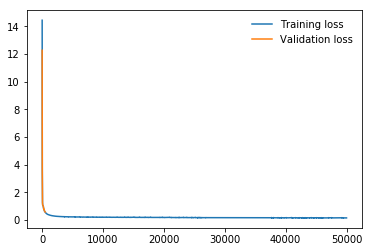

In [15]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

# loss 0.24 -> 2800

In [16]:
test = torch.from_numpy(test.values).float().to(device)

In [17]:

with torch.no_grad():
    model.eval()
    output = model.forward(test)

output.shape
output.cpu().numpy()

array([[11540235. ],
       [ 3788427.8],
       [11461015. ],
       ...,
       [  886159.1],
       [ 2681194.8],
       [ 3006556.2]], dtype=float32)

In [18]:
submission = pd.read_csv('./dataset-0510/submit_test.csv')
submission['total_price'] = output.cpu().numpy()
submission.to_csv('submission/DNN_result.csv', index=False)